<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-07-14 19:34:29.237397: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 19:34:29.270964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-14 19:34:29.271007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-14 19:34:29.272104: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-14 19:34:29.277799: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 19:34:29.278428: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-07-14 19:34:30.098882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-07-14 19:34:32.609049: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 99ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

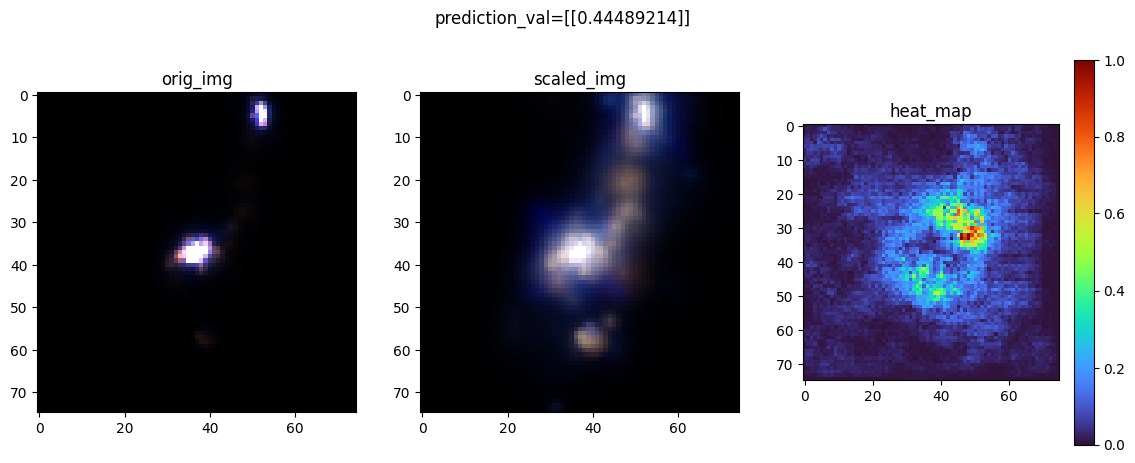

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

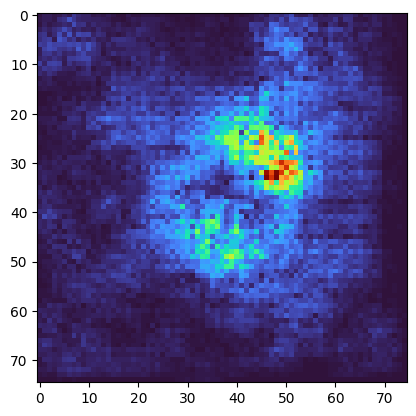

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-07-14 19:34:35.893343: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-14 19:34:36.733375: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-14 19:34:36.813082: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-14 19:34:36.860627: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-14 19:34:38.404593: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

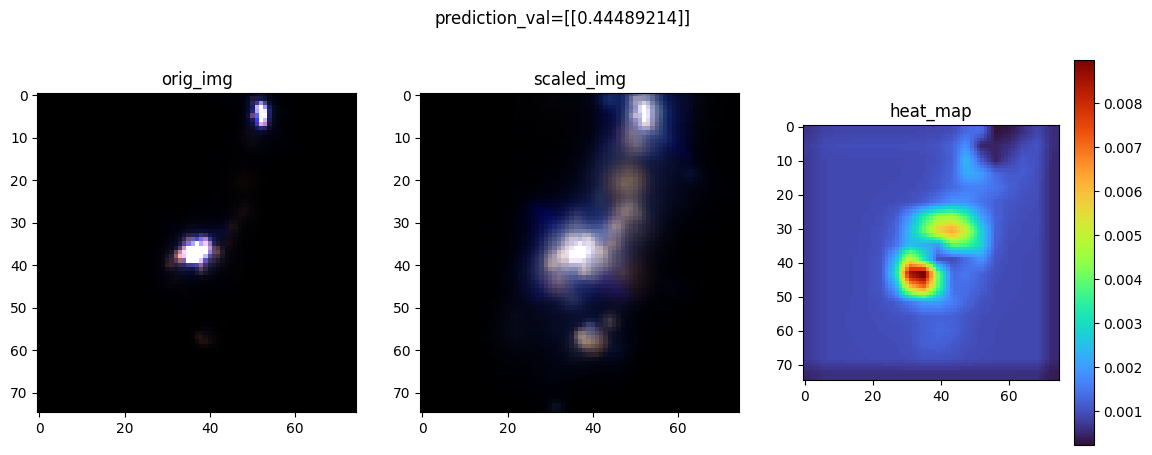

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 4/32 [==>...........................] - ETA: 0s

 8/32 [======>.......................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

20/32 [=================>............] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 1s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

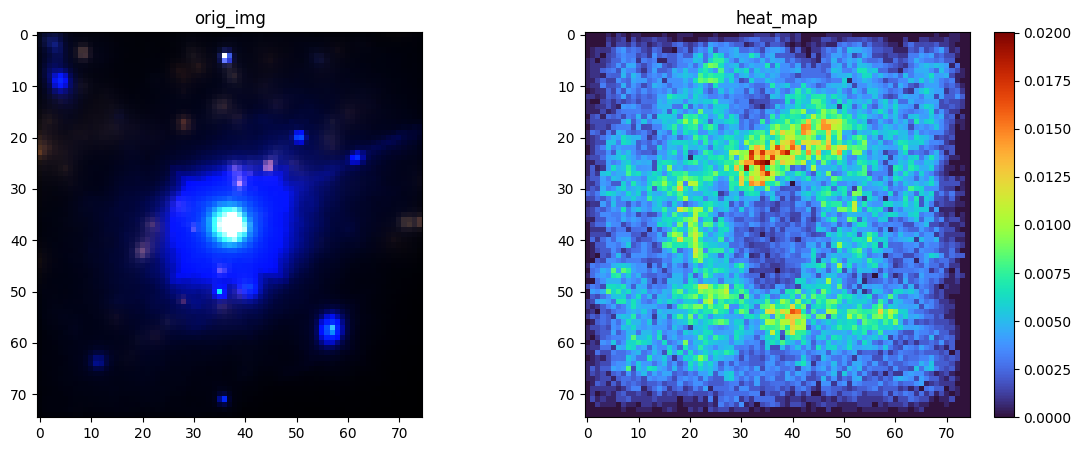

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 6:37 - loss: 0.7156 - accuracy: 0.3438

  2/338 [..............................] - ETA: 20s - loss: 0.7116 - accuracy: 0.4531 

  3/338 [..............................] - ETA: 19s - loss: 0.7114 - accuracy: 0.4479

  4/338 [..............................] - ETA: 19s - loss: 0.7103 - accuracy: 0.4766

  5/338 [..............................] - ETA: 19s - loss: 0.7100 - accuracy: 0.4750

  6/338 [..............................] - ETA: 19s - loss: 0.7101 - accuracy: 0.4583

  7/338 [..............................] - ETA: 19s - loss: 0.7095 - accuracy: 0.4688

  8/338 [..............................] - ETA: 19s - loss: 0.7086 - accuracy: 0.4922

  9/338 [..............................] - ETA: 18s - loss: 0.7086 - accuracy: 0.4826

 10/338 [..............................] - ETA: 18s - loss: 0.7082 - accuracy: 0.4844

 11/338 [..............................] - ETA: 18s - loss: 0.7080 - accuracy: 0.4830

 12/338 [>.............................] - ETA: 18s - loss: 0.7076 - accuracy: 0.4896

 13/338 [>.............................] - ETA: 18s - loss: 0.7072 - accuracy: 0.4952

 14/338 [>.............................] - ETA: 18s - loss: 0.7069 - accuracy: 0.4955

 15/338 [>.............................] - ETA: 18s - loss: 0.7064 - accuracy: 0.5042

 16/338 [>.............................] - ETA: 18s - loss: 0.7062 - accuracy: 0.5039

 17/338 [>.............................] - ETA: 18s - loss: 0.7058 - accuracy: 0.5092

 18/338 [>.............................] - ETA: 18s - loss: 0.7056 - accuracy: 0.5087

 19/338 [>.............................] - ETA: 18s - loss: 0.7051 - accuracy: 0.5181

 20/338 [>.............................] - ETA: 18s - loss: 0.7050 - accuracy: 0.5172

 21/338 [>.............................] - ETA: 18s - loss: 0.7050 - accuracy: 0.5074

 22/338 [>.............................] - ETA: 18s - loss: 0.7049 - accuracy: 0.5057

 23/338 [=>............................] - ETA: 17s - loss: 0.7047 - accuracy: 0.5054

 24/338 [=>............................] - ETA: 17s - loss: 0.7044 - accuracy: 0.5091

 25/338 [=>............................] - ETA: 17s - loss: 0.7041 - accuracy: 0.5125

 26/338 [=>............................] - ETA: 17s - loss: 0.7039 - accuracy: 0.5120

 27/338 [=>............................] - ETA: 17s - loss: 0.7037 - accuracy: 0.5127

 28/338 [=>............................] - ETA: 17s - loss: 0.7036 - accuracy: 0.5123

 29/338 [=>............................] - ETA: 17s - loss: 0.7033 - accuracy: 0.5162

 30/338 [=>............................] - ETA: 17s - loss: 0.7032 - accuracy: 0.5146

 31/338 [=>............................] - ETA: 17s - loss: 0.7030 - accuracy: 0.5141

 32/338 [=>............................] - ETA: 17s - loss: 0.7029 - accuracy: 0.5127

 33/338 [=>............................] - ETA: 17s - loss: 0.7026 - accuracy: 0.5170

 34/338 [==>...........................] - ETA: 17s - loss: 0.7024 - accuracy: 0.5211

 35/338 [==>...........................] - ETA: 17s - loss: 0.7022 - accuracy: 0.5223

 36/338 [==>...........................] - ETA: 17s - loss: 0.7020 - accuracy: 0.5243

 37/338 [==>...........................] - ETA: 17s - loss: 0.7018 - accuracy: 0.5245

 38/338 [==>...........................] - ETA: 17s - loss: 0.7017 - accuracy: 0.5247

 39/338 [==>...........................] - ETA: 16s - loss: 0.7014 - accuracy: 0.5272

 40/338 [==>...........................] - ETA: 16s - loss: 0.7013 - accuracy: 0.5281

 41/338 [==>...........................] - ETA: 16s - loss: 0.7012 - accuracy: 0.5274

 42/338 [==>...........................] - ETA: 16s - loss: 0.7011 - accuracy: 0.5268

 43/338 [==>...........................] - ETA: 16s - loss: 0.7010 - accuracy: 0.5269

 44/338 [==>...........................] - ETA: 16s - loss: 0.7007 - accuracy: 0.5312

 45/338 [==>...........................] - ETA: 16s - loss: 0.7005 - accuracy: 0.5333

 46/338 [===>..........................] - ETA: 16s - loss: 0.7003 - accuracy: 0.5340

 47/338 [===>..........................] - ETA: 16s - loss: 0.7003 - accuracy: 0.5312

 48/338 [===>..........................] - ETA: 16s - loss: 0.7002 - accuracy: 0.5326

 49/338 [===>..........................] - ETA: 16s - loss: 0.6999 - accuracy: 0.5351

 50/338 [===>..........................] - ETA: 16s - loss: 0.6998 - accuracy: 0.5356

 51/338 [===>..........................] - ETA: 16s - loss: 0.6998 - accuracy: 0.5349

 52/338 [===>..........................] - ETA: 16s - loss: 0.6998 - accuracy: 0.5325

 53/338 [===>..........................] - ETA: 16s - loss: 0.6997 - accuracy: 0.5330

 54/338 [===>..........................] - ETA: 16s - loss: 0.6996 - accuracy: 0.5336

 55/338 [===>..........................] - ETA: 16s - loss: 0.6995 - accuracy: 0.5330

 56/338 [===>..........................] - ETA: 15s - loss: 0.6994 - accuracy: 0.5335

 57/338 [====>.........................] - ETA: 15s - loss: 0.6995 - accuracy: 0.5312

 58/338 [====>.........................] - ETA: 15s - loss: 0.6994 - accuracy: 0.5307

 59/338 [====>.........................] - ETA: 15s - loss: 0.6995 - accuracy: 0.5281

 60/338 [====>.........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5302

 61/338 [====>.........................] - ETA: 15s - loss: 0.6994 - accuracy: 0.5277

 62/338 [====>.........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5277

 63/338 [====>.........................] - ETA: 15s - loss: 0.6992 - accuracy: 0.5273

 64/338 [====>.........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5259

 65/338 [====>.........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5245

 66/338 [====>.........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5256

 67/338 [====>.........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5252

 68/338 [=====>........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5239

 69/338 [=====>........................] - ETA: 15s - loss: 0.6990 - accuracy: 0.5240

 70/338 [=====>........................] - ETA: 15s - loss: 0.6989 - accuracy: 0.5246

 71/338 [=====>........................] - ETA: 15s - loss: 0.6989 - accuracy: 0.5251

 72/338 [=====>........................] - ETA: 15s - loss: 0.6989 - accuracy: 0.5239

 73/338 [=====>........................] - ETA: 15s - loss: 0.6990 - accuracy: 0.5214

 74/338 [=====>........................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5198

 75/338 [=====>........................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5183

 76/338 [=====>........................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5173

 77/338 [=====>........................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5166

 78/338 [=====>........................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5188

 79/338 [======>.......................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5170

 80/338 [======>.......................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5188

 81/338 [======>.......................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5185

 82/338 [======>.......................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5179

 83/338 [======>.......................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5166

 84/338 [======>.......................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5182

 85/338 [======>.......................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5180

 86/338 [======>.......................] - ETA: 14s - loss: 0.6985 - accuracy: 0.5182

 87/338 [======>.......................] - ETA: 14s - loss: 0.6984 - accuracy: 0.5201

 88/338 [======>.......................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5199

 89/338 [======>.......................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5207

 90/338 [======>.......................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5194

 91/338 [=======>......................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5192

 92/338 [=======>......................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5194

 93/338 [=======>......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5212

 94/338 [=======>......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5216

 95/338 [=======>......................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5224

 96/338 [=======>......................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5221

 97/338 [=======>......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5229

 98/338 [=======>......................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5214

 99/338 [=======>......................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5227

100/338 [=======>......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5213

101/338 [=======>......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5210

102/338 [========>.....................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5214

103/338 [========>.....................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5212

104/338 [========>.....................] - ETA: 13s - loss: 0.6976 - accuracy: 0.5216

105/338 [========>.....................] - ETA: 13s - loss: 0.6976 - accuracy: 0.5208

106/338 [========>.....................] - ETA: 13s - loss: 0.6976 - accuracy: 0.5200

107/338 [========>.....................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5184

108/338 [========>.....................] - ETA: 13s - loss: 0.6976 - accuracy: 0.5200

109/338 [========>.....................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5201

110/338 [========>.....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5202

111/338 [========>.....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5203

112/338 [========>.....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5201

113/338 [=========>....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5205

114/338 [=========>....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5214

115/338 [=========>....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5209

116/338 [=========>....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5205

117/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5206

118/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5199

119/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5202

120/338 [=========>....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5214

121/338 [=========>....................] - ETA: 12s - loss: 0.6970 - accuracy: 0.5214

122/338 [=========>....................] - ETA: 12s - loss: 0.6970 - accuracy: 0.5223

123/338 [=========>....................] - ETA: 12s - loss: 0.6970 - accuracy: 0.5218

124/338 [==========>...................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5227

125/338 [==========>...................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5230

126/338 [==========>...................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5231

127/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5236

128/338 [==========>...................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5239

129/338 [==========>...................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5245

130/338 [==========>...................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5240

131/338 [==========>...................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5246

132/338 [==========>...................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5253

133/338 [==========>...................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5249

134/338 [==========>...................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5247

135/338 [==========>...................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5257

136/338 [===========>..................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5262

137/338 [===========>..................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5265

138/338 [===========>..................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5263

139/338 [===========>..................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5265

140/338 [===========>..................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5259

141/338 [===========>..................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5268

142/338 [===========>..................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5279

143/338 [===========>..................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5273

144/338 [===========>..................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5271

145/338 [===========>..................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5272

146/338 [===========>..................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5270

147/338 [============>.................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5266

148/338 [============>.................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5264

149/338 [============>.................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5264

150/338 [============>.................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5263

151/338 [============>.................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5273

152/338 [============>.................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5271

153/338 [============>.................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5268

154/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5270

155/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5270

156/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5266

157/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5261

158/338 [=============>................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5261

159/338 [=============>................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5254

160/338 [=============>................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5246

161/338 [=============>................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5256

162/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5264 

163/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5268

164/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5265

165/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5265

166/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5264

167/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5269

168/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5264

169/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5261

170/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5265

171/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5267

172/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5274

173/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5269

174/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5259

175/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5263

176/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5257

177/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5260

178/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5249

179/338 [==============>...............] - ETA: 9s - loss: 0.6955 - accuracy: 0.5246

180/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5252

181/338 [===============>..............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5259

182/338 [===============>..............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5252

183/338 [===============>..............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5254

184/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5258

185/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5262

186/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5270

187/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5274

188/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5278

189/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5274

190/338 [===============>..............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5285

191/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5283

192/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5280

193/338 [================>.............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5277

194/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5277

195/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5279

196/338 [================>.............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5284

197/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5287

198/338 [================>.............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5294

199/338 [================>.............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5295

200/338 [================>.............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5297

201/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5299

202/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5295

203/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5291

204/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5294

205/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5288

206/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5285

207/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5291

208/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5291

209/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5293

210/338 [=================>............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5292

211/338 [=================>............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5293

212/338 [=================>............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5292

213/338 [=================>............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5293

214/338 [=================>............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5292

215/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5295

216/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5294

217/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5289

218/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5285

219/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5288

220/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5297

221/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5293

222/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5291

223/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5294

224/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5287

225/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5283

226/338 [===================>..........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5281

227/338 [===================>..........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5279

228/338 [===================>..........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5275

229/338 [===================>..........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5267

230/338 [===================>..........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5268

231/338 [===================>..........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5265

232/338 [===================>..........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5264

233/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5270

234/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5275

235/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5273

236/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5270

237/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5270

238/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5267

239/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5263

240/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5263

241/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5266

242/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5260

243/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5261

244/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5264

245/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5265

246/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5267

247/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5268

248/338 [=====================>........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5271

249/338 [=====================>........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5272

250/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5274

251/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5274

252/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5272

253/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5273

254/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5272

255/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5271

256/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5271

257/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5276

258/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5280

259/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5278

260/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5279

261/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5281

262/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5283

263/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5290

264/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5284

265/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5285

266/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5288

267/338 [======================>.......] - ETA: 4s - loss: 0.6938 - accuracy: 0.5288

268/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5283

269/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5282

270/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5280

271/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5283

272/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5276

273/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5272

274/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5270

275/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5270

276/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5271

277/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5271

278/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5271

279/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5269

280/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5272

281/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5274

282/338 [========================>.....] - ETA: 3s - loss: 0.6938 - accuracy: 0.5271

283/338 [========================>.....] - ETA: 3s - loss: 0.6938 - accuracy: 0.5269

284/338 [========================>.....] - ETA: 3s - loss: 0.6938 - accuracy: 0.5272

285/338 [========================>.....] - ETA: 3s - loss: 0.6937 - accuracy: 0.5279

286/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5281

287/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5278

288/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5277

289/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5282

290/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5283

291/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5287

292/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5286

293/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5286

294/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5286

295/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5285

296/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5287

297/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5288

298/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5290

299/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5285

300/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5283

301/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5283

302/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5282

303/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5278

304/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5272

305/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5275

306/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5278

307/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5278

308/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5274

309/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5271

310/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5275

311/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5276

312/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5278

313/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5278

314/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5273

315/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5272

316/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5274

317/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5276

318/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5274

319/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5277

320/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5280

321/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5279

322/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5279

323/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5282

324/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5277

325/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5281

326/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5283

327/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5280

328/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5275

329/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5275

330/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5274

331/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5275

332/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5273

333/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5273

334/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5274

335/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5275

336/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5276

337/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5274

338/338 [==============================] - 22s 62ms/step - loss: 0.6933 - accuracy: 0.5271 - val_loss: 0.6909 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.6846 - accuracy: 0.5938

  2/338 [..............................] - ETA: 19s - loss: 0.6875 - accuracy: 0.5625

  3/338 [..............................] - ETA: 19s - loss: 0.6870 - accuracy: 0.5729

  4/338 [..............................] - ETA: 19s - loss: 0.6900 - accuracy: 0.5391

  5/338 [..............................] - ETA: 18s - loss: 0.6888 - accuracy: 0.5500

  6/338 [..............................] - ETA: 18s - loss: 0.6903 - accuracy: 0.5312

  7/338 [..............................] - ETA: 18s - loss: 0.6905 - accuracy: 0.5268

  8/338 [..............................] - ETA: 18s - loss: 0.6896 - accuracy: 0.5352

  9/338 [..............................] - ETA: 18s - loss: 0.6908 - accuracy: 0.5278

 10/338 [..............................] - ETA: 18s - loss: 0.6900 - accuracy: 0.5344

 11/338 [..............................] - ETA: 18s - loss: 0.6896 - accuracy: 0.5398

 12/338 [>.............................] - ETA: 18s - loss: 0.6898 - accuracy: 0.5365

 13/338 [>.............................] - ETA: 18s - loss: 0.6897 - accuracy: 0.5385

 14/338 [>.............................] - ETA: 18s - loss: 0.6890 - accuracy: 0.5446

 15/338 [>.............................] - ETA: 18s - loss: 0.6880 - accuracy: 0.5542

 16/338 [>.............................] - ETA: 18s - loss: 0.6882 - accuracy: 0.5527

 17/338 [>.............................] - ETA: 18s - loss: 0.6888 - accuracy: 0.5478

 18/338 [>.............................] - ETA: 17s - loss: 0.6889 - accuracy: 0.5451

 19/338 [>.............................] - ETA: 17s - loss: 0.6888 - accuracy: 0.5461

 20/338 [>.............................] - ETA: 17s - loss: 0.6895 - accuracy: 0.5406

 21/338 [>.............................] - ETA: 17s - loss: 0.6896 - accuracy: 0.5387

 22/338 [>.............................] - ETA: 17s - loss: 0.6891 - accuracy: 0.5440

 23/338 [=>............................] - ETA: 17s - loss: 0.6891 - accuracy: 0.5435

 24/338 [=>............................] - ETA: 17s - loss: 0.6894 - accuracy: 0.5404

 25/338 [=>............................] - ETA: 17s - loss: 0.6892 - accuracy: 0.5425

 26/338 [=>............................] - ETA: 17s - loss: 0.6887 - accuracy: 0.5469

 27/338 [=>............................] - ETA: 17s - loss: 0.6885 - accuracy: 0.5498

 28/338 [=>............................] - ETA: 17s - loss: 0.6890 - accuracy: 0.5458

 29/338 [=>............................] - ETA: 17s - loss: 0.6890 - accuracy: 0.5453

 30/338 [=>............................] - ETA: 17s - loss: 0.6890 - accuracy: 0.5448

 31/338 [=>............................] - ETA: 17s - loss: 0.6891 - accuracy: 0.5433

 32/338 [=>............................] - ETA: 17s - loss: 0.6887 - accuracy: 0.5469

 33/338 [=>............................] - ETA: 17s - loss: 0.6887 - accuracy: 0.5464

 34/338 [==>...........................] - ETA: 16s - loss: 0.6887 - accuracy: 0.5450

 35/338 [==>...........................] - ETA: 16s - loss: 0.6884 - accuracy: 0.5482

 36/338 [==>...........................] - ETA: 16s - loss: 0.6880 - accuracy: 0.5512

 37/338 [==>...........................] - ETA: 16s - loss: 0.6882 - accuracy: 0.5498

 38/338 [==>...........................] - ETA: 16s - loss: 0.6886 - accuracy: 0.5452

 39/338 [==>...........................] - ETA: 16s - loss: 0.6887 - accuracy: 0.5449

 40/338 [==>...........................] - ETA: 16s - loss: 0.6885 - accuracy: 0.5461

 41/338 [==>...........................] - ETA: 16s - loss: 0.6884 - accuracy: 0.5465

 42/338 [==>...........................] - ETA: 16s - loss: 0.6884 - accuracy: 0.5476

 43/338 [==>...........................] - ETA: 16s - loss: 0.6883 - accuracy: 0.5480

 44/338 [==>...........................] - ETA: 16s - loss: 0.6882 - accuracy: 0.5490

 45/338 [==>...........................] - ETA: 16s - loss: 0.6882 - accuracy: 0.5493

 46/338 [===>..........................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5503

 47/338 [===>..........................] - ETA: 16s - loss: 0.6878 - accuracy: 0.5519

 48/338 [===>..........................] - ETA: 16s - loss: 0.6880 - accuracy: 0.5501

 49/338 [===>..........................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5497

 50/338 [===>..........................] - ETA: 16s - loss: 0.6883 - accuracy: 0.5481

 51/338 [===>..........................] - ETA: 16s - loss: 0.6883 - accuracy: 0.5472

 52/338 [===>..........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5457

 53/338 [===>..........................] - ETA: 15s - loss: 0.6888 - accuracy: 0.5430

 54/338 [===>..........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5446

 55/338 [===>..........................] - ETA: 15s - loss: 0.6887 - accuracy: 0.5432

 56/338 [===>..........................] - ETA: 15s - loss: 0.6887 - accuracy: 0.5435

 57/338 [====>.........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5450

 58/338 [====>.........................] - ETA: 15s - loss: 0.6887 - accuracy: 0.5426

 59/338 [====>.........................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5434

 60/338 [====>.........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5448

 61/338 [====>.........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5441

 62/338 [====>.........................] - ETA: 15s - loss: 0.6882 - accuracy: 0.5454

 63/338 [====>.........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5432

 64/338 [====>.........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5430

 65/338 [====>.........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5433

 66/338 [====>.........................] - ETA: 15s - loss: 0.6883 - accuracy: 0.5440

 67/338 [====>.........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5424

 68/338 [=====>........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5427

 69/338 [=====>........................] - ETA: 15s - loss: 0.6890 - accuracy: 0.5389

 70/338 [=====>........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5371

 71/338 [=====>........................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5379

 72/338 [=====>........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5365

 73/338 [=====>........................] - ETA: 14s - loss: 0.6892 - accuracy: 0.5372

 74/338 [=====>........................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5376

 75/338 [=====>........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5358

 76/338 [=====>........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5358

 77/338 [=====>........................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5369

 78/338 [=====>........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5361

 79/338 [======>.......................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5356

 80/338 [======>.......................] - ETA: 14s - loss: 0.6894 - accuracy: 0.5348

 81/338 [======>.......................] - ETA: 14s - loss: 0.6896 - accuracy: 0.5336

 82/338 [======>.......................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5320

 83/338 [======>.......................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5320

 84/338 [======>.......................] - ETA: 14s - loss: 0.6897 - accuracy: 0.5316

 85/338 [======>.......................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5294

 86/338 [======>.......................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5298

 87/338 [======>.......................] - ETA: 14s - loss: 0.6899 - accuracy: 0.5298

 88/338 [======>.......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5302

 89/338 [======>.......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5298

 90/338 [======>.......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5292

 91/338 [=======>......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5299

 92/338 [=======>......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5299

 93/338 [=======>......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5296

 94/338 [=======>......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5303

 95/338 [=======>......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5303

 96/338 [=======>......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5296

 97/338 [=======>......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5287

 98/338 [=======>......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5271

 99/338 [=======>......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5268

100/338 [=======>......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5266

101/338 [=======>......................] - ETA: 13s - loss: 0.6901 - accuracy: 0.5251

102/338 [========>.....................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5257

103/338 [========>.....................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5261

104/338 [========>.....................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5273

105/338 [========>.....................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5283

106/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5301

107/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5298

108/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5295

109/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5287

110/338 [========>.....................] - ETA: 12s - loss: 0.6897 - accuracy: 0.5278

111/338 [========>.....................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5290

112/338 [========>.....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5296

113/338 [=========>....................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5296

114/338 [=========>....................] - ETA: 12s - loss: 0.6894 - accuracy: 0.5299

115/338 [=========>....................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5288

116/338 [=========>....................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5288

117/338 [=========>....................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5299

118/338 [=========>....................] - ETA: 12s - loss: 0.6892 - accuracy: 0.5310

119/338 [=========>....................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5297

120/338 [=========>....................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5297

121/338 [=========>....................] - ETA: 12s - loss: 0.6892 - accuracy: 0.5310

122/338 [=========>....................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5328

123/338 [=========>....................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5335

124/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5328

125/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5328

126/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5335

127/338 [==========>...................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5342

128/338 [==========>...................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5339

129/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5332

130/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5329

131/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5327

132/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5327

133/338 [==========>...................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5336

134/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5329

135/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5319

136/338 [===========>..................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5315

137/338 [===========>..................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5319

138/338 [===========>..................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5324

139/338 [===========>..................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5315

140/338 [===========>..................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5319

141/338 [===========>..................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5312

142/338 [===========>..................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5310

143/338 [===========>..................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5321

144/338 [===========>..................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5326

145/338 [===========>..................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5336

146/338 [===========>..................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5325

147/338 [============>.................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5334

148/338 [============>.................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5336

149/338 [============>.................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5336

150/338 [============>.................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5327

151/338 [============>.................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5325

152/338 [============>.................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5317

153/338 [============>.................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5321

154/338 [============>.................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5312

155/338 [============>.................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5310

156/338 [============>.................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5317

157/338 [============>.................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5305

158/338 [=============>................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5305

159/338 [=============>................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5301

160/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5305 

161/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5301

162/338 [=============>................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5293

163/338 [=============>................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5299

164/338 [=============>................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5290

165/338 [=============>................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5299

166/338 [=============>................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5299

167/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5298

168/338 [=============>................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5298

169/338 [==============>...............] - ETA: 9s - loss: 0.6889 - accuracy: 0.5300

170/338 [==============>...............] - ETA: 9s - loss: 0.6889 - accuracy: 0.5303

171/338 [==============>...............] - ETA: 9s - loss: 0.6889 - accuracy: 0.5303

172/338 [==============>...............] - ETA: 9s - loss: 0.6888 - accuracy: 0.5314

173/338 [==============>...............] - ETA: 9s - loss: 0.6888 - accuracy: 0.5316

174/338 [==============>...............] - ETA: 9s - loss: 0.6888 - accuracy: 0.5311

175/338 [==============>...............] - ETA: 9s - loss: 0.6888 - accuracy: 0.5314

176/338 [==============>...............] - ETA: 9s - loss: 0.6887 - accuracy: 0.5312

177/338 [==============>...............] - ETA: 9s - loss: 0.6888 - accuracy: 0.5307

178/338 [==============>...............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5309

179/338 [==============>...............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5304

180/338 [==============>...............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5314

181/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5312

182/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5321

183/338 [===============>..............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5318

184/338 [===============>..............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5316

185/338 [===============>..............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5321

186/338 [===============>..............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5318

187/338 [===============>..............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5323

188/338 [===============>..............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5319

189/338 [===============>..............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5319

190/338 [===============>..............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5324

191/338 [===============>..............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5317

192/338 [================>.............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5317

193/338 [================>.............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5317

194/338 [================>.............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5314

195/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5324

196/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5322

197/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5319

198/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5319

199/338 [================>.............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5320

200/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5312

201/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5320

202/338 [================>.............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5312

203/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5311

204/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5309

205/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5309

206/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5306

207/338 [=================>............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5311

208/338 [=================>............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5308

209/338 [=================>............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5312

210/338 [=================>............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5311

211/338 [=================>............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5312

212/338 [=================>............] - ETA: 7s - loss: 0.6879 - accuracy: 0.5320

213/338 [=================>............] - ETA: 6s - loss: 0.6879 - accuracy: 0.5324

214/338 [=================>............] - ETA: 6s - loss: 0.6879 - accuracy: 0.5323

215/338 [==================>...........] - ETA: 6s - loss: 0.6878 - accuracy: 0.5324

216/338 [==================>...........] - ETA: 6s - loss: 0.6878 - accuracy: 0.5321

217/338 [==================>...........] - ETA: 6s - loss: 0.6878 - accuracy: 0.5323

218/338 [==================>...........] - ETA: 6s - loss: 0.6877 - accuracy: 0.5327

219/338 [==================>...........] - ETA: 6s - loss: 0.6878 - accuracy: 0.5325

220/338 [==================>...........] - ETA: 6s - loss: 0.6877 - accuracy: 0.5325

221/338 [==================>...........] - ETA: 6s - loss: 0.6877 - accuracy: 0.5324

222/338 [==================>...........] - ETA: 6s - loss: 0.6878 - accuracy: 0.5322

223/338 [==================>...........] - ETA: 6s - loss: 0.6878 - accuracy: 0.5318

224/338 [==================>...........] - ETA: 6s - loss: 0.6878 - accuracy: 0.5317

225/338 [==================>...........] - ETA: 6s - loss: 0.6879 - accuracy: 0.5304

226/338 [===================>..........] - ETA: 6s - loss: 0.6879 - accuracy: 0.5304

227/338 [===================>..........] - ETA: 6s - loss: 0.6879 - accuracy: 0.5300

228/338 [===================>..........] - ETA: 6s - loss: 0.6880 - accuracy: 0.5293

229/338 [===================>..........] - ETA: 6s - loss: 0.6879 - accuracy: 0.5304

230/338 [===================>..........] - ETA: 6s - loss: 0.6878 - accuracy: 0.5311

231/338 [===================>..........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5311

232/338 [===================>..........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5311

233/338 [===================>..........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5308

234/338 [===================>..........] - ETA: 5s - loss: 0.6879 - accuracy: 0.5299

235/338 [===================>..........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5301

236/338 [===================>..........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5302

237/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5303

238/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5307

239/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5305

240/338 [====================>.........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5306

241/338 [====================>.........] - ETA: 5s - loss: 0.6878 - accuracy: 0.5298

242/338 [====================>.........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5300

243/338 [====================>.........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5302

244/338 [====================>.........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5304

245/338 [====================>.........] - ETA: 5s - loss: 0.6876 - accuracy: 0.5296

246/338 [====================>.........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5290

247/338 [====================>.........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5288

248/338 [=====================>........] - ETA: 5s - loss: 0.6877 - accuracy: 0.5284

249/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5281

250/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5282

251/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5285

252/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5286

253/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5289

254/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5289

255/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5292

256/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5295

257/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5297

258/338 [=====================>........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5300

259/338 [=====================>........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5304

260/338 [======================>.......] - ETA: 4s - loss: 0.6876 - accuracy: 0.5311

261/338 [======================>.......] - ETA: 4s - loss: 0.6876 - accuracy: 0.5311

262/338 [======================>.......] - ETA: 4s - loss: 0.6876 - accuracy: 0.5311

263/338 [======================>.......] - ETA: 4s - loss: 0.6876 - accuracy: 0.5314

264/338 [======================>.......] - ETA: 4s - loss: 0.6876 - accuracy: 0.5316

265/338 [======================>.......] - ETA: 4s - loss: 0.6876 - accuracy: 0.5317

266/338 [======================>.......] - ETA: 4s - loss: 0.6875 - accuracy: 0.5322

267/338 [======================>.......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5325

268/338 [======================>.......] - ETA: 3s - loss: 0.6876 - accuracy: 0.5328

269/338 [======================>.......] - ETA: 3s - loss: 0.6876 - accuracy: 0.5332

270/338 [======================>.......] - ETA: 3s - loss: 0.6876 - accuracy: 0.5337

271/338 [=======================>......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5342

272/338 [=======================>......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5342

273/338 [=======================>......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5345

274/338 [=======================>......] - ETA: 3s - loss: 0.6876 - accuracy: 0.5347

275/338 [=======================>......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5352

276/338 [=======================>......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5360

277/338 [=======================>......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5360

278/338 [=======================>......] - ETA: 3s - loss: 0.6876 - accuracy: 0.5364

279/338 [=======================>......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5363

280/338 [=======================>......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5366

281/338 [=======================>......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5368

282/338 [========================>.....] - ETA: 3s - loss: 0.6875 - accuracy: 0.5371

283/338 [========================>.....] - ETA: 3s - loss: 0.6875 - accuracy: 0.5378

284/338 [========================>.....] - ETA: 3s - loss: 0.6875 - accuracy: 0.5384

285/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5389

286/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5387

287/338 [========================>.....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5380

288/338 [========================>.....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5387

289/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5394

290/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5398

291/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5394

292/338 [========================>.....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5393

293/338 [=========================>....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5398

294/338 [=========================>....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5407

295/338 [=========================>....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5411

296/338 [=========================>....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5411

297/338 [=========================>....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5417

298/338 [=========================>....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5416

299/338 [=========================>....] - ETA: 2s - loss: 0.6872 - accuracy: 0.5422

300/338 [=========================>....] - ETA: 2s - loss: 0.6872 - accuracy: 0.5428

301/338 [=========================>....] - ETA: 2s - loss: 0.6872 - accuracy: 0.5431

302/338 [=========================>....] - ETA: 2s - loss: 0.6871 - accuracy: 0.5437

303/338 [=========================>....] - ETA: 1s - loss: 0.6870 - accuracy: 0.5440

304/338 [=========================>....] - ETA: 1s - loss: 0.6870 - accuracy: 0.5444

305/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5447

306/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5450

307/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5450

308/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5453

309/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5453

310/338 [==========================>...] - ETA: 1s - loss: 0.6869 - accuracy: 0.5461

311/338 [==========================>...] - ETA: 1s - loss: 0.6869 - accuracy: 0.5463

312/338 [==========================>...] - ETA: 1s - loss: 0.6868 - accuracy: 0.5470

313/338 [==========================>...] - ETA: 1s - loss: 0.6868 - accuracy: 0.5473

314/338 [==========================>...] - ETA: 1s - loss: 0.6868 - accuracy: 0.5476

315/338 [==========================>...] - ETA: 1s - loss: 0.6868 - accuracy: 0.5480

316/338 [===========================>..] - ETA: 1s - loss: 0.6868 - accuracy: 0.5479

317/338 [===========================>..] - ETA: 1s - loss: 0.6867 - accuracy: 0.5487

318/338 [===========================>..] - ETA: 1s - loss: 0.6867 - accuracy: 0.5487

319/338 [===========================>..] - ETA: 1s - loss: 0.6867 - accuracy: 0.5490

320/338 [===========================>..] - ETA: 1s - loss: 0.6867 - accuracy: 0.5489

321/338 [===========================>..] - ETA: 0s - loss: 0.6867 - accuracy: 0.5490

322/338 [===========================>..] - ETA: 0s - loss: 0.6866 - accuracy: 0.5491

323/338 [===========================>..] - ETA: 0s - loss: 0.6866 - accuracy: 0.5496

324/338 [===========================>..] - ETA: 0s - loss: 0.6866 - accuracy: 0.5497

325/338 [===========================>..] - ETA: 0s - loss: 0.6865 - accuracy: 0.5505

326/338 [===========================>..] - ETA: 0s - loss: 0.6865 - accuracy: 0.5506

327/338 [============================>.] - ETA: 0s - loss: 0.6866 - accuracy: 0.5505

328/338 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5511

329/338 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5513

330/338 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.5518

331/338 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5518

332/338 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5521

333/338 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5521

334/338 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5522

335/338 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.5529

336/338 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.5534

337/338 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.5534

338/338 [==============================] - 20s 60ms/step - loss: 0.6864 - accuracy: 0.5536 - val_loss: 0.6875 - val_accuracy: 0.5615


Epoch 3/5


  1/338 [..............................] - ETA: 18s - loss: 0.6623 - accuracy: 0.7812

  2/338 [..............................] - ETA: 18s - loss: 0.6733 - accuracy: 0.6875

  3/338 [..............................] - ETA: 18s - loss: 0.6763 - accuracy: 0.6354

  4/338 [..............................] - ETA: 18s - loss: 0.6697 - accuracy: 0.6719

  5/338 [..............................] - ETA: 18s - loss: 0.6721 - accuracy: 0.6562

  6/338 [..............................] - ETA: 18s - loss: 0.6719 - accuracy: 0.6719

  7/338 [..............................] - ETA: 18s - loss: 0.6717 - accuracy: 0.6741

  8/338 [..............................] - ETA: 18s - loss: 0.6725 - accuracy: 0.6758

  9/338 [..............................] - ETA: 18s - loss: 0.6707 - accuracy: 0.6771

 10/338 [..............................] - ETA: 17s - loss: 0.6725 - accuracy: 0.6687

 11/338 [..............................] - ETA: 17s - loss: 0.6734 - accuracy: 0.6619

 12/338 [>.............................] - ETA: 17s - loss: 0.6718 - accuracy: 0.6667

 13/338 [>.............................] - ETA: 17s - loss: 0.6742 - accuracy: 0.6514

 14/338 [>.............................] - ETA: 17s - loss: 0.6732 - accuracy: 0.6540

 15/338 [>.............................] - ETA: 17s - loss: 0.6745 - accuracy: 0.6542

 16/338 [>.............................] - ETA: 17s - loss: 0.6746 - accuracy: 0.6543

 17/338 [>.............................] - ETA: 17s - loss: 0.6738 - accuracy: 0.6562

 18/338 [>.............................] - ETA: 17s - loss: 0.6738 - accuracy: 0.6597

 19/338 [>.............................] - ETA: 17s - loss: 0.6738 - accuracy: 0.6562

 20/338 [>.............................] - ETA: 17s - loss: 0.6745 - accuracy: 0.6500

 21/338 [>.............................] - ETA: 17s - loss: 0.6751 - accuracy: 0.6473

 22/338 [>.............................] - ETA: 17s - loss: 0.6761 - accuracy: 0.6435

 23/338 [=>............................] - ETA: 17s - loss: 0.6764 - accuracy: 0.6386

 24/338 [=>............................] - ETA: 17s - loss: 0.6763 - accuracy: 0.6393

 25/338 [=>............................] - ETA: 17s - loss: 0.6764 - accuracy: 0.6363

 26/338 [=>............................] - ETA: 17s - loss: 0.6764 - accuracy: 0.6394

 27/338 [=>............................] - ETA: 17s - loss: 0.6773 - accuracy: 0.6366

 28/338 [=>............................] - ETA: 16s - loss: 0.6777 - accuracy: 0.6339

 29/338 [=>............................] - ETA: 16s - loss: 0.6770 - accuracy: 0.6379

 30/338 [=>............................] - ETA: 16s - loss: 0.6768 - accuracy: 0.6396

 31/338 [=>............................] - ETA: 16s - loss: 0.6768 - accuracy: 0.6401

 32/338 [=>............................] - ETA: 16s - loss: 0.6770 - accuracy: 0.6396

 33/338 [=>............................] - ETA: 16s - loss: 0.6770 - accuracy: 0.6373

 34/338 [==>...........................] - ETA: 16s - loss: 0.6773 - accuracy: 0.6369

 35/338 [==>...........................] - ETA: 16s - loss: 0.6769 - accuracy: 0.6402

 36/338 [==>...........................] - ETA: 16s - loss: 0.6770 - accuracy: 0.6415

 37/338 [==>...........................] - ETA: 16s - loss: 0.6776 - accuracy: 0.6368

 38/338 [==>...........................] - ETA: 16s - loss: 0.6776 - accuracy: 0.6373

 39/338 [==>...........................] - ETA: 16s - loss: 0.6776 - accuracy: 0.6354

 40/338 [==>...........................] - ETA: 16s - loss: 0.6777 - accuracy: 0.6352

 41/338 [==>...........................] - ETA: 16s - loss: 0.6774 - accuracy: 0.6357

 42/338 [==>...........................] - ETA: 16s - loss: 0.6778 - accuracy: 0.6347

 43/338 [==>...........................] - ETA: 16s - loss: 0.6779 - accuracy: 0.6344

 44/338 [==>...........................] - ETA: 16s - loss: 0.6776 - accuracy: 0.6357

 45/338 [==>...........................] - ETA: 16s - loss: 0.6774 - accuracy: 0.6368

 46/338 [===>..........................] - ETA: 16s - loss: 0.6776 - accuracy: 0.6352

 47/338 [===>..........................] - ETA: 16s - loss: 0.6771 - accuracy: 0.6376

 48/338 [===>..........................] - ETA: 16s - loss: 0.6772 - accuracy: 0.6354

 49/338 [===>..........................] - ETA: 15s - loss: 0.6772 - accuracy: 0.6365

 50/338 [===>..........................] - ETA: 15s - loss: 0.6771 - accuracy: 0.6375

 51/338 [===>..........................] - ETA: 15s - loss: 0.6771 - accuracy: 0.6379

 52/338 [===>..........................] - ETA: 15s - loss: 0.6773 - accuracy: 0.6370

 53/338 [===>..........................] - ETA: 15s - loss: 0.6774 - accuracy: 0.6380

 54/338 [===>..........................] - ETA: 15s - loss: 0.6775 - accuracy: 0.6377

 55/338 [===>..........................] - ETA: 15s - loss: 0.6774 - accuracy: 0.6415

 56/338 [===>..........................] - ETA: 15s - loss: 0.6772 - accuracy: 0.6429

 57/338 [====>.........................] - ETA: 15s - loss: 0.6772 - accuracy: 0.6431

 58/338 [====>.........................] - ETA: 15s - loss: 0.6773 - accuracy: 0.6433

 59/338 [====>.........................] - ETA: 15s - loss: 0.6774 - accuracy: 0.6430

 60/338 [====>.........................] - ETA: 15s - loss: 0.6779 - accuracy: 0.6406

 61/338 [====>.........................] - ETA: 15s - loss: 0.6779 - accuracy: 0.6399

 62/338 [====>.........................] - ETA: 15s - loss: 0.6783 - accuracy: 0.6381

 63/338 [====>.........................] - ETA: 15s - loss: 0.6779 - accuracy: 0.6389

 64/338 [====>.........................] - ETA: 15s - loss: 0.6777 - accuracy: 0.6396

 65/338 [====>.........................] - ETA: 15s - loss: 0.6775 - accuracy: 0.6413

 66/338 [====>.........................] - ETA: 15s - loss: 0.6774 - accuracy: 0.6406

 67/338 [====>.........................] - ETA: 14s - loss: 0.6772 - accuracy: 0.6418

 68/338 [=====>........................] - ETA: 14s - loss: 0.6768 - accuracy: 0.6438

 69/338 [=====>........................] - ETA: 14s - loss: 0.6766 - accuracy: 0.6445

 70/338 [=====>........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6455

 71/338 [=====>........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6448

 72/338 [=====>........................] - ETA: 14s - loss: 0.6763 - accuracy: 0.6441

 73/338 [=====>........................] - ETA: 14s - loss: 0.6766 - accuracy: 0.6417

 74/338 [=====>........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6415

 75/338 [=====>........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6417

 76/338 [=====>........................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6431

 77/338 [=====>........................] - ETA: 14s - loss: 0.6759 - accuracy: 0.6449

 78/338 [=====>........................] - ETA: 14s - loss: 0.6759 - accuracy: 0.6454

 79/338 [======>.......................] - ETA: 14s - loss: 0.6758 - accuracy: 0.6468

 80/338 [======>.......................] - ETA: 14s - loss: 0.6757 - accuracy: 0.6469

 81/338 [======>.......................] - ETA: 14s - loss: 0.6756 - accuracy: 0.6474

 82/338 [======>.......................] - ETA: 14s - loss: 0.6758 - accuracy: 0.6463

 83/338 [======>.......................] - ETA: 14s - loss: 0.6757 - accuracy: 0.6468

 84/338 [======>.......................] - ETA: 14s - loss: 0.6758 - accuracy: 0.6458

 85/338 [======>.......................] - ETA: 14s - loss: 0.6759 - accuracy: 0.6460

 86/338 [======>.......................] - ETA: 13s - loss: 0.6758 - accuracy: 0.6468

 87/338 [======>.......................] - ETA: 13s - loss: 0.6757 - accuracy: 0.6473

 88/338 [======>.......................] - ETA: 13s - loss: 0.6757 - accuracy: 0.6467

 89/338 [======>.......................] - ETA: 13s - loss: 0.6761 - accuracy: 0.6454

 90/338 [======>.......................] - ETA: 13s - loss: 0.6765 - accuracy: 0.6434

 91/338 [=======>......................] - ETA: 13s - loss: 0.6762 - accuracy: 0.6439

 92/338 [=======>......................] - ETA: 13s - loss: 0.6765 - accuracy: 0.6427

 93/338 [=======>......................] - ETA: 13s - loss: 0.6766 - accuracy: 0.6418

 94/338 [=======>......................] - ETA: 13s - loss: 0.6764 - accuracy: 0.6433

 95/338 [=======>......................] - ETA: 13s - loss: 0.6763 - accuracy: 0.6434

 96/338 [=======>......................] - ETA: 13s - loss: 0.6760 - accuracy: 0.6445

 97/338 [=======>......................] - ETA: 13s - loss: 0.6761 - accuracy: 0.6434

 98/338 [=======>......................] - ETA: 13s - loss: 0.6760 - accuracy: 0.6441

 99/338 [=======>......................] - ETA: 13s - loss: 0.6760 - accuracy: 0.6439

100/338 [=======>......................] - ETA: 13s - loss: 0.6760 - accuracy: 0.6441

101/338 [=======>......................] - ETA: 13s - loss: 0.6760 - accuracy: 0.6442

102/338 [========>.....................] - ETA: 13s - loss: 0.6759 - accuracy: 0.6443

103/338 [========>.....................] - ETA: 13s - loss: 0.6758 - accuracy: 0.6444

104/338 [========>.....................] - ETA: 12s - loss: 0.6754 - accuracy: 0.6457

105/338 [========>.....................] - ETA: 12s - loss: 0.6752 - accuracy: 0.6458

106/338 [========>.....................] - ETA: 12s - loss: 0.6753 - accuracy: 0.6450

107/338 [========>.....................] - ETA: 12s - loss: 0.6753 - accuracy: 0.6446

108/338 [========>.....................] - ETA: 12s - loss: 0.6751 - accuracy: 0.6453

109/338 [========>.....................] - ETA: 12s - loss: 0.6755 - accuracy: 0.6433

110/338 [========>.....................] - ETA: 12s - loss: 0.6754 - accuracy: 0.6435

111/338 [========>.....................] - ETA: 12s - loss: 0.6752 - accuracy: 0.6439

112/338 [========>.....................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6451

113/338 [=========>....................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6452

114/338 [=========>....................] - ETA: 12s - loss: 0.6749 - accuracy: 0.6456

115/338 [=========>....................] - ETA: 12s - loss: 0.6746 - accuracy: 0.6465

116/338 [=========>....................] - ETA: 12s - loss: 0.6745 - accuracy: 0.6468

117/338 [=========>....................] - ETA: 12s - loss: 0.6744 - accuracy: 0.6477

118/338 [=========>....................] - ETA: 12s - loss: 0.6747 - accuracy: 0.6462

119/338 [=========>....................] - ETA: 12s - loss: 0.6748 - accuracy: 0.6460

120/338 [=========>....................] - ETA: 12s - loss: 0.6747 - accuracy: 0.6469

121/338 [=========>....................] - ETA: 12s - loss: 0.6747 - accuracy: 0.6467

122/338 [=========>....................] - ETA: 12s - loss: 0.6747 - accuracy: 0.6470

123/338 [=========>....................] - ETA: 11s - loss: 0.6748 - accuracy: 0.6466

124/338 [==========>...................] - ETA: 11s - loss: 0.6746 - accuracy: 0.6464

125/338 [==========>...................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6485

126/338 [==========>...................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6491

127/338 [==========>...................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6491

128/338 [==========>...................] - ETA: 11s - loss: 0.6741 - accuracy: 0.6487

129/338 [==========>...................] - ETA: 11s - loss: 0.6743 - accuracy: 0.6475

130/338 [==========>...................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6483

131/338 [==========>...................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6484

132/338 [==========>...................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6489

133/338 [==========>...................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6490

134/338 [==========>...................] - ETA: 11s - loss: 0.6741 - accuracy: 0.6486

135/338 [==========>...................] - ETA: 11s - loss: 0.6743 - accuracy: 0.6477

136/338 [===========>..................] - ETA: 11s - loss: 0.6744 - accuracy: 0.6475

137/338 [===========>..................] - ETA: 11s - loss: 0.6743 - accuracy: 0.6480

138/338 [===========>..................] - ETA: 11s - loss: 0.6746 - accuracy: 0.6467

139/338 [===========>..................] - ETA: 11s - loss: 0.6745 - accuracy: 0.6468

140/338 [===========>..................] - ETA: 11s - loss: 0.6744 - accuracy: 0.6473

141/338 [===========>..................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6465

142/338 [===========>..................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6470

143/338 [===========>..................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6469

144/338 [===========>..................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6463

145/338 [===========>..................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6474

146/338 [===========>..................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6470

147/338 [============>.................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6465

148/338 [============>.................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6472

149/338 [============>.................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6468

150/338 [============>.................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6460

151/338 [============>.................] - ETA: 10s - loss: 0.6746 - accuracy: 0.6451

152/338 [============>.................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6456

153/338 [============>.................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6456

154/338 [============>.................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6459

155/338 [============>.................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6462

156/338 [============>.................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6452

157/338 [============>.................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6449

158/338 [=============>................] - ETA: 10s - loss: 0.6746 - accuracy: 0.6446

159/338 [=============>................] - ETA: 9s - loss: 0.6747 - accuracy: 0.6437 

160/338 [=============>................] - ETA: 9s - loss: 0.6747 - accuracy: 0.6438

161/338 [=============>................] - ETA: 9s - loss: 0.6747 - accuracy: 0.6434

162/338 [=============>................] - ETA: 9s - loss: 0.6748 - accuracy: 0.6427

163/338 [=============>................] - ETA: 9s - loss: 0.6749 - accuracy: 0.6421

164/338 [=============>................] - ETA: 9s - loss: 0.6750 - accuracy: 0.6412

165/338 [=============>................] - ETA: 9s - loss: 0.6748 - accuracy: 0.6420

166/338 [=============>................] - ETA: 9s - loss: 0.6748 - accuracy: 0.6419

167/338 [=============>................] - ETA: 9s - loss: 0.6747 - accuracy: 0.6430

168/338 [=============>................] - ETA: 9s - loss: 0.6748 - accuracy: 0.6427

169/338 [==============>...............] - ETA: 9s - loss: 0.6747 - accuracy: 0.6431

170/338 [==============>...............] - ETA: 9s - loss: 0.6748 - accuracy: 0.6426

171/338 [==============>...............] - ETA: 9s - loss: 0.6749 - accuracy: 0.6420

172/338 [==============>...............] - ETA: 9s - loss: 0.6748 - accuracy: 0.6419

173/338 [==============>...............] - ETA: 9s - loss: 0.6750 - accuracy: 0.6411

174/338 [==============>...............] - ETA: 9s - loss: 0.6749 - accuracy: 0.6412

175/338 [==============>...............] - ETA: 9s - loss: 0.6749 - accuracy: 0.6414

176/338 [==============>...............] - ETA: 9s - loss: 0.6749 - accuracy: 0.6408

177/338 [==============>...............] - ETA: 8s - loss: 0.6752 - accuracy: 0.6393

178/338 [==============>...............] - ETA: 8s - loss: 0.6753 - accuracy: 0.6387

179/338 [==============>...............] - ETA: 8s - loss: 0.6752 - accuracy: 0.6391

180/338 [==============>...............] - ETA: 8s - loss: 0.6752 - accuracy: 0.6391

181/338 [===============>..............] - ETA: 8s - loss: 0.6752 - accuracy: 0.6390

182/338 [===============>..............] - ETA: 8s - loss: 0.6753 - accuracy: 0.6386

183/338 [===============>..............] - ETA: 8s - loss: 0.6754 - accuracy: 0.6378

184/338 [===============>..............] - ETA: 8s - loss: 0.6755 - accuracy: 0.6376

185/338 [===============>..............] - ETA: 8s - loss: 0.6756 - accuracy: 0.6368

186/338 [===============>..............] - ETA: 8s - loss: 0.6757 - accuracy: 0.6359

187/338 [===============>..............] - ETA: 8s - loss: 0.6756 - accuracy: 0.6360

188/338 [===============>..............] - ETA: 8s - loss: 0.6757 - accuracy: 0.6355

189/338 [===============>..............] - ETA: 8s - loss: 0.6757 - accuracy: 0.6353

190/338 [===============>..............] - ETA: 8s - loss: 0.6758 - accuracy: 0.6347

191/338 [===============>..............] - ETA: 8s - loss: 0.6758 - accuracy: 0.6348

192/338 [================>.............] - ETA: 8s - loss: 0.6758 - accuracy: 0.6343

193/338 [================>.............] - ETA: 8s - loss: 0.6758 - accuracy: 0.6339

194/338 [================>.............] - ETA: 8s - loss: 0.6760 - accuracy: 0.6331

195/338 [================>.............] - ETA: 7s - loss: 0.6760 - accuracy: 0.6332

196/338 [================>.............] - ETA: 7s - loss: 0.6760 - accuracy: 0.6327

197/338 [================>.............] - ETA: 7s - loss: 0.6760 - accuracy: 0.6325

198/338 [================>.............] - ETA: 7s - loss: 0.6758 - accuracy: 0.6329

199/338 [================>.............] - ETA: 7s - loss: 0.6758 - accuracy: 0.6332

200/338 [================>.............] - ETA: 7s - loss: 0.6757 - accuracy: 0.6334

201/338 [================>.............] - ETA: 7s - loss: 0.6755 - accuracy: 0.6339

202/338 [================>.............] - ETA: 7s - loss: 0.6755 - accuracy: 0.6335

203/338 [=================>............] - ETA: 7s - loss: 0.6753 - accuracy: 0.6342

204/338 [=================>............] - ETA: 7s - loss: 0.6754 - accuracy: 0.6339

205/338 [=================>............] - ETA: 7s - loss: 0.6754 - accuracy: 0.6338

206/338 [=================>............] - ETA: 7s - loss: 0.6753 - accuracy: 0.6343

207/338 [=================>............] - ETA: 7s - loss: 0.6752 - accuracy: 0.6342

208/338 [=================>............] - ETA: 7s - loss: 0.6753 - accuracy: 0.6339

209/338 [=================>............] - ETA: 7s - loss: 0.6754 - accuracy: 0.6340

210/338 [=================>............] - ETA: 7s - loss: 0.6754 - accuracy: 0.6338

211/338 [=================>............] - ETA: 7s - loss: 0.6753 - accuracy: 0.6342

212/338 [=================>............] - ETA: 7s - loss: 0.6752 - accuracy: 0.6343

213/338 [=================>............] - ETA: 6s - loss: 0.6751 - accuracy: 0.6348

214/338 [=================>............] - ETA: 6s - loss: 0.6750 - accuracy: 0.6351

215/338 [==================>...........] - ETA: 6s - loss: 0.6748 - accuracy: 0.6359

216/338 [==================>...........] - ETA: 6s - loss: 0.6748 - accuracy: 0.6360

217/338 [==================>...........] - ETA: 6s - loss: 0.6748 - accuracy: 0.6362

218/338 [==================>...........] - ETA: 6s - loss: 0.6748 - accuracy: 0.6358

219/338 [==================>...........] - ETA: 6s - loss: 0.6748 - accuracy: 0.6358

220/338 [==================>...........] - ETA: 6s - loss: 0.6749 - accuracy: 0.6355

221/338 [==================>...........] - ETA: 6s - loss: 0.6748 - accuracy: 0.6357

222/338 [==================>...........] - ETA: 6s - loss: 0.6749 - accuracy: 0.6351

223/338 [==================>...........] - ETA: 6s - loss: 0.6750 - accuracy: 0.6347

224/338 [==================>...........] - ETA: 6s - loss: 0.6749 - accuracy: 0.6350

225/338 [==================>...........] - ETA: 6s - loss: 0.6748 - accuracy: 0.6356

226/338 [===================>..........] - ETA: 6s - loss: 0.6747 - accuracy: 0.6354

227/338 [===================>..........] - ETA: 6s - loss: 0.6748 - accuracy: 0.6350

228/338 [===================>..........] - ETA: 6s - loss: 0.6748 - accuracy: 0.6351

229/338 [===================>..........] - ETA: 6s - loss: 0.6747 - accuracy: 0.6355

230/338 [===================>..........] - ETA: 6s - loss: 0.6747 - accuracy: 0.6356

231/338 [===================>..........] - ETA: 5s - loss: 0.6748 - accuracy: 0.6357

232/338 [===================>..........] - ETA: 5s - loss: 0.6746 - accuracy: 0.6362

233/338 [===================>..........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6365

234/338 [===================>..........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6366

235/338 [===================>..........] - ETA: 5s - loss: 0.6743 - accuracy: 0.6368

236/338 [===================>..........] - ETA: 5s - loss: 0.6743 - accuracy: 0.6372

237/338 [====================>.........] - ETA: 5s - loss: 0.6742 - accuracy: 0.6375

238/338 [====================>.........] - ETA: 5s - loss: 0.6741 - accuracy: 0.6379

239/338 [====================>.........] - ETA: 5s - loss: 0.6741 - accuracy: 0.6379

240/338 [====================>.........] - ETA: 5s - loss: 0.6740 - accuracy: 0.6383

241/338 [====================>.........] - ETA: 5s - loss: 0.6740 - accuracy: 0.6382

242/338 [====================>.........] - ETA: 5s - loss: 0.6740 - accuracy: 0.6382

243/338 [====================>.........] - ETA: 5s - loss: 0.6740 - accuracy: 0.6384

244/338 [====================>.........] - ETA: 5s - loss: 0.6738 - accuracy: 0.6386

245/338 [====================>.........] - ETA: 5s - loss: 0.6737 - accuracy: 0.6390

246/338 [====================>.........] - ETA: 5s - loss: 0.6738 - accuracy: 0.6386

247/338 [====================>.........] - ETA: 5s - loss: 0.6738 - accuracy: 0.6388

248/338 [=====================>........] - ETA: 5s - loss: 0.6738 - accuracy: 0.6387

249/338 [=====================>........] - ETA: 4s - loss: 0.6741 - accuracy: 0.6377

250/338 [=====================>........] - ETA: 4s - loss: 0.6742 - accuracy: 0.6375

251/338 [=====================>........] - ETA: 4s - loss: 0.6739 - accuracy: 0.6383

252/338 [=====================>........] - ETA: 4s - loss: 0.6740 - accuracy: 0.6384

253/338 [=====================>........] - ETA: 4s - loss: 0.6739 - accuracy: 0.6383

254/338 [=====================>........] - ETA: 4s - loss: 0.6740 - accuracy: 0.6379

255/338 [=====================>........] - ETA: 4s - loss: 0.6740 - accuracy: 0.6382

256/338 [=====================>........] - ETA: 4s - loss: 0.6740 - accuracy: 0.6381

257/338 [=====================>........] - ETA: 4s - loss: 0.6740 - accuracy: 0.6381

258/338 [=====================>........] - ETA: 4s - loss: 0.6739 - accuracy: 0.6381

259/338 [=====================>........] - ETA: 4s - loss: 0.6739 - accuracy: 0.6384

260/338 [======================>.......] - ETA: 4s - loss: 0.6740 - accuracy: 0.6380

261/338 [======================>.......] - ETA: 4s - loss: 0.6741 - accuracy: 0.6370

262/338 [======================>.......] - ETA: 4s - loss: 0.6740 - accuracy: 0.6374

263/338 [======================>.......] - ETA: 4s - loss: 0.6738 - accuracy: 0.6380

264/338 [======================>.......] - ETA: 4s - loss: 0.6740 - accuracy: 0.6372

265/338 [======================>.......] - ETA: 4s - loss: 0.6739 - accuracy: 0.6375

266/338 [======================>.......] - ETA: 4s - loss: 0.6738 - accuracy: 0.6379

267/338 [======================>.......] - ETA: 3s - loss: 0.6738 - accuracy: 0.6378

268/338 [======================>.......] - ETA: 3s - loss: 0.6737 - accuracy: 0.6378

269/338 [======================>.......] - ETA: 3s - loss: 0.6737 - accuracy: 0.6379

270/338 [======================>.......] - ETA: 3s - loss: 0.6737 - accuracy: 0.6381

271/338 [=======================>......] - ETA: 3s - loss: 0.6737 - accuracy: 0.6381

272/338 [=======================>......] - ETA: 3s - loss: 0.6736 - accuracy: 0.6382

273/338 [=======================>......] - ETA: 3s - loss: 0.6736 - accuracy: 0.6383

274/338 [=======================>......] - ETA: 3s - loss: 0.6735 - accuracy: 0.6383

275/338 [=======================>......] - ETA: 3s - loss: 0.6733 - accuracy: 0.6390

276/338 [=======================>......] - ETA: 3s - loss: 0.6733 - accuracy: 0.6390

277/338 [=======================>......] - ETA: 3s - loss: 0.6733 - accuracy: 0.6390

278/338 [=======================>......] - ETA: 3s - loss: 0.6734 - accuracy: 0.6385

279/338 [=======================>......] - ETA: 3s - loss: 0.6734 - accuracy: 0.6383

280/338 [=======================>......] - ETA: 3s - loss: 0.6733 - accuracy: 0.6386

281/338 [=======================>......] - ETA: 3s - loss: 0.6733 - accuracy: 0.6386

282/338 [========================>.....] - ETA: 3s - loss: 0.6732 - accuracy: 0.6389

283/338 [========================>.....] - ETA: 3s - loss: 0.6730 - accuracy: 0.6395

284/338 [========================>.....] - ETA: 3s - loss: 0.6731 - accuracy: 0.6394

285/338 [========================>.....] - ETA: 2s - loss: 0.6731 - accuracy: 0.6391

286/338 [========================>.....] - ETA: 2s - loss: 0.6729 - accuracy: 0.6395

287/338 [========================>.....] - ETA: 2s - loss: 0.6730 - accuracy: 0.6395

288/338 [========================>.....] - ETA: 2s - loss: 0.6730 - accuracy: 0.6392

289/338 [========================>.....] - ETA: 2s - loss: 0.6729 - accuracy: 0.6394

290/338 [========================>.....] - ETA: 2s - loss: 0.6730 - accuracy: 0.6391

291/338 [========================>.....] - ETA: 2s - loss: 0.6729 - accuracy: 0.6393

292/338 [========================>.....] - ETA: 2s - loss: 0.6731 - accuracy: 0.6386

293/338 [=========================>....] - ETA: 2s - loss: 0.6729 - accuracy: 0.6392

294/338 [=========================>....] - ETA: 2s - loss: 0.6728 - accuracy: 0.6395

295/338 [=========================>....] - ETA: 2s - loss: 0.6728 - accuracy: 0.6395

296/338 [=========================>....] - ETA: 2s - loss: 0.6728 - accuracy: 0.6397

297/338 [=========================>....] - ETA: 2s - loss: 0.6729 - accuracy: 0.6394

298/338 [=========================>....] - ETA: 2s - loss: 0.6728 - accuracy: 0.6396

299/338 [=========================>....] - ETA: 2s - loss: 0.6728 - accuracy: 0.6394

300/338 [=========================>....] - ETA: 2s - loss: 0.6727 - accuracy: 0.6397

301/338 [=========================>....] - ETA: 2s - loss: 0.6727 - accuracy: 0.6397

302/338 [=========================>....] - ETA: 2s - loss: 0.6727 - accuracy: 0.6397

303/338 [=========================>....] - ETA: 1s - loss: 0.6727 - accuracy: 0.6396

304/338 [=========================>....] - ETA: 1s - loss: 0.6728 - accuracy: 0.6393

305/338 [==========================>...] - ETA: 1s - loss: 0.6727 - accuracy: 0.6397

306/338 [==========================>...] - ETA: 1s - loss: 0.6726 - accuracy: 0.6398

307/338 [==========================>...] - ETA: 1s - loss: 0.6727 - accuracy: 0.6397

308/338 [==========================>...] - ETA: 1s - loss: 0.6726 - accuracy: 0.6399

309/338 [==========================>...] - ETA: 1s - loss: 0.6726 - accuracy: 0.6398

310/338 [==========================>...] - ETA: 1s - loss: 0.6725 - accuracy: 0.6400

311/338 [==========================>...] - ETA: 1s - loss: 0.6726 - accuracy: 0.6396

312/338 [==========================>...] - ETA: 1s - loss: 0.6725 - accuracy: 0.6400

313/338 [==========================>...] - ETA: 1s - loss: 0.6725 - accuracy: 0.6399

314/338 [==========================>...] - ETA: 1s - loss: 0.6725 - accuracy: 0.6398

315/338 [==========================>...] - ETA: 1s - loss: 0.6725 - accuracy: 0.6397

316/338 [===========================>..] - ETA: 1s - loss: 0.6724 - accuracy: 0.6397

317/338 [===========================>..] - ETA: 1s - loss: 0.6724 - accuracy: 0.6399

318/338 [===========================>..] - ETA: 1s - loss: 0.6723 - accuracy: 0.6400

319/338 [===========================>..] - ETA: 1s - loss: 0.6723 - accuracy: 0.6402

320/338 [===========================>..] - ETA: 1s - loss: 0.6723 - accuracy: 0.6400

321/338 [===========================>..] - ETA: 0s - loss: 0.6723 - accuracy: 0.6402

322/338 [===========================>..] - ETA: 0s - loss: 0.6723 - accuracy: 0.6398

323/338 [===========================>..] - ETA: 0s - loss: 0.6723 - accuracy: 0.6397

324/338 [===========================>..] - ETA: 0s - loss: 0.6723 - accuracy: 0.6399

325/338 [===========================>..] - ETA: 0s - loss: 0.6722 - accuracy: 0.6401

326/338 [===========================>..] - ETA: 0s - loss: 0.6722 - accuracy: 0.6402

327/338 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.6402

328/338 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.6401

329/338 [============================>.] - ETA: 0s - loss: 0.6721 - accuracy: 0.6404

330/338 [============================>.] - ETA: 0s - loss: 0.6721 - accuracy: 0.6402

331/338 [============================>.] - ETA: 0s - loss: 0.6721 - accuracy: 0.6403

332/338 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.6400

333/338 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.6399

334/338 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.6400

335/338 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.6397

336/338 [============================>.] - ETA: 0s - loss: 0.6720 - accuracy: 0.6403

337/338 [============================>.] - ETA: 0s - loss: 0.6719 - accuracy: 0.6407

338/338 [==============================] - 20s 60ms/step - loss: 0.6720 - accuracy: 0.6405 - val_loss: 0.6907 - val_accuracy: 0.5423


Epoch 4/5


  1/338 [..............................] - ETA: 18s - loss: 0.6773 - accuracy: 0.5938

  2/338 [..............................] - ETA: 18s - loss: 0.6723 - accuracy: 0.6094

  3/338 [..............................] - ETA: 18s - loss: 0.6810 - accuracy: 0.5833

  4/338 [..............................] - ETA: 18s - loss: 0.6784 - accuracy: 0.5938

  5/338 [..............................] - ETA: 18s - loss: 0.6672 - accuracy: 0.6313

  6/338 [..............................] - ETA: 18s - loss: 0.6693 - accuracy: 0.6146

  7/338 [..............................] - ETA: 18s - loss: 0.6692 - accuracy: 0.6116

  8/338 [..............................] - ETA: 18s - loss: 0.6725 - accuracy: 0.6055

  9/338 [..............................] - ETA: 18s - loss: 0.6705 - accuracy: 0.6146

 10/338 [..............................] - ETA: 18s - loss: 0.6696 - accuracy: 0.6219

 11/338 [..............................] - ETA: 18s - loss: 0.6681 - accuracy: 0.6222

 12/338 [>.............................] - ETA: 18s - loss: 0.6682 - accuracy: 0.6250

 13/338 [>.............................] - ETA: 18s - loss: 0.6700 - accuracy: 0.6202

 14/338 [>.............................] - ETA: 18s - loss: 0.6709 - accuracy: 0.6205

 15/338 [>.............................] - ETA: 17s - loss: 0.6695 - accuracy: 0.6271

 16/338 [>.............................] - ETA: 17s - loss: 0.6678 - accuracy: 0.6328

 17/338 [>.............................] - ETA: 17s - loss: 0.6705 - accuracy: 0.6232

 18/338 [>.............................] - ETA: 17s - loss: 0.6724 - accuracy: 0.6181

 19/338 [>.............................] - ETA: 17s - loss: 0.6715 - accuracy: 0.6217

 20/338 [>.............................] - ETA: 17s - loss: 0.6719 - accuracy: 0.6203

 21/338 [>.............................] - ETA: 17s - loss: 0.6699 - accuracy: 0.6280

 22/338 [>.............................] - ETA: 17s - loss: 0.6671 - accuracy: 0.6378

 23/338 [=>............................] - ETA: 17s - loss: 0.6674 - accuracy: 0.6372

 24/338 [=>............................] - ETA: 17s - loss: 0.6673 - accuracy: 0.6354

 25/338 [=>............................] - ETA: 17s - loss: 0.6678 - accuracy: 0.6325

 26/338 [=>............................] - ETA: 17s - loss: 0.6687 - accuracy: 0.6298

 27/338 [=>............................] - ETA: 17s - loss: 0.6682 - accuracy: 0.6296

 28/338 [=>............................] - ETA: 17s - loss: 0.6685 - accuracy: 0.6283

 29/338 [=>............................] - ETA: 17s - loss: 0.6678 - accuracy: 0.6304

 30/338 [=>............................] - ETA: 17s - loss: 0.6676 - accuracy: 0.6302

 31/338 [=>............................] - ETA: 17s - loss: 0.6665 - accuracy: 0.6341

 32/338 [=>............................] - ETA: 17s - loss: 0.6663 - accuracy: 0.6338

 33/338 [=>............................] - ETA: 17s - loss: 0.6669 - accuracy: 0.6326

 34/338 [==>...........................] - ETA: 17s - loss: 0.6664 - accuracy: 0.6351

 35/338 [==>...........................] - ETA: 16s - loss: 0.6675 - accuracy: 0.6321

 36/338 [==>...........................] - ETA: 16s - loss: 0.6671 - accuracy: 0.6337

 37/338 [==>...........................] - ETA: 16s - loss: 0.6670 - accuracy: 0.6343

 38/338 [==>...........................] - ETA: 16s - loss: 0.6660 - accuracy: 0.6365

 39/338 [==>...........................] - ETA: 16s - loss: 0.6658 - accuracy: 0.6370

 40/338 [==>...........................] - ETA: 16s - loss: 0.6659 - accuracy: 0.6367

 41/338 [==>...........................] - ETA: 16s - loss: 0.6666 - accuracy: 0.6341

 42/338 [==>...........................] - ETA: 16s - loss: 0.6657 - accuracy: 0.6369

 43/338 [==>...........................] - ETA: 16s - loss: 0.6654 - accuracy: 0.6388

 44/338 [==>...........................] - ETA: 16s - loss: 0.6655 - accuracy: 0.6371

 45/338 [==>...........................] - ETA: 16s - loss: 0.6653 - accuracy: 0.6382

 46/338 [===>..........................] - ETA: 16s - loss: 0.6657 - accuracy: 0.6372

 47/338 [===>..........................] - ETA: 16s - loss: 0.6667 - accuracy: 0.6336

 48/338 [===>..........................] - ETA: 16s - loss: 0.6664 - accuracy: 0.6341

 49/338 [===>..........................] - ETA: 16s - loss: 0.6657 - accuracy: 0.6371

 50/338 [===>..........................] - ETA: 16s - loss: 0.6650 - accuracy: 0.6394

 51/338 [===>..........................] - ETA: 16s - loss: 0.6649 - accuracy: 0.6397

 52/338 [===>..........................] - ETA: 16s - loss: 0.6646 - accuracy: 0.6400

 53/338 [===>..........................] - ETA: 15s - loss: 0.6645 - accuracy: 0.6409

 54/338 [===>..........................] - ETA: 15s - loss: 0.6643 - accuracy: 0.6418

 55/338 [===>..........................] - ETA: 15s - loss: 0.6645 - accuracy: 0.6409

 56/338 [===>..........................] - ETA: 15s - loss: 0.6649 - accuracy: 0.6401

 57/338 [====>.........................] - ETA: 15s - loss: 0.6652 - accuracy: 0.6393

 58/338 [====>.........................] - ETA: 15s - loss: 0.6653 - accuracy: 0.6385

 59/338 [====>.........................] - ETA: 15s - loss: 0.6658 - accuracy: 0.6372

 60/338 [====>.........................] - ETA: 15s - loss: 0.6658 - accuracy: 0.6365

 61/338 [====>.........................] - ETA: 15s - loss: 0.6663 - accuracy: 0.6352

 62/338 [====>.........................] - ETA: 15s - loss: 0.6663 - accuracy: 0.6356

 63/338 [====>.........................] - ETA: 15s - loss: 0.6672 - accuracy: 0.6329

 64/338 [====>.........................] - ETA: 15s - loss: 0.6673 - accuracy: 0.6328

 65/338 [====>.........................] - ETA: 15s - loss: 0.6672 - accuracy: 0.6332

 66/338 [====>.........................] - ETA: 15s - loss: 0.6668 - accuracy: 0.6345

 67/338 [====>.........................] - ETA: 15s - loss: 0.6662 - accuracy: 0.6362

 68/338 [=====>........................] - ETA: 15s - loss: 0.6663 - accuracy: 0.6360

 69/338 [=====>........................] - ETA: 15s - loss: 0.6665 - accuracy: 0.6354

 70/338 [=====>........................] - ETA: 15s - loss: 0.6662 - accuracy: 0.6366

 71/338 [=====>........................] - ETA: 14s - loss: 0.6665 - accuracy: 0.6356

 72/338 [=====>........................] - ETA: 14s - loss: 0.6670 - accuracy: 0.6337

 73/338 [=====>........................] - ETA: 14s - loss: 0.6669 - accuracy: 0.6340

 74/338 [=====>........................] - ETA: 14s - loss: 0.6664 - accuracy: 0.6356

 75/338 [=====>........................] - ETA: 14s - loss: 0.6668 - accuracy: 0.6346

 76/338 [=====>........................] - ETA: 14s - loss: 0.6667 - accuracy: 0.6353

 77/338 [=====>........................] - ETA: 14s - loss: 0.6666 - accuracy: 0.6351

 78/338 [=====>........................] - ETA: 14s - loss: 0.6667 - accuracy: 0.6350

 79/338 [======>.......................] - ETA: 14s - loss: 0.6669 - accuracy: 0.6345

 80/338 [======>.......................] - ETA: 14s - loss: 0.6666 - accuracy: 0.6355

 81/338 [======>.......................] - ETA: 14s - loss: 0.6664 - accuracy: 0.6362

 82/338 [======>.......................] - ETA: 14s - loss: 0.6662 - accuracy: 0.6368

 83/338 [======>.......................] - ETA: 14s - loss: 0.6658 - accuracy: 0.6382

 84/338 [======>.......................] - ETA: 14s - loss: 0.6658 - accuracy: 0.6384

 85/338 [======>.......................] - ETA: 14s - loss: 0.6658 - accuracy: 0.6393

 86/338 [======>.......................] - ETA: 14s - loss: 0.6657 - accuracy: 0.6395

 87/338 [======>.......................] - ETA: 14s - loss: 0.6662 - accuracy: 0.6379

 88/338 [======>.......................] - ETA: 13s - loss: 0.6662 - accuracy: 0.6378

 89/338 [======>.......................] - ETA: 13s - loss: 0.6659 - accuracy: 0.6383

 90/338 [======>.......................] - ETA: 13s - loss: 0.6658 - accuracy: 0.6389

 91/338 [=======>......................] - ETA: 13s - loss: 0.6655 - accuracy: 0.6398

 92/338 [=======>......................] - ETA: 13s - loss: 0.6659 - accuracy: 0.6382

 93/338 [=======>......................] - ETA: 13s - loss: 0.6658 - accuracy: 0.6384

 94/338 [=======>......................] - ETA: 13s - loss: 0.6652 - accuracy: 0.6400

 95/338 [=======>......................] - ETA: 13s - loss: 0.6652 - accuracy: 0.6401

 96/338 [=======>......................] - ETA: 13s - loss: 0.6653 - accuracy: 0.6400

 97/338 [=======>......................] - ETA: 13s - loss: 0.6646 - accuracy: 0.6421

 98/338 [=======>......................] - ETA: 13s - loss: 0.6640 - accuracy: 0.6441

 99/338 [=======>......................] - ETA: 13s - loss: 0.6641 - accuracy: 0.6439

100/338 [=======>......................] - ETA: 13s - loss: 0.6646 - accuracy: 0.6422

101/338 [=======>......................] - ETA: 13s - loss: 0.6646 - accuracy: 0.6423

102/338 [========>.....................] - ETA: 13s - loss: 0.6649 - accuracy: 0.6409

103/338 [========>.....................] - ETA: 13s - loss: 0.6647 - accuracy: 0.6414

104/338 [========>.....................] - ETA: 13s - loss: 0.6651 - accuracy: 0.6403

105/338 [========>.....................] - ETA: 13s - loss: 0.6646 - accuracy: 0.6417

106/338 [========>.....................] - ETA: 12s - loss: 0.6644 - accuracy: 0.6424

107/338 [========>.....................] - ETA: 12s - loss: 0.6647 - accuracy: 0.6416

108/338 [========>.....................] - ETA: 12s - loss: 0.6648 - accuracy: 0.6412

109/338 [========>.....................] - ETA: 12s - loss: 0.6643 - accuracy: 0.6428

110/338 [========>.....................] - ETA: 12s - loss: 0.6643 - accuracy: 0.6423

111/338 [========>.....................] - ETA: 12s - loss: 0.6639 - accuracy: 0.6436

112/338 [========>.....................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6445

113/338 [=========>....................] - ETA: 12s - loss: 0.6638 - accuracy: 0.6441

114/338 [=========>....................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6445

115/338 [=========>....................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6440

116/338 [=========>....................] - ETA: 12s - loss: 0.6635 - accuracy: 0.6444

117/338 [=========>....................] - ETA: 12s - loss: 0.6635 - accuracy: 0.6440

118/338 [=========>....................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6433

119/338 [=========>....................] - ETA: 12s - loss: 0.6636 - accuracy: 0.6431

120/338 [=========>....................] - ETA: 12s - loss: 0.6636 - accuracy: 0.6432

121/338 [=========>....................] - ETA: 12s - loss: 0.6639 - accuracy: 0.6420

122/338 [=========>....................] - ETA: 12s - loss: 0.6643 - accuracy: 0.6409

123/338 [=========>....................] - ETA: 12s - loss: 0.6640 - accuracy: 0.6415

124/338 [==========>...................] - ETA: 11s - loss: 0.6639 - accuracy: 0.6416

125/338 [==========>...................] - ETA: 11s - loss: 0.6638 - accuracy: 0.6420

126/338 [==========>...................] - ETA: 11s - loss: 0.6638 - accuracy: 0.6421

127/338 [==========>...................] - ETA: 11s - loss: 0.6641 - accuracy: 0.6412

128/338 [==========>...................] - ETA: 11s - loss: 0.6640 - accuracy: 0.6414

129/338 [==========>...................] - ETA: 11s - loss: 0.6639 - accuracy: 0.6415

130/338 [==========>...................] - ETA: 11s - loss: 0.6641 - accuracy: 0.6413

131/338 [==========>...................] - ETA: 11s - loss: 0.6640 - accuracy: 0.6417

132/338 [==========>...................] - ETA: 11s - loss: 0.6638 - accuracy: 0.6425

133/338 [==========>...................] - ETA: 11s - loss: 0.6636 - accuracy: 0.6431

134/338 [==========>...................] - ETA: 11s - loss: 0.6637 - accuracy: 0.6425

135/338 [==========>...................] - ETA: 11s - loss: 0.6637 - accuracy: 0.6426

136/338 [===========>..................] - ETA: 11s - loss: 0.6639 - accuracy: 0.6420

137/338 [===========>..................] - ETA: 11s - loss: 0.6635 - accuracy: 0.6430

138/338 [===========>..................] - ETA: 11s - loss: 0.6637 - accuracy: 0.6429

139/338 [===========>..................] - ETA: 11s - loss: 0.6638 - accuracy: 0.6423

140/338 [===========>..................] - ETA: 11s - loss: 0.6636 - accuracy: 0.6429

141/338 [===========>..................] - ETA: 11s - loss: 0.6633 - accuracy: 0.6438

142/338 [===========>..................] - ETA: 10s - loss: 0.6630 - accuracy: 0.6444

143/338 [===========>..................] - ETA: 10s - loss: 0.6633 - accuracy: 0.6434

144/338 [===========>..................] - ETA: 10s - loss: 0.6633 - accuracy: 0.6432

145/338 [===========>..................] - ETA: 10s - loss: 0.6631 - accuracy: 0.6438

146/338 [===========>..................] - ETA: 10s - loss: 0.6631 - accuracy: 0.6434

147/338 [============>.................] - ETA: 10s - loss: 0.6632 - accuracy: 0.6433

148/338 [============>.................] - ETA: 10s - loss: 0.6632 - accuracy: 0.6434

149/338 [============>.................] - ETA: 10s - loss: 0.6637 - accuracy: 0.6418

150/338 [============>.................] - ETA: 10s - loss: 0.6636 - accuracy: 0.6419

151/338 [============>.................] - ETA: 10s - loss: 0.6635 - accuracy: 0.6422

152/338 [============>.................] - ETA: 10s - loss: 0.6640 - accuracy: 0.6410

153/338 [============>.................] - ETA: 10s - loss: 0.6637 - accuracy: 0.6420

154/338 [============>.................] - ETA: 10s - loss: 0.6635 - accuracy: 0.6425

155/338 [============>.................] - ETA: 10s - loss: 0.6633 - accuracy: 0.6431

156/338 [============>.................] - ETA: 10s - loss: 0.6635 - accuracy: 0.6426

157/338 [============>.................] - ETA: 10s - loss: 0.6633 - accuracy: 0.6429

158/338 [=============>................] - ETA: 10s - loss: 0.6632 - accuracy: 0.6432

159/338 [=============>................] - ETA: 10s - loss: 0.6632 - accuracy: 0.6429

160/338 [=============>................] - ETA: 9s - loss: 0.6635 - accuracy: 0.6422 

161/338 [=============>................] - ETA: 9s - loss: 0.6636 - accuracy: 0.6419

162/338 [=============>................] - ETA: 9s - loss: 0.6636 - accuracy: 0.6418

163/338 [=============>................] - ETA: 9s - loss: 0.6640 - accuracy: 0.6409

164/338 [=============>................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6412

165/338 [=============>................] - ETA: 9s - loss: 0.6641 - accuracy: 0.6405

166/338 [=============>................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6414

167/338 [=============>................] - ETA: 9s - loss: 0.6634 - accuracy: 0.6424

168/338 [=============>................] - ETA: 9s - loss: 0.6634 - accuracy: 0.6423

169/338 [==============>...............] - ETA: 9s - loss: 0.6633 - accuracy: 0.6428

170/338 [==============>...............] - ETA: 9s - loss: 0.6631 - accuracy: 0.6430

171/338 [==============>...............] - ETA: 9s - loss: 0.6632 - accuracy: 0.6429

172/338 [==============>...............] - ETA: 9s - loss: 0.6635 - accuracy: 0.6419

173/338 [==============>...............] - ETA: 9s - loss: 0.6637 - accuracy: 0.6416

174/338 [==============>...............] - ETA: 9s - loss: 0.6636 - accuracy: 0.6419

175/338 [==============>...............] - ETA: 9s - loss: 0.6635 - accuracy: 0.6421

176/338 [==============>...............] - ETA: 9s - loss: 0.6638 - accuracy: 0.6413

177/338 [==============>...............] - ETA: 9s - loss: 0.6640 - accuracy: 0.6407

178/338 [==============>...............] - ETA: 8s - loss: 0.6640 - accuracy: 0.6406

179/338 [==============>...............] - ETA: 8s - loss: 0.6642 - accuracy: 0.6404

180/338 [==============>...............] - ETA: 8s - loss: 0.6640 - accuracy: 0.6406

181/338 [===============>..............] - ETA: 8s - loss: 0.6640 - accuracy: 0.6407

182/338 [===============>..............] - ETA: 8s - loss: 0.6639 - accuracy: 0.6410

183/338 [===============>..............] - ETA: 8s - loss: 0.6639 - accuracy: 0.6407

184/338 [===============>..............] - ETA: 8s - loss: 0.6639 - accuracy: 0.6406

185/338 [===============>..............] - ETA: 8s - loss: 0.6640 - accuracy: 0.6404

186/338 [===============>..............] - ETA: 8s - loss: 0.6641 - accuracy: 0.6401

187/338 [===============>..............] - ETA: 8s - loss: 0.6638 - accuracy: 0.6409

188/338 [===============>..............] - ETA: 8s - loss: 0.6637 - accuracy: 0.6413

189/338 [===============>..............] - ETA: 8s - loss: 0.6636 - accuracy: 0.6414

190/338 [===============>..............] - ETA: 8s - loss: 0.6633 - accuracy: 0.6424

191/338 [===============>..............] - ETA: 8s - loss: 0.6632 - accuracy: 0.6425

192/338 [================>.............] - ETA: 8s - loss: 0.6632 - accuracy: 0.6426

193/338 [================>.............] - ETA: 8s - loss: 0.6632 - accuracy: 0.6423

194/338 [================>.............] - ETA: 8s - loss: 0.6631 - accuracy: 0.6424

195/338 [================>.............] - ETA: 8s - loss: 0.6633 - accuracy: 0.6420

196/338 [================>.............] - ETA: 7s - loss: 0.6634 - accuracy: 0.6417

197/338 [================>.............] - ETA: 7s - loss: 0.6631 - accuracy: 0.6423

198/338 [================>.............] - ETA: 7s - loss: 0.6628 - accuracy: 0.6432

199/338 [================>.............] - ETA: 7s - loss: 0.6627 - accuracy: 0.6432

200/338 [================>.............] - ETA: 7s - loss: 0.6625 - accuracy: 0.6439

201/338 [================>.............] - ETA: 7s - loss: 0.6623 - accuracy: 0.6444

202/338 [================>.............] - ETA: 7s - loss: 0.6623 - accuracy: 0.6443

203/338 [=================>............] - ETA: 7s - loss: 0.6626 - accuracy: 0.6435

204/338 [=================>............] - ETA: 7s - loss: 0.6627 - accuracy: 0.6432

205/338 [=================>............] - ETA: 7s - loss: 0.6627 - accuracy: 0.6433

206/338 [=================>............] - ETA: 7s - loss: 0.6624 - accuracy: 0.6440

207/338 [=================>............] - ETA: 7s - loss: 0.6623 - accuracy: 0.6443

208/338 [=================>............] - ETA: 7s - loss: 0.6621 - accuracy: 0.6448

209/338 [=================>............] - ETA: 7s - loss: 0.6621 - accuracy: 0.6447

210/338 [=================>............] - ETA: 7s - loss: 0.6620 - accuracy: 0.6451

211/338 [=================>............] - ETA: 7s - loss: 0.6621 - accuracy: 0.6447

212/338 [=================>............] - ETA: 7s - loss: 0.6620 - accuracy: 0.6450

213/338 [=================>............] - ETA: 7s - loss: 0.6617 - accuracy: 0.6458

214/338 [=================>............] - ETA: 6s - loss: 0.6616 - accuracy: 0.6460

215/338 [==================>...........] - ETA: 6s - loss: 0.6616 - accuracy: 0.6459

216/338 [==================>...........] - ETA: 6s - loss: 0.6613 - accuracy: 0.6466

217/338 [==================>...........] - ETA: 6s - loss: 0.6612 - accuracy: 0.6467

218/338 [==================>...........] - ETA: 6s - loss: 0.6611 - accuracy: 0.6469

219/338 [==================>...........] - ETA: 6s - loss: 0.6609 - accuracy: 0.6474

220/338 [==================>...........] - ETA: 6s - loss: 0.6608 - accuracy: 0.6476

221/338 [==================>...........] - ETA: 6s - loss: 0.6609 - accuracy: 0.6473

222/338 [==================>...........] - ETA: 6s - loss: 0.6610 - accuracy: 0.6472

223/338 [==================>...........] - ETA: 6s - loss: 0.6607 - accuracy: 0.6478

224/338 [==================>...........] - ETA: 6s - loss: 0.6607 - accuracy: 0.6480

225/338 [==================>...........] - ETA: 6s - loss: 0.6607 - accuracy: 0.6481

226/338 [===================>..........] - ETA: 6s - loss: 0.6605 - accuracy: 0.6486

227/338 [===================>..........] - ETA: 6s - loss: 0.6608 - accuracy: 0.6479

228/338 [===================>..........] - ETA: 6s - loss: 0.6609 - accuracy: 0.6476

229/338 [===================>..........] - ETA: 6s - loss: 0.6608 - accuracy: 0.6481

230/338 [===================>..........] - ETA: 6s - loss: 0.6606 - accuracy: 0.6485

231/338 [===================>..........] - ETA: 5s - loss: 0.6605 - accuracy: 0.6485

232/338 [===================>..........] - ETA: 5s - loss: 0.6603 - accuracy: 0.6492

233/338 [===================>..........] - ETA: 5s - loss: 0.6601 - accuracy: 0.6498

234/338 [===================>..........] - ETA: 5s - loss: 0.6601 - accuracy: 0.6498

235/338 [===================>..........] - ETA: 5s - loss: 0.6599 - accuracy: 0.6501

236/338 [===================>..........] - ETA: 5s - loss: 0.6598 - accuracy: 0.6503

237/338 [====================>.........] - ETA: 5s - loss: 0.6601 - accuracy: 0.6494

238/338 [====================>.........] - ETA: 5s - loss: 0.6600 - accuracy: 0.6496

239/338 [====================>.........] - ETA: 5s - loss: 0.6598 - accuracy: 0.6500

240/338 [====================>.........] - ETA: 5s - loss: 0.6595 - accuracy: 0.6508

241/338 [====================>.........] - ETA: 5s - loss: 0.6595 - accuracy: 0.6508

242/338 [====================>.........] - ETA: 5s - loss: 0.6595 - accuracy: 0.6507

243/338 [====================>.........] - ETA: 5s - loss: 0.6593 - accuracy: 0.6512

244/338 [====================>.........] - ETA: 5s - loss: 0.6596 - accuracy: 0.6502

245/338 [====================>.........] - ETA: 5s - loss: 0.6596 - accuracy: 0.6504

246/338 [====================>.........] - ETA: 5s - loss: 0.6595 - accuracy: 0.6507

247/338 [====================>.........] - ETA: 5s - loss: 0.6594 - accuracy: 0.6507

248/338 [=====================>........] - ETA: 5s - loss: 0.6595 - accuracy: 0.6503

249/338 [=====================>........] - ETA: 4s - loss: 0.6594 - accuracy: 0.6505

250/338 [=====================>........] - ETA: 4s - loss: 0.6595 - accuracy: 0.6504

251/338 [=====================>........] - ETA: 4s - loss: 0.6595 - accuracy: 0.6501

252/338 [=====================>........] - ETA: 4s - loss: 0.6595 - accuracy: 0.6504

253/338 [=====================>........] - ETA: 4s - loss: 0.6595 - accuracy: 0.6504

254/338 [=====================>........] - ETA: 4s - loss: 0.6593 - accuracy: 0.6508

255/338 [=====================>........] - ETA: 4s - loss: 0.6596 - accuracy: 0.6499

256/338 [=====================>........] - ETA: 4s - loss: 0.6595 - accuracy: 0.6503

257/338 [=====================>........] - ETA: 4s - loss: 0.6593 - accuracy: 0.6505

258/338 [=====================>........] - ETA: 4s - loss: 0.6592 - accuracy: 0.6508

259/338 [=====================>........] - ETA: 4s - loss: 0.6591 - accuracy: 0.6509

260/338 [======================>.......] - ETA: 4s - loss: 0.6591 - accuracy: 0.6508

261/338 [======================>.......] - ETA: 4s - loss: 0.6591 - accuracy: 0.6507

262/338 [======================>.......] - ETA: 4s - loss: 0.6592 - accuracy: 0.6505

263/338 [======================>.......] - ETA: 4s - loss: 0.6591 - accuracy: 0.6505

264/338 [======================>.......] - ETA: 4s - loss: 0.6589 - accuracy: 0.6509

265/338 [======================>.......] - ETA: 4s - loss: 0.6590 - accuracy: 0.6508

266/338 [======================>.......] - ETA: 4s - loss: 0.6589 - accuracy: 0.6508

267/338 [======================>.......] - ETA: 3s - loss: 0.6591 - accuracy: 0.6505

268/338 [======================>.......] - ETA: 3s - loss: 0.6590 - accuracy: 0.6505

269/338 [======================>.......] - ETA: 3s - loss: 0.6590 - accuracy: 0.6506

270/338 [======================>.......] - ETA: 3s - loss: 0.6588 - accuracy: 0.6509

271/338 [=======================>......] - ETA: 3s - loss: 0.6590 - accuracy: 0.6503

272/338 [=======================>......] - ETA: 3s - loss: 0.6589 - accuracy: 0.6505

273/338 [=======================>......] - ETA: 3s - loss: 0.6587 - accuracy: 0.6510

274/338 [=======================>......] - ETA: 3s - loss: 0.6586 - accuracy: 0.6509

275/338 [=======================>......] - ETA: 3s - loss: 0.6584 - accuracy: 0.6514

276/338 [=======================>......] - ETA: 3s - loss: 0.6584 - accuracy: 0.6512

277/338 [=======================>......] - ETA: 3s - loss: 0.6584 - accuracy: 0.6512

278/338 [=======================>......] - ETA: 3s - loss: 0.6584 - accuracy: 0.6511

279/338 [=======================>......] - ETA: 3s - loss: 0.6584 - accuracy: 0.6511

280/338 [=======================>......] - ETA: 3s - loss: 0.6584 - accuracy: 0.6511

281/338 [=======================>......] - ETA: 3s - loss: 0.6582 - accuracy: 0.6514

282/338 [========================>.....] - ETA: 3s - loss: 0.6583 - accuracy: 0.6512

283/338 [========================>.....] - ETA: 3s - loss: 0.6580 - accuracy: 0.6517

284/338 [========================>.....] - ETA: 3s - loss: 0.6583 - accuracy: 0.6511

285/338 [========================>.....] - ETA: 2s - loss: 0.6583 - accuracy: 0.6510

286/338 [========================>.....] - ETA: 2s - loss: 0.6584 - accuracy: 0.6507

287/338 [========================>.....] - ETA: 2s - loss: 0.6582 - accuracy: 0.6511

288/338 [========================>.....] - ETA: 2s - loss: 0.6581 - accuracy: 0.6513

289/338 [========================>.....] - ETA: 2s - loss: 0.6584 - accuracy: 0.6505

290/338 [========================>.....] - ETA: 2s - loss: 0.6584 - accuracy: 0.6506

291/338 [========================>.....] - ETA: 2s - loss: 0.6584 - accuracy: 0.6507

292/338 [========================>.....] - ETA: 2s - loss: 0.6583 - accuracy: 0.6509

293/338 [=========================>....] - ETA: 2s - loss: 0.6584 - accuracy: 0.6507

294/338 [=========================>....] - ETA: 2s - loss: 0.6586 - accuracy: 0.6503

295/338 [=========================>....] - ETA: 2s - loss: 0.6585 - accuracy: 0.6505

296/338 [=========================>....] - ETA: 2s - loss: 0.6583 - accuracy: 0.6509

297/338 [=========================>....] - ETA: 2s - loss: 0.6583 - accuracy: 0.6510

298/338 [=========================>....] - ETA: 2s - loss: 0.6583 - accuracy: 0.6508

299/338 [=========================>....] - ETA: 2s - loss: 0.6583 - accuracy: 0.6507

300/338 [=========================>....] - ETA: 2s - loss: 0.6584 - accuracy: 0.6503

301/338 [=========================>....] - ETA: 2s - loss: 0.6584 - accuracy: 0.6502

302/338 [=========================>....] - ETA: 2s - loss: 0.6584 - accuracy: 0.6501

303/338 [=========================>....] - ETA: 1s - loss: 0.6586 - accuracy: 0.6499

304/338 [=========================>....] - ETA: 1s - loss: 0.6586 - accuracy: 0.6498

305/338 [==========================>...] - ETA: 1s - loss: 0.6584 - accuracy: 0.6502

306/338 [==========================>...] - ETA: 1s - loss: 0.6585 - accuracy: 0.6498

307/338 [==========================>...] - ETA: 1s - loss: 0.6585 - accuracy: 0.6498

308/338 [==========================>...] - ETA: 1s - loss: 0.6583 - accuracy: 0.6504

309/338 [==========================>...] - ETA: 1s - loss: 0.6583 - accuracy: 0.6502

310/338 [==========================>...] - ETA: 1s - loss: 0.6584 - accuracy: 0.6499

311/338 [==========================>...] - ETA: 1s - loss: 0.6585 - accuracy: 0.6496

312/338 [==========================>...] - ETA: 1s - loss: 0.6584 - accuracy: 0.6499

313/338 [==========================>...] - ETA: 1s - loss: 0.6583 - accuracy: 0.6503

314/338 [==========================>...] - ETA: 1s - loss: 0.6582 - accuracy: 0.6503

315/338 [==========================>...] - ETA: 1s - loss: 0.6581 - accuracy: 0.6506

316/338 [===========================>..] - ETA: 1s - loss: 0.6583 - accuracy: 0.6500

317/338 [===========================>..] - ETA: 1s - loss: 0.6585 - accuracy: 0.6496

318/338 [===========================>..] - ETA: 1s - loss: 0.6587 - accuracy: 0.6491

319/338 [===========================>..] - ETA: 1s - loss: 0.6589 - accuracy: 0.6485

320/338 [===========================>..] - ETA: 1s - loss: 0.6590 - accuracy: 0.6484

321/338 [===========================>..] - ETA: 0s - loss: 0.6590 - accuracy: 0.6484

322/338 [===========================>..] - ETA: 0s - loss: 0.6588 - accuracy: 0.6489

323/338 [===========================>..] - ETA: 0s - loss: 0.6587 - accuracy: 0.6491

324/338 [===========================>..] - ETA: 0s - loss: 0.6587 - accuracy: 0.6492

325/338 [===========================>..] - ETA: 0s - loss: 0.6588 - accuracy: 0.6489

326/338 [===========================>..] - ETA: 0s - loss: 0.6589 - accuracy: 0.6487

327/338 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.6492

328/338 [============================>.] - ETA: 0s - loss: 0.6586 - accuracy: 0.6494

329/338 [============================>.] - ETA: 0s - loss: 0.6586 - accuracy: 0.6493

330/338 [============================>.] - ETA: 0s - loss: 0.6584 - accuracy: 0.6497

331/338 [============================>.] - ETA: 0s - loss: 0.6582 - accuracy: 0.6500

332/338 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.6499

333/338 [============================>.] - ETA: 0s - loss: 0.6582 - accuracy: 0.6502

334/338 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.6504

335/338 [============================>.] - ETA: 0s - loss: 0.6582 - accuracy: 0.6502

336/338 [============================>.] - ETA: 0s - loss: 0.6582 - accuracy: 0.6501

337/338 [============================>.] - ETA: 0s - loss: 0.6582 - accuracy: 0.6501

338/338 [==============================] - 20s 60ms/step - loss: 0.6581 - accuracy: 0.6503 - val_loss: 0.6629 - val_accuracy: 0.6302


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.6509 - accuracy: 0.6562

  2/338 [..............................] - ETA: 18s - loss: 0.6702 - accuracy: 0.6094

  3/338 [..............................] - ETA: 18s - loss: 0.6616 - accuracy: 0.6354

  4/338 [..............................] - ETA: 18s - loss: 0.6584 - accuracy: 0.6406

  5/338 [..............................] - ETA: 18s - loss: 0.6557 - accuracy: 0.6438

  6/338 [..............................] - ETA: 18s - loss: 0.6572 - accuracy: 0.6354

  7/338 [..............................] - ETA: 18s - loss: 0.6620 - accuracy: 0.6250

  8/338 [..............................] - ETA: 18s - loss: 0.6607 - accuracy: 0.6211

  9/338 [..............................] - ETA: 18s - loss: 0.6612 - accuracy: 0.6215

 10/338 [..............................] - ETA: 18s - loss: 0.6664 - accuracy: 0.6125

 11/338 [..............................] - ETA: 18s - loss: 0.6682 - accuracy: 0.6108

 12/338 [>.............................] - ETA: 18s - loss: 0.6679 - accuracy: 0.6120

 13/338 [>.............................] - ETA: 18s - loss: 0.6636 - accuracy: 0.6250

 14/338 [>.............................] - ETA: 17s - loss: 0.6597 - accuracy: 0.6339

 15/338 [>.............................] - ETA: 17s - loss: 0.6617 - accuracy: 0.6292

 16/338 [>.............................] - ETA: 17s - loss: 0.6626 - accuracy: 0.6270

 17/338 [>.............................] - ETA: 17s - loss: 0.6643 - accuracy: 0.6213

 18/338 [>.............................] - ETA: 17s - loss: 0.6641 - accuracy: 0.6233

 19/338 [>.............................] - ETA: 17s - loss: 0.6651 - accuracy: 0.6217

 20/338 [>.............................] - ETA: 17s - loss: 0.6653 - accuracy: 0.6219

 21/338 [>.............................] - ETA: 17s - loss: 0.6643 - accuracy: 0.6235

 22/338 [>.............................] - ETA: 17s - loss: 0.6680 - accuracy: 0.6165

 23/338 [=>............................] - ETA: 17s - loss: 0.6670 - accuracy: 0.6196

 24/338 [=>............................] - ETA: 17s - loss: 0.6681 - accuracy: 0.6172

 25/338 [=>............................] - ETA: 17s - loss: 0.6680 - accuracy: 0.6187

 26/338 [=>............................] - ETA: 17s - loss: 0.6674 - accuracy: 0.6202

 27/338 [=>............................] - ETA: 17s - loss: 0.6653 - accuracy: 0.6250

 28/338 [=>............................] - ETA: 17s - loss: 0.6666 - accuracy: 0.6217

 29/338 [=>............................] - ETA: 17s - loss: 0.6689 - accuracy: 0.6153

 30/338 [=>............................] - ETA: 17s - loss: 0.6667 - accuracy: 0.6208

 31/338 [=>............................] - ETA: 16s - loss: 0.6656 - accuracy: 0.6230

 32/338 [=>............................] - ETA: 16s - loss: 0.6647 - accuracy: 0.6250

 33/338 [=>............................] - ETA: 16s - loss: 0.6662 - accuracy: 0.6212

 34/338 [==>...........................] - ETA: 16s - loss: 0.6664 - accuracy: 0.6213

 35/338 [==>...........................] - ETA: 16s - loss: 0.6675 - accuracy: 0.6196

 36/338 [==>...........................] - ETA: 16s - loss: 0.6675 - accuracy: 0.6181

 37/338 [==>...........................] - ETA: 16s - loss: 0.6660 - accuracy: 0.6216

 38/338 [==>...........................] - ETA: 16s - loss: 0.6653 - accuracy: 0.6234

 39/338 [==>...........................] - ETA: 16s - loss: 0.6642 - accuracy: 0.6258

 40/338 [==>...........................] - ETA: 16s - loss: 0.6665 - accuracy: 0.6211

 41/338 [==>...........................] - ETA: 16s - loss: 0.6654 - accuracy: 0.6242

 42/338 [==>...........................] - ETA: 16s - loss: 0.6650 - accuracy: 0.6250

 43/338 [==>...........................] - ETA: 16s - loss: 0.6649 - accuracy: 0.6257

 44/338 [==>...........................] - ETA: 16s - loss: 0.6645 - accuracy: 0.6264

 45/338 [==>...........................] - ETA: 16s - loss: 0.6638 - accuracy: 0.6278

 46/338 [===>..........................] - ETA: 16s - loss: 0.6621 - accuracy: 0.6318

 47/338 [===>..........................] - ETA: 16s - loss: 0.6615 - accuracy: 0.6330

 48/338 [===>..........................] - ETA: 16s - loss: 0.6606 - accuracy: 0.6348

 49/338 [===>..........................] - ETA: 16s - loss: 0.6598 - accuracy: 0.6365

 50/338 [===>..........................] - ETA: 15s - loss: 0.6601 - accuracy: 0.6356

 51/338 [===>..........................] - ETA: 15s - loss: 0.6596 - accuracy: 0.6360

 52/338 [===>..........................] - ETA: 15s - loss: 0.6600 - accuracy: 0.6346

 53/338 [===>..........................] - ETA: 15s - loss: 0.6592 - accuracy: 0.6356

 54/338 [===>..........................] - ETA: 15s - loss: 0.6596 - accuracy: 0.6348

 55/338 [===>..........................] - ETA: 15s - loss: 0.6593 - accuracy: 0.6358

 56/338 [===>..........................] - ETA: 15s - loss: 0.6600 - accuracy: 0.6339

 57/338 [====>.........................] - ETA: 15s - loss: 0.6599 - accuracy: 0.6343

 58/338 [====>.........................] - ETA: 15s - loss: 0.6606 - accuracy: 0.6325

 59/338 [====>.........................] - ETA: 15s - loss: 0.6605 - accuracy: 0.6329

 60/338 [====>.........................] - ETA: 15s - loss: 0.6606 - accuracy: 0.6323

 61/338 [====>.........................] - ETA: 15s - loss: 0.6604 - accuracy: 0.6327

 62/338 [====>.........................] - ETA: 15s - loss: 0.6613 - accuracy: 0.6300

 63/338 [====>.........................] - ETA: 15s - loss: 0.6604 - accuracy: 0.6319

 64/338 [====>.........................] - ETA: 15s - loss: 0.6615 - accuracy: 0.6294

 65/338 [====>.........................] - ETA: 15s - loss: 0.6619 - accuracy: 0.6279

 66/338 [====>.........................] - ETA: 15s - loss: 0.6611 - accuracy: 0.6297

 67/338 [====>.........................] - ETA: 15s - loss: 0.6614 - accuracy: 0.6292

 68/338 [=====>........................] - ETA: 15s - loss: 0.6609 - accuracy: 0.6305

 69/338 [=====>........................] - ETA: 15s - loss: 0.6612 - accuracy: 0.6295

 70/338 [=====>........................] - ETA: 14s - loss: 0.6610 - accuracy: 0.6299

 71/338 [=====>........................] - ETA: 14s - loss: 0.6603 - accuracy: 0.6325

 72/338 [=====>........................] - ETA: 14s - loss: 0.6602 - accuracy: 0.6328

 73/338 [=====>........................] - ETA: 14s - loss: 0.6609 - accuracy: 0.6314

 74/338 [=====>........................] - ETA: 14s - loss: 0.6611 - accuracy: 0.6309

 75/338 [=====>........................] - ETA: 14s - loss: 0.6608 - accuracy: 0.6317

 76/338 [=====>........................] - ETA: 14s - loss: 0.6604 - accuracy: 0.6320

 77/338 [=====>........................] - ETA: 14s - loss: 0.6604 - accuracy: 0.6315

 78/338 [=====>........................] - ETA: 14s - loss: 0.6604 - accuracy: 0.6314

 79/338 [======>.......................] - ETA: 14s - loss: 0.6605 - accuracy: 0.6301

 80/338 [======>.......................] - ETA: 14s - loss: 0.6601 - accuracy: 0.6324

 81/338 [======>.......................] - ETA: 14s - loss: 0.6598 - accuracy: 0.6335

 82/338 [======>.......................] - ETA: 14s - loss: 0.6600 - accuracy: 0.6338

 83/338 [======>.......................] - ETA: 14s - loss: 0.6598 - accuracy: 0.6340

 84/338 [======>.......................] - ETA: 14s - loss: 0.6602 - accuracy: 0.6332

 85/338 [======>.......................] - ETA: 14s - loss: 0.6602 - accuracy: 0.6327

 86/338 [======>.......................] - ETA: 14s - loss: 0.6597 - accuracy: 0.6337

 87/338 [======>.......................] - ETA: 14s - loss: 0.6596 - accuracy: 0.6340

 88/338 [======>.......................] - ETA: 13s - loss: 0.6595 - accuracy: 0.6342

 89/338 [======>.......................] - ETA: 13s - loss: 0.6594 - accuracy: 0.6348

 90/338 [======>.......................] - ETA: 13s - loss: 0.6589 - accuracy: 0.6361

 91/338 [=======>......................] - ETA: 13s - loss: 0.6587 - accuracy: 0.6370

 92/338 [=======>......................] - ETA: 13s - loss: 0.6589 - accuracy: 0.6372

 93/338 [=======>......................] - ETA: 13s - loss: 0.6586 - accuracy: 0.6378

 94/338 [=======>......................] - ETA: 13s - loss: 0.6580 - accuracy: 0.6390

 95/338 [=======>......................] - ETA: 13s - loss: 0.6580 - accuracy: 0.6388

 96/338 [=======>......................] - ETA: 13s - loss: 0.6574 - accuracy: 0.6403

 97/338 [=======>......................] - ETA: 13s - loss: 0.6572 - accuracy: 0.6411

 98/338 [=======>......................] - ETA: 13s - loss: 0.6573 - accuracy: 0.6403

 99/338 [=======>......................] - ETA: 13s - loss: 0.6569 - accuracy: 0.6408

100/338 [=======>......................] - ETA: 13s - loss: 0.6566 - accuracy: 0.6419

101/338 [=======>......................] - ETA: 13s - loss: 0.6558 - accuracy: 0.6436

102/338 [========>.....................] - ETA: 13s - loss: 0.6551 - accuracy: 0.6452

103/338 [========>.....................] - ETA: 13s - loss: 0.6549 - accuracy: 0.6459

104/338 [========>.....................] - ETA: 13s - loss: 0.6550 - accuracy: 0.6460

105/338 [========>.....................] - ETA: 13s - loss: 0.6545 - accuracy: 0.6473

106/338 [========>.....................] - ETA: 12s - loss: 0.6543 - accuracy: 0.6477

107/338 [========>.....................] - ETA: 12s - loss: 0.6537 - accuracy: 0.6489

108/338 [========>.....................] - ETA: 12s - loss: 0.6534 - accuracy: 0.6496

109/338 [========>.....................] - ETA: 12s - loss: 0.6524 - accuracy: 0.6517

110/338 [========>.....................] - ETA: 12s - loss: 0.6516 - accuracy: 0.6531

111/338 [========>.....................] - ETA: 12s - loss: 0.6519 - accuracy: 0.6526

112/338 [========>.....................] - ETA: 12s - loss: 0.6518 - accuracy: 0.6529

113/338 [=========>....................] - ETA: 12s - loss: 0.6518 - accuracy: 0.6529

114/338 [=========>....................] - ETA: 12s - loss: 0.6511 - accuracy: 0.6543

115/338 [=========>....................] - ETA: 12s - loss: 0.6517 - accuracy: 0.6533

116/338 [=========>....................] - ETA: 12s - loss: 0.6522 - accuracy: 0.6522

117/338 [=========>....................] - ETA: 12s - loss: 0.6521 - accuracy: 0.6528

118/338 [=========>....................] - ETA: 12s - loss: 0.6525 - accuracy: 0.6520

119/338 [=========>....................] - ETA: 12s - loss: 0.6526 - accuracy: 0.6515

120/338 [=========>....................] - ETA: 12s - loss: 0.6531 - accuracy: 0.6505

121/338 [=========>....................] - ETA: 12s - loss: 0.6533 - accuracy: 0.6498

122/338 [=========>....................] - ETA: 12s - loss: 0.6533 - accuracy: 0.6493

123/338 [=========>....................] - ETA: 11s - loss: 0.6534 - accuracy: 0.6489

124/338 [==========>...................] - ETA: 11s - loss: 0.6535 - accuracy: 0.6487

125/338 [==========>...................] - ETA: 11s - loss: 0.6531 - accuracy: 0.6495

126/338 [==========>...................] - ETA: 11s - loss: 0.6531 - accuracy: 0.6493

127/338 [==========>...................] - ETA: 11s - loss: 0.6535 - accuracy: 0.6486

128/338 [==========>...................] - ETA: 11s - loss: 0.6534 - accuracy: 0.6487

129/338 [==========>...................] - ETA: 11s - loss: 0.6532 - accuracy: 0.6492

130/338 [==========>...................] - ETA: 11s - loss: 0.6525 - accuracy: 0.6507

131/338 [==========>...................] - ETA: 11s - loss: 0.6526 - accuracy: 0.6508

132/338 [==========>...................] - ETA: 11s - loss: 0.6526 - accuracy: 0.6508

133/338 [==========>...................] - ETA: 11s - loss: 0.6522 - accuracy: 0.6516

134/338 [==========>...................] - ETA: 11s - loss: 0.6523 - accuracy: 0.6514

135/338 [==========>...................] - ETA: 11s - loss: 0.6524 - accuracy: 0.6512

136/338 [===========>..................] - ETA: 11s - loss: 0.6525 - accuracy: 0.6510

137/338 [===========>..................] - ETA: 11s - loss: 0.6522 - accuracy: 0.6515

138/338 [===========>..................] - ETA: 11s - loss: 0.6520 - accuracy: 0.6519

139/338 [===========>..................] - ETA: 11s - loss: 0.6520 - accuracy: 0.6515

140/338 [===========>..................] - ETA: 11s - loss: 0.6516 - accuracy: 0.6522

141/338 [===========>..................] - ETA: 10s - loss: 0.6512 - accuracy: 0.6531

142/338 [===========>..................] - ETA: 10s - loss: 0.6509 - accuracy: 0.6536

143/338 [===========>..................] - ETA: 10s - loss: 0.6509 - accuracy: 0.6536

144/338 [===========>..................] - ETA: 10s - loss: 0.6510 - accuracy: 0.6536

145/338 [===========>..................] - ETA: 10s - loss: 0.6506 - accuracy: 0.6545

146/338 [===========>..................] - ETA: 10s - loss: 0.6506 - accuracy: 0.6545

147/338 [============>.................] - ETA: 10s - loss: 0.6502 - accuracy: 0.6552

148/338 [============>.................] - ETA: 10s - loss: 0.6506 - accuracy: 0.6548

149/338 [============>.................] - ETA: 10s - loss: 0.6510 - accuracy: 0.6539

150/338 [============>.................] - ETA: 10s - loss: 0.6511 - accuracy: 0.6538

151/338 [============>.................] - ETA: 10s - loss: 0.6510 - accuracy: 0.6540

152/338 [============>.................] - ETA: 10s - loss: 0.6512 - accuracy: 0.6536

153/338 [============>.................] - ETA: 10s - loss: 0.6508 - accuracy: 0.6544

154/338 [============>.................] - ETA: 10s - loss: 0.6508 - accuracy: 0.6542

155/338 [============>.................] - ETA: 10s - loss: 0.6506 - accuracy: 0.6546

156/338 [============>.................] - ETA: 10s - loss: 0.6507 - accuracy: 0.6542

157/338 [============>.................] - ETA: 10s - loss: 0.6504 - accuracy: 0.6549

158/338 [=============>................] - ETA: 10s - loss: 0.6505 - accuracy: 0.6549

159/338 [=============>................] - ETA: 10s - loss: 0.6507 - accuracy: 0.6541

160/338 [=============>................] - ETA: 9s - loss: 0.6505 - accuracy: 0.6543 

161/338 [=============>................] - ETA: 9s - loss: 0.6503 - accuracy: 0.6549

162/338 [=============>................] - ETA: 9s - loss: 0.6503 - accuracy: 0.6547

163/338 [=============>................] - ETA: 9s - loss: 0.6506 - accuracy: 0.6543

164/338 [=============>................] - ETA: 9s - loss: 0.6502 - accuracy: 0.6551

165/338 [=============>................] - ETA: 9s - loss: 0.6509 - accuracy: 0.6536

166/338 [=============>................] - ETA: 9s - loss: 0.6512 - accuracy: 0.6530

167/338 [=============>................] - ETA: 9s - loss: 0.6511 - accuracy: 0.6533

168/338 [=============>................] - ETA: 9s - loss: 0.6513 - accuracy: 0.6527

169/338 [==============>...............] - ETA: 9s - loss: 0.6513 - accuracy: 0.6526

170/338 [==============>...............] - ETA: 9s - loss: 0.6513 - accuracy: 0.6524

171/338 [==============>...............] - ETA: 9s - loss: 0.6515 - accuracy: 0.6522

172/338 [==============>...............] - ETA: 9s - loss: 0.6514 - accuracy: 0.6523

173/338 [==============>...............] - ETA: 9s - loss: 0.6514 - accuracy: 0.6526

174/338 [==============>...............] - ETA: 9s - loss: 0.6513 - accuracy: 0.6528

175/338 [==============>...............] - ETA: 9s - loss: 0.6514 - accuracy: 0.6530

176/338 [==============>...............] - ETA: 9s - loss: 0.6512 - accuracy: 0.6529

177/338 [==============>...............] - ETA: 9s - loss: 0.6514 - accuracy: 0.6527

178/338 [==============>...............] - ETA: 8s - loss: 0.6514 - accuracy: 0.6527

179/338 [==============>...............] - ETA: 8s - loss: 0.6516 - accuracy: 0.6524

180/338 [==============>...............] - ETA: 8s - loss: 0.6518 - accuracy: 0.6521

181/338 [===============>..............] - ETA: 8s - loss: 0.6515 - accuracy: 0.6526

182/338 [===============>..............] - ETA: 8s - loss: 0.6517 - accuracy: 0.6521

183/338 [===============>..............] - ETA: 8s - loss: 0.6514 - accuracy: 0.6527

184/338 [===============>..............] - ETA: 8s - loss: 0.6513 - accuracy: 0.6530

185/338 [===============>..............] - ETA: 8s - loss: 0.6514 - accuracy: 0.6527

186/338 [===============>..............] - ETA: 8s - loss: 0.6515 - accuracy: 0.6529

187/338 [===============>..............] - ETA: 8s - loss: 0.6513 - accuracy: 0.6534

188/338 [===============>..............] - ETA: 8s - loss: 0.6514 - accuracy: 0.6533

189/338 [===============>..............] - ETA: 8s - loss: 0.6514 - accuracy: 0.6529

190/338 [===============>..............] - ETA: 8s - loss: 0.6513 - accuracy: 0.6531

191/338 [===============>..............] - ETA: 8s - loss: 0.6513 - accuracy: 0.6528

192/338 [================>.............] - ETA: 8s - loss: 0.6514 - accuracy: 0.6527

193/338 [================>.............] - ETA: 8s - loss: 0.6512 - accuracy: 0.6532

194/338 [================>.............] - ETA: 8s - loss: 0.6507 - accuracy: 0.6540

195/338 [================>.............] - ETA: 8s - loss: 0.6508 - accuracy: 0.6538

196/338 [================>.............] - ETA: 7s - loss: 0.6508 - accuracy: 0.6537

197/338 [================>.............] - ETA: 7s - loss: 0.6513 - accuracy: 0.6528

198/338 [================>.............] - ETA: 7s - loss: 0.6513 - accuracy: 0.6528

199/338 [================>.............] - ETA: 7s - loss: 0.6512 - accuracy: 0.6530

200/338 [================>.............] - ETA: 7s - loss: 0.6513 - accuracy: 0.6525

201/338 [================>.............] - ETA: 7s - loss: 0.6514 - accuracy: 0.6525

202/338 [================>.............] - ETA: 7s - loss: 0.6511 - accuracy: 0.6532

203/338 [=================>............] - ETA: 7s - loss: 0.6511 - accuracy: 0.6530

204/338 [=================>............] - ETA: 7s - loss: 0.6514 - accuracy: 0.6526

205/338 [=================>............] - ETA: 7s - loss: 0.6515 - accuracy: 0.6521

206/338 [=================>............] - ETA: 7s - loss: 0.6517 - accuracy: 0.6515

207/338 [=================>............] - ETA: 7s - loss: 0.6516 - accuracy: 0.6519

208/338 [=================>............] - ETA: 7s - loss: 0.6515 - accuracy: 0.6520

209/338 [=================>............] - ETA: 7s - loss: 0.6514 - accuracy: 0.6524

210/338 [=================>............] - ETA: 7s - loss: 0.6513 - accuracy: 0.6525

211/338 [=================>............] - ETA: 7s - loss: 0.6510 - accuracy: 0.6531

212/338 [=================>............] - ETA: 7s - loss: 0.6510 - accuracy: 0.6532

213/338 [=================>............] - ETA: 7s - loss: 0.6508 - accuracy: 0.6535

214/338 [=================>............] - ETA: 6s - loss: 0.6508 - accuracy: 0.6538

215/338 [==================>...........] - ETA: 6s - loss: 0.6509 - accuracy: 0.6535

216/338 [==================>...........] - ETA: 6s - loss: 0.6507 - accuracy: 0.6539

217/338 [==================>...........] - ETA: 6s - loss: 0.6507 - accuracy: 0.6539

218/338 [==================>...........] - ETA: 6s - loss: 0.6504 - accuracy: 0.6545

219/338 [==================>...........] - ETA: 6s - loss: 0.6503 - accuracy: 0.6548

220/338 [==================>...........] - ETA: 6s - loss: 0.6502 - accuracy: 0.6551

221/338 [==================>...........] - ETA: 6s - loss: 0.6501 - accuracy: 0.6550

222/338 [==================>...........] - ETA: 6s - loss: 0.6501 - accuracy: 0.6550

223/338 [==================>...........] - ETA: 6s - loss: 0.6502 - accuracy: 0.6548

224/338 [==================>...........] - ETA: 6s - loss: 0.6501 - accuracy: 0.6549

225/338 [==================>...........] - ETA: 6s - loss: 0.6497 - accuracy: 0.6557

226/338 [===================>..........] - ETA: 6s - loss: 0.6497 - accuracy: 0.6557

227/338 [===================>..........] - ETA: 6s - loss: 0.6497 - accuracy: 0.6557

228/338 [===================>..........] - ETA: 6s - loss: 0.6499 - accuracy: 0.6553

229/338 [===================>..........] - ETA: 6s - loss: 0.6499 - accuracy: 0.6552

230/338 [===================>..........] - ETA: 6s - loss: 0.6499 - accuracy: 0.6553

231/338 [===================>..........] - ETA: 5s - loss: 0.6500 - accuracy: 0.6552

232/338 [===================>..........] - ETA: 5s - loss: 0.6500 - accuracy: 0.6553

233/338 [===================>..........] - ETA: 5s - loss: 0.6502 - accuracy: 0.6548

234/338 [===================>..........] - ETA: 5s - loss: 0.6499 - accuracy: 0.6553

235/338 [===================>..........] - ETA: 5s - loss: 0.6499 - accuracy: 0.6552

236/338 [===================>..........] - ETA: 5s - loss: 0.6500 - accuracy: 0.6551

237/338 [====================>.........] - ETA: 5s - loss: 0.6499 - accuracy: 0.6552

238/338 [====================>.........] - ETA: 5s - loss: 0.6500 - accuracy: 0.6551

239/338 [====================>.........] - ETA: 5s - loss: 0.6497 - accuracy: 0.6556

240/338 [====================>.........] - ETA: 5s - loss: 0.6495 - accuracy: 0.6559

241/338 [====================>.........] - ETA: 5s - loss: 0.6493 - accuracy: 0.6562

242/338 [====================>.........] - ETA: 5s - loss: 0.6493 - accuracy: 0.6560

243/338 [====================>.........] - ETA: 5s - loss: 0.6490 - accuracy: 0.6568

244/338 [====================>.........] - ETA: 5s - loss: 0.6490 - accuracy: 0.6568

245/338 [====================>.........] - ETA: 5s - loss: 0.6490 - accuracy: 0.6568

246/338 [====================>.........] - ETA: 5s - loss: 0.6491 - accuracy: 0.6564

247/338 [====================>.........] - ETA: 5s - loss: 0.6494 - accuracy: 0.6557

248/338 [=====================>........] - ETA: 5s - loss: 0.6493 - accuracy: 0.6560

249/338 [=====================>........] - ETA: 4s - loss: 0.6491 - accuracy: 0.6562

250/338 [=====================>........] - ETA: 4s - loss: 0.6488 - accuracy: 0.6569

251/338 [=====================>........] - ETA: 4s - loss: 0.6488 - accuracy: 0.6566

252/338 [=====================>........] - ETA: 4s - loss: 0.6489 - accuracy: 0.6566

253/338 [=====================>........] - ETA: 4s - loss: 0.6488 - accuracy: 0.6569

254/338 [=====================>........] - ETA: 4s - loss: 0.6486 - accuracy: 0.6574

255/338 [=====================>........] - ETA: 4s - loss: 0.6483 - accuracy: 0.6578

256/338 [=====================>........] - ETA: 4s - loss: 0.6483 - accuracy: 0.6580

257/338 [=====================>........] - ETA: 4s - loss: 0.6484 - accuracy: 0.6578

258/338 [=====================>........] - ETA: 4s - loss: 0.6482 - accuracy: 0.6582

259/338 [=====================>........] - ETA: 4s - loss: 0.6481 - accuracy: 0.6581

260/338 [======================>.......] - ETA: 4s - loss: 0.6482 - accuracy: 0.6582

261/338 [======================>.......] - ETA: 4s - loss: 0.6481 - accuracy: 0.6584

262/338 [======================>.......] - ETA: 4s - loss: 0.6481 - accuracy: 0.6585

263/338 [======================>.......] - ETA: 4s - loss: 0.6482 - accuracy: 0.6584

264/338 [======================>.......] - ETA: 4s - loss: 0.6482 - accuracy: 0.6583

265/338 [======================>.......] - ETA: 4s - loss: 0.6482 - accuracy: 0.6584

266/338 [======================>.......] - ETA: 4s - loss: 0.6482 - accuracy: 0.6584

267/338 [======================>.......] - ETA: 3s - loss: 0.6482 - accuracy: 0.6582

268/338 [======================>.......] - ETA: 3s - loss: 0.6483 - accuracy: 0.6581

269/338 [======================>.......] - ETA: 3s - loss: 0.6483 - accuracy: 0.6579

270/338 [======================>.......] - ETA: 3s - loss: 0.6486 - accuracy: 0.6573

271/338 [=======================>......] - ETA: 3s - loss: 0.6484 - accuracy: 0.6576

272/338 [=======================>......] - ETA: 3s - loss: 0.6486 - accuracy: 0.6571

273/338 [=======================>......] - ETA: 3s - loss: 0.6489 - accuracy: 0.6564

274/338 [=======================>......] - ETA: 3s - loss: 0.6492 - accuracy: 0.6558

275/338 [=======================>......] - ETA: 3s - loss: 0.6492 - accuracy: 0.6558

276/338 [=======================>......] - ETA: 3s - loss: 0.6491 - accuracy: 0.6558

277/338 [=======================>......] - ETA: 3s - loss: 0.6493 - accuracy: 0.6555

278/338 [=======================>......] - ETA: 3s - loss: 0.6495 - accuracy: 0.6549

279/338 [=======================>......] - ETA: 3s - loss: 0.6493 - accuracy: 0.6551

280/338 [=======================>......] - ETA: 3s - loss: 0.6496 - accuracy: 0.6546

281/338 [=======================>......] - ETA: 3s - loss: 0.6496 - accuracy: 0.6545

282/338 [========================>.....] - ETA: 3s - loss: 0.6497 - accuracy: 0.6541

283/338 [========================>.....] - ETA: 3s - loss: 0.6496 - accuracy: 0.6544

284/338 [========================>.....] - ETA: 3s - loss: 0.6495 - accuracy: 0.6545

285/338 [========================>.....] - ETA: 2s - loss: 0.6495 - accuracy: 0.6546

286/338 [========================>.....] - ETA: 2s - loss: 0.6494 - accuracy: 0.6547

287/338 [========================>.....] - ETA: 2s - loss: 0.6493 - accuracy: 0.6551

288/338 [========================>.....] - ETA: 2s - loss: 0.6491 - accuracy: 0.6554

289/338 [========================>.....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6558

290/338 [========================>.....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6560

291/338 [========================>.....] - ETA: 2s - loss: 0.6487 - accuracy: 0.6564

292/338 [========================>.....] - ETA: 2s - loss: 0.6488 - accuracy: 0.6561

293/338 [=========================>....] - ETA: 2s - loss: 0.6487 - accuracy: 0.6561

294/338 [=========================>....] - ETA: 2s - loss: 0.6488 - accuracy: 0.6559

295/338 [=========================>....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6556

296/338 [=========================>....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6556

297/338 [=========================>....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6555

298/338 [=========================>....] - ETA: 2s - loss: 0.6488 - accuracy: 0.6558

299/338 [=========================>....] - ETA: 2s - loss: 0.6487 - accuracy: 0.6558

300/338 [=========================>....] - ETA: 2s - loss: 0.6484 - accuracy: 0.6564

301/338 [=========================>....] - ETA: 2s - loss: 0.6484 - accuracy: 0.6565

302/338 [=========================>....] - ETA: 2s - loss: 0.6482 - accuracy: 0.6569

303/338 [=========================>....] - ETA: 1s - loss: 0.6484 - accuracy: 0.6567

304/338 [=========================>....] - ETA: 1s - loss: 0.6483 - accuracy: 0.6567

305/338 [==========================>...] - ETA: 1s - loss: 0.6483 - accuracy: 0.6568

306/338 [==========================>...] - ETA: 1s - loss: 0.6484 - accuracy: 0.6566

307/338 [==========================>...] - ETA: 1s - loss: 0.6483 - accuracy: 0.6566

308/338 [==========================>...] - ETA: 1s - loss: 0.6486 - accuracy: 0.6558

309/338 [==========================>...] - ETA: 1s - loss: 0.6486 - accuracy: 0.6559

310/338 [==========================>...] - ETA: 1s - loss: 0.6484 - accuracy: 0.6560

311/338 [==========================>...] - ETA: 1s - loss: 0.6485 - accuracy: 0.6560

312/338 [==========================>...] - ETA: 1s - loss: 0.6485 - accuracy: 0.6559

313/338 [==========================>...] - ETA: 1s - loss: 0.6482 - accuracy: 0.6563

314/338 [==========================>...] - ETA: 1s - loss: 0.6482 - accuracy: 0.6563

315/338 [==========================>...] - ETA: 1s - loss: 0.6482 - accuracy: 0.6562

316/338 [===========================>..] - ETA: 1s - loss: 0.6481 - accuracy: 0.6564

317/338 [===========================>..] - ETA: 1s - loss: 0.6481 - accuracy: 0.6564

318/338 [===========================>..] - ETA: 1s - loss: 0.6479 - accuracy: 0.6567

319/338 [===========================>..] - ETA: 1s - loss: 0.6477 - accuracy: 0.6570

320/338 [===========================>..] - ETA: 1s - loss: 0.6479 - accuracy: 0.6567

321/338 [===========================>..] - ETA: 0s - loss: 0.6477 - accuracy: 0.6570

322/338 [===========================>..] - ETA: 0s - loss: 0.6477 - accuracy: 0.6569

323/338 [===========================>..] - ETA: 0s - loss: 0.6476 - accuracy: 0.6572

324/338 [===========================>..] - ETA: 0s - loss: 0.6476 - accuracy: 0.6572

325/338 [===========================>..] - ETA: 0s - loss: 0.6477 - accuracy: 0.6569

326/338 [===========================>..] - ETA: 0s - loss: 0.6478 - accuracy: 0.6569

327/338 [============================>.] - ETA: 0s - loss: 0.6478 - accuracy: 0.6568

328/338 [============================>.] - ETA: 0s - loss: 0.6479 - accuracy: 0.6566

329/338 [============================>.] - ETA: 0s - loss: 0.6480 - accuracy: 0.6563

330/338 [============================>.] - ETA: 0s - loss: 0.6481 - accuracy: 0.6561

331/338 [============================>.] - ETA: 0s - loss: 0.6481 - accuracy: 0.6559

332/338 [============================>.] - ETA: 0s - loss: 0.6480 - accuracy: 0.6560

333/338 [============================>.] - ETA: 0s - loss: 0.6480 - accuracy: 0.6561

334/338 [============================>.] - ETA: 0s - loss: 0.6480 - accuracy: 0.6560

335/338 [============================>.] - ETA: 0s - loss: 0.6482 - accuracy: 0.6558

336/338 [============================>.] - ETA: 0s - loss: 0.6482 - accuracy: 0.6557

337/338 [============================>.] - ETA: 0s - loss: 0.6482 - accuracy: 0.6558

338/338 [==============================] - 20s 61ms/step - loss: 0.6482 - accuracy: 0.6559 - val_loss: 0.6659 - val_accuracy: 0.6312


 1/97 [..............................] - ETA: 2s - loss: 0.6377 - accuracy: 0.6875

 5/97 [>.............................] - ETA: 1s - loss: 0.6751 - accuracy: 0.6125

 9/97 [=>............................] - ETA: 1s - loss: 0.6942 - accuracy: 0.5764

13/97 [===>..........................] - ETA: 1s - loss: 0.6862 - accuracy: 0.5889

17/97 [====>.........................] - ETA: 1s - loss: 0.6798 - accuracy: 0.6029

21/97 [=====>........................] - ETA: 1s - loss: 0.6765 - accuracy: 0.6071

25/97 [======>.......................] - ETA: 1s - loss: 0.6744 - accuracy: 0.6125

29/97 [=======>......................] - ETA: 1s - loss: 0.6760 - accuracy: 0.6121

33/97 [=========>....................] - ETA: 1s - loss: 0.6726 - accuracy: 0.6165

37/97 [==========>...................] - ETA: 0s - loss: 0.6678 - accuracy: 0.6284

41/97 [===========>..................] - ETA: 0s - loss: 0.6696 - accuracy: 0.6235

45/97 [============>.................] - ETA: 0s - loss: 0.6715 - accuracy: 0.6215

49/97 [==============>...............] - ETA: 0s - loss: 0.6716 - accuracy: 0.6212

53/97 [===============>..............] - ETA: 0s - loss: 0.6687 - accuracy: 0.6256

57/97 [================>.............] - ETA: 0s - loss: 0.6677 - accuracy: 0.6277

61/97 [=================>............] - ETA: 0s - loss: 0.6707 - accuracy: 0.6219

65/97 [===================>..........] - ETA: 0s - loss: 0.6707 - accuracy: 0.6236

69/97 [====================>.........] - ETA: 0s - loss: 0.6696 - accuracy: 0.6250

73/97 [=====================>........] - ETA: 0s - loss: 0.6683 - accuracy: 0.6276

77/97 [======================>.......] - ETA: 0s - loss: 0.6685 - accuracy: 0.6270

81/97 [========================>.....] - ETA: 0s - loss: 0.6663 - accuracy: 0.6304

85/97 [=========================>....] - ETA: 0s - loss: 0.6664 - accuracy: 0.6305

89/97 [==========================>...] - ETA: 0s - loss: 0.6662 - accuracy: 0.6306

93/97 [===========================>..] - ETA: 0s - loss: 0.6674 - accuracy: 0.6284

97/97 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.6312

97/97 [==============================] - 2s 16ms/step - loss: 0.6659 - accuracy: 0.6312


Epoch 1/5


  1/338 [..............................] - ETA: 5:43 - loss: 0.7091 - accuracy: 0.5625

  3/338 [..............................] - ETA: 11s - loss: 0.7088 - accuracy: 0.5417 

  5/338 [..............................] - ETA: 11s - loss: 0.7088 - accuracy: 0.5188

  7/338 [..............................] - ETA: 11s - loss: 0.7079 - accuracy: 0.5268

  9/338 [..............................] - ETA: 11s - loss: 0.7074 - accuracy: 0.5243

 11/338 [..............................] - ETA: 11s - loss: 0.7067 - accuracy: 0.5284

 13/338 [>.............................] - ETA: 11s - loss: 0.7057 - accuracy: 0.5457

 15/338 [>.............................] - ETA: 10s - loss: 0.7049 - accuracy: 0.5521

 17/338 [>.............................] - ETA: 10s - loss: 0.7042 - accuracy: 0.5570

 19/338 [>.............................] - ETA: 10s - loss: 0.7042 - accuracy: 0.5461

 21/338 [>.............................] - ETA: 10s - loss: 0.7036 - accuracy: 0.5491

 23/338 [=>............................] - ETA: 10s - loss: 0.7031 - accuracy: 0.5516

 25/338 [=>............................] - ETA: 10s - loss: 0.7028 - accuracy: 0.5475

 27/338 [=>............................] - ETA: 10s - loss: 0.7028 - accuracy: 0.5394

 29/338 [=>............................] - ETA: 10s - loss: 0.7027 - accuracy: 0.5345

 31/338 [=>............................] - ETA: 10s - loss: 0.7024 - accuracy: 0.5343

 33/338 [=>............................] - ETA: 10s - loss: 0.7016 - accuracy: 0.5426

 35/338 [==>...........................] - ETA: 10s - loss: 0.7013 - accuracy: 0.5429

 37/338 [==>...........................] - ETA: 10s - loss: 0.7011 - accuracy: 0.5405

 39/338 [==>...........................] - ETA: 10s - loss: 0.7008 - accuracy: 0.5409

 41/338 [==>...........................] - ETA: 10s - loss: 0.7006 - accuracy: 0.5404

 43/338 [==>...........................] - ETA: 10s - loss: 0.7004 - accuracy: 0.5385

 45/338 [==>...........................] - ETA: 9s - loss: 0.7003 - accuracy: 0.5368 

 47/338 [===>..........................] - ETA: 9s - loss: 0.7002 - accuracy: 0.5346

 49/338 [===>..........................] - ETA: 9s - loss: 0.6998 - accuracy: 0.5376

 51/338 [===>..........................] - ETA: 9s - loss: 0.6997 - accuracy: 0.5362

 53/338 [===>..........................] - ETA: 9s - loss: 0.6996 - accuracy: 0.5348

 55/338 [===>..........................] - ETA: 9s - loss: 0.6994 - accuracy: 0.5352

 57/338 [====>.........................] - ETA: 9s - loss: 0.6991 - accuracy: 0.5362

 59/338 [====>.........................] - ETA: 9s - loss: 0.6991 - accuracy: 0.5339

 61/338 [====>.........................] - ETA: 9s - loss: 0.6989 - accuracy: 0.5343

 63/338 [====>.........................] - ETA: 9s - loss: 0.6986 - accuracy: 0.5367

 65/338 [====>.........................] - ETA: 9s - loss: 0.6988 - accuracy: 0.5322

 67/338 [====>.........................] - ETA: 9s - loss: 0.6986 - accuracy: 0.5331

 69/338 [=====>........................] - ETA: 9s - loss: 0.6985 - accuracy: 0.5317

 71/338 [=====>........................] - ETA: 9s - loss: 0.6985 - accuracy: 0.5304

 73/338 [=====>........................] - ETA: 9s - loss: 0.6982 - accuracy: 0.5325

 75/338 [=====>........................] - ETA: 8s - loss: 0.6980 - accuracy: 0.5337

 77/338 [=====>........................] - ETA: 8s - loss: 0.6978 - accuracy: 0.5345

 79/338 [======>.......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5340

 81/338 [======>.......................] - ETA: 8s - loss: 0.6978 - accuracy: 0.5312

 83/338 [======>.......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5301

 85/338 [======>.......................] - ETA: 8s - loss: 0.6975 - accuracy: 0.5316

 87/338 [======>.......................] - ETA: 8s - loss: 0.6975 - accuracy: 0.5309

 89/338 [======>.......................] - ETA: 8s - loss: 0.6974 - accuracy: 0.5312

 91/338 [=======>......................] - ETA: 8s - loss: 0.6973 - accuracy: 0.5309

 93/338 [=======>......................] - ETA: 8s - loss: 0.6971 - accuracy: 0.5316

 95/338 [=======>......................] - ETA: 8s - loss: 0.6970 - accuracy: 0.5326

 97/338 [=======>......................] - ETA: 8s - loss: 0.6969 - accuracy: 0.5325

 99/338 [=======>......................] - ETA: 8s - loss: 0.6967 - accuracy: 0.5331

101/338 [=======>......................] - ETA: 8s - loss: 0.6967 - accuracy: 0.5325

103/338 [========>.....................] - ETA: 8s - loss: 0.6964 - accuracy: 0.5349

105/338 [========>.....................] - ETA: 7s - loss: 0.6961 - accuracy: 0.5381

107/338 [========>.....................] - ETA: 7s - loss: 0.6962 - accuracy: 0.5368

109/338 [========>.....................] - ETA: 7s - loss: 0.6961 - accuracy: 0.5361

111/338 [========>.....................] - ETA: 7s - loss: 0.6960 - accuracy: 0.5369

113/338 [=========>....................] - ETA: 7s - loss: 0.6958 - accuracy: 0.5387

115/338 [=========>....................] - ETA: 7s - loss: 0.6958 - accuracy: 0.5378

117/338 [=========>....................] - ETA: 7s - loss: 0.6958 - accuracy: 0.5374

119/338 [=========>....................] - ETA: 7s - loss: 0.6957 - accuracy: 0.5376

121/338 [=========>....................] - ETA: 7s - loss: 0.6956 - accuracy: 0.5372

123/338 [=========>....................] - ETA: 7s - loss: 0.6955 - accuracy: 0.5376

125/338 [==========>...................] - ETA: 7s - loss: 0.6954 - accuracy: 0.5383

127/338 [==========>...................] - ETA: 7s - loss: 0.6953 - accuracy: 0.5379

129/338 [==========>...................] - ETA: 7s - loss: 0.6952 - accuracy: 0.5392

131/338 [==========>...................] - ETA: 7s - loss: 0.6952 - accuracy: 0.5386

133/338 [==========>...................] - ETA: 6s - loss: 0.6951 - accuracy: 0.5383

135/338 [==========>...................] - ETA: 6s - loss: 0.6950 - accuracy: 0.5394

137/338 [===========>..................] - ETA: 6s - loss: 0.6947 - accuracy: 0.5411

139/338 [===========>..................] - ETA: 6s - loss: 0.6949 - accuracy: 0.5391

141/338 [===========>..................] - ETA: 6s - loss: 0.6949 - accuracy: 0.5386

143/338 [===========>..................] - ETA: 6s - loss: 0.6950 - accuracy: 0.5376

145/338 [===========>..................] - ETA: 6s - loss: 0.6949 - accuracy: 0.5377

147/338 [============>.................] - ETA: 6s - loss: 0.6950 - accuracy: 0.5368

149/338 [============>.................] - ETA: 6s - loss: 0.6949 - accuracy: 0.5369

151/338 [============>.................] - ETA: 6s - loss: 0.6946 - accuracy: 0.5385

153/338 [============>.................] - ETA: 6s - loss: 0.6949 - accuracy: 0.5362

155/338 [============>.................] - ETA: 6s - loss: 0.6949 - accuracy: 0.5357

157/338 [============>.................] - ETA: 6s - loss: 0.6948 - accuracy: 0.5358

159/338 [=============>................] - ETA: 6s - loss: 0.6947 - accuracy: 0.5362

161/338 [=============>................] - ETA: 6s - loss: 0.6948 - accuracy: 0.5351

163/338 [=============>................] - ETA: 5s - loss: 0.6947 - accuracy: 0.5355

165/338 [=============>................] - ETA: 5s - loss: 0.6946 - accuracy: 0.5362

167/338 [=============>................] - ETA: 5s - loss: 0.6946 - accuracy: 0.5361

169/338 [==============>...............] - ETA: 5s - loss: 0.6945 - accuracy: 0.5364

171/338 [==============>...............] - ETA: 5s - loss: 0.6945 - accuracy: 0.5360

173/338 [==============>...............] - ETA: 5s - loss: 0.6945 - accuracy: 0.5354

175/338 [==============>...............] - ETA: 5s - loss: 0.6944 - accuracy: 0.5361

177/338 [==============>...............] - ETA: 5s - loss: 0.6944 - accuracy: 0.5357

179/338 [==============>...............] - ETA: 5s - loss: 0.6945 - accuracy: 0.5342

181/338 [===============>..............] - ETA: 5s - loss: 0.6944 - accuracy: 0.5350

183/338 [===============>..............] - ETA: 5s - loss: 0.6944 - accuracy: 0.5347

185/338 [===============>..............] - ETA: 5s - loss: 0.6944 - accuracy: 0.5348

187/338 [===============>..............] - ETA: 5s - loss: 0.6942 - accuracy: 0.5358

189/338 [===============>..............] - ETA: 5s - loss: 0.6942 - accuracy: 0.5360

191/338 [===============>..............] - ETA: 5s - loss: 0.6942 - accuracy: 0.5353

193/338 [================>.............] - ETA: 4s - loss: 0.6943 - accuracy: 0.5343

195/338 [================>.............] - ETA: 4s - loss: 0.6944 - accuracy: 0.5332

197/338 [================>.............] - ETA: 4s - loss: 0.6944 - accuracy: 0.5328

199/338 [================>.............] - ETA: 4s - loss: 0.6943 - accuracy: 0.5330

201/338 [================>.............] - ETA: 4s - loss: 0.6944 - accuracy: 0.5320

203/338 [=================>............] - ETA: 4s - loss: 0.6944 - accuracy: 0.5314

205/338 [=================>............] - ETA: 4s - loss: 0.6943 - accuracy: 0.5323

207/338 [=================>............] - ETA: 4s - loss: 0.6943 - accuracy: 0.5314

209/338 [=================>............] - ETA: 4s - loss: 0.6943 - accuracy: 0.5312

211/338 [=================>............] - ETA: 4s - loss: 0.6943 - accuracy: 0.5308

213/338 [=================>............] - ETA: 4s - loss: 0.6942 - accuracy: 0.5318

215/338 [==================>...........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5318

217/338 [==================>...........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5320

219/338 [==================>...........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5314

221/338 [==================>...........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5320

223/338 [==================>...........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5315

225/338 [==================>...........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5322

227/338 [===================>..........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5321

229/338 [===================>..........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5319

231/338 [===================>..........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5322

233/338 [===================>..........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5318

235/338 [===================>..........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5314

237/338 [====================>.........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5318

239/338 [====================>.........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5305

241/338 [====================>.........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5310

243/338 [====================>.........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5314

245/338 [====================>.........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5307

247/338 [====================>.........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5310

249/338 [=====================>........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5305

251/338 [=====================>........] - ETA: 2s - loss: 0.6939 - accuracy: 0.5303

253/338 [=====================>........] - ETA: 2s - loss: 0.6939 - accuracy: 0.5296

255/338 [=====================>........] - ETA: 2s - loss: 0.6939 - accuracy: 0.5292

257/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5276

259/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5274

261/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5267

263/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5265

265/338 [======================>.......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5265

267/338 [======================>.......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5267

269/338 [======================>.......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5264

271/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5265

273/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5269

275/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5269

277/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5267

279/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5268

281/338 [=======================>......] - ETA: 1s - loss: 0.6938 - accuracy: 0.5268

283/338 [========================>.....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5254

285/338 [========================>.....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5257

287/338 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5260

289/338 [========================>.....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5255

291/338 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5260

293/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5257

295/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5256

297/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5258

299/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5261

301/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5259

303/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5263

305/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5259

307/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5258

309/338 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.5256

311/338 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.5253

313/338 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.5259

315/338 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.5264

317/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5264

319/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5265

321/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5269

323/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5274

325/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5279

327/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5280

329/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5279

331/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5282

333/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5277

335/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5271

337/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5274

338/338 [==============================] - 13s 37ms/step - loss: 0.6933 - accuracy: 0.5271 - val_loss: 0.6914 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 11s - loss: 0.6989 - accuracy: 0.3438

  3/338 [..............................] - ETA: 11s - loss: 0.6967 - accuracy: 0.4479

  5/338 [..............................] - ETA: 11s - loss: 0.6920 - accuracy: 0.5063

  7/338 [..............................] - ETA: 11s - loss: 0.6897 - accuracy: 0.5268

  9/338 [..............................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5556

 11/338 [..............................] - ETA: 11s - loss: 0.6879 - accuracy: 0.5369

 13/338 [>.............................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5337

 15/338 [>.............................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5396

 17/338 [>.............................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5239

 19/338 [>.............................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5263

 21/338 [>.............................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5283

 23/338 [=>............................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5285

 25/338 [=>............................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5263

 27/338 [=>............................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5382

 29/338 [=>............................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5399

 31/338 [=>............................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5333

 33/338 [=>............................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5294

 35/338 [==>...........................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5286

 37/338 [==>...........................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5287

 39/338 [==>...........................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5264

 41/338 [==>...........................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5221

 43/338 [==>...........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5233 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5215

 47/338 [===>..........................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5233

 49/338 [===>..........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5249

 51/338 [===>..........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5257

 53/338 [===>..........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5236

 55/338 [===>..........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5233

 57/338 [====>.........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5208

 59/338 [====>.........................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5244

 61/338 [====>.........................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5246

 63/338 [====>.........................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5288

 65/338 [====>.........................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5288

 67/338 [====>.........................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5271

 69/338 [=====>........................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5281

 71/338 [=====>........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5277

 73/338 [=====>........................] - ETA: 8s - loss: 0.6895 - accuracy: 0.5248

 75/338 [=====>........................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5233

 77/338 [=====>........................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5239

 79/338 [======>.......................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5222

 81/338 [======>.......................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5220

 83/338 [======>.......................] - ETA: 8s - loss: 0.6895 - accuracy: 0.5233

 85/338 [======>.......................] - ETA: 8s - loss: 0.6895 - accuracy: 0.5239

 87/338 [======>.......................] - ETA: 8s - loss: 0.6894 - accuracy: 0.5248

 89/338 [======>.......................] - ETA: 8s - loss: 0.6895 - accuracy: 0.5239

 91/338 [=======>......................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5227

 93/338 [=======>......................] - ETA: 8s - loss: 0.6895 - accuracy: 0.5242

 95/338 [=======>......................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5234

 97/338 [=======>......................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5229

 99/338 [=======>......................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5237

101/338 [=======>......................] - ETA: 8s - loss: 0.6895 - accuracy: 0.5241

103/338 [========>.....................] - ETA: 7s - loss: 0.6896 - accuracy: 0.5240

105/338 [========>.....................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5241

107/338 [========>.....................] - ETA: 7s - loss: 0.6896 - accuracy: 0.5234

109/338 [========>.....................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5244

111/338 [========>.....................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5236

113/338 [=========>....................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5238

115/338 [=========>....................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5258

117/338 [=========>....................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5256

119/338 [=========>....................] - ETA: 7s - loss: 0.6892 - accuracy: 0.5268

121/338 [=========>....................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5266

123/338 [=========>....................] - ETA: 7s - loss: 0.6892 - accuracy: 0.5272

125/338 [==========>...................] - ETA: 7s - loss: 0.6892 - accuracy: 0.5272

127/338 [==========>...................] - ETA: 7s - loss: 0.6891 - accuracy: 0.5281

129/338 [==========>...................] - ETA: 7s - loss: 0.6891 - accuracy: 0.5281

131/338 [==========>...................] - ETA: 7s - loss: 0.6891 - accuracy: 0.5279

133/338 [==========>...................] - ETA: 6s - loss: 0.6890 - accuracy: 0.5287

135/338 [==========>...................] - ETA: 6s - loss: 0.6890 - accuracy: 0.5292

137/338 [===========>..................] - ETA: 6s - loss: 0.6892 - accuracy: 0.5274

139/338 [===========>..................] - ETA: 6s - loss: 0.6892 - accuracy: 0.5270

141/338 [===========>..................] - ETA: 6s - loss: 0.6892 - accuracy: 0.5275

143/338 [===========>..................] - ETA: 6s - loss: 0.6891 - accuracy: 0.5280

145/338 [===========>..................] - ETA: 6s - loss: 0.6890 - accuracy: 0.5293

147/338 [============>.................] - ETA: 6s - loss: 0.6890 - accuracy: 0.5289

149/338 [============>.................] - ETA: 6s - loss: 0.6889 - accuracy: 0.5292

151/338 [============>.................] - ETA: 6s - loss: 0.6889 - accuracy: 0.5294

153/338 [============>.................] - ETA: 6s - loss: 0.6889 - accuracy: 0.5292

155/338 [============>.................] - ETA: 6s - loss: 0.6888 - accuracy: 0.5298

157/338 [============>.................] - ETA: 6s - loss: 0.6887 - accuracy: 0.5309

159/338 [=============>................] - ETA: 6s - loss: 0.6888 - accuracy: 0.5301

161/338 [=============>................] - ETA: 6s - loss: 0.6886 - accuracy: 0.5305

163/338 [=============>................] - ETA: 5s - loss: 0.6888 - accuracy: 0.5295

165/338 [=============>................] - ETA: 5s - loss: 0.6889 - accuracy: 0.5284

167/338 [=============>................] - ETA: 5s - loss: 0.6889 - accuracy: 0.5281

169/338 [==============>...............] - ETA: 5s - loss: 0.6889 - accuracy: 0.5279

171/338 [==============>...............] - ETA: 5s - loss: 0.6891 - accuracy: 0.5265

173/338 [==============>...............] - ETA: 5s - loss: 0.6891 - accuracy: 0.5267

175/338 [==============>...............] - ETA: 5s - loss: 0.6891 - accuracy: 0.5266

177/338 [==============>...............] - ETA: 5s - loss: 0.6891 - accuracy: 0.5258

179/338 [==============>...............] - ETA: 5s - loss: 0.6891 - accuracy: 0.5260

181/338 [===============>..............] - ETA: 5s - loss: 0.6893 - accuracy: 0.5247

183/338 [===============>..............] - ETA: 5s - loss: 0.6892 - accuracy: 0.5246

185/338 [===============>..............] - ETA: 5s - loss: 0.6893 - accuracy: 0.5240

187/338 [===============>..............] - ETA: 5s - loss: 0.6894 - accuracy: 0.5234

189/338 [===============>..............] - ETA: 5s - loss: 0.6893 - accuracy: 0.5235

191/338 [===============>..............] - ETA: 4s - loss: 0.6893 - accuracy: 0.5234

193/338 [================>.............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5240

195/338 [================>.............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5237

197/338 [================>.............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5247

199/338 [================>.............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5247

201/338 [================>.............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5238

203/338 [=================>............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5237

205/338 [=================>............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5236

207/338 [=================>............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5228

209/338 [=================>............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5230

211/338 [=================>............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5235

213/338 [=================>............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5238

215/338 [==================>...........] - ETA: 4s - loss: 0.6890 - accuracy: 0.5247

217/338 [==================>...........] - ETA: 4s - loss: 0.6890 - accuracy: 0.5252

219/338 [==================>...........] - ETA: 4s - loss: 0.6891 - accuracy: 0.5244

221/338 [==================>...........] - ETA: 3s - loss: 0.6891 - accuracy: 0.5239

223/338 [==================>...........] - ETA: 3s - loss: 0.6891 - accuracy: 0.5235

225/338 [==================>...........] - ETA: 3s - loss: 0.6891 - accuracy: 0.5235

227/338 [===================>..........] - ETA: 3s - loss: 0.6890 - accuracy: 0.5240

229/338 [===================>..........] - ETA: 3s - loss: 0.6891 - accuracy: 0.5232

231/338 [===================>..........] - ETA: 3s - loss: 0.6891 - accuracy: 0.5238

233/338 [===================>..........] - ETA: 3s - loss: 0.6891 - accuracy: 0.5231

235/338 [===================>..........] - ETA: 3s - loss: 0.6891 - accuracy: 0.5237

237/338 [====================>.........] - ETA: 3s - loss: 0.6891 - accuracy: 0.5228

239/338 [====================>.........] - ETA: 3s - loss: 0.6891 - accuracy: 0.5228

241/338 [====================>.........] - ETA: 3s - loss: 0.6890 - accuracy: 0.5235

243/338 [====================>.........] - ETA: 3s - loss: 0.6891 - accuracy: 0.5224

245/338 [====================>.........] - ETA: 3s - loss: 0.6890 - accuracy: 0.5240

247/338 [====================>.........] - ETA: 3s - loss: 0.6889 - accuracy: 0.5242

249/338 [=====================>........] - ETA: 3s - loss: 0.6889 - accuracy: 0.5241

251/338 [=====================>........] - ETA: 2s - loss: 0.6889 - accuracy: 0.5244

253/338 [=====================>........] - ETA: 2s - loss: 0.6889 - accuracy: 0.5246

255/338 [=====================>........] - ETA: 2s - loss: 0.6887 - accuracy: 0.5254

257/338 [=====================>........] - ETA: 2s - loss: 0.6887 - accuracy: 0.5253

259/338 [=====================>........] - ETA: 2s - loss: 0.6886 - accuracy: 0.5257

261/338 [======================>.......] - ETA: 2s - loss: 0.6886 - accuracy: 0.5262

263/338 [======================>.......] - ETA: 2s - loss: 0.6887 - accuracy: 0.5255

265/338 [======================>.......] - ETA: 2s - loss: 0.6886 - accuracy: 0.5257

267/338 [======================>.......] - ETA: 2s - loss: 0.6887 - accuracy: 0.5255

269/338 [======================>.......] - ETA: 2s - loss: 0.6886 - accuracy: 0.5259

271/338 [=======================>......] - ETA: 2s - loss: 0.6885 - accuracy: 0.5266

273/338 [=======================>......] - ETA: 2s - loss: 0.6887 - accuracy: 0.5255

275/338 [=======================>......] - ETA: 2s - loss: 0.6887 - accuracy: 0.5255

277/338 [=======================>......] - ETA: 2s - loss: 0.6888 - accuracy: 0.5249

279/338 [=======================>......] - ETA: 2s - loss: 0.6887 - accuracy: 0.5252

281/338 [=======================>......] - ETA: 1s - loss: 0.6887 - accuracy: 0.5251

283/338 [========================>.....] - ETA: 1s - loss: 0.6886 - accuracy: 0.5256

285/338 [========================>.....] - ETA: 1s - loss: 0.6885 - accuracy: 0.5254

287/338 [========================>.....] - ETA: 1s - loss: 0.6885 - accuracy: 0.5255

289/338 [========================>.....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5260

291/338 [========================>.....] - ETA: 1s - loss: 0.6885 - accuracy: 0.5259

293/338 [=========================>....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5265

295/338 [=========================>....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5270

297/338 [=========================>....] - ETA: 1s - loss: 0.6883 - accuracy: 0.5268

299/338 [=========================>....] - ETA: 1s - loss: 0.6883 - accuracy: 0.5265

301/338 [=========================>....] - ETA: 1s - loss: 0.6883 - accuracy: 0.5264

303/338 [=========================>....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5255

305/338 [==========================>...] - ETA: 1s - loss: 0.6883 - accuracy: 0.5255

307/338 [==========================>...] - ETA: 1s - loss: 0.6882 - accuracy: 0.5262

309/338 [==========================>...] - ETA: 0s - loss: 0.6881 - accuracy: 0.5265

311/338 [==========================>...] - ETA: 0s - loss: 0.6881 - accuracy: 0.5259

313/338 [==========================>...] - ETA: 0s - loss: 0.6881 - accuracy: 0.5264

315/338 [==========================>...] - ETA: 0s - loss: 0.6881 - accuracy: 0.5262

317/338 [===========================>..] - ETA: 0s - loss: 0.6881 - accuracy: 0.5258

319/338 [===========================>..] - ETA: 0s - loss: 0.6881 - accuracy: 0.5258

321/338 [===========================>..] - ETA: 0s - loss: 0.6880 - accuracy: 0.5267

323/338 [===========================>..] - ETA: 0s - loss: 0.6879 - accuracy: 0.5268

325/338 [===========================>..] - ETA: 0s - loss: 0.6879 - accuracy: 0.5267

327/338 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5269

329/338 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.5269

331/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5273

333/338 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.5269

335/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5273

337/338 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.5269

338/338 [==============================] - 12s 36ms/step - loss: 0.6877 - accuracy: 0.5271 - val_loss: 0.6866 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6776 - accuracy: 0.5000

  3/338 [..............................] - ETA: 11s - loss: 0.6774 - accuracy: 0.5729

  5/338 [..............................] - ETA: 11s - loss: 0.6829 - accuracy: 0.5625

  7/338 [..............................] - ETA: 11s - loss: 0.6809 - accuracy: 0.5804

  9/338 [..............................] - ETA: 11s - loss: 0.6844 - accuracy: 0.5590

 11/338 [..............................] - ETA: 10s - loss: 0.6831 - accuracy: 0.5682

 13/338 [>.............................] - ETA: 10s - loss: 0.6808 - accuracy: 0.5745

 15/338 [>.............................] - ETA: 10s - loss: 0.6839 - accuracy: 0.5562

 17/338 [>.............................] - ETA: 10s - loss: 0.6838 - accuracy: 0.5570

 19/338 [>.............................] - ETA: 10s - loss: 0.6823 - accuracy: 0.5592

 21/338 [>.............................] - ETA: 10s - loss: 0.6812 - accuracy: 0.5640

 23/338 [=>............................] - ETA: 10s - loss: 0.6797 - accuracy: 0.5720

 25/338 [=>............................] - ETA: 10s - loss: 0.6809 - accuracy: 0.5638

 27/338 [=>............................] - ETA: 10s - loss: 0.6817 - accuracy: 0.5567

 29/338 [=>............................] - ETA: 10s - loss: 0.6820 - accuracy: 0.5496

 31/338 [=>............................] - ETA: 10s - loss: 0.6820 - accuracy: 0.5494

 33/338 [=>............................] - ETA: 10s - loss: 0.6821 - accuracy: 0.5492

 35/338 [==>...........................] - ETA: 10s - loss: 0.6821 - accuracy: 0.5482

 37/338 [==>...........................] - ETA: 10s - loss: 0.6822 - accuracy: 0.5456

 39/338 [==>...........................] - ETA: 10s - loss: 0.6820 - accuracy: 0.5489

 41/338 [==>...........................] - ETA: 10s - loss: 0.6821 - accuracy: 0.5503

 43/338 [==>...........................] - ETA: 9s - loss: 0.6825 - accuracy: 0.5501 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6827 - accuracy: 0.5535

 47/338 [===>..........................] - ETA: 9s - loss: 0.6830 - accuracy: 0.5525

 49/338 [===>..........................] - ETA: 9s - loss: 0.6834 - accuracy: 0.5510

 51/338 [===>..........................] - ETA: 9s - loss: 0.6834 - accuracy: 0.5521

 53/338 [===>..........................] - ETA: 9s - loss: 0.6830 - accuracy: 0.5548

 55/338 [===>..........................] - ETA: 9s - loss: 0.6834 - accuracy: 0.5557

 57/338 [====>.........................] - ETA: 9s - loss: 0.6839 - accuracy: 0.5554

 59/338 [====>.........................] - ETA: 9s - loss: 0.6837 - accuracy: 0.5583

 61/338 [====>.........................] - ETA: 9s - loss: 0.6839 - accuracy: 0.5605

 63/338 [====>.........................] - ETA: 9s - loss: 0.6838 - accuracy: 0.5630

 65/338 [====>.........................] - ETA: 9s - loss: 0.6838 - accuracy: 0.5668

 67/338 [====>.........................] - ETA: 9s - loss: 0.6841 - accuracy: 0.5686

 69/338 [=====>........................] - ETA: 9s - loss: 0.6842 - accuracy: 0.5697

 71/338 [=====>........................] - ETA: 9s - loss: 0.6841 - accuracy: 0.5695

 73/338 [=====>........................] - ETA: 8s - loss: 0.6840 - accuracy: 0.5728

 75/338 [=====>........................] - ETA: 8s - loss: 0.6835 - accuracy: 0.5775

 77/338 [=====>........................] - ETA: 8s - loss: 0.6834 - accuracy: 0.5804

 79/338 [======>.......................] - ETA: 8s - loss: 0.6833 - accuracy: 0.5831

 81/338 [======>.......................] - ETA: 8s - loss: 0.6827 - accuracy: 0.5868

 83/338 [======>.......................] - ETA: 8s - loss: 0.6825 - accuracy: 0.5889

 85/338 [======>.......................] - ETA: 8s - loss: 0.6829 - accuracy: 0.5879

 87/338 [======>.......................] - ETA: 8s - loss: 0.6826 - accuracy: 0.5905

 89/338 [======>.......................] - ETA: 8s - loss: 0.6827 - accuracy: 0.5916

 91/338 [=======>......................] - ETA: 8s - loss: 0.6822 - accuracy: 0.5931

 93/338 [=======>......................] - ETA: 8s - loss: 0.6819 - accuracy: 0.5954

 95/338 [=======>......................] - ETA: 8s - loss: 0.6818 - accuracy: 0.5964

 97/338 [=======>......................] - ETA: 8s - loss: 0.6816 - accuracy: 0.5976

 99/338 [=======>......................] - ETA: 8s - loss: 0.6813 - accuracy: 0.5988

101/338 [=======>......................] - ETA: 8s - loss: 0.6816 - accuracy: 0.5975

103/338 [========>.....................] - ETA: 7s - loss: 0.6815 - accuracy: 0.5980

105/338 [========>.....................] - ETA: 7s - loss: 0.6814 - accuracy: 0.6003

107/338 [========>.....................] - ETA: 7s - loss: 0.6812 - accuracy: 0.6011

109/338 [========>.....................] - ETA: 7s - loss: 0.6814 - accuracy: 0.6015

111/338 [========>.....................] - ETA: 7s - loss: 0.6814 - accuracy: 0.6019

113/338 [=========>....................] - ETA: 7s - loss: 0.6817 - accuracy: 0.6007

115/338 [=========>....................] - ETA: 7s - loss: 0.6815 - accuracy: 0.6019

117/338 [=========>....................] - ETA: 7s - loss: 0.6817 - accuracy: 0.5994

119/338 [=========>....................] - ETA: 7s - loss: 0.6818 - accuracy: 0.5993

121/338 [=========>....................] - ETA: 7s - loss: 0.6822 - accuracy: 0.5981

123/338 [=========>....................] - ETA: 7s - loss: 0.6817 - accuracy: 0.6009

125/338 [==========>...................] - ETA: 7s - loss: 0.6818 - accuracy: 0.6008

127/338 [==========>...................] - ETA: 7s - loss: 0.6818 - accuracy: 0.6014

129/338 [==========>...................] - ETA: 7s - loss: 0.6814 - accuracy: 0.6022

131/338 [==========>...................] - ETA: 6s - loss: 0.6815 - accuracy: 0.6026

133/338 [==========>...................] - ETA: 6s - loss: 0.6812 - accuracy: 0.6043

135/338 [==========>...................] - ETA: 6s - loss: 0.6809 - accuracy: 0.6058

137/338 [===========>..................] - ETA: 6s - loss: 0.6809 - accuracy: 0.6065

139/338 [===========>..................] - ETA: 6s - loss: 0.6807 - accuracy: 0.6079

141/338 [===========>..................] - ETA: 6s - loss: 0.6805 - accuracy: 0.6093

143/338 [===========>..................] - ETA: 6s - loss: 0.6806 - accuracy: 0.6086

145/338 [===========>..................] - ETA: 6s - loss: 0.6806 - accuracy: 0.6093

147/338 [============>.................] - ETA: 6s - loss: 0.6805 - accuracy: 0.6097

149/338 [============>.................] - ETA: 6s - loss: 0.6805 - accuracy: 0.6097

151/338 [============>.................] - ETA: 6s - loss: 0.6805 - accuracy: 0.6103

153/338 [============>.................] - ETA: 6s - loss: 0.6805 - accuracy: 0.6101

155/338 [============>.................] - ETA: 6s - loss: 0.6805 - accuracy: 0.6109

157/338 [============>.................] - ETA: 6s - loss: 0.6806 - accuracy: 0.6105

159/338 [=============>................] - ETA: 6s - loss: 0.6804 - accuracy: 0.6114

161/338 [=============>................] - ETA: 5s - loss: 0.6804 - accuracy: 0.6116

163/338 [=============>................] - ETA: 5s - loss: 0.6802 - accuracy: 0.6127

165/338 [=============>................] - ETA: 5s - loss: 0.6801 - accuracy: 0.6127

167/338 [=============>................] - ETA: 5s - loss: 0.6801 - accuracy: 0.6132

169/338 [==============>...............] - ETA: 5s - loss: 0.6801 - accuracy: 0.6134

171/338 [==============>...............] - ETA: 5s - loss: 0.6801 - accuracy: 0.6131

173/338 [==============>...............] - ETA: 5s - loss: 0.6801 - accuracy: 0.6127

175/338 [==============>...............] - ETA: 5s - loss: 0.6801 - accuracy: 0.6121

177/338 [==============>...............] - ETA: 5s - loss: 0.6800 - accuracy: 0.6132

179/338 [==============>...............] - ETA: 5s - loss: 0.6798 - accuracy: 0.6138

181/338 [===============>..............] - ETA: 5s - loss: 0.6798 - accuracy: 0.6138

183/338 [===============>..............] - ETA: 5s - loss: 0.6796 - accuracy: 0.6148

185/338 [===============>..............] - ETA: 5s - loss: 0.6798 - accuracy: 0.6139

187/338 [===============>..............] - ETA: 5s - loss: 0.6797 - accuracy: 0.6148

189/338 [===============>..............] - ETA: 5s - loss: 0.6798 - accuracy: 0.6141

191/338 [===============>..............] - ETA: 4s - loss: 0.6796 - accuracy: 0.6152

193/338 [================>.............] - ETA: 4s - loss: 0.6796 - accuracy: 0.6154

195/338 [================>.............] - ETA: 4s - loss: 0.6796 - accuracy: 0.6154

197/338 [================>.............] - ETA: 4s - loss: 0.6794 - accuracy: 0.6156

199/338 [================>.............] - ETA: 4s - loss: 0.6796 - accuracy: 0.6154

201/338 [================>.............] - ETA: 4s - loss: 0.6797 - accuracy: 0.6149

203/338 [=================>............] - ETA: 4s - loss: 0.6795 - accuracy: 0.6156

205/338 [=================>............] - ETA: 4s - loss: 0.6793 - accuracy: 0.6165

207/338 [=================>............] - ETA: 4s - loss: 0.6792 - accuracy: 0.6171

209/338 [=================>............] - ETA: 4s - loss: 0.6793 - accuracy: 0.6169

211/338 [=================>............] - ETA: 4s - loss: 0.6792 - accuracy: 0.6173

213/338 [=================>............] - ETA: 4s - loss: 0.6791 - accuracy: 0.6174

215/338 [==================>...........] - ETA: 4s - loss: 0.6792 - accuracy: 0.6167

217/338 [==================>...........] - ETA: 4s - loss: 0.6790 - accuracy: 0.6177

219/338 [==================>...........] - ETA: 4s - loss: 0.6790 - accuracy: 0.6177

221/338 [==================>...........] - ETA: 3s - loss: 0.6790 - accuracy: 0.6178

223/338 [==================>...........] - ETA: 3s - loss: 0.6788 - accuracy: 0.6186

225/338 [==================>...........] - ETA: 3s - loss: 0.6786 - accuracy: 0.6190

227/338 [===================>..........] - ETA: 3s - loss: 0.6785 - accuracy: 0.6195

229/338 [===================>..........] - ETA: 3s - loss: 0.6787 - accuracy: 0.6189

231/338 [===================>..........] - ETA: 3s - loss: 0.6787 - accuracy: 0.6186

233/338 [===================>..........] - ETA: 3s - loss: 0.6786 - accuracy: 0.6191

235/338 [===================>..........] - ETA: 3s - loss: 0.6788 - accuracy: 0.6184

237/338 [====================>.........] - ETA: 3s - loss: 0.6786 - accuracy: 0.6189

239/338 [====================>.........] - ETA: 3s - loss: 0.6784 - accuracy: 0.6200

241/338 [====================>.........] - ETA: 3s - loss: 0.6785 - accuracy: 0.6194

243/338 [====================>.........] - ETA: 3s - loss: 0.6785 - accuracy: 0.6195

245/338 [====================>.........] - ETA: 3s - loss: 0.6784 - accuracy: 0.6199

247/338 [====================>.........] - ETA: 3s - loss: 0.6784 - accuracy: 0.6199

249/338 [=====================>........] - ETA: 3s - loss: 0.6783 - accuracy: 0.6201

251/338 [=====================>........] - ETA: 2s - loss: 0.6780 - accuracy: 0.6213

253/338 [=====================>........] - ETA: 2s - loss: 0.6782 - accuracy: 0.6207

255/338 [=====================>........] - ETA: 2s - loss: 0.6784 - accuracy: 0.6197

257/338 [=====================>........] - ETA: 2s - loss: 0.6785 - accuracy: 0.6193

259/338 [=====================>........] - ETA: 2s - loss: 0.6784 - accuracy: 0.6192

261/338 [======================>.......] - ETA: 2s - loss: 0.6784 - accuracy: 0.6189

263/338 [======================>.......] - ETA: 2s - loss: 0.6785 - accuracy: 0.6183

265/338 [======================>.......] - ETA: 2s - loss: 0.6786 - accuracy: 0.6180

267/338 [======================>.......] - ETA: 2s - loss: 0.6788 - accuracy: 0.6168

269/338 [======================>.......] - ETA: 2s - loss: 0.6787 - accuracy: 0.6173

271/338 [=======================>......] - ETA: 2s - loss: 0.6787 - accuracy: 0.6173

273/338 [=======================>......] - ETA: 2s - loss: 0.6787 - accuracy: 0.6172

275/338 [=======================>......] - ETA: 2s - loss: 0.6785 - accuracy: 0.6178

277/338 [=======================>......] - ETA: 2s - loss: 0.6785 - accuracy: 0.6181

279/338 [=======================>......] - ETA: 1s - loss: 0.6784 - accuracy: 0.6183

281/338 [=======================>......] - ETA: 1s - loss: 0.6784 - accuracy: 0.6187

283/338 [========================>.....] - ETA: 1s - loss: 0.6783 - accuracy: 0.6188

285/338 [========================>.....] - ETA: 1s - loss: 0.6782 - accuracy: 0.6193

287/338 [========================>.....] - ETA: 1s - loss: 0.6781 - accuracy: 0.6197

289/338 [========================>.....] - ETA: 1s - loss: 0.6782 - accuracy: 0.6193

291/338 [========================>.....] - ETA: 1s - loss: 0.6781 - accuracy: 0.6192

293/338 [=========================>....] - ETA: 1s - loss: 0.6780 - accuracy: 0.6195

295/338 [=========================>....] - ETA: 1s - loss: 0.6779 - accuracy: 0.6198

297/338 [=========================>....] - ETA: 1s - loss: 0.6781 - accuracy: 0.6190

299/338 [=========================>....] - ETA: 1s - loss: 0.6781 - accuracy: 0.6188

301/338 [=========================>....] - ETA: 1s - loss: 0.6780 - accuracy: 0.6192

303/338 [=========================>....] - ETA: 1s - loss: 0.6780 - accuracy: 0.6192

305/338 [==========================>...] - ETA: 1s - loss: 0.6778 - accuracy: 0.6196

307/338 [==========================>...] - ETA: 1s - loss: 0.6778 - accuracy: 0.6197

309/338 [==========================>...] - ETA: 0s - loss: 0.6778 - accuracy: 0.6196

311/338 [==========================>...] - ETA: 0s - loss: 0.6777 - accuracy: 0.6199

313/338 [==========================>...] - ETA: 0s - loss: 0.6776 - accuracy: 0.6200

315/338 [==========================>...] - ETA: 0s - loss: 0.6776 - accuracy: 0.6201

317/338 [===========================>..] - ETA: 0s - loss: 0.6776 - accuracy: 0.6201

319/338 [===========================>..] - ETA: 0s - loss: 0.6776 - accuracy: 0.6200

321/338 [===========================>..] - ETA: 0s - loss: 0.6777 - accuracy: 0.6196

323/338 [===========================>..] - ETA: 0s - loss: 0.6778 - accuracy: 0.6195

325/338 [===========================>..] - ETA: 0s - loss: 0.6778 - accuracy: 0.6192

327/338 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.6196

329/338 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.6195

331/338 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.6196

333/338 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.6197

335/338 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.6195

337/338 [============================>.] - ETA: 0s - loss: 0.6777 - accuracy: 0.6194

338/338 [==============================] - 12s 36ms/step - loss: 0.6778 - accuracy: 0.6192 - val_loss: 0.6718 - val_accuracy: 0.6276


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.6798 - accuracy: 0.5938

  3/338 [..............................] - ETA: 11s - loss: 0.6720 - accuracy: 0.6354

  5/338 [..............................] - ETA: 11s - loss: 0.6686 - accuracy: 0.6438

  7/338 [..............................] - ETA: 11s - loss: 0.6715 - accuracy: 0.6339

  9/338 [..............................] - ETA: 11s - loss: 0.6667 - accuracy: 0.6528

 11/338 [..............................] - ETA: 11s - loss: 0.6605 - accuracy: 0.6761

 13/338 [>.............................] - ETA: 11s - loss: 0.6647 - accuracy: 0.6587

 15/338 [>.............................] - ETA: 10s - loss: 0.6664 - accuracy: 0.6500

 17/338 [>.............................] - ETA: 10s - loss: 0.6674 - accuracy: 0.6489

 19/338 [>.............................] - ETA: 10s - loss: 0.6691 - accuracy: 0.6382

 21/338 [>.............................] - ETA: 10s - loss: 0.6694 - accuracy: 0.6354

 23/338 [=>............................] - ETA: 10s - loss: 0.6706 - accuracy: 0.6318

 25/338 [=>............................] - ETA: 10s - loss: 0.6701 - accuracy: 0.6325

 27/338 [=>............................] - ETA: 10s - loss: 0.6685 - accuracy: 0.6400

 29/338 [=>............................] - ETA: 10s - loss: 0.6703 - accuracy: 0.6336

 31/338 [=>............................] - ETA: 10s - loss: 0.6710 - accuracy: 0.6310

 33/338 [=>............................] - ETA: 10s - loss: 0.6710 - accuracy: 0.6316

 35/338 [==>...........................] - ETA: 10s - loss: 0.6714 - accuracy: 0.6304

 37/338 [==>...........................] - ETA: 10s - loss: 0.6712 - accuracy: 0.6309

 39/338 [==>...........................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6290

 41/338 [==>...........................] - ETA: 10s - loss: 0.6720 - accuracy: 0.6280

 43/338 [==>...........................] - ETA: 9s - loss: 0.6715 - accuracy: 0.6301 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6714 - accuracy: 0.6306

 47/338 [===>..........................] - ETA: 9s - loss: 0.6709 - accuracy: 0.6316

 49/338 [===>..........................] - ETA: 9s - loss: 0.6703 - accuracy: 0.6339

 51/338 [===>..........................] - ETA: 9s - loss: 0.6693 - accuracy: 0.6373

 53/338 [===>..........................] - ETA: 9s - loss: 0.6702 - accuracy: 0.6344

 55/338 [===>..........................] - ETA: 9s - loss: 0.6705 - accuracy: 0.6330

 57/338 [====>.........................] - ETA: 9s - loss: 0.6705 - accuracy: 0.6327

 59/338 [====>.........................] - ETA: 9s - loss: 0.6708 - accuracy: 0.6319

 61/338 [====>.........................] - ETA: 9s - loss: 0.6714 - accuracy: 0.6291

 63/338 [====>.........................] - ETA: 9s - loss: 0.6708 - accuracy: 0.6314

 65/338 [====>.........................] - ETA: 9s - loss: 0.6706 - accuracy: 0.6322

 67/338 [====>.........................] - ETA: 9s - loss: 0.6707 - accuracy: 0.6320

 69/338 [=====>........................] - ETA: 9s - loss: 0.6704 - accuracy: 0.6327

 71/338 [=====>........................] - ETA: 8s - loss: 0.6701 - accuracy: 0.6342

 73/338 [=====>........................] - ETA: 8s - loss: 0.6707 - accuracy: 0.6323

 75/338 [=====>........................] - ETA: 8s - loss: 0.6704 - accuracy: 0.6329

 77/338 [=====>........................] - ETA: 8s - loss: 0.6707 - accuracy: 0.6315

 79/338 [======>.......................] - ETA: 8s - loss: 0.6702 - accuracy: 0.6321

 81/338 [======>.......................] - ETA: 8s - loss: 0.6700 - accuracy: 0.6323

 83/338 [======>.......................] - ETA: 8s - loss: 0.6697 - accuracy: 0.6325

 85/338 [======>.......................] - ETA: 8s - loss: 0.6698 - accuracy: 0.6313

 87/338 [======>.......................] - ETA: 8s - loss: 0.6699 - accuracy: 0.6315

 89/338 [======>.......................] - ETA: 8s - loss: 0.6703 - accuracy: 0.6296

 91/338 [=======>......................] - ETA: 8s - loss: 0.6698 - accuracy: 0.6312

 93/338 [=======>......................] - ETA: 8s - loss: 0.6697 - accuracy: 0.6307

 95/338 [=======>......................] - ETA: 8s - loss: 0.6699 - accuracy: 0.6296

 97/338 [=======>......................] - ETA: 8s - loss: 0.6695 - accuracy: 0.6311

 99/338 [=======>......................] - ETA: 8s - loss: 0.6698 - accuracy: 0.6304

101/338 [=======>......................] - ETA: 7s - loss: 0.6698 - accuracy: 0.6303

103/338 [========>.....................] - ETA: 7s - loss: 0.6696 - accuracy: 0.6308

105/338 [========>.....................] - ETA: 7s - loss: 0.6693 - accuracy: 0.6318

107/338 [========>.....................] - ETA: 7s - loss: 0.6692 - accuracy: 0.6323

109/338 [========>.....................] - ETA: 7s - loss: 0.6699 - accuracy: 0.6296

111/338 [========>.....................] - ETA: 7s - loss: 0.6695 - accuracy: 0.6306

113/338 [=========>....................] - ETA: 7s - loss: 0.6694 - accuracy: 0.6308

115/338 [=========>....................] - ETA: 7s - loss: 0.6696 - accuracy: 0.6302

117/338 [=========>....................] - ETA: 7s - loss: 0.6693 - accuracy: 0.6306

119/338 [=========>....................] - ETA: 7s - loss: 0.6693 - accuracy: 0.6310

121/338 [=========>....................] - ETA: 7s - loss: 0.6695 - accuracy: 0.6304

123/338 [=========>....................] - ETA: 7s - loss: 0.6689 - accuracy: 0.6321

125/338 [==========>...................] - ETA: 7s - loss: 0.6687 - accuracy: 0.6325

127/338 [==========>...................] - ETA: 7s - loss: 0.6688 - accuracy: 0.6329

129/338 [==========>...................] - ETA: 7s - loss: 0.6685 - accuracy: 0.6342

131/338 [==========>...................] - ETA: 6s - loss: 0.6682 - accuracy: 0.6355

133/338 [==========>...................] - ETA: 6s - loss: 0.6682 - accuracy: 0.6351

135/338 [==========>...................] - ETA: 6s - loss: 0.6678 - accuracy: 0.6361

137/338 [===========>..................] - ETA: 6s - loss: 0.6677 - accuracy: 0.6364

139/338 [===========>..................] - ETA: 6s - loss: 0.6678 - accuracy: 0.6358

141/338 [===========>..................] - ETA: 6s - loss: 0.6681 - accuracy: 0.6352

143/338 [===========>..................] - ETA: 6s - loss: 0.6677 - accuracy: 0.6361

145/338 [===========>..................] - ETA: 6s - loss: 0.6679 - accuracy: 0.6358

147/338 [============>.................] - ETA: 6s - loss: 0.6679 - accuracy: 0.6361

149/338 [============>.................] - ETA: 6s - loss: 0.6677 - accuracy: 0.6374

151/338 [============>.................] - ETA: 6s - loss: 0.6679 - accuracy: 0.6372

153/338 [============>.................] - ETA: 6s - loss: 0.6681 - accuracy: 0.6362

155/338 [============>.................] - ETA: 6s - loss: 0.6681 - accuracy: 0.6371

157/338 [============>.................] - ETA: 6s - loss: 0.6683 - accuracy: 0.6363

159/338 [=============>................] - ETA: 6s - loss: 0.6684 - accuracy: 0.6364

161/338 [=============>................] - ETA: 5s - loss: 0.6685 - accuracy: 0.6365

163/338 [=============>................] - ETA: 5s - loss: 0.6688 - accuracy: 0.6355

165/338 [=============>................] - ETA: 5s - loss: 0.6687 - accuracy: 0.6354

167/338 [=============>................] - ETA: 5s - loss: 0.6686 - accuracy: 0.6360

169/338 [==============>...............] - ETA: 5s - loss: 0.6686 - accuracy: 0.6365

171/338 [==============>...............] - ETA: 5s - loss: 0.6688 - accuracy: 0.6352

173/338 [==============>...............] - ETA: 5s - loss: 0.6690 - accuracy: 0.6348

175/338 [==============>...............] - ETA: 5s - loss: 0.6692 - accuracy: 0.6343

177/338 [==============>...............] - ETA: 5s - loss: 0.6690 - accuracy: 0.6351

179/338 [==============>...............] - ETA: 5s - loss: 0.6688 - accuracy: 0.6351

181/338 [===============>..............] - ETA: 5s - loss: 0.6691 - accuracy: 0.6342

183/338 [===============>..............] - ETA: 5s - loss: 0.6691 - accuracy: 0.6339

185/338 [===============>..............] - ETA: 5s - loss: 0.6694 - accuracy: 0.6329

187/338 [===============>..............] - ETA: 5s - loss: 0.6693 - accuracy: 0.6335

189/338 [===============>..............] - ETA: 5s - loss: 0.6693 - accuracy: 0.6331

191/338 [===============>..............] - ETA: 4s - loss: 0.6694 - accuracy: 0.6327

193/338 [================>.............] - ETA: 4s - loss: 0.6693 - accuracy: 0.6329

195/338 [================>.............] - ETA: 4s - loss: 0.6693 - accuracy: 0.6324

197/338 [================>.............] - ETA: 4s - loss: 0.6695 - accuracy: 0.6318

199/338 [================>.............] - ETA: 4s - loss: 0.6694 - accuracy: 0.6319

201/338 [================>.............] - ETA: 4s - loss: 0.6695 - accuracy: 0.6315

203/338 [=================>............] - ETA: 4s - loss: 0.6695 - accuracy: 0.6312

205/338 [=================>............] - ETA: 4s - loss: 0.6695 - accuracy: 0.6309

207/338 [=================>............] - ETA: 4s - loss: 0.6691 - accuracy: 0.6318

209/338 [=================>............] - ETA: 4s - loss: 0.6692 - accuracy: 0.6314

211/338 [=================>............] - ETA: 4s - loss: 0.6694 - accuracy: 0.6308

213/338 [=================>............] - ETA: 4s - loss: 0.6692 - accuracy: 0.6312

215/338 [==================>...........] - ETA: 4s - loss: 0.6692 - accuracy: 0.6311

217/338 [==================>...........] - ETA: 4s - loss: 0.6692 - accuracy: 0.6312

219/338 [==================>...........] - ETA: 4s - loss: 0.6693 - accuracy: 0.6304

221/338 [==================>...........] - ETA: 3s - loss: 0.6690 - accuracy: 0.6312

223/338 [==================>...........] - ETA: 3s - loss: 0.6690 - accuracy: 0.6310

225/338 [==================>...........] - ETA: 3s - loss: 0.6691 - accuracy: 0.6308

227/338 [===================>..........] - ETA: 3s - loss: 0.6689 - accuracy: 0.6313

229/338 [===================>..........] - ETA: 3s - loss: 0.6687 - accuracy: 0.6317

231/338 [===================>..........] - ETA: 3s - loss: 0.6688 - accuracy: 0.6314

233/338 [===================>..........] - ETA: 3s - loss: 0.6686 - accuracy: 0.6316

235/338 [===================>..........] - ETA: 3s - loss: 0.6687 - accuracy: 0.6315

237/338 [====================>.........] - ETA: 3s - loss: 0.6686 - accuracy: 0.6316

239/338 [====================>.........] - ETA: 3s - loss: 0.6688 - accuracy: 0.6308

241/338 [====================>.........] - ETA: 3s - loss: 0.6689 - accuracy: 0.6306

243/338 [====================>.........] - ETA: 3s - loss: 0.6690 - accuracy: 0.6305

245/338 [====================>.........] - ETA: 3s - loss: 0.6690 - accuracy: 0.6305

247/338 [====================>.........] - ETA: 3s - loss: 0.6692 - accuracy: 0.6303

249/338 [=====================>........] - ETA: 2s - loss: 0.6690 - accuracy: 0.6304

251/338 [=====================>........] - ETA: 2s - loss: 0.6691 - accuracy: 0.6302

253/338 [=====================>........] - ETA: 2s - loss: 0.6692 - accuracy: 0.6302

255/338 [=====================>........] - ETA: 2s - loss: 0.6689 - accuracy: 0.6306

257/338 [=====================>........] - ETA: 2s - loss: 0.6688 - accuracy: 0.6311

259/338 [=====================>........] - ETA: 2s - loss: 0.6688 - accuracy: 0.6308

261/338 [======================>.......] - ETA: 2s - loss: 0.6687 - accuracy: 0.6311

263/338 [======================>.......] - ETA: 2s - loss: 0.6688 - accuracy: 0.6309

265/338 [======================>.......] - ETA: 2s - loss: 0.6689 - accuracy: 0.6305

267/338 [======================>.......] - ETA: 2s - loss: 0.6685 - accuracy: 0.6317

269/338 [======================>.......] - ETA: 2s - loss: 0.6686 - accuracy: 0.6313

271/338 [=======================>......] - ETA: 2s - loss: 0.6687 - accuracy: 0.6308

273/338 [=======================>......] - ETA: 2s - loss: 0.6690 - accuracy: 0.6300

275/338 [=======================>......] - ETA: 2s - loss: 0.6689 - accuracy: 0.6302

277/338 [=======================>......] - ETA: 2s - loss: 0.6689 - accuracy: 0.6304

279/338 [=======================>......] - ETA: 1s - loss: 0.6690 - accuracy: 0.6300

281/338 [=======================>......] - ETA: 1s - loss: 0.6687 - accuracy: 0.6306

283/338 [========================>.....] - ETA: 1s - loss: 0.6686 - accuracy: 0.6310

285/338 [========================>.....] - ETA: 1s - loss: 0.6685 - accuracy: 0.6311

287/338 [========================>.....] - ETA: 1s - loss: 0.6686 - accuracy: 0.6310

289/338 [========================>.....] - ETA: 1s - loss: 0.6685 - accuracy: 0.6311

291/338 [========================>.....] - ETA: 1s - loss: 0.6685 - accuracy: 0.6313

293/338 [=========================>....] - ETA: 1s - loss: 0.6687 - accuracy: 0.6304

295/338 [=========================>....] - ETA: 1s - loss: 0.6687 - accuracy: 0.6305

297/338 [=========================>....] - ETA: 1s - loss: 0.6685 - accuracy: 0.6310

299/338 [=========================>....] - ETA: 1s - loss: 0.6686 - accuracy: 0.6306

301/338 [=========================>....] - ETA: 1s - loss: 0.6686 - accuracy: 0.6307

303/338 [=========================>....] - ETA: 1s - loss: 0.6684 - accuracy: 0.6311

305/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6306

307/338 [==========================>...] - ETA: 1s - loss: 0.6683 - accuracy: 0.6312

309/338 [==========================>...] - ETA: 0s - loss: 0.6682 - accuracy: 0.6315

311/338 [==========================>...] - ETA: 0s - loss: 0.6680 - accuracy: 0.6318

313/338 [==========================>...] - ETA: 0s - loss: 0.6679 - accuracy: 0.6320

315/338 [==========================>...] - ETA: 0s - loss: 0.6680 - accuracy: 0.6316

317/338 [===========================>..] - ETA: 0s - loss: 0.6681 - accuracy: 0.6313

319/338 [===========================>..] - ETA: 0s - loss: 0.6680 - accuracy: 0.6316

321/338 [===========================>..] - ETA: 0s - loss: 0.6679 - accuracy: 0.6318

323/338 [===========================>..] - ETA: 0s - loss: 0.6678 - accuracy: 0.6321

325/338 [===========================>..] - ETA: 0s - loss: 0.6678 - accuracy: 0.6319

327/338 [============================>.] - ETA: 0s - loss: 0.6677 - accuracy: 0.6322

329/338 [============================>.] - ETA: 0s - loss: 0.6676 - accuracy: 0.6325

331/338 [============================>.] - ETA: 0s - loss: 0.6675 - accuracy: 0.6327

333/338 [============================>.] - ETA: 0s - loss: 0.6673 - accuracy: 0.6333

335/338 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.6336

337/338 [============================>.] - ETA: 0s - loss: 0.6670 - accuracy: 0.6339

338/338 [==============================] - 12s 36ms/step - loss: 0.6669 - accuracy: 0.6340 - val_loss: 0.7071 - val_accuracy: 0.5258


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.7315 - accuracy: 0.4688

  3/338 [..............................] - ETA: 11s - loss: 0.6674 - accuracy: 0.6250

  5/338 [..............................] - ETA: 11s - loss: 0.6662 - accuracy: 0.6250

  7/338 [..............................] - ETA: 11s - loss: 0.6668 - accuracy: 0.6205

  9/338 [..............................] - ETA: 11s - loss: 0.6654 - accuracy: 0.6285

 11/338 [..............................] - ETA: 11s - loss: 0.6673 - accuracy: 0.6278

 13/338 [>.............................] - ETA: 10s - loss: 0.6653 - accuracy: 0.6298

 15/338 [>.............................] - ETA: 10s - loss: 0.6688 - accuracy: 0.6187

 17/338 [>.............................] - ETA: 10s - loss: 0.6649 - accuracy: 0.6287

 19/338 [>.............................] - ETA: 10s - loss: 0.6648 - accuracy: 0.6283

 21/338 [>.............................] - ETA: 10s - loss: 0.6664 - accuracy: 0.6235

 23/338 [=>............................] - ETA: 10s - loss: 0.6643 - accuracy: 0.6304

 25/338 [=>............................] - ETA: 10s - loss: 0.6652 - accuracy: 0.6288

 27/338 [=>............................] - ETA: 10s - loss: 0.6645 - accuracy: 0.6296

 29/338 [=>............................] - ETA: 10s - loss: 0.6653 - accuracy: 0.6272

 31/338 [=>............................] - ETA: 10s - loss: 0.6663 - accuracy: 0.6250

 33/338 [=>............................] - ETA: 10s - loss: 0.6663 - accuracy: 0.6241

 35/338 [==>...........................] - ETA: 10s - loss: 0.6656 - accuracy: 0.6250

 37/338 [==>...........................] - ETA: 10s - loss: 0.6644 - accuracy: 0.6284

 39/338 [==>...........................] - ETA: 10s - loss: 0.6646 - accuracy: 0.6282

 41/338 [==>...........................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6334

 43/338 [==>...........................] - ETA: 9s - loss: 0.6624 - accuracy: 0.6344 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6636 - accuracy: 0.6313

 47/338 [===>..........................] - ETA: 9s - loss: 0.6650 - accuracy: 0.6277

 49/338 [===>..........................] - ETA: 9s - loss: 0.6655 - accuracy: 0.6263

 51/338 [===>..........................] - ETA: 9s - loss: 0.6663 - accuracy: 0.6244

 53/338 [===>..........................] - ETA: 9s - loss: 0.6654 - accuracy: 0.6262

 55/338 [===>..........................] - ETA: 9s - loss: 0.6640 - accuracy: 0.6301

 57/338 [====>.........................] - ETA: 9s - loss: 0.6659 - accuracy: 0.6255

 59/338 [====>.........................] - ETA: 9s - loss: 0.6660 - accuracy: 0.6255

 61/338 [====>.........................] - ETA: 9s - loss: 0.6657 - accuracy: 0.6265

 63/338 [====>.........................] - ETA: 9s - loss: 0.6668 - accuracy: 0.6230

 65/338 [====>.........................] - ETA: 9s - loss: 0.6653 - accuracy: 0.6274

 67/338 [====>.........................] - ETA: 9s - loss: 0.6655 - accuracy: 0.6269

 69/338 [=====>........................] - ETA: 9s - loss: 0.6651 - accuracy: 0.6282

 71/338 [=====>........................] - ETA: 9s - loss: 0.6650 - accuracy: 0.6281

 73/338 [=====>........................] - ETA: 8s - loss: 0.6652 - accuracy: 0.6280

 75/338 [=====>........................] - ETA: 8s - loss: 0.6643 - accuracy: 0.6300

 77/338 [=====>........................] - ETA: 8s - loss: 0.6637 - accuracy: 0.6315

 79/338 [======>.......................] - ETA: 8s - loss: 0.6629 - accuracy: 0.6337

 81/338 [======>.......................] - ETA: 8s - loss: 0.6638 - accuracy: 0.6312

 83/338 [======>.......................] - ETA: 8s - loss: 0.6651 - accuracy: 0.6276

 85/338 [======>.......................] - ETA: 8s - loss: 0.6646 - accuracy: 0.6283

 87/338 [======>.......................] - ETA: 8s - loss: 0.6642 - accuracy: 0.6300

 89/338 [======>.......................] - ETA: 8s - loss: 0.6644 - accuracy: 0.6299

 91/338 [=======>......................] - ETA: 8s - loss: 0.6650 - accuracy: 0.6281

 93/338 [=======>......................] - ETA: 8s - loss: 0.6640 - accuracy: 0.6304

 95/338 [=======>......................] - ETA: 8s - loss: 0.6645 - accuracy: 0.6293

 97/338 [=======>......................] - ETA: 8s - loss: 0.6645 - accuracy: 0.6292

 99/338 [=======>......................] - ETA: 8s - loss: 0.6641 - accuracy: 0.6304

101/338 [=======>......................] - ETA: 8s - loss: 0.6654 - accuracy: 0.6272

103/338 [========>.....................] - ETA: 7s - loss: 0.6644 - accuracy: 0.6292

105/338 [========>.....................] - ETA: 7s - loss: 0.6647 - accuracy: 0.6289

107/338 [========>.....................] - ETA: 7s - loss: 0.6642 - accuracy: 0.6303

109/338 [========>.....................] - ETA: 7s - loss: 0.6633 - accuracy: 0.6325

111/338 [========>.....................] - ETA: 7s - loss: 0.6633 - accuracy: 0.6329

113/338 [=========>....................] - ETA: 7s - loss: 0.6632 - accuracy: 0.6333

115/338 [=========>....................] - ETA: 7s - loss: 0.6637 - accuracy: 0.6321

117/338 [=========>....................] - ETA: 7s - loss: 0.6633 - accuracy: 0.6327

119/338 [=========>....................] - ETA: 7s - loss: 0.6636 - accuracy: 0.6318

121/338 [=========>....................] - ETA: 7s - loss: 0.6636 - accuracy: 0.6317

123/338 [=========>....................] - ETA: 7s - loss: 0.6631 - accuracy: 0.6329

125/338 [==========>...................] - ETA: 7s - loss: 0.6627 - accuracy: 0.6338

127/338 [==========>...................] - ETA: 7s - loss: 0.6630 - accuracy: 0.6331

129/338 [==========>...................] - ETA: 7s - loss: 0.6627 - accuracy: 0.6340

131/338 [==========>...................] - ETA: 7s - loss: 0.6623 - accuracy: 0.6348

133/338 [==========>...................] - ETA: 6s - loss: 0.6614 - accuracy: 0.6367

135/338 [==========>...................] - ETA: 6s - loss: 0.6610 - accuracy: 0.6377

137/338 [===========>..................] - ETA: 6s - loss: 0.6606 - accuracy: 0.6387

139/338 [===========>..................] - ETA: 6s - loss: 0.6607 - accuracy: 0.6385

141/338 [===========>..................] - ETA: 6s - loss: 0.6610 - accuracy: 0.6381

143/338 [===========>..................] - ETA: 6s - loss: 0.6610 - accuracy: 0.6377

145/338 [===========>..................] - ETA: 6s - loss: 0.6603 - accuracy: 0.6397

147/338 [============>.................] - ETA: 6s - loss: 0.6598 - accuracy: 0.6409

149/338 [============>.................] - ETA: 6s - loss: 0.6596 - accuracy: 0.6411

151/338 [============>.................] - ETA: 6s - loss: 0.6597 - accuracy: 0.6409

153/338 [============>.................] - ETA: 6s - loss: 0.6596 - accuracy: 0.6409

155/338 [============>.................] - ETA: 6s - loss: 0.6592 - accuracy: 0.6421

157/338 [============>.................] - ETA: 6s - loss: 0.6589 - accuracy: 0.6427

159/338 [=============>................] - ETA: 6s - loss: 0.6585 - accuracy: 0.6437

161/338 [=============>................] - ETA: 5s - loss: 0.6585 - accuracy: 0.6438

163/338 [=============>................] - ETA: 5s - loss: 0.6582 - accuracy: 0.6442

165/338 [=============>................] - ETA: 5s - loss: 0.6584 - accuracy: 0.6436

167/338 [=============>................] - ETA: 5s - loss: 0.6588 - accuracy: 0.6426

169/338 [==============>...............] - ETA: 5s - loss: 0.6584 - accuracy: 0.6435

171/338 [==============>...............] - ETA: 5s - loss: 0.6588 - accuracy: 0.6424

173/338 [==============>...............] - ETA: 5s - loss: 0.6588 - accuracy: 0.6425

175/338 [==============>...............] - ETA: 5s - loss: 0.6590 - accuracy: 0.6420

177/338 [==============>...............] - ETA: 5s - loss: 0.6589 - accuracy: 0.6421

179/338 [==============>...............] - ETA: 5s - loss: 0.6593 - accuracy: 0.6414

181/338 [===============>..............] - ETA: 5s - loss: 0.6594 - accuracy: 0.6411

183/338 [===============>..............] - ETA: 5s - loss: 0.6592 - accuracy: 0.6416

185/338 [===============>..............] - ETA: 5s - loss: 0.6592 - accuracy: 0.6414

187/338 [===============>..............] - ETA: 5s - loss: 0.6590 - accuracy: 0.6420

189/338 [===============>..............] - ETA: 5s - loss: 0.6591 - accuracy: 0.6417

191/338 [===============>..............] - ETA: 4s - loss: 0.6592 - accuracy: 0.6412

193/338 [================>.............] - ETA: 4s - loss: 0.6592 - accuracy: 0.6410

195/338 [================>.............] - ETA: 4s - loss: 0.6598 - accuracy: 0.6397

197/338 [================>.............] - ETA: 4s - loss: 0.6601 - accuracy: 0.6391

199/338 [================>.............] - ETA: 4s - loss: 0.6604 - accuracy: 0.6383

201/338 [================>.............] - ETA: 4s - loss: 0.6603 - accuracy: 0.6385

203/338 [=================>............] - ETA: 4s - loss: 0.6602 - accuracy: 0.6387

205/338 [=================>............] - ETA: 4s - loss: 0.6599 - accuracy: 0.6392

207/338 [=================>............] - ETA: 4s - loss: 0.6606 - accuracy: 0.6378

209/338 [=================>............] - ETA: 4s - loss: 0.6609 - accuracy: 0.6370

211/338 [=================>............] - ETA: 4s - loss: 0.6609 - accuracy: 0.6368

213/338 [=================>............] - ETA: 4s - loss: 0.6606 - accuracy: 0.6378

215/338 [==================>...........] - ETA: 4s - loss: 0.6605 - accuracy: 0.6378

217/338 [==================>...........] - ETA: 4s - loss: 0.6602 - accuracy: 0.6385

219/338 [==================>...........] - ETA: 4s - loss: 0.6602 - accuracy: 0.6386

221/338 [==================>...........] - ETA: 3s - loss: 0.6603 - accuracy: 0.6383

223/338 [==================>...........] - ETA: 3s - loss: 0.6604 - accuracy: 0.6380

225/338 [==================>...........] - ETA: 3s - loss: 0.6606 - accuracy: 0.6376

227/338 [===================>..........] - ETA: 3s - loss: 0.6608 - accuracy: 0.6373

229/338 [===================>..........] - ETA: 3s - loss: 0.6604 - accuracy: 0.6381

231/338 [===================>..........] - ETA: 3s - loss: 0.6606 - accuracy: 0.6376

233/338 [===================>..........] - ETA: 3s - loss: 0.6606 - accuracy: 0.6376

235/338 [===================>..........] - ETA: 3s - loss: 0.6604 - accuracy: 0.6379

237/338 [====================>.........] - ETA: 3s - loss: 0.6604 - accuracy: 0.6378

239/338 [====================>.........] - ETA: 3s - loss: 0.6606 - accuracy: 0.6374

241/338 [====================>.........] - ETA: 3s - loss: 0.6607 - accuracy: 0.6372

243/338 [====================>.........] - ETA: 3s - loss: 0.6603 - accuracy: 0.6379

245/338 [====================>.........] - ETA: 3s - loss: 0.6601 - accuracy: 0.6384

247/338 [====================>.........] - ETA: 3s - loss: 0.6600 - accuracy: 0.6387

249/338 [=====================>........] - ETA: 3s - loss: 0.6601 - accuracy: 0.6382

251/338 [=====================>........] - ETA: 2s - loss: 0.6600 - accuracy: 0.6386

253/338 [=====================>........] - ETA: 2s - loss: 0.6599 - accuracy: 0.6388

255/338 [=====================>........] - ETA: 2s - loss: 0.6598 - accuracy: 0.6388

257/338 [=====================>........] - ETA: 2s - loss: 0.6600 - accuracy: 0.6385

259/338 [=====================>........] - ETA: 2s - loss: 0.6601 - accuracy: 0.6384

261/338 [======================>.......] - ETA: 2s - loss: 0.6597 - accuracy: 0.6391

263/338 [======================>.......] - ETA: 2s - loss: 0.6598 - accuracy: 0.6390

265/338 [======================>.......] - ETA: 2s - loss: 0.6597 - accuracy: 0.6390

267/338 [======================>.......] - ETA: 2s - loss: 0.6598 - accuracy: 0.6388

269/338 [======================>.......] - ETA: 2s - loss: 0.6601 - accuracy: 0.6382

271/338 [=======================>......] - ETA: 2s - loss: 0.6602 - accuracy: 0.6381

273/338 [=======================>......] - ETA: 2s - loss: 0.6602 - accuracy: 0.6379

275/338 [=======================>......] - ETA: 2s - loss: 0.6604 - accuracy: 0.6376

277/338 [=======================>......] - ETA: 2s - loss: 0.6602 - accuracy: 0.6379

279/338 [=======================>......] - ETA: 1s - loss: 0.6606 - accuracy: 0.6372

281/338 [=======================>......] - ETA: 1s - loss: 0.6604 - accuracy: 0.6373

283/338 [========================>.....] - ETA: 1s - loss: 0.6603 - accuracy: 0.6376

285/338 [========================>.....] - ETA: 1s - loss: 0.6605 - accuracy: 0.6373

287/338 [========================>.....] - ETA: 1s - loss: 0.6608 - accuracy: 0.6363

289/338 [========================>.....] - ETA: 1s - loss: 0.6607 - accuracy: 0.6365

291/338 [========================>.....] - ETA: 1s - loss: 0.6607 - accuracy: 0.6365

293/338 [=========================>....] - ETA: 1s - loss: 0.6605 - accuracy: 0.6367

295/338 [=========================>....] - ETA: 1s - loss: 0.6601 - accuracy: 0.6375

297/338 [=========================>....] - ETA: 1s - loss: 0.6601 - accuracy: 0.6376

299/338 [=========================>....] - ETA: 1s - loss: 0.6605 - accuracy: 0.6368

301/338 [=========================>....] - ETA: 1s - loss: 0.6604 - accuracy: 0.6371

303/338 [=========================>....] - ETA: 1s - loss: 0.6607 - accuracy: 0.6364

305/338 [==========================>...] - ETA: 1s - loss: 0.6606 - accuracy: 0.6368

307/338 [==========================>...] - ETA: 1s - loss: 0.6605 - accuracy: 0.6370

309/338 [==========================>...] - ETA: 0s - loss: 0.6605 - accuracy: 0.6370

311/338 [==========================>...] - ETA: 0s - loss: 0.6604 - accuracy: 0.6374

313/338 [==========================>...] - ETA: 0s - loss: 0.6603 - accuracy: 0.6376

315/338 [==========================>...] - ETA: 0s - loss: 0.6603 - accuracy: 0.6376

317/338 [===========================>..] - ETA: 0s - loss: 0.6604 - accuracy: 0.6374

319/338 [===========================>..] - ETA: 0s - loss: 0.6602 - accuracy: 0.6378

321/338 [===========================>..] - ETA: 0s - loss: 0.6604 - accuracy: 0.6374

323/338 [===========================>..] - ETA: 0s - loss: 0.6603 - accuracy: 0.6378

325/338 [===========================>..] - ETA: 0s - loss: 0.6601 - accuracy: 0.6381

327/338 [============================>.] - ETA: 0s - loss: 0.6600 - accuracy: 0.6382

329/338 [============================>.] - ETA: 0s - loss: 0.6600 - accuracy: 0.6382

331/338 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.6383

333/338 [============================>.] - ETA: 0s - loss: 0.6600 - accuracy: 0.6381

335/338 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.6382

337/338 [============================>.] - ETA: 0s - loss: 0.6596 - accuracy: 0.6387

338/338 [==============================] - 12s 36ms/step - loss: 0.6596 - accuracy: 0.6389 - val_loss: 0.6719 - val_accuracy: 0.6059


 1/97 [..............................] - ETA: 1s - loss: 0.7316 - accuracy: 0.4688

 9/97 [=>............................] - ETA: 0s - loss: 0.6783 - accuracy: 0.6007

17/97 [====>.........................] - ETA: 0s - loss: 0.6712 - accuracy: 0.6085

25/97 [======>.......................] - ETA: 0s - loss: 0.6636 - accuracy: 0.6225

33/97 [=========>....................] - ETA: 0s - loss: 0.6690 - accuracy: 0.6098

41/97 [===========>..................] - ETA: 0s - loss: 0.6728 - accuracy: 0.6029

49/97 [==============>...............] - ETA: 0s - loss: 0.6689 - accuracy: 0.6122

56/97 [================>.............] - ETA: 0s - loss: 0.6720 - accuracy: 0.6060

64/97 [==================>...........] - ETA: 0s - loss: 0.6701 - accuracy: 0.6108

72/97 [=====================>........] - ETA: 0s - loss: 0.6701 - accuracy: 0.6098

80/97 [=======================>......] - ETA: 0s - loss: 0.6708 - accuracy: 0.6082

88/97 [==========================>...] - ETA: 0s - loss: 0.6709 - accuracy: 0.6080

96/97 [============================>.] - ETA: 0s - loss: 0.6717 - accuracy: 0.6061

97/97 [==============================] - 1s 7ms/step - loss: 0.6719 - accuracy: 0.6059


Performance drop after ablating c0: 0.025300025939941406


Epoch 1/5


  1/338 [..............................] - ETA: 5:38 - loss: 0.7089 - accuracy: 0.5938

  3/338 [..............................] - ETA: 16s - loss: 0.7088 - accuracy: 0.5521 

  5/338 [..............................] - ETA: 16s - loss: 0.7087 - accuracy: 0.5250

  6/338 [..............................] - ETA: 16s - loss: 0.7084 - accuracy: 0.5260

  8/338 [..............................] - ETA: 16s - loss: 0.7081 - accuracy: 0.5156

 10/338 [..............................] - ETA: 16s - loss: 0.7075 - accuracy: 0.5188

 12/338 [>.............................] - ETA: 16s - loss: 0.7066 - accuracy: 0.5312

 14/338 [>.............................] - ETA: 15s - loss: 0.7062 - accuracy: 0.5290

 16/338 [>.............................] - ETA: 15s - loss: 0.7054 - accuracy: 0.5391

 18/338 [>.............................] - ETA: 15s - loss: 0.7050 - accuracy: 0.5365

 19/338 [>.............................] - ETA: 15s - loss: 0.7049 - accuracy: 0.5345

 20/338 [>.............................] - ETA: 15s - loss: 0.7050 - accuracy: 0.5234

 22/338 [>.............................] - ETA: 15s - loss: 0.7047 - accuracy: 0.5213

 24/338 [=>............................] - ETA: 15s - loss: 0.7041 - accuracy: 0.5273

 25/338 [=>............................] - ETA: 15s - loss: 0.7038 - accuracy: 0.5288

 27/338 [=>............................] - ETA: 15s - loss: 0.7034 - accuracy: 0.5289

 29/338 [=>............................] - ETA: 15s - loss: 0.7032 - accuracy: 0.5269

 31/338 [=>............................] - ETA: 15s - loss: 0.7028 - accuracy: 0.5292

 32/338 [=>............................] - ETA: 15s - loss: 0.7028 - accuracy: 0.5254

 34/338 [==>...........................] - ETA: 14s - loss: 0.7023 - accuracy: 0.5294

 36/338 [==>...........................] - ETA: 14s - loss: 0.7021 - accuracy: 0.5269

 38/338 [==>...........................] - ETA: 14s - loss: 0.7019 - accuracy: 0.5263

 40/338 [==>...........................] - ETA: 14s - loss: 0.7016 - accuracy: 0.5266

 42/338 [==>...........................] - ETA: 14s - loss: 0.7013 - accuracy: 0.5283

 44/338 [==>...........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.5298

 46/338 [===>..........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.5279

 47/338 [===>..........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5273

 48/338 [===>..........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5254

 49/338 [===>..........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5236

 50/338 [===>..........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5225

 51/338 [===>..........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5202

 53/338 [===>..........................] - ETA: 14s - loss: 0.7006 - accuracy: 0.5183

 55/338 [===>..........................] - ETA: 13s - loss: 0.7006 - accuracy: 0.5153

 57/338 [====>.........................] - ETA: 13s - loss: 0.7004 - accuracy: 0.5154

 58/338 [====>.........................] - ETA: 13s - loss: 0.7004 - accuracy: 0.5140

 60/338 [====>.........................] - ETA: 13s - loss: 0.7002 - accuracy: 0.5161

 62/338 [====>.........................] - ETA: 13s - loss: 0.6999 - accuracy: 0.5207

 63/338 [====>.........................] - ETA: 13s - loss: 0.6999 - accuracy: 0.5184

 65/338 [====>.........................] - ETA: 13s - loss: 0.6999 - accuracy: 0.5149

 66/338 [====>.........................] - ETA: 13s - loss: 0.6998 - accuracy: 0.5152

 68/338 [=====>........................] - ETA: 13s - loss: 0.6996 - accuracy: 0.5161

 69/338 [=====>........................] - ETA: 13s - loss: 0.6996 - accuracy: 0.5154

 71/338 [=====>........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5167

 73/338 [=====>........................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5171

 75/338 [=====>........................] - ETA: 12s - loss: 0.6992 - accuracy: 0.5154

 76/338 [=====>........................] - ETA: 12s - loss: 0.6992 - accuracy: 0.5140

 78/338 [=====>........................] - ETA: 12s - loss: 0.6991 - accuracy: 0.5136

 80/338 [======>.......................] - ETA: 12s - loss: 0.6991 - accuracy: 0.5133

 82/338 [======>.......................] - ETA: 12s - loss: 0.6990 - accuracy: 0.5118

 84/338 [======>.......................] - ETA: 12s - loss: 0.6989 - accuracy: 0.5123

 86/338 [======>.......................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5138

 88/338 [======>.......................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5170

 89/338 [======>.......................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5172

 90/338 [======>.......................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5177

 92/338 [=======>......................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5187

 94/338 [=======>......................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5176

 96/338 [=======>......................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5176

 97/338 [=======>......................] - ETA: 11s - loss: 0.6982 - accuracy: 0.5177

 98/338 [=======>......................] - ETA: 11s - loss: 0.6982 - accuracy: 0.5179

100/338 [=======>......................] - ETA: 11s - loss: 0.6981 - accuracy: 0.5172

101/338 [=======>......................] - ETA: 11s - loss: 0.6980 - accuracy: 0.5186

102/338 [========>.....................] - ETA: 11s - loss: 0.6980 - accuracy: 0.5187

104/338 [========>.....................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5186

106/338 [========>.....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5192

107/338 [========>.....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5190

109/338 [========>.....................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5201

110/338 [========>.....................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5190

111/338 [========>.....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5200

113/338 [=========>....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5202

115/338 [=========>....................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5212

116/338 [=========>....................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5210

118/338 [=========>....................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5220

120/338 [=========>....................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5232

121/338 [=========>....................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5227

123/338 [=========>....................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5226

125/338 [==========>...................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5247

127/338 [==========>...................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5229

128/338 [==========>...................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5239

129/338 [==========>...................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5233

130/338 [==========>...................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5238

132/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5237

134/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5236

136/338 [===========>..................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5230 

137/338 [===========>..................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5235

138/338 [===========>..................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5245

140/338 [===========>..................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5250

141/338 [===========>..................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5242

142/338 [===========>..................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5253

144/338 [===========>..................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5252

145/338 [===========>..................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5259

147/338 [============>.................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5251

149/338 [============>.................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5245

151/338 [============>.................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5250

152/338 [============>.................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5257

154/338 [============>.................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5258

155/338 [============>.................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5260

156/338 [============>.................] - ETA: 8s - loss: 0.6959 - accuracy: 0.5264

157/338 [============>.................] - ETA: 8s - loss: 0.6957 - accuracy: 0.5279

159/338 [=============>................] - ETA: 8s - loss: 0.6958 - accuracy: 0.5271

161/338 [=============>................] - ETA: 8s - loss: 0.6957 - accuracy: 0.5272

163/338 [=============>................] - ETA: 8s - loss: 0.6956 - accuracy: 0.5280

165/338 [=============>................] - ETA: 8s - loss: 0.6956 - accuracy: 0.5277

166/338 [=============>................] - ETA: 8s - loss: 0.6956 - accuracy: 0.5269

168/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5272

170/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5279

172/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5283

174/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5280

176/338 [==============>...............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5289

177/338 [==============>...............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5282

179/338 [==============>...............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5285

180/338 [==============>...............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5290

182/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5290

184/338 [===============>..............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5289

186/338 [===============>..............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5291

188/338 [===============>..............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5289

190/338 [===============>..............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5276

192/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5273

194/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5269

196/338 [================>.............] - ETA: 6s - loss: 0.6950 - accuracy: 0.5269

198/338 [================>.............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5273

199/338 [================>.............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5278

200/338 [================>.............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5275

201/338 [================>.............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5283

203/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5286

204/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5290

206/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5291

208/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5285

209/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5281

211/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5271

212/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5268

213/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5273

214/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5276

215/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5281

217/338 [==================>...........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5278

219/338 [==================>...........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5277

221/338 [==================>...........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5277

223/338 [==================>...........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5282

225/338 [==================>...........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5278

227/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5286

229/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5292

231/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5299

232/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5299

234/338 [===================>..........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5300

235/338 [===================>..........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5299

236/338 [===================>..........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5298

237/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5293

239/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5286

241/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5284

243/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5291

245/338 [====================>.........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5298

247/338 [====================>.........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5300

249/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5297

250/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5293

251/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5289

253/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5288

254/338 [=====================>........] - ETA: 4s - loss: 0.6936 - accuracy: 0.5293

255/338 [=====================>........] - ETA: 4s - loss: 0.6936 - accuracy: 0.5294

256/338 [=====================>........] - ETA: 4s - loss: 0.6935 - accuracy: 0.5299

258/338 [=====================>........] - ETA: 3s - loss: 0.6935 - accuracy: 0.5302

260/338 [======================>.......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5296

261/338 [======================>.......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5295

262/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5290

263/338 [======================>.......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5293

264/338 [======================>.......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5291

266/338 [======================>.......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5297

267/338 [======================>.......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5300

268/338 [======================>.......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5299

270/338 [======================>.......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5292

271/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5293

273/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5290

275/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5285

276/338 [=======================>......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5288

278/338 [=======================>......] - ETA: 2s - loss: 0.6933 - accuracy: 0.5289

279/338 [=======================>......] - ETA: 2s - loss: 0.6934 - accuracy: 0.5287

281/338 [=======================>......] - ETA: 2s - loss: 0.6933 - accuracy: 0.5287

282/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5287

284/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5286

286/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5284

288/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5285

289/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5282

291/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5285

292/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5281

293/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5284

294/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5286

296/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5281

298/338 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5279

300/338 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5276

302/338 [=========================>....] - ETA: 1s - loss: 0.6931 - accuracy: 0.5276

303/338 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5266

305/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5262

307/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5258

309/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5250

311/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5250

312/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5249

314/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5250

315/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5257

316/338 [===========================>..] - ETA: 1s - loss: 0.6931 - accuracy: 0.5259

318/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5255

320/338 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5259

321/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5263

322/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5261

324/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5264

326/338 [===========================>..] - ETA: 0s - loss: 0.6928 - accuracy: 0.5272

328/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5269

329/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5268

331/338 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5269

333/338 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5267

335/338 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5265

337/338 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.5271

338/338 [==============================] - 19s 54ms/step - loss: 0.6926 - accuracy: 0.5271 - val_loss: 0.6896 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 16s - loss: 0.6862 - accuracy: 0.5625

  3/338 [..............................] - ETA: 16s - loss: 0.6865 - accuracy: 0.5208

  4/338 [..............................] - ETA: 16s - loss: 0.6873 - accuracy: 0.5078

  5/338 [..............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5063

  7/338 [..............................] - ETA: 16s - loss: 0.6860 - accuracy: 0.5446

  8/338 [..............................] - ETA: 16s - loss: 0.6831 - accuracy: 0.5625

 10/338 [..............................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5406

 12/338 [>.............................] - ETA: 16s - loss: 0.6870 - accuracy: 0.5365

 13/338 [>.............................] - ETA: 16s - loss: 0.6873 - accuracy: 0.5361

 15/338 [>.............................] - ETA: 16s - loss: 0.6876 - accuracy: 0.5312

 16/338 [>.............................] - ETA: 16s - loss: 0.6875 - accuracy: 0.5332

 18/338 [>.............................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5278

 20/338 [>.............................] - ETA: 15s - loss: 0.6861 - accuracy: 0.5406

 21/338 [>.............................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5372

 23/338 [=>............................] - ETA: 15s - loss: 0.6860 - accuracy: 0.5394

 24/338 [=>............................] - ETA: 15s - loss: 0.6860 - accuracy: 0.5391

 26/338 [=>............................] - ETA: 15s - loss: 0.6859 - accuracy: 0.5421

 28/338 [=>............................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5357

 29/338 [=>............................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5312

 30/338 [=>............................] - ETA: 15s - loss: 0.6876 - accuracy: 0.5312

 31/338 [=>............................] - ETA: 15s - loss: 0.6876 - accuracy: 0.5292

 33/338 [=>............................] - ETA: 15s - loss: 0.6872 - accuracy: 0.5331

 34/338 [==>...........................] - ETA: 15s - loss: 0.6872 - accuracy: 0.5331

 35/338 [==>...........................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5330

 37/338 [==>...........................] - ETA: 14s - loss: 0.6870 - accuracy: 0.5312

 38/338 [==>...........................] - ETA: 14s - loss: 0.6870 - accuracy: 0.5321

 39/338 [==>...........................] - ETA: 14s - loss: 0.6871 - accuracy: 0.5304

 40/338 [==>...........................] - ETA: 14s - loss: 0.6867 - accuracy: 0.5336

 42/338 [==>...........................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5387

 43/338 [==>...........................] - ETA: 14s - loss: 0.6859 - accuracy: 0.5414

 45/338 [==>...........................] - ETA: 14s - loss: 0.6855 - accuracy: 0.5437

 46/338 [===>..........................] - ETA: 14s - loss: 0.6851 - accuracy: 0.5448

 48/338 [===>..........................] - ETA: 14s - loss: 0.6853 - accuracy: 0.5436

 50/338 [===>..........................] - ETA: 14s - loss: 0.6855 - accuracy: 0.5425

 51/338 [===>..........................] - ETA: 14s - loss: 0.6854 - accuracy: 0.5429

 52/338 [===>..........................] - ETA: 14s - loss: 0.6855 - accuracy: 0.5433

 53/338 [===>..........................] - ETA: 14s - loss: 0.6851 - accuracy: 0.5448

 54/338 [===>..........................] - ETA: 14s - loss: 0.6849 - accuracy: 0.5451

 56/338 [===>..........................] - ETA: 14s - loss: 0.6851 - accuracy: 0.5446

 58/338 [====>.........................] - ETA: 13s - loss: 0.6850 - accuracy: 0.5436

 59/338 [====>.........................] - ETA: 13s - loss: 0.6847 - accuracy: 0.5466

 60/338 [====>.........................] - ETA: 13s - loss: 0.6848 - accuracy: 0.5458

 61/338 [====>.........................] - ETA: 13s - loss: 0.6847 - accuracy: 0.5466

 63/338 [====>.........................] - ETA: 13s - loss: 0.6845 - accuracy: 0.5481

 64/338 [====>.........................] - ETA: 13s - loss: 0.6843 - accuracy: 0.5488

 66/338 [====>.........................] - ETA: 13s - loss: 0.6844 - accuracy: 0.5483

 68/338 [=====>........................] - ETA: 13s - loss: 0.6848 - accuracy: 0.5455

 69/338 [=====>........................] - ETA: 13s - loss: 0.6842 - accuracy: 0.5494

 70/338 [=====>........................] - ETA: 13s - loss: 0.6843 - accuracy: 0.5487

 72/338 [=====>........................] - ETA: 13s - loss: 0.6843 - accuracy: 0.5482

 74/338 [=====>........................] - ETA: 13s - loss: 0.6841 - accuracy: 0.5494

 75/338 [=====>........................] - ETA: 13s - loss: 0.6844 - accuracy: 0.5479

 76/338 [=====>........................] - ETA: 13s - loss: 0.6846 - accuracy: 0.5477

 78/338 [=====>........................] - ETA: 12s - loss: 0.6844 - accuracy: 0.5469

 80/338 [======>.......................] - ETA: 12s - loss: 0.6842 - accuracy: 0.5480

 82/338 [======>.......................] - ETA: 12s - loss: 0.6843 - accuracy: 0.5480

 84/338 [======>.......................] - ETA: 12s - loss: 0.6844 - accuracy: 0.5461

 86/338 [======>.......................] - ETA: 12s - loss: 0.6843 - accuracy: 0.5451

 87/338 [======>.......................] - ETA: 12s - loss: 0.6844 - accuracy: 0.5442

 88/338 [======>.......................] - ETA: 12s - loss: 0.6847 - accuracy: 0.5430

 90/338 [======>.......................] - ETA: 12s - loss: 0.6845 - accuracy: 0.5444

 92/338 [=======>......................] - ETA: 12s - loss: 0.6845 - accuracy: 0.5445

 94/338 [=======>......................] - ETA: 12s - loss: 0.6848 - accuracy: 0.5436

 96/338 [=======>......................] - ETA: 11s - loss: 0.6844 - accuracy: 0.5449

 98/338 [=======>......................] - ETA: 11s - loss: 0.6846 - accuracy: 0.5443

100/338 [=======>......................] - ETA: 11s - loss: 0.6845 - accuracy: 0.5441

102/338 [========>.....................] - ETA: 11s - loss: 0.6846 - accuracy: 0.5429

104/338 [========>.....................] - ETA: 11s - loss: 0.6844 - accuracy: 0.5442

106/338 [========>.....................] - ETA: 11s - loss: 0.6842 - accuracy: 0.5448

108/338 [========>.....................] - ETA: 11s - loss: 0.6841 - accuracy: 0.5448

110/338 [========>.....................] - ETA: 11s - loss: 0.6842 - accuracy: 0.5443

112/338 [========>.....................] - ETA: 11s - loss: 0.6844 - accuracy: 0.5432

113/338 [=========>....................] - ETA: 11s - loss: 0.6844 - accuracy: 0.5431

115/338 [=========>....................] - ETA: 11s - loss: 0.6845 - accuracy: 0.5413

116/338 [=========>....................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5407

118/338 [=========>....................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5395

120/338 [=========>....................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5401

121/338 [=========>....................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5403

122/338 [=========>....................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5407

124/338 [==========>...................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5408

126/338 [==========>...................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5414

128/338 [==========>...................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5405

130/338 [==========>...................] - ETA: 10s - loss: 0.6848 - accuracy: 0.5387

132/338 [==========>...................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5400

133/338 [==========>...................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5404

134/338 [==========>...................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5406

136/338 [===========>..................] - ETA: 9s - loss: 0.6847 - accuracy: 0.5407 

138/338 [===========>..................] - ETA: 9s - loss: 0.6849 - accuracy: 0.5392

140/338 [===========>..................] - ETA: 9s - loss: 0.6848 - accuracy: 0.5397

142/338 [===========>..................] - ETA: 9s - loss: 0.6849 - accuracy: 0.5394

144/338 [===========>..................] - ETA: 9s - loss: 0.6849 - accuracy: 0.5391

146/338 [===========>..................] - ETA: 9s - loss: 0.6850 - accuracy: 0.5377

148/338 [============>.................] - ETA: 9s - loss: 0.6850 - accuracy: 0.5376

150/338 [============>.................] - ETA: 9s - loss: 0.6849 - accuracy: 0.5375

152/338 [============>.................] - ETA: 9s - loss: 0.6851 - accuracy: 0.5368

153/338 [============>.................] - ETA: 9s - loss: 0.6851 - accuracy: 0.5370

154/338 [============>.................] - ETA: 9s - loss: 0.6851 - accuracy: 0.5371

156/338 [============>.................] - ETA: 8s - loss: 0.6851 - accuracy: 0.5377

157/338 [============>.................] - ETA: 8s - loss: 0.6852 - accuracy: 0.5370

158/338 [=============>................] - ETA: 8s - loss: 0.6851 - accuracy: 0.5378

160/338 [=============>................] - ETA: 8s - loss: 0.6851 - accuracy: 0.5377

161/338 [=============>................] - ETA: 8s - loss: 0.6851 - accuracy: 0.5378

163/338 [=============>................] - ETA: 8s - loss: 0.6851 - accuracy: 0.5380

165/338 [=============>................] - ETA: 8s - loss: 0.6852 - accuracy: 0.5381

167/338 [=============>................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5369

168/338 [=============>................] - ETA: 8s - loss: 0.6852 - accuracy: 0.5368

169/338 [==============>...............] - ETA: 8s - loss: 0.6852 - accuracy: 0.5368

171/338 [==============>...............] - ETA: 8s - loss: 0.6853 - accuracy: 0.5364

173/338 [==============>...............] - ETA: 8s - loss: 0.6852 - accuracy: 0.5365

174/338 [==============>...............] - ETA: 8s - loss: 0.6853 - accuracy: 0.5365

175/338 [==============>...............] - ETA: 8s - loss: 0.6852 - accuracy: 0.5366

177/338 [==============>...............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5357

179/338 [==============>...............] - ETA: 7s - loss: 0.6858 - accuracy: 0.5342

181/338 [===============>..............] - ETA: 7s - loss: 0.6857 - accuracy: 0.5340

182/338 [===============>..............] - ETA: 7s - loss: 0.6857 - accuracy: 0.5342

184/338 [===============>..............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5346

185/338 [===============>..............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5348

187/338 [===============>..............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5338

189/338 [===============>..............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5346

191/338 [===============>..............] - ETA: 7s - loss: 0.6857 - accuracy: 0.5345

192/338 [================>.............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5350

193/338 [================>.............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5353

195/338 [================>.............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5357

196/338 [================>.............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5354

198/338 [================>.............] - ETA: 6s - loss: 0.6854 - accuracy: 0.5363

200/338 [================>.............] - ETA: 6s - loss: 0.6855 - accuracy: 0.5358

202/338 [================>.............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5350

203/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5348

205/338 [=================>............] - ETA: 6s - loss: 0.6858 - accuracy: 0.5346

207/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5349

209/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5350

211/338 [=================>............] - ETA: 6s - loss: 0.6856 - accuracy: 0.5351

213/338 [=================>............] - ETA: 6s - loss: 0.6858 - accuracy: 0.5346

214/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5349

215/338 [==================>...........] - ETA: 6s - loss: 0.6858 - accuracy: 0.5342

217/338 [==================>...........] - ETA: 5s - loss: 0.6857 - accuracy: 0.5340

219/338 [==================>...........] - ETA: 5s - loss: 0.6857 - accuracy: 0.5337

220/338 [==================>...........] - ETA: 5s - loss: 0.6858 - accuracy: 0.5328

222/338 [==================>...........] - ETA: 5s - loss: 0.6857 - accuracy: 0.5325

224/338 [==================>...........] - ETA: 5s - loss: 0.6857 - accuracy: 0.5333

226/338 [===================>..........] - ETA: 5s - loss: 0.6858 - accuracy: 0.5330

228/338 [===================>..........] - ETA: 5s - loss: 0.6858 - accuracy: 0.5340

230/338 [===================>..........] - ETA: 5s - loss: 0.6858 - accuracy: 0.5352

232/338 [===================>..........] - ETA: 5s - loss: 0.6857 - accuracy: 0.5362

234/338 [===================>..........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5378

235/338 [===================>..........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5382

237/338 [====================>.........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5396

238/338 [====================>.........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5398

240/338 [====================>.........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5401

242/338 [====================>.........] - ETA: 4s - loss: 0.6857 - accuracy: 0.5405

243/338 [====================>.........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5409

245/338 [====================>.........] - ETA: 4s - loss: 0.6857 - accuracy: 0.5404

247/338 [====================>.........] - ETA: 4s - loss: 0.6857 - accuracy: 0.5404

249/338 [=====================>........] - ETA: 4s - loss: 0.6857 - accuracy: 0.5408

250/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5418

251/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5420

253/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5426

254/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5429

255/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5430

257/338 [=====================>........] - ETA: 3s - loss: 0.6856 - accuracy: 0.5438

259/338 [=====================>........] - ETA: 3s - loss: 0.6856 - accuracy: 0.5440

261/338 [======================>.......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5447

263/338 [======================>.......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5449

265/338 [======================>.......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5447

267/338 [======================>.......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5452

268/338 [======================>.......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5456

269/338 [======================>.......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5459

270/338 [======================>.......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5451

272/338 [=======================>......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5452

273/338 [=======================>......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5457

274/338 [=======================>......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5458

276/338 [=======================>......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5453

278/338 [=======================>......] - ETA: 2s - loss: 0.6856 - accuracy: 0.5458

279/338 [=======================>......] - ETA: 2s - loss: 0.6856 - accuracy: 0.5458

280/338 [=======================>......] - ETA: 2s - loss: 0.6855 - accuracy: 0.5463

282/338 [========================>.....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5469

284/338 [========================>.....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5473

286/338 [========================>.....] - ETA: 2s - loss: 0.6856 - accuracy: 0.5474

288/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5474

290/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5477

292/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5477

293/338 [=========================>....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5481

295/338 [=========================>....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5484

297/338 [=========================>....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5489

298/338 [=========================>....] - ETA: 1s - loss: 0.6857 - accuracy: 0.5489

299/338 [=========================>....] - ETA: 1s - loss: 0.6856 - accuracy: 0.5494

300/338 [=========================>....] - ETA: 1s - loss: 0.6857 - accuracy: 0.5491

302/338 [=========================>....] - ETA: 1s - loss: 0.6856 - accuracy: 0.5497

303/338 [=========================>....] - ETA: 1s - loss: 0.6856 - accuracy: 0.5499

305/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5504

307/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5506

308/338 [==========================>...] - ETA: 1s - loss: 0.6855 - accuracy: 0.5510

309/338 [==========================>...] - ETA: 1s - loss: 0.6855 - accuracy: 0.5511

311/338 [==========================>...] - ETA: 1s - loss: 0.6855 - accuracy: 0.5516

313/338 [==========================>...] - ETA: 1s - loss: 0.6854 - accuracy: 0.5522

315/338 [==========================>...] - ETA: 1s - loss: 0.6854 - accuracy: 0.5524

317/338 [===========================>..] - ETA: 1s - loss: 0.6853 - accuracy: 0.5527

319/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5529

321/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5536

323/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5541

325/338 [===========================>..] - ETA: 0s - loss: 0.6852 - accuracy: 0.5547

327/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5556

328/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5556

330/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5559

332/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5555

333/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5554

335/338 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.5554

337/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5561

338/338 [==============================] - 18s 53ms/step - loss: 0.6852 - accuracy: 0.5560 - val_loss: 0.6831 - val_accuracy: 0.5845


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6667 - accuracy: 0.6562

  3/338 [..............................] - ETA: 16s - loss: 0.6542 - accuracy: 0.7604

  5/338 [..............................] - ETA: 16s - loss: 0.6688 - accuracy: 0.6938

  7/338 [..............................] - ETA: 16s - loss: 0.6644 - accuracy: 0.7098

  8/338 [..............................] - ETA: 16s - loss: 0.6665 - accuracy: 0.6953

 10/338 [..............................] - ETA: 16s - loss: 0.6681 - accuracy: 0.6844

 12/338 [>.............................] - ETA: 16s - loss: 0.6669 - accuracy: 0.6901

 13/338 [>.............................] - ETA: 16s - loss: 0.6668 - accuracy: 0.6803

 15/338 [>.............................] - ETA: 16s - loss: 0.6687 - accuracy: 0.6708

 17/338 [>.............................] - ETA: 15s - loss: 0.6711 - accuracy: 0.6599

 18/338 [>.............................] - ETA: 15s - loss: 0.6718 - accuracy: 0.6580

 20/338 [>.............................] - ETA: 15s - loss: 0.6729 - accuracy: 0.6547

 22/338 [>.............................] - ETA: 15s - loss: 0.6742 - accuracy: 0.6491

 23/338 [=>............................] - ETA: 15s - loss: 0.6736 - accuracy: 0.6495

 25/338 [=>............................] - ETA: 15s - loss: 0.6730 - accuracy: 0.6513

 27/338 [=>............................] - ETA: 15s - loss: 0.6742 - accuracy: 0.6447

 29/338 [=>............................] - ETA: 15s - loss: 0.6758 - accuracy: 0.6347

 31/338 [=>............................] - ETA: 15s - loss: 0.6756 - accuracy: 0.6361

 33/338 [=>............................] - ETA: 15s - loss: 0.6754 - accuracy: 0.6373

 35/338 [==>...........................] - ETA: 14s - loss: 0.6761 - accuracy: 0.6330

 37/338 [==>...........................] - ETA: 14s - loss: 0.6763 - accuracy: 0.6309

 39/338 [==>...........................] - ETA: 14s - loss: 0.6767 - accuracy: 0.6274

 41/338 [==>...........................] - ETA: 14s - loss: 0.6766 - accuracy: 0.6311

 43/338 [==>...........................] - ETA: 14s - loss: 0.6772 - accuracy: 0.6279

 44/338 [==>...........................] - ETA: 14s - loss: 0.6773 - accuracy: 0.6271

 45/338 [==>...........................] - ETA: 14s - loss: 0.6774 - accuracy: 0.6264

 46/338 [===>..........................] - ETA: 14s - loss: 0.6778 - accuracy: 0.6236

 48/338 [===>..........................] - ETA: 14s - loss: 0.6783 - accuracy: 0.6224

 50/338 [===>..........................] - ETA: 14s - loss: 0.6783 - accuracy: 0.6225

 51/338 [===>..........................] - ETA: 14s - loss: 0.6781 - accuracy: 0.6244

 53/338 [===>..........................] - ETA: 14s - loss: 0.6785 - accuracy: 0.6226

 54/338 [===>..........................] - ETA: 13s - loss: 0.6783 - accuracy: 0.6238

 55/338 [===>..........................] - ETA: 13s - loss: 0.6780 - accuracy: 0.6250

 57/338 [====>.........................] - ETA: 13s - loss: 0.6778 - accuracy: 0.6255

 59/338 [====>.........................] - ETA: 13s - loss: 0.6779 - accuracy: 0.6239

 61/338 [====>.........................] - ETA: 13s - loss: 0.6784 - accuracy: 0.6209

 62/338 [====>.........................] - ETA: 13s - loss: 0.6783 - accuracy: 0.6210

 64/338 [====>.........................] - ETA: 13s - loss: 0.6786 - accuracy: 0.6191

 66/338 [====>.........................] - ETA: 13s - loss: 0.6785 - accuracy: 0.6188

 67/338 [====>.........................] - ETA: 13s - loss: 0.6786 - accuracy: 0.6175

 69/338 [=====>........................] - ETA: 13s - loss: 0.6786 - accuracy: 0.6187

 70/338 [=====>........................] - ETA: 13s - loss: 0.6787 - accuracy: 0.6179

 72/338 [=====>........................] - ETA: 13s - loss: 0.6790 - accuracy: 0.6163

 74/338 [=====>........................] - ETA: 12s - loss: 0.6786 - accuracy: 0.6187

 76/338 [=====>........................] - ETA: 12s - loss: 0.6785 - accuracy: 0.6201

 78/338 [=====>........................] - ETA: 12s - loss: 0.6789 - accuracy: 0.6170

 80/338 [======>.......................] - ETA: 12s - loss: 0.6787 - accuracy: 0.6180

 82/338 [======>.......................] - ETA: 12s - loss: 0.6786 - accuracy: 0.6178

 83/338 [======>.......................] - ETA: 12s - loss: 0.6784 - accuracy: 0.6186

 84/338 [======>.......................] - ETA: 12s - loss: 0.6786 - accuracy: 0.6179

 86/338 [======>.......................] - ETA: 12s - loss: 0.6792 - accuracy: 0.6156

 87/338 [======>.......................] - ETA: 12s - loss: 0.6790 - accuracy: 0.6171

 88/338 [======>.......................] - ETA: 12s - loss: 0.6790 - accuracy: 0.6175

 90/338 [======>.......................] - ETA: 12s - loss: 0.6787 - accuracy: 0.6187

 92/338 [=======>......................] - ETA: 12s - loss: 0.6784 - accuracy: 0.6199

 94/338 [=======>......................] - ETA: 11s - loss: 0.6779 - accuracy: 0.6230

 95/338 [=======>......................] - ETA: 11s - loss: 0.6780 - accuracy: 0.6220

 97/338 [=======>......................] - ETA: 11s - loss: 0.6778 - accuracy: 0.6221

 98/338 [=======>......................] - ETA: 11s - loss: 0.6781 - accuracy: 0.6209

100/338 [=======>......................] - ETA: 11s - loss: 0.6781 - accuracy: 0.6216

102/338 [========>.....................] - ETA: 11s - loss: 0.6786 - accuracy: 0.6192

104/338 [========>.....................] - ETA: 11s - loss: 0.6783 - accuracy: 0.6202

106/338 [========>.....................] - ETA: 11s - loss: 0.6784 - accuracy: 0.6188

108/338 [========>.....................] - ETA: 11s - loss: 0.6782 - accuracy: 0.6192

110/338 [========>.....................] - ETA: 11s - loss: 0.6783 - accuracy: 0.6187

111/338 [========>.....................] - ETA: 11s - loss: 0.6784 - accuracy: 0.6188

113/338 [=========>....................] - ETA: 11s - loss: 0.6783 - accuracy: 0.6189

115/338 [=========>....................] - ETA: 10s - loss: 0.6782 - accuracy: 0.6187

117/338 [=========>....................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6202

119/338 [=========>....................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6195

121/338 [=========>....................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6193

123/338 [=========>....................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6197

125/338 [==========>...................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6183

126/338 [==========>...................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6186

127/338 [==========>...................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6184

128/338 [==========>...................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6184

129/338 [==========>...................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6185

131/338 [==========>...................] - ETA: 10s - loss: 0.6777 - accuracy: 0.6190

133/338 [==========>...................] - ETA: 10s - loss: 0.6776 - accuracy: 0.6194

134/338 [==========>...................] - ETA: 10s - loss: 0.6773 - accuracy: 0.6206

135/338 [==========>...................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6211 

137/338 [===========>..................] - ETA: 9s - loss: 0.6770 - accuracy: 0.6220

138/338 [===========>..................] - ETA: 9s - loss: 0.6770 - accuracy: 0.6214

140/338 [===========>..................] - ETA: 9s - loss: 0.6772 - accuracy: 0.6196

141/338 [===========>..................] - ETA: 9s - loss: 0.6771 - accuracy: 0.6199

142/338 [===========>..................] - ETA: 9s - loss: 0.6772 - accuracy: 0.6197

144/338 [===========>..................] - ETA: 9s - loss: 0.6772 - accuracy: 0.6185

146/338 [===========>..................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6171

148/338 [============>.................] - ETA: 9s - loss: 0.6772 - accuracy: 0.6180

150/338 [============>.................] - ETA: 9s - loss: 0.6774 - accuracy: 0.6173

151/338 [============>.................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6175

152/338 [============>.................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6176

154/338 [============>.................] - ETA: 9s - loss: 0.6775 - accuracy: 0.6167

156/338 [============>.................] - ETA: 8s - loss: 0.6773 - accuracy: 0.6170

157/338 [============>.................] - ETA: 8s - loss: 0.6772 - accuracy: 0.6172

159/338 [=============>................] - ETA: 8s - loss: 0.6772 - accuracy: 0.6169

160/338 [=============>................] - ETA: 8s - loss: 0.6772 - accuracy: 0.6172

162/338 [=============>................] - ETA: 8s - loss: 0.6775 - accuracy: 0.6157

164/338 [=============>................] - ETA: 8s - loss: 0.6775 - accuracy: 0.6159

165/338 [=============>................] - ETA: 8s - loss: 0.6773 - accuracy: 0.6167

167/338 [=============>................] - ETA: 8s - loss: 0.6774 - accuracy: 0.6164

168/338 [=============>................] - ETA: 8s - loss: 0.6772 - accuracy: 0.6174

170/338 [==============>...............] - ETA: 8s - loss: 0.6770 - accuracy: 0.6180

172/338 [==============>...............] - ETA: 8s - loss: 0.6767 - accuracy: 0.6194

174/338 [==============>...............] - ETA: 8s - loss: 0.6767 - accuracy: 0.6198

176/338 [==============>...............] - ETA: 7s - loss: 0.6767 - accuracy: 0.6195

178/338 [==============>...............] - ETA: 7s - loss: 0.6768 - accuracy: 0.6194

180/338 [==============>...............] - ETA: 7s - loss: 0.6768 - accuracy: 0.6196

182/338 [===============>..............] - ETA: 7s - loss: 0.6769 - accuracy: 0.6190

184/338 [===============>..............] - ETA: 7s - loss: 0.6764 - accuracy: 0.6204

186/338 [===============>..............] - ETA: 7s - loss: 0.6764 - accuracy: 0.6205

187/338 [===============>..............] - ETA: 7s - loss: 0.6762 - accuracy: 0.6215

189/338 [===============>..............] - ETA: 7s - loss: 0.6762 - accuracy: 0.6220

191/338 [===============>..............] - ETA: 7s - loss: 0.6762 - accuracy: 0.6214

193/338 [================>.............] - ETA: 7s - loss: 0.6762 - accuracy: 0.6213

195/338 [================>.............] - ETA: 7s - loss: 0.6763 - accuracy: 0.6204

197/338 [================>.............] - ETA: 6s - loss: 0.6763 - accuracy: 0.6199

198/338 [================>.............] - ETA: 6s - loss: 0.6762 - accuracy: 0.6199

200/338 [================>.............] - ETA: 6s - loss: 0.6761 - accuracy: 0.6205

202/338 [================>.............] - ETA: 6s - loss: 0.6759 - accuracy: 0.6211

204/338 [=================>............] - ETA: 6s - loss: 0.6759 - accuracy: 0.6207

206/338 [=================>............] - ETA: 6s - loss: 0.6756 - accuracy: 0.6220

208/338 [=================>............] - ETA: 6s - loss: 0.6754 - accuracy: 0.6226

210/338 [=================>............] - ETA: 6s - loss: 0.6752 - accuracy: 0.6231

212/338 [=================>............] - ETA: 6s - loss: 0.6752 - accuracy: 0.6232

214/338 [=================>............] - ETA: 6s - loss: 0.6752 - accuracy: 0.6232

216/338 [==================>...........] - ETA: 5s - loss: 0.6751 - accuracy: 0.6238

218/338 [==================>...........] - ETA: 5s - loss: 0.6750 - accuracy: 0.6241

220/338 [==================>...........] - ETA: 5s - loss: 0.6752 - accuracy: 0.6239

222/338 [==================>...........] - ETA: 5s - loss: 0.6753 - accuracy: 0.6233

223/338 [==================>...........] - ETA: 5s - loss: 0.6754 - accuracy: 0.6230

225/338 [==================>...........] - ETA: 5s - loss: 0.6755 - accuracy: 0.6224

227/338 [===================>..........] - ETA: 5s - loss: 0.6755 - accuracy: 0.6221

229/338 [===================>..........] - ETA: 5s - loss: 0.6754 - accuracy: 0.6224

231/338 [===================>..........] - ETA: 5s - loss: 0.6750 - accuracy: 0.6238

232/338 [===================>..........] - ETA: 5s - loss: 0.6751 - accuracy: 0.6231

234/338 [===================>..........] - ETA: 5s - loss: 0.6750 - accuracy: 0.6234

236/338 [===================>..........] - ETA: 5s - loss: 0.6750 - accuracy: 0.6235

238/338 [====================>.........] - ETA: 4s - loss: 0.6748 - accuracy: 0.6242

239/338 [====================>.........] - ETA: 4s - loss: 0.6749 - accuracy: 0.6236

240/338 [====================>.........] - ETA: 4s - loss: 0.6748 - accuracy: 0.6240

241/338 [====================>.........] - ETA: 4s - loss: 0.6749 - accuracy: 0.6237

242/338 [====================>.........] - ETA: 4s - loss: 0.6749 - accuracy: 0.6236

244/338 [====================>.........] - ETA: 4s - loss: 0.6748 - accuracy: 0.6241

245/338 [====================>.........] - ETA: 4s - loss: 0.6748 - accuracy: 0.6237

247/338 [====================>.........] - ETA: 4s - loss: 0.6749 - accuracy: 0.6239

248/338 [=====================>........] - ETA: 4s - loss: 0.6748 - accuracy: 0.6242

249/338 [=====================>........] - ETA: 4s - loss: 0.6749 - accuracy: 0.6236

250/338 [=====================>........] - ETA: 4s - loss: 0.6750 - accuracy: 0.6234

252/338 [=====================>........] - ETA: 4s - loss: 0.6751 - accuracy: 0.6233

254/338 [=====================>........] - ETA: 4s - loss: 0.6750 - accuracy: 0.6235

256/338 [=====================>........] - ETA: 4s - loss: 0.6752 - accuracy: 0.6230

258/338 [=====================>........] - ETA: 3s - loss: 0.6753 - accuracy: 0.6228

259/338 [=====================>........] - ETA: 3s - loss: 0.6752 - accuracy: 0.6229

261/338 [======================>.......] - ETA: 3s - loss: 0.6752 - accuracy: 0.6230

263/338 [======================>.......] - ETA: 3s - loss: 0.6751 - accuracy: 0.6232

265/338 [======================>.......] - ETA: 3s - loss: 0.6749 - accuracy: 0.6238

266/338 [======================>.......] - ETA: 3s - loss: 0.6747 - accuracy: 0.6244

268/338 [======================>.......] - ETA: 3s - loss: 0.6748 - accuracy: 0.6241

270/338 [======================>.......] - ETA: 3s - loss: 0.6750 - accuracy: 0.6235

272/338 [=======================>......] - ETA: 3s - loss: 0.6749 - accuracy: 0.6236

274/338 [=======================>......] - ETA: 3s - loss: 0.6750 - accuracy: 0.6233

276/338 [=======================>......] - ETA: 3s - loss: 0.6749 - accuracy: 0.6232

278/338 [=======================>......] - ETA: 2s - loss: 0.6748 - accuracy: 0.6233

280/338 [=======================>......] - ETA: 2s - loss: 0.6748 - accuracy: 0.6234

282/338 [========================>.....] - ETA: 2s - loss: 0.6748 - accuracy: 0.6234

283/338 [========================>.....] - ETA: 2s - loss: 0.6747 - accuracy: 0.6238

284/338 [========================>.....] - ETA: 2s - loss: 0.6749 - accuracy: 0.6231

286/338 [========================>.....] - ETA: 2s - loss: 0.6747 - accuracy: 0.6238

288/338 [========================>.....] - ETA: 2s - loss: 0.6744 - accuracy: 0.6248

290/338 [========================>.....] - ETA: 2s - loss: 0.6744 - accuracy: 0.6246

292/338 [========================>.....] - ETA: 2s - loss: 0.6744 - accuracy: 0.6245

293/338 [=========================>....] - ETA: 2s - loss: 0.6745 - accuracy: 0.6244

295/338 [=========================>....] - ETA: 2s - loss: 0.6744 - accuracy: 0.6243

297/338 [=========================>....] - ETA: 2s - loss: 0.6746 - accuracy: 0.6235

299/338 [=========================>....] - ETA: 1s - loss: 0.6745 - accuracy: 0.6239

300/338 [=========================>....] - ETA: 1s - loss: 0.6743 - accuracy: 0.6244

301/338 [=========================>....] - ETA: 1s - loss: 0.6742 - accuracy: 0.6246

303/338 [=========================>....] - ETA: 1s - loss: 0.6740 - accuracy: 0.6253

305/338 [==========================>...] - ETA: 1s - loss: 0.6739 - accuracy: 0.6258

306/338 [==========================>...] - ETA: 1s - loss: 0.6737 - accuracy: 0.6262

307/338 [==========================>...] - ETA: 1s - loss: 0.6739 - accuracy: 0.6254

309/338 [==========================>...] - ETA: 1s - loss: 0.6739 - accuracy: 0.6251

311/338 [==========================>...] - ETA: 1s - loss: 0.6739 - accuracy: 0.6248

313/338 [==========================>...] - ETA: 1s - loss: 0.6738 - accuracy: 0.6249

315/338 [==========================>...] - ETA: 1s - loss: 0.6738 - accuracy: 0.6249

316/338 [===========================>..] - ETA: 1s - loss: 0.6737 - accuracy: 0.6251

317/338 [===========================>..] - ETA: 1s - loss: 0.6737 - accuracy: 0.6251

319/338 [===========================>..] - ETA: 0s - loss: 0.6737 - accuracy: 0.6250

321/338 [===========================>..] - ETA: 0s - loss: 0.6737 - accuracy: 0.6252

323/338 [===========================>..] - ETA: 0s - loss: 0.6737 - accuracy: 0.6251

325/338 [===========================>..] - ETA: 0s - loss: 0.6737 - accuracy: 0.6252

327/338 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.6248

329/338 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.6249

331/338 [============================>.] - ETA: 0s - loss: 0.6736 - accuracy: 0.6249

332/338 [============================>.] - ETA: 0s - loss: 0.6736 - accuracy: 0.6249

334/338 [============================>.] - ETA: 0s - loss: 0.6735 - accuracy: 0.6256

336/338 [============================>.] - ETA: 0s - loss: 0.6733 - accuracy: 0.6259

338/338 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.6259

338/338 [==============================] - 18s 53ms/step - loss: 0.6732 - accuracy: 0.6259 - val_loss: 0.6714 - val_accuracy: 0.6179


Epoch 4/5


  1/338 [..............................] - ETA: 15s - loss: 0.6535 - accuracy: 0.6562

  2/338 [..............................] - ETA: 16s - loss: 0.6530 - accuracy: 0.6719

  4/338 [..............................] - ETA: 16s - loss: 0.6615 - accuracy: 0.6484

  5/338 [..............................] - ETA: 16s - loss: 0.6677 - accuracy: 0.6313

  7/338 [..............................] - ETA: 16s - loss: 0.6670 - accuracy: 0.6384

  9/338 [..............................] - ETA: 16s - loss: 0.6625 - accuracy: 0.6528

 10/338 [..............................] - ETA: 16s - loss: 0.6624 - accuracy: 0.6500

 12/338 [>.............................] - ETA: 16s - loss: 0.6570 - accuracy: 0.6641

 14/338 [>.............................] - ETA: 15s - loss: 0.6598 - accuracy: 0.6585

 16/338 [>.............................] - ETA: 15s - loss: 0.6591 - accuracy: 0.6602

 17/338 [>.............................] - ETA: 15s - loss: 0.6611 - accuracy: 0.6544

 19/338 [>.............................] - ETA: 15s - loss: 0.6594 - accuracy: 0.6595

 20/338 [>.............................] - ETA: 15s - loss: 0.6592 - accuracy: 0.6609

 22/338 [>.............................] - ETA: 15s - loss: 0.6590 - accuracy: 0.6605

 24/338 [=>............................] - ETA: 15s - loss: 0.6634 - accuracy: 0.6471

 26/338 [=>............................] - ETA: 15s - loss: 0.6623 - accuracy: 0.6502

 28/338 [=>............................] - ETA: 15s - loss: 0.6634 - accuracy: 0.6451

 30/338 [=>............................] - ETA: 15s - loss: 0.6622 - accuracy: 0.6479

 31/338 [=>............................] - ETA: 15s - loss: 0.6614 - accuracy: 0.6502

 33/338 [=>............................] - ETA: 14s - loss: 0.6623 - accuracy: 0.6487

 35/338 [==>...........................] - ETA: 14s - loss: 0.6609 - accuracy: 0.6509

 37/338 [==>...........................] - ETA: 14s - loss: 0.6617 - accuracy: 0.6486

 39/338 [==>...........................] - ETA: 14s - loss: 0.6627 - accuracy: 0.6458

 41/338 [==>...........................] - ETA: 14s - loss: 0.6639 - accuracy: 0.6425

 43/338 [==>...........................] - ETA: 14s - loss: 0.6649 - accuracy: 0.6388

 45/338 [==>...........................] - ETA: 14s - loss: 0.6658 - accuracy: 0.6354

 47/338 [===>..........................] - ETA: 14s - loss: 0.6644 - accuracy: 0.6396

 49/338 [===>..........................] - ETA: 14s - loss: 0.6652 - accuracy: 0.6371

 50/338 [===>..........................] - ETA: 14s - loss: 0.6648 - accuracy: 0.6381

 51/338 [===>..........................] - ETA: 14s - loss: 0.6649 - accuracy: 0.6373

 53/338 [===>..........................] - ETA: 13s - loss: 0.6652 - accuracy: 0.6350

 55/338 [===>..........................] - ETA: 13s - loss: 0.6659 - accuracy: 0.6324

 57/338 [====>.........................] - ETA: 13s - loss: 0.6647 - accuracy: 0.6365

 59/338 [====>.........................] - ETA: 13s - loss: 0.6645 - accuracy: 0.6372

 61/338 [====>.........................] - ETA: 13s - loss: 0.6648 - accuracy: 0.6373

 63/338 [====>.........................] - ETA: 13s - loss: 0.6651 - accuracy: 0.6369

 65/338 [====>.........................] - ETA: 13s - loss: 0.6661 - accuracy: 0.6332

 67/338 [====>.........................] - ETA: 13s - loss: 0.6662 - accuracy: 0.6320

 68/338 [=====>........................] - ETA: 13s - loss: 0.6662 - accuracy: 0.6319

 70/338 [=====>........................] - ETA: 13s - loss: 0.6655 - accuracy: 0.6348

 72/338 [=====>........................] - ETA: 13s - loss: 0.6657 - accuracy: 0.6337

 73/338 [=====>........................] - ETA: 12s - loss: 0.6661 - accuracy: 0.6318

 75/338 [=====>........................] - ETA: 12s - loss: 0.6653 - accuracy: 0.6329

 77/338 [=====>........................] - ETA: 12s - loss: 0.6648 - accuracy: 0.6343

 79/338 [======>.......................] - ETA: 12s - loss: 0.6649 - accuracy: 0.6337

 81/338 [======>.......................] - ETA: 12s - loss: 0.6648 - accuracy: 0.6335

 83/338 [======>.......................] - ETA: 12s - loss: 0.6653 - accuracy: 0.6318

 84/338 [======>.......................] - ETA: 12s - loss: 0.6650 - accuracy: 0.6321

 86/338 [======>.......................] - ETA: 12s - loss: 0.6649 - accuracy: 0.6323

 87/338 [======>.......................] - ETA: 12s - loss: 0.6644 - accuracy: 0.6340

 89/338 [======>.......................] - ETA: 12s - loss: 0.6646 - accuracy: 0.6331

 91/338 [=======>......................] - ETA: 12s - loss: 0.6644 - accuracy: 0.6336

 93/338 [=======>......................] - ETA: 12s - loss: 0.6644 - accuracy: 0.6334

 95/338 [=======>......................] - ETA: 11s - loss: 0.6642 - accuracy: 0.6336

 97/338 [=======>......................] - ETA: 11s - loss: 0.6637 - accuracy: 0.6353

 99/338 [=======>......................] - ETA: 11s - loss: 0.6635 - accuracy: 0.6357

100/338 [=======>......................] - ETA: 11s - loss: 0.6634 - accuracy: 0.6363

102/338 [========>.....................] - ETA: 11s - loss: 0.6641 - accuracy: 0.6345

103/338 [========>.....................] - ETA: 11s - loss: 0.6641 - accuracy: 0.6347

105/338 [========>.....................] - ETA: 11s - loss: 0.6636 - accuracy: 0.6357

106/338 [========>.....................] - ETA: 11s - loss: 0.6634 - accuracy: 0.6368

107/338 [========>.....................] - ETA: 11s - loss: 0.6634 - accuracy: 0.6370

109/338 [========>.....................] - ETA: 11s - loss: 0.6633 - accuracy: 0.6379

111/338 [========>.....................] - ETA: 11s - loss: 0.6635 - accuracy: 0.6374

113/338 [=========>....................] - ETA: 11s - loss: 0.6633 - accuracy: 0.6380

115/338 [=========>....................] - ETA: 10s - loss: 0.6634 - accuracy: 0.6375

117/338 [=========>....................] - ETA: 10s - loss: 0.6638 - accuracy: 0.6365

119/338 [=========>....................] - ETA: 10s - loss: 0.6633 - accuracy: 0.6373

121/338 [=========>....................] - ETA: 10s - loss: 0.6633 - accuracy: 0.6364

123/338 [=========>....................] - ETA: 10s - loss: 0.6632 - accuracy: 0.6369

124/338 [==========>...................] - ETA: 10s - loss: 0.6635 - accuracy: 0.6358

126/338 [==========>...................] - ETA: 10s - loss: 0.6637 - accuracy: 0.6347

127/338 [==========>...................] - ETA: 10s - loss: 0.6640 - accuracy: 0.6336

128/338 [==========>...................] - ETA: 10s - loss: 0.6639 - accuracy: 0.6335

130/338 [==========>...................] - ETA: 10s - loss: 0.6640 - accuracy: 0.6329

132/338 [==========>...................] - ETA: 10s - loss: 0.6641 - accuracy: 0.6328

133/338 [==========>...................] - ETA: 10s - loss: 0.6640 - accuracy: 0.6328

135/338 [==========>...................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6336 

137/338 [===========>..................] - ETA: 9s - loss: 0.6636 - accuracy: 0.6334

138/338 [===========>..................] - ETA: 9s - loss: 0.6635 - accuracy: 0.6341

140/338 [===========>..................] - ETA: 9s - loss: 0.6631 - accuracy: 0.6350

142/338 [===========>..................] - ETA: 9s - loss: 0.6633 - accuracy: 0.6342

144/338 [===========>..................] - ETA: 9s - loss: 0.6629 - accuracy: 0.6356

146/338 [===========>..................] - ETA: 9s - loss: 0.6623 - accuracy: 0.6372

148/338 [============>.................] - ETA: 9s - loss: 0.6621 - accuracy: 0.6375

149/338 [============>.................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6386

150/338 [============>.................] - ETA: 9s - loss: 0.6617 - accuracy: 0.6385

152/338 [============>.................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6386

153/338 [============>.................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6381

155/338 [============>.................] - ETA: 8s - loss: 0.6617 - accuracy: 0.6377

157/338 [============>.................] - ETA: 8s - loss: 0.6617 - accuracy: 0.6375

159/338 [=============>................] - ETA: 8s - loss: 0.6613 - accuracy: 0.6382

161/338 [=============>................] - ETA: 8s - loss: 0.6612 - accuracy: 0.6386

163/338 [=============>................] - ETA: 8s - loss: 0.6609 - accuracy: 0.6398

165/338 [=============>................] - ETA: 8s - loss: 0.6611 - accuracy: 0.6390

167/338 [=============>................] - ETA: 8s - loss: 0.6610 - accuracy: 0.6388

169/338 [==============>...............] - ETA: 8s - loss: 0.6606 - accuracy: 0.6398

171/338 [==============>...............] - ETA: 8s - loss: 0.6610 - accuracy: 0.6391

173/338 [==============>...............] - ETA: 8s - loss: 0.6605 - accuracy: 0.6404

175/338 [==============>...............] - ETA: 7s - loss: 0.6610 - accuracy: 0.6391

177/338 [==============>...............] - ETA: 7s - loss: 0.6614 - accuracy: 0.6377

178/338 [==============>...............] - ETA: 7s - loss: 0.6617 - accuracy: 0.6373

180/338 [==============>...............] - ETA: 7s - loss: 0.6616 - accuracy: 0.6375

182/338 [===============>..............] - ETA: 7s - loss: 0.6619 - accuracy: 0.6370

184/338 [===============>..............] - ETA: 7s - loss: 0.6621 - accuracy: 0.6365

185/338 [===============>..............] - ETA: 7s - loss: 0.6622 - accuracy: 0.6363

187/338 [===============>..............] - ETA: 7s - loss: 0.6624 - accuracy: 0.6360

189/338 [===============>..............] - ETA: 7s - loss: 0.6626 - accuracy: 0.6356

191/338 [===============>..............] - ETA: 7s - loss: 0.6628 - accuracy: 0.6351

192/338 [================>.............] - ETA: 7s - loss: 0.6627 - accuracy: 0.6354

194/338 [================>.............] - ETA: 7s - loss: 0.6627 - accuracy: 0.6355

196/338 [================>.............] - ETA: 6s - loss: 0.6624 - accuracy: 0.6363

198/338 [================>.............] - ETA: 6s - loss: 0.6621 - accuracy: 0.6373

200/338 [================>.............] - ETA: 6s - loss: 0.6615 - accuracy: 0.6389

202/338 [================>.............] - ETA: 6s - loss: 0.6612 - accuracy: 0.6397

204/338 [=================>............] - ETA: 6s - loss: 0.6606 - accuracy: 0.6408

206/338 [=================>............] - ETA: 6s - loss: 0.6606 - accuracy: 0.6406

208/338 [=================>............] - ETA: 6s - loss: 0.6606 - accuracy: 0.6405

210/338 [=================>............] - ETA: 6s - loss: 0.6609 - accuracy: 0.6399

212/338 [=================>............] - ETA: 6s - loss: 0.6608 - accuracy: 0.6402

213/338 [=================>............] - ETA: 6s - loss: 0.6610 - accuracy: 0.6398

214/338 [=================>............] - ETA: 6s - loss: 0.6612 - accuracy: 0.6390

215/338 [==================>...........] - ETA: 6s - loss: 0.6613 - accuracy: 0.6385

217/338 [==================>...........] - ETA: 5s - loss: 0.6611 - accuracy: 0.6387

219/338 [==================>...........] - ETA: 5s - loss: 0.6611 - accuracy: 0.6387

221/338 [==================>...........] - ETA: 5s - loss: 0.6609 - accuracy: 0.6394

222/338 [==================>...........] - ETA: 5s - loss: 0.6611 - accuracy: 0.6388

224/338 [==================>...........] - ETA: 5s - loss: 0.6613 - accuracy: 0.6378

226/338 [===================>..........] - ETA: 5s - loss: 0.6613 - accuracy: 0.6374

228/338 [===================>..........] - ETA: 5s - loss: 0.6613 - accuracy: 0.6380

229/338 [===================>..........] - ETA: 5s - loss: 0.6616 - accuracy: 0.6371

230/338 [===================>..........] - ETA: 5s - loss: 0.6616 - accuracy: 0.6372

231/338 [===================>..........] - ETA: 5s - loss: 0.6619 - accuracy: 0.6365

233/338 [===================>..........] - ETA: 5s - loss: 0.6616 - accuracy: 0.6375

234/338 [===================>..........] - ETA: 5s - loss: 0.6616 - accuracy: 0.6374

236/338 [===================>..........] - ETA: 4s - loss: 0.6611 - accuracy: 0.6388

238/338 [====================>.........] - ETA: 4s - loss: 0.6610 - accuracy: 0.6389

239/338 [====================>.........] - ETA: 4s - loss: 0.6610 - accuracy: 0.6391

241/338 [====================>.........] - ETA: 4s - loss: 0.6610 - accuracy: 0.6390

243/338 [====================>.........] - ETA: 4s - loss: 0.6608 - accuracy: 0.6394

245/338 [====================>.........] - ETA: 4s - loss: 0.6611 - accuracy: 0.6389

247/338 [====================>.........] - ETA: 4s - loss: 0.6611 - accuracy: 0.6390

248/338 [=====================>........] - ETA: 4s - loss: 0.6608 - accuracy: 0.6397

250/338 [=====================>........] - ETA: 4s - loss: 0.6609 - accuracy: 0.6395

251/338 [=====================>........] - ETA: 4s - loss: 0.6609 - accuracy: 0.6396

253/338 [=====================>........] - ETA: 4s - loss: 0.6607 - accuracy: 0.6399

255/338 [=====================>........] - ETA: 4s - loss: 0.6609 - accuracy: 0.6395

257/338 [=====================>........] - ETA: 3s - loss: 0.6609 - accuracy: 0.6396

258/338 [=====================>........] - ETA: 3s - loss: 0.6609 - accuracy: 0.6395

260/338 [======================>.......] - ETA: 3s - loss: 0.6604 - accuracy: 0.6407

262/338 [======================>.......] - ETA: 3s - loss: 0.6607 - accuracy: 0.6398

264/338 [======================>.......] - ETA: 3s - loss: 0.6609 - accuracy: 0.6393

265/338 [======================>.......] - ETA: 3s - loss: 0.6612 - accuracy: 0.6387

266/338 [======================>.......] - ETA: 3s - loss: 0.6612 - accuracy: 0.6386

267/338 [======================>.......] - ETA: 3s - loss: 0.6614 - accuracy: 0.6382

269/338 [======================>.......] - ETA: 3s - loss: 0.6611 - accuracy: 0.6389

271/338 [=======================>......] - ETA: 3s - loss: 0.6612 - accuracy: 0.6387

272/338 [=======================>......] - ETA: 3s - loss: 0.6611 - accuracy: 0.6389

274/338 [=======================>......] - ETA: 3s - loss: 0.6611 - accuracy: 0.6388

275/338 [=======================>......] - ETA: 3s - loss: 0.6610 - accuracy: 0.6390

277/338 [=======================>......] - ETA: 2s - loss: 0.6611 - accuracy: 0.6388

279/338 [=======================>......] - ETA: 2s - loss: 0.6612 - accuracy: 0.6386

280/338 [=======================>......] - ETA: 2s - loss: 0.6613 - accuracy: 0.6382

281/338 [=======================>......] - ETA: 2s - loss: 0.6613 - accuracy: 0.6382

283/338 [========================>.....] - ETA: 2s - loss: 0.6613 - accuracy: 0.6381

285/338 [========================>.....] - ETA: 2s - loss: 0.6612 - accuracy: 0.6385

286/338 [========================>.....] - ETA: 2s - loss: 0.6611 - accuracy: 0.6388

288/338 [========================>.....] - ETA: 2s - loss: 0.6612 - accuracy: 0.6383

290/338 [========================>.....] - ETA: 2s - loss: 0.6614 - accuracy: 0.6377

292/338 [========================>.....] - ETA: 2s - loss: 0.6614 - accuracy: 0.6378

294/338 [=========================>....] - ETA: 2s - loss: 0.6615 - accuracy: 0.6378

295/338 [=========================>....] - ETA: 2s - loss: 0.6614 - accuracy: 0.6378

297/338 [=========================>....] - ETA: 2s - loss: 0.6613 - accuracy: 0.6380

299/338 [=========================>....] - ETA: 1s - loss: 0.6614 - accuracy: 0.6378

300/338 [=========================>....] - ETA: 1s - loss: 0.6614 - accuracy: 0.6377

302/338 [=========================>....] - ETA: 1s - loss: 0.6613 - accuracy: 0.6377

303/338 [=========================>....] - ETA: 1s - loss: 0.6613 - accuracy: 0.6378

305/338 [==========================>...] - ETA: 1s - loss: 0.6615 - accuracy: 0.6376

307/338 [==========================>...] - ETA: 1s - loss: 0.6612 - accuracy: 0.6383

308/338 [==========================>...] - ETA: 1s - loss: 0.6614 - accuracy: 0.6379

309/338 [==========================>...] - ETA: 1s - loss: 0.6615 - accuracy: 0.6376

311/338 [==========================>...] - ETA: 1s - loss: 0.6613 - accuracy: 0.6381

313/338 [==========================>...] - ETA: 1s - loss: 0.6612 - accuracy: 0.6382

314/338 [==========================>...] - ETA: 1s - loss: 0.6614 - accuracy: 0.6378

316/338 [===========================>..] - ETA: 1s - loss: 0.6613 - accuracy: 0.6381

318/338 [===========================>..] - ETA: 0s - loss: 0.6613 - accuracy: 0.6379

320/338 [===========================>..] - ETA: 0s - loss: 0.6612 - accuracy: 0.6380

321/338 [===========================>..] - ETA: 0s - loss: 0.6612 - accuracy: 0.6380

322/338 [===========================>..] - ETA: 0s - loss: 0.6612 - accuracy: 0.6380

323/338 [===========================>..] - ETA: 0s - loss: 0.6612 - accuracy: 0.6378

325/338 [===========================>..] - ETA: 0s - loss: 0.6611 - accuracy: 0.6381

326/338 [===========================>..] - ETA: 0s - loss: 0.6610 - accuracy: 0.6382

328/338 [============================>.] - ETA: 0s - loss: 0.6610 - accuracy: 0.6384

330/338 [============================>.] - ETA: 0s - loss: 0.6611 - accuracy: 0.6381

332/338 [============================>.] - ETA: 0s - loss: 0.6611 - accuracy: 0.6380

333/338 [============================>.] - ETA: 0s - loss: 0.6611 - accuracy: 0.6380

335/338 [============================>.] - ETA: 0s - loss: 0.6611 - accuracy: 0.6381

336/338 [============================>.] - ETA: 0s - loss: 0.6611 - accuracy: 0.6381

338/338 [==============================] - ETA: 0s - loss: 0.6611 - accuracy: 0.6381

338/338 [==============================] - 18s 53ms/step - loss: 0.6611 - accuracy: 0.6381 - val_loss: 0.6629 - val_accuracy: 0.6293


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6639 - accuracy: 0.6562

  2/338 [..............................] - ETA: 16s - loss: 0.6226 - accuracy: 0.7344

  3/338 [..............................] - ETA: 16s - loss: 0.6106 - accuracy: 0.7396

  5/338 [..............................] - ETA: 16s - loss: 0.6142 - accuracy: 0.7500

  6/338 [..............................] - ETA: 16s - loss: 0.6186 - accuracy: 0.7344

  7/338 [..............................] - ETA: 16s - loss: 0.6239 - accuracy: 0.7232

  9/338 [..............................] - ETA: 16s - loss: 0.6267 - accuracy: 0.7222

 10/338 [..............................] - ETA: 16s - loss: 0.6296 - accuracy: 0.7156

 12/338 [>.............................] - ETA: 16s - loss: 0.6297 - accuracy: 0.7161

 14/338 [>.............................] - ETA: 16s - loss: 0.6345 - accuracy: 0.7009

 15/338 [>.............................] - ETA: 15s - loss: 0.6351 - accuracy: 0.7000

 17/338 [>.............................] - ETA: 15s - loss: 0.6437 - accuracy: 0.6765

 19/338 [>.............................] - ETA: 15s - loss: 0.6448 - accuracy: 0.6727

 21/338 [>.............................] - ETA: 15s - loss: 0.6467 - accuracy: 0.6682

 22/338 [>.............................] - ETA: 15s - loss: 0.6491 - accuracy: 0.6634

 24/338 [=>............................] - ETA: 15s - loss: 0.6488 - accuracy: 0.6628

 26/338 [=>............................] - ETA: 15s - loss: 0.6476 - accuracy: 0.6659

 27/338 [=>............................] - ETA: 15s - loss: 0.6497 - accuracy: 0.6609

 29/338 [=>............................] - ETA: 15s - loss: 0.6503 - accuracy: 0.6595

 31/338 [=>............................] - ETA: 15s - loss: 0.6488 - accuracy: 0.6633

 33/338 [=>............................] - ETA: 15s - loss: 0.6499 - accuracy: 0.6591

 35/338 [==>...........................] - ETA: 14s - loss: 0.6485 - accuracy: 0.6616

 37/338 [==>...........................] - ETA: 14s - loss: 0.6488 - accuracy: 0.6613

 39/338 [==>...........................] - ETA: 14s - loss: 0.6521 - accuracy: 0.6554

 41/338 [==>...........................] - ETA: 14s - loss: 0.6516 - accuracy: 0.6570

 43/338 [==>...........................] - ETA: 14s - loss: 0.6510 - accuracy: 0.6584

 45/338 [==>...........................] - ETA: 14s - loss: 0.6517 - accuracy: 0.6569

 47/338 [===>..........................] - ETA: 14s - loss: 0.6522 - accuracy: 0.6562

 49/338 [===>..........................] - ETA: 14s - loss: 0.6511 - accuracy: 0.6594

 50/338 [===>..........................] - ETA: 14s - loss: 0.6502 - accuracy: 0.6612

 51/338 [===>..........................] - ETA: 14s - loss: 0.6514 - accuracy: 0.6581

 53/338 [===>..........................] - ETA: 13s - loss: 0.6540 - accuracy: 0.6527

 54/338 [===>..........................] - ETA: 13s - loss: 0.6531 - accuracy: 0.6551

 56/338 [===>..........................] - ETA: 13s - loss: 0.6546 - accuracy: 0.6518

 58/338 [====>.........................] - ETA: 13s - loss: 0.6543 - accuracy: 0.6514

 59/338 [====>.........................] - ETA: 13s - loss: 0.6545 - accuracy: 0.6504

 61/338 [====>.........................] - ETA: 13s - loss: 0.6557 - accuracy: 0.6470

 63/338 [====>.........................] - ETA: 13s - loss: 0.6552 - accuracy: 0.6473

 65/338 [====>.........................] - ETA: 13s - loss: 0.6545 - accuracy: 0.6486

 66/338 [====>.........................] - ETA: 13s - loss: 0.6553 - accuracy: 0.6473

 68/338 [=====>........................] - ETA: 13s - loss: 0.6556 - accuracy: 0.6471

 69/338 [=====>........................] - ETA: 13s - loss: 0.6550 - accuracy: 0.6490

 71/338 [=====>........................] - ETA: 13s - loss: 0.6551 - accuracy: 0.6488

 73/338 [=====>........................] - ETA: 13s - loss: 0.6551 - accuracy: 0.6490

 75/338 [=====>........................] - ETA: 12s - loss: 0.6550 - accuracy: 0.6492

 77/338 [=====>........................] - ETA: 12s - loss: 0.6546 - accuracy: 0.6498

 78/338 [=====>........................] - ETA: 12s - loss: 0.6538 - accuracy: 0.6518

 79/338 [======>.......................] - ETA: 12s - loss: 0.6549 - accuracy: 0.6495

 81/338 [======>.......................] - ETA: 12s - loss: 0.6548 - accuracy: 0.6501

 82/338 [======>.......................] - ETA: 12s - loss: 0.6542 - accuracy: 0.6517

 84/338 [======>.......................] - ETA: 12s - loss: 0.6537 - accuracy: 0.6522

 86/338 [======>.......................] - ETA: 12s - loss: 0.6540 - accuracy: 0.6508

 88/338 [======>.......................] - ETA: 12s - loss: 0.6532 - accuracy: 0.6516

 89/338 [======>.......................] - ETA: 12s - loss: 0.6530 - accuracy: 0.6517

 91/338 [=======>......................] - ETA: 12s - loss: 0.6522 - accuracy: 0.6532

 93/338 [=======>......................] - ETA: 12s - loss: 0.6528 - accuracy: 0.6512

 95/338 [=======>......................] - ETA: 11s - loss: 0.6525 - accuracy: 0.6520

 97/338 [=======>......................] - ETA: 11s - loss: 0.6528 - accuracy: 0.6514

 99/338 [=======>......................] - ETA: 11s - loss: 0.6533 - accuracy: 0.6503

100/338 [=======>......................] - ETA: 11s - loss: 0.6535 - accuracy: 0.6494

102/338 [========>.....................] - ETA: 11s - loss: 0.6532 - accuracy: 0.6504

104/338 [========>.....................] - ETA: 11s - loss: 0.6531 - accuracy: 0.6505

106/338 [========>.....................] - ETA: 11s - loss: 0.6535 - accuracy: 0.6501

108/338 [========>.....................] - ETA: 11s - loss: 0.6528 - accuracy: 0.6513

110/338 [========>.....................] - ETA: 11s - loss: 0.6529 - accuracy: 0.6511

112/338 [========>.....................] - ETA: 11s - loss: 0.6526 - accuracy: 0.6512

114/338 [=========>....................] - ETA: 11s - loss: 0.6517 - accuracy: 0.6532

116/338 [=========>....................] - ETA: 10s - loss: 0.6521 - accuracy: 0.6519

118/338 [=========>....................] - ETA: 10s - loss: 0.6527 - accuracy: 0.6499

120/338 [=========>....................] - ETA: 10s - loss: 0.6526 - accuracy: 0.6500

122/338 [=========>....................] - ETA: 10s - loss: 0.6523 - accuracy: 0.6506

124/338 [==========>...................] - ETA: 10s - loss: 0.6529 - accuracy: 0.6494

126/338 [==========>...................] - ETA: 10s - loss: 0.6530 - accuracy: 0.6491

127/338 [==========>...................] - ETA: 10s - loss: 0.6530 - accuracy: 0.6489

129/338 [==========>...................] - ETA: 10s - loss: 0.6544 - accuracy: 0.6461

131/338 [==========>...................] - ETA: 10s - loss: 0.6541 - accuracy: 0.6465

133/338 [==========>...................] - ETA: 10s - loss: 0.6536 - accuracy: 0.6473

134/338 [==========>...................] - ETA: 10s - loss: 0.6536 - accuracy: 0.6472

136/338 [===========>..................] - ETA: 9s - loss: 0.6538 - accuracy: 0.6471 

138/338 [===========>..................] - ETA: 9s - loss: 0.6537 - accuracy: 0.6472

140/338 [===========>..................] - ETA: 9s - loss: 0.6540 - accuracy: 0.6469

142/338 [===========>..................] - ETA: 9s - loss: 0.6540 - accuracy: 0.6466

144/338 [===========>..................] - ETA: 9s - loss: 0.6535 - accuracy: 0.6474

145/338 [===========>..................] - ETA: 9s - loss: 0.6535 - accuracy: 0.6474

147/338 [============>.................] - ETA: 9s - loss: 0.6532 - accuracy: 0.6480

149/338 [============>.................] - ETA: 9s - loss: 0.6524 - accuracy: 0.6497

151/338 [============>.................] - ETA: 9s - loss: 0.6523 - accuracy: 0.6502

153/338 [============>.................] - ETA: 9s - loss: 0.6518 - accuracy: 0.6507

155/338 [============>.................] - ETA: 8s - loss: 0.6514 - accuracy: 0.6516

156/338 [============>.................] - ETA: 8s - loss: 0.6513 - accuracy: 0.6518

158/338 [=============>................] - ETA: 8s - loss: 0.6510 - accuracy: 0.6523

160/338 [=============>................] - ETA: 8s - loss: 0.6514 - accuracy: 0.6520

162/338 [=============>................] - ETA: 8s - loss: 0.6512 - accuracy: 0.6522

164/338 [=============>................] - ETA: 8s - loss: 0.6515 - accuracy: 0.6519

166/338 [=============>................] - ETA: 8s - loss: 0.6521 - accuracy: 0.6510

168/338 [=============>................] - ETA: 8s - loss: 0.6521 - accuracy: 0.6510

169/338 [==============>...............] - ETA: 8s - loss: 0.6521 - accuracy: 0.6511

170/338 [==============>...............] - ETA: 8s - loss: 0.6523 - accuracy: 0.6507

171/338 [==============>...............] - ETA: 8s - loss: 0.6520 - accuracy: 0.6513

173/338 [==============>...............] - ETA: 8s - loss: 0.6521 - accuracy: 0.6512

175/338 [==============>...............] - ETA: 7s - loss: 0.6523 - accuracy: 0.6511

177/338 [==============>...............] - ETA: 7s - loss: 0.6519 - accuracy: 0.6518

179/338 [==============>...............] - ETA: 7s - loss: 0.6520 - accuracy: 0.6515

180/338 [==============>...............] - ETA: 7s - loss: 0.6523 - accuracy: 0.6510

182/338 [===============>..............] - ETA: 7s - loss: 0.6521 - accuracy: 0.6513

184/338 [===============>..............] - ETA: 7s - loss: 0.6524 - accuracy: 0.6508

186/338 [===============>..............] - ETA: 7s - loss: 0.6527 - accuracy: 0.6502

188/338 [===============>..............] - ETA: 7s - loss: 0.6528 - accuracy: 0.6496

190/338 [===============>..............] - ETA: 7s - loss: 0.6534 - accuracy: 0.6487

192/338 [================>.............] - ETA: 7s - loss: 0.6533 - accuracy: 0.6483

194/338 [================>.............] - ETA: 7s - loss: 0.6532 - accuracy: 0.6485

196/338 [================>.............] - ETA: 6s - loss: 0.6530 - accuracy: 0.6488

198/338 [================>.............] - ETA: 6s - loss: 0.6526 - accuracy: 0.6496

199/338 [================>.............] - ETA: 6s - loss: 0.6526 - accuracy: 0.6495

201/338 [================>.............] - ETA: 6s - loss: 0.6527 - accuracy: 0.6491

203/338 [=================>............] - ETA: 6s - loss: 0.6526 - accuracy: 0.6492

205/338 [=================>............] - ETA: 6s - loss: 0.6530 - accuracy: 0.6482

207/338 [=================>............] - ETA: 6s - loss: 0.6535 - accuracy: 0.6472

209/338 [=================>............] - ETA: 6s - loss: 0.6533 - accuracy: 0.6480

210/338 [=================>............] - ETA: 6s - loss: 0.6534 - accuracy: 0.6479

212/338 [=================>............] - ETA: 6s - loss: 0.6538 - accuracy: 0.6474

214/338 [=================>............] - ETA: 6s - loss: 0.6537 - accuracy: 0.6476

216/338 [==================>...........] - ETA: 5s - loss: 0.6533 - accuracy: 0.6484

217/338 [==================>...........] - ETA: 5s - loss: 0.6532 - accuracy: 0.6486

218/338 [==================>...........] - ETA: 5s - loss: 0.6533 - accuracy: 0.6485

219/338 [==================>...........] - ETA: 5s - loss: 0.6535 - accuracy: 0.6483

221/338 [==================>...........] - ETA: 5s - loss: 0.6541 - accuracy: 0.6471

223/338 [==================>...........] - ETA: 5s - loss: 0.6544 - accuracy: 0.6464

224/338 [==================>...........] - ETA: 5s - loss: 0.6541 - accuracy: 0.6470

226/338 [===================>..........] - ETA: 5s - loss: 0.6541 - accuracy: 0.6471

228/338 [===================>..........] - ETA: 5s - loss: 0.6543 - accuracy: 0.6467

229/338 [===================>..........] - ETA: 5s - loss: 0.6549 - accuracy: 0.6455

231/338 [===================>..........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6454

232/338 [===================>..........] - ETA: 5s - loss: 0.6549 - accuracy: 0.6452

233/338 [===================>..........] - ETA: 5s - loss: 0.6545 - accuracy: 0.6459

235/338 [===================>..........] - ETA: 5s - loss: 0.6544 - accuracy: 0.6461

236/338 [===================>..........] - ETA: 5s - loss: 0.6542 - accuracy: 0.6465

238/338 [====================>.........] - ETA: 4s - loss: 0.6544 - accuracy: 0.6461

239/338 [====================>.........] - ETA: 4s - loss: 0.6543 - accuracy: 0.6463

241/338 [====================>.........] - ETA: 4s - loss: 0.6544 - accuracy: 0.6460

242/338 [====================>.........] - ETA: 4s - loss: 0.6542 - accuracy: 0.6464

244/338 [====================>.........] - ETA: 4s - loss: 0.6542 - accuracy: 0.6465

246/338 [====================>.........] - ETA: 4s - loss: 0.6545 - accuracy: 0.6460

247/338 [====================>.........] - ETA: 4s - loss: 0.6542 - accuracy: 0.6463

248/338 [=====================>........] - ETA: 4s - loss: 0.6541 - accuracy: 0.6465

250/338 [=====================>........] - ETA: 4s - loss: 0.6544 - accuracy: 0.6461

251/338 [=====================>........] - ETA: 4s - loss: 0.6546 - accuracy: 0.6459

253/338 [=====================>........] - ETA: 4s - loss: 0.6549 - accuracy: 0.6455

255/338 [=====================>........] - ETA: 4s - loss: 0.6550 - accuracy: 0.6453

257/338 [=====================>........] - ETA: 3s - loss: 0.6548 - accuracy: 0.6459

258/338 [=====================>........] - ETA: 3s - loss: 0.6545 - accuracy: 0.6464

260/338 [======================>.......] - ETA: 3s - loss: 0.6547 - accuracy: 0.6464

261/338 [======================>.......] - ETA: 3s - loss: 0.6547 - accuracy: 0.6461

263/338 [======================>.......] - ETA: 3s - loss: 0.6546 - accuracy: 0.6466

264/338 [======================>.......] - ETA: 3s - loss: 0.6544 - accuracy: 0.6470

266/338 [======================>.......] - ETA: 3s - loss: 0.6546 - accuracy: 0.6465

268/338 [======================>.......] - ETA: 3s - loss: 0.6546 - accuracy: 0.6467

270/338 [======================>.......] - ETA: 3s - loss: 0.6546 - accuracy: 0.6464

272/338 [=======================>......] - ETA: 3s - loss: 0.6547 - accuracy: 0.6463

274/338 [=======================>......] - ETA: 3s - loss: 0.6550 - accuracy: 0.6456

276/338 [=======================>......] - ETA: 3s - loss: 0.6548 - accuracy: 0.6459

277/338 [=======================>......] - ETA: 2s - loss: 0.6546 - accuracy: 0.6464

278/338 [=======================>......] - ETA: 2s - loss: 0.6547 - accuracy: 0.6461

280/338 [=======================>......] - ETA: 2s - loss: 0.6546 - accuracy: 0.6461

282/338 [========================>.....] - ETA: 2s - loss: 0.6545 - accuracy: 0.6463

284/338 [========================>.....] - ETA: 2s - loss: 0.6547 - accuracy: 0.6458

286/338 [========================>.....] - ETA: 2s - loss: 0.6543 - accuracy: 0.6464

288/338 [========================>.....] - ETA: 2s - loss: 0.6543 - accuracy: 0.6465

289/338 [========================>.....] - ETA: 2s - loss: 0.6543 - accuracy: 0.6463

291/338 [========================>.....] - ETA: 2s - loss: 0.6539 - accuracy: 0.6472

293/338 [=========================>....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6473

295/338 [=========================>....] - ETA: 2s - loss: 0.6537 - accuracy: 0.6474

296/338 [=========================>....] - ETA: 2s - loss: 0.6535 - accuracy: 0.6477

297/338 [=========================>....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6484

298/338 [=========================>....] - ETA: 1s - loss: 0.6532 - accuracy: 0.6484

299/338 [=========================>....] - ETA: 1s - loss: 0.6530 - accuracy: 0.6488

300/338 [=========================>....] - ETA: 1s - loss: 0.6533 - accuracy: 0.6482

302/338 [=========================>....] - ETA: 1s - loss: 0.6530 - accuracy: 0.6486

304/338 [=========================>....] - ETA: 1s - loss: 0.6531 - accuracy: 0.6482

306/338 [==========================>...] - ETA: 1s - loss: 0.6529 - accuracy: 0.6484

308/338 [==========================>...] - ETA: 1s - loss: 0.6530 - accuracy: 0.6480

309/338 [==========================>...] - ETA: 1s - loss: 0.6530 - accuracy: 0.6483

311/338 [==========================>...] - ETA: 1s - loss: 0.6532 - accuracy: 0.6479

312/338 [==========================>...] - ETA: 1s - loss: 0.6530 - accuracy: 0.6483

314/338 [==========================>...] - ETA: 1s - loss: 0.6530 - accuracy: 0.6482

316/338 [===========================>..] - ETA: 1s - loss: 0.6534 - accuracy: 0.6476

318/338 [===========================>..] - ETA: 0s - loss: 0.6530 - accuracy: 0.6485

320/338 [===========================>..] - ETA: 0s - loss: 0.6532 - accuracy: 0.6475

322/338 [===========================>..] - ETA: 0s - loss: 0.6529 - accuracy: 0.6481

323/338 [===========================>..] - ETA: 0s - loss: 0.6530 - accuracy: 0.6476

325/338 [===========================>..] - ETA: 0s - loss: 0.6531 - accuracy: 0.6474

326/338 [===========================>..] - ETA: 0s - loss: 0.6529 - accuracy: 0.6478

328/338 [============================>.] - ETA: 0s - loss: 0.6529 - accuracy: 0.6477

330/338 [============================>.] - ETA: 0s - loss: 0.6529 - accuracy: 0.6478

332/338 [============================>.] - ETA: 0s - loss: 0.6525 - accuracy: 0.6482

334/338 [============================>.] - ETA: 0s - loss: 0.6526 - accuracy: 0.6480

336/338 [============================>.] - ETA: 0s - loss: 0.6524 - accuracy: 0.6483

338/338 [==============================] - ETA: 0s - loss: 0.6524 - accuracy: 0.6483

338/338 [==============================] - 18s 53ms/step - loss: 0.6524 - accuracy: 0.6483 - val_loss: 0.6612 - val_accuracy: 0.6199


 1/97 [..............................] - ETA: 2s - loss: 0.7185 - accuracy: 0.4375

 5/97 [>.............................] - ETA: 1s - loss: 0.6805 - accuracy: 0.5875

 9/97 [=>............................] - ETA: 1s - loss: 0.6704 - accuracy: 0.6042

13/97 [===>..........................] - ETA: 1s - loss: 0.6671 - accuracy: 0.6106

17/97 [====>.........................] - ETA: 1s - loss: 0.6633 - accuracy: 0.6232

21/97 [=====>........................] - ETA: 1s - loss: 0.6608 - accuracy: 0.6354

25/97 [======>.......................] - ETA: 1s - loss: 0.6572 - accuracy: 0.6525

29/97 [=======>......................] - ETA: 0s - loss: 0.6608 - accuracy: 0.6390

33/97 [=========>....................] - ETA: 0s - loss: 0.6609 - accuracy: 0.6354

37/97 [==========>...................] - ETA: 0s - loss: 0.6612 - accuracy: 0.6292

41/97 [===========>..................] - ETA: 0s - loss: 0.6614 - accuracy: 0.6288

45/97 [============>.................] - ETA: 0s - loss: 0.6613 - accuracy: 0.6278

49/97 [==============>...............] - ETA: 0s - loss: 0.6601 - accuracy: 0.6314

53/97 [===============>..............] - ETA: 0s - loss: 0.6618 - accuracy: 0.6268

57/97 [================>.............] - ETA: 0s - loss: 0.6624 - accuracy: 0.6250

61/97 [=================>............] - ETA: 0s - loss: 0.6614 - accuracy: 0.6276

65/97 [===================>..........] - ETA: 0s - loss: 0.6609 - accuracy: 0.6260

69/97 [====================>.........] - ETA: 0s - loss: 0.6603 - accuracy: 0.6259

73/97 [=====================>........] - ETA: 0s - loss: 0.6606 - accuracy: 0.6233

77/97 [======================>.......] - ETA: 0s - loss: 0.6603 - accuracy: 0.6242

81/97 [========================>.....] - ETA: 0s - loss: 0.6607 - accuracy: 0.6219

85/97 [=========================>....] - ETA: 0s - loss: 0.6607 - accuracy: 0.6224

89/97 [==========================>...] - ETA: 0s - loss: 0.6614 - accuracy: 0.6208

93/97 [===========================>..] - ETA: 0s - loss: 0.6616 - accuracy: 0.6186

97/97 [==============================] - 1s 14ms/step - loss: 0.6612 - accuracy: 0.6199


Performance drop after ablating c1: 0.0113525390625


Epoch 1/5


  1/338 [..............................] - ETA: 5:35 - loss: 0.7026 - accuracy: 0.6562

  2/338 [..............................] - ETA: 17s - loss: 0.7098 - accuracy: 0.5000 

  3/338 [..............................] - ETA: 17s - loss: 0.7099 - accuracy: 0.4896

  4/338 [..............................] - ETA: 17s - loss: 0.7111 - accuracy: 0.4609

  5/338 [..............................] - ETA: 17s - loss: 0.7105 - accuracy: 0.4688

  6/338 [..............................] - ETA: 17s - loss: 0.7098 - accuracy: 0.4792

  7/338 [..............................] - ETA: 17s - loss: 0.7096 - accuracy: 0.4777

  8/338 [..............................] - ETA: 17s - loss: 0.7100 - accuracy: 0.4609

  9/338 [..............................] - ETA: 17s - loss: 0.7096 - accuracy: 0.4653

 10/338 [..............................] - ETA: 17s - loss: 0.7089 - accuracy: 0.4750

 11/338 [..............................] - ETA: 17s - loss: 0.7087 - accuracy: 0.4773

 12/338 [>.............................] - ETA: 17s - loss: 0.7088 - accuracy: 0.4688

 13/338 [>.............................] - ETA: 17s - loss: 0.7083 - accuracy: 0.4760

 14/338 [>.............................] - ETA: 17s - loss: 0.7082 - accuracy: 0.4710

 15/338 [>.............................] - ETA: 17s - loss: 0.7080 - accuracy: 0.4708

 16/338 [>.............................] - ETA: 17s - loss: 0.7075 - accuracy: 0.4785

 17/338 [>.............................] - ETA: 16s - loss: 0.7071 - accuracy: 0.4871

 18/338 [>.............................] - ETA: 16s - loss: 0.7068 - accuracy: 0.4878

 19/338 [>.............................] - ETA: 16s - loss: 0.7069 - accuracy: 0.4803

 20/338 [>.............................] - ETA: 16s - loss: 0.7069 - accuracy: 0.4766

 21/338 [>.............................] - ETA: 16s - loss: 0.7067 - accuracy: 0.4777

 22/338 [>.............................] - ETA: 16s - loss: 0.7067 - accuracy: 0.4716

 23/338 [=>............................] - ETA: 16s - loss: 0.7063 - accuracy: 0.4769

 24/338 [=>............................] - ETA: 16s - loss: 0.7062 - accuracy: 0.4740

 25/338 [=>............................] - ETA: 16s - loss: 0.7062 - accuracy: 0.4688

 26/338 [=>............................] - ETA: 16s - loss: 0.7059 - accuracy: 0.4724

 27/338 [=>............................] - ETA: 16s - loss: 0.7056 - accuracy: 0.4769

 28/338 [=>............................] - ETA: 16s - loss: 0.7054 - accuracy: 0.4799

 29/338 [=>............................] - ETA: 16s - loss: 0.7053 - accuracy: 0.4784

 30/338 [=>............................] - ETA: 16s - loss: 0.7051 - accuracy: 0.4792

 31/338 [=>............................] - ETA: 16s - loss: 0.7048 - accuracy: 0.4829

 32/338 [=>............................] - ETA: 16s - loss: 0.7047 - accuracy: 0.4824

 33/338 [=>............................] - ETA: 16s - loss: 0.7045 - accuracy: 0.4830

 34/338 [==>...........................] - ETA: 15s - loss: 0.7042 - accuracy: 0.4899

 35/338 [==>...........................] - ETA: 15s - loss: 0.7041 - accuracy: 0.4875

 36/338 [==>...........................] - ETA: 15s - loss: 0.7039 - accuracy: 0.4913

 37/338 [==>...........................] - ETA: 15s - loss: 0.7038 - accuracy: 0.4873

 38/338 [==>...........................] - ETA: 15s - loss: 0.7037 - accuracy: 0.4877

 39/338 [==>...........................] - ETA: 15s - loss: 0.7036 - accuracy: 0.4872

 40/338 [==>...........................] - ETA: 15s - loss: 0.7035 - accuracy: 0.4852

 41/338 [==>...........................] - ETA: 15s - loss: 0.7034 - accuracy: 0.4832

 42/338 [==>...........................] - ETA: 15s - loss: 0.7034 - accuracy: 0.4807

 43/338 [==>...........................] - ETA: 15s - loss: 0.7033 - accuracy: 0.4797

 44/338 [==>...........................] - ETA: 15s - loss: 0.7033 - accuracy: 0.4766

 45/338 [==>...........................] - ETA: 15s - loss: 0.7031 - accuracy: 0.4778

 46/338 [===>..........................] - ETA: 15s - loss: 0.7030 - accuracy: 0.4783

 47/338 [===>..........................] - ETA: 15s - loss: 0.7029 - accuracy: 0.4794

 48/338 [===>..........................] - ETA: 15s - loss: 0.7028 - accuracy: 0.4779

 49/338 [===>..........................] - ETA: 15s - loss: 0.7027 - accuracy: 0.4783

 50/338 [===>..........................] - ETA: 15s - loss: 0.7026 - accuracy: 0.4769

 51/338 [===>..........................] - ETA: 15s - loss: 0.7024 - accuracy: 0.4804

 52/338 [===>..........................] - ETA: 15s - loss: 0.7024 - accuracy: 0.4802

 53/338 [===>..........................] - ETA: 14s - loss: 0.7023 - accuracy: 0.4800

 54/338 [===>..........................] - ETA: 14s - loss: 0.7021 - accuracy: 0.4844

 55/338 [===>..........................] - ETA: 14s - loss: 0.7020 - accuracy: 0.4864

 56/338 [===>..........................] - ETA: 14s - loss: 0.7019 - accuracy: 0.4877

 57/338 [====>.........................] - ETA: 14s - loss: 0.7018 - accuracy: 0.4879

 58/338 [====>.........................] - ETA: 14s - loss: 0.7018 - accuracy: 0.4865

 59/338 [====>.........................] - ETA: 14s - loss: 0.7017 - accuracy: 0.4873

 60/338 [====>.........................] - ETA: 14s - loss: 0.7016 - accuracy: 0.4891

 61/338 [====>.........................] - ETA: 14s - loss: 0.7015 - accuracy: 0.4898

 62/338 [====>.........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.4894

 63/338 [====>.........................] - ETA: 14s - loss: 0.7013 - accuracy: 0.4896

 64/338 [====>.........................] - ETA: 14s - loss: 0.7013 - accuracy: 0.4893

 65/338 [====>.........................] - ETA: 14s - loss: 0.7012 - accuracy: 0.4894

 66/338 [====>.........................] - ETA: 14s - loss: 0.7011 - accuracy: 0.4877

 67/338 [====>.........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.4883

 68/338 [=====>........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.4876

 69/338 [=====>........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.4878

 70/338 [=====>........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.4893

 71/338 [=====>........................] - ETA: 13s - loss: 0.7007 - accuracy: 0.4912

 72/338 [=====>........................] - ETA: 13s - loss: 0.7006 - accuracy: 0.4939

 73/338 [=====>........................] - ETA: 13s - loss: 0.7006 - accuracy: 0.4961

 74/338 [=====>........................] - ETA: 13s - loss: 0.7005 - accuracy: 0.4979

 75/338 [=====>........................] - ETA: 13s - loss: 0.7004 - accuracy: 0.4983

 76/338 [=====>........................] - ETA: 13s - loss: 0.7003 - accuracy: 0.4984

 77/338 [=====>........................] - ETA: 13s - loss: 0.7002 - accuracy: 0.4992

 78/338 [=====>........................] - ETA: 13s - loss: 0.7001 - accuracy: 0.5008

 79/338 [======>.......................] - ETA: 13s - loss: 0.7000 - accuracy: 0.5024

 80/338 [======>.......................] - ETA: 13s - loss: 0.7000 - accuracy: 0.5012

 81/338 [======>.......................] - ETA: 13s - loss: 0.7000 - accuracy: 0.5015

 82/338 [======>.......................] - ETA: 13s - loss: 0.6999 - accuracy: 0.5027

 83/338 [======>.......................] - ETA: 13s - loss: 0.6998 - accuracy: 0.5041

 84/338 [======>.......................] - ETA: 13s - loss: 0.6997 - accuracy: 0.5041

 85/338 [======>.......................] - ETA: 13s - loss: 0.6997 - accuracy: 0.5051

 86/338 [======>.......................] - ETA: 13s - loss: 0.6996 - accuracy: 0.5069

 87/338 [======>.......................] - ETA: 13s - loss: 0.6995 - accuracy: 0.5068

 88/338 [======>.......................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5075

 89/338 [======>.......................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5074

 90/338 [======>.......................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5087

 91/338 [=======>......................] - ETA: 12s - loss: 0.6992 - accuracy: 0.5086

 92/338 [=======>......................] - ETA: 12s - loss: 0.6991 - accuracy: 0.5092

 93/338 [=======>......................] - ETA: 12s - loss: 0.6991 - accuracy: 0.5081

 94/338 [=======>......................] - ETA: 12s - loss: 0.6991 - accuracy: 0.5070

 95/338 [=======>......................] - ETA: 12s - loss: 0.6990 - accuracy: 0.5086

 96/338 [=======>......................] - ETA: 12s - loss: 0.6990 - accuracy: 0.5088

 97/338 [=======>......................] - ETA: 12s - loss: 0.6990 - accuracy: 0.5077

 98/338 [=======>......................] - ETA: 12s - loss: 0.6989 - accuracy: 0.5086

 99/338 [=======>......................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5092

100/338 [=======>......................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5097

101/338 [=======>......................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5102

102/338 [========>.....................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5086

103/338 [========>.....................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5070

104/338 [========>.....................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5063

105/338 [========>.....................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5060

106/338 [========>.....................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5062

107/338 [========>.....................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5058

108/338 [========>.....................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5052

109/338 [========>.....................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5049

110/338 [========>.....................] - ETA: 11s - loss: 0.6985 - accuracy: 0.5057

111/338 [========>.....................] - ETA: 11s - loss: 0.6985 - accuracy: 0.5056

112/338 [========>.....................] - ETA: 11s - loss: 0.6984 - accuracy: 0.5067

113/338 [=========>....................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5080

114/338 [=========>....................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5077

115/338 [=========>....................] - ETA: 11s - loss: 0.6982 - accuracy: 0.5076

116/338 [=========>....................] - ETA: 11s - loss: 0.6982 - accuracy: 0.5084

117/338 [=========>....................] - ETA: 11s - loss: 0.6981 - accuracy: 0.5085

118/338 [=========>....................] - ETA: 11s - loss: 0.6981 - accuracy: 0.5087

119/338 [=========>....................] - ETA: 11s - loss: 0.6981 - accuracy: 0.5087

120/338 [=========>....................] - ETA: 11s - loss: 0.6980 - accuracy: 0.5096

121/338 [=========>....................] - ETA: 11s - loss: 0.6980 - accuracy: 0.5096

122/338 [=========>....................] - ETA: 11s - loss: 0.6980 - accuracy: 0.5090

123/338 [=========>....................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5091

124/338 [==========>...................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5101

125/338 [==========>...................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5105

126/338 [==========>...................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5119

127/338 [==========>...................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5121

128/338 [==========>...................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5127

129/338 [==========>...................] - ETA: 10s - loss: 0.6975 - accuracy: 0.5131

130/338 [==========>...................] - ETA: 10s - loss: 0.6975 - accuracy: 0.5125

131/338 [==========>...................] - ETA: 10s - loss: 0.6975 - accuracy: 0.5126

132/338 [==========>...................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5125

133/338 [==========>...................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5134

134/338 [==========>...................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5135

135/338 [==========>...................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5137

136/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5140

137/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5139

138/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5136

139/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5135

140/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5132

141/338 [===========>..................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5146

142/338 [===========>..................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5143

143/338 [===========>..................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5133

144/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5139

145/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5138

147/338 [============>.................] - ETA: 9s - loss: 0.6970 - accuracy: 0.5138 

148/338 [============>.................] - ETA: 9s - loss: 0.6970 - accuracy: 0.5133

149/338 [============>.................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5141

150/338 [============>.................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5133

151/338 [============>.................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5130

152/338 [============>.................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5136

153/338 [============>.................] - ETA: 9s - loss: 0.6968 - accuracy: 0.5135

154/338 [============>.................] - ETA: 9s - loss: 0.6968 - accuracy: 0.5130

155/338 [============>.................] - ETA: 9s - loss: 0.6968 - accuracy: 0.5135

156/338 [============>.................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5138

157/338 [============>.................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5135

158/338 [=============>................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5134

159/338 [=============>................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5140

160/338 [=============>................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5148

161/338 [=============>................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5144

162/338 [=============>................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5141

163/338 [=============>................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5142

164/338 [=============>................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5139

165/338 [=============>................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5140

166/338 [=============>................] - ETA: 8s - loss: 0.6965 - accuracy: 0.5143

167/338 [=============>................] - ETA: 8s - loss: 0.6965 - accuracy: 0.5146

168/338 [=============>................] - ETA: 8s - loss: 0.6965 - accuracy: 0.5145

169/338 [==============>...............] - ETA: 8s - loss: 0.6965 - accuracy: 0.5139

170/338 [==============>...............] - ETA: 8s - loss: 0.6965 - accuracy: 0.5140

171/338 [==============>...............] - ETA: 8s - loss: 0.6964 - accuracy: 0.5141

172/338 [==============>...............] - ETA: 8s - loss: 0.6964 - accuracy: 0.5145

173/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5146

174/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5142

175/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5145

176/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5147

177/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5152

178/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5146

179/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5143

180/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5144

181/338 [===============>..............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5147

182/338 [===============>..............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5149

183/338 [===============>..............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5145

184/338 [===============>..............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5139

185/338 [===============>..............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5142

186/338 [===============>..............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5144

187/338 [===============>..............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5139

188/338 [===============>..............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5143

189/338 [===============>..............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5147

190/338 [===============>..............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5145

191/338 [===============>..............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5142

192/338 [================>.............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5143

193/338 [================>.............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5146

194/338 [================>.............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5153

195/338 [================>.............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5155

196/338 [================>.............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5156

197/338 [================>.............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5157

198/338 [================>.............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5155

199/338 [================>.............] - ETA: 7s - loss: 0.6958 - accuracy: 0.5155

200/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5163

201/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5157

202/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5155

203/338 [=================>............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5160

204/338 [=================>............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5167

205/338 [=================>............] - ETA: 6s - loss: 0.6956 - accuracy: 0.5166

206/338 [=================>............] - ETA: 6s - loss: 0.6956 - accuracy: 0.5173

207/338 [=================>............] - ETA: 6s - loss: 0.6955 - accuracy: 0.5178

208/338 [=================>............] - ETA: 6s - loss: 0.6955 - accuracy: 0.5180

209/338 [=================>............] - ETA: 6s - loss: 0.6954 - accuracy: 0.5182

210/338 [=================>............] - ETA: 6s - loss: 0.6954 - accuracy: 0.5177

211/338 [=================>............] - ETA: 6s - loss: 0.6954 - accuracy: 0.5182

212/338 [=================>............] - ETA: 6s - loss: 0.6953 - accuracy: 0.5190

213/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5200

214/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5204

215/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5202

216/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5205

217/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5210

218/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5204

219/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5203

220/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5200

221/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5206

222/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5200

223/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5203

224/338 [==================>...........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5201

225/338 [==================>...........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5200

226/338 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5195

227/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5201

228/338 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5195

229/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5199

230/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5196

231/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5193

232/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5195

233/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5196

234/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5194

235/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5191

236/338 [===================>..........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5191

237/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5190

238/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5190

239/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5187

240/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5188

241/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5192

242/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5189

243/338 [====================>.........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5189

244/338 [====================>.........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5193

245/338 [====================>.........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5198

246/338 [====================>.........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5202

247/338 [====================>.........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5202

248/338 [=====================>........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5195

249/338 [=====================>........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5202

250/338 [=====================>........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5207

251/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5209

252/338 [=====================>........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5206

253/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5205

254/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5213

255/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5211

256/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5210

257/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5202

258/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5202

259/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5199

260/338 [======================>.......] - ETA: 4s - loss: 0.6946 - accuracy: 0.5196

261/338 [======================>.......] - ETA: 4s - loss: 0.6946 - accuracy: 0.5198

262/338 [======================>.......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5197

263/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5200

264/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5202

265/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5203

266/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5200

267/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5199

268/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5197

269/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5194

270/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5194

271/338 [=======================>......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5196

272/338 [=======================>......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5198

273/338 [=======================>......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5199

274/338 [=======================>......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5200

275/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5207

276/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5207

277/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5204

278/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5205

279/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5205

280/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5206

281/338 [=======================>......] - ETA: 2s - loss: 0.6943 - accuracy: 0.5204

282/338 [========================>.....] - ETA: 2s - loss: 0.6943 - accuracy: 0.5202

283/338 [========================>.....] - ETA: 2s - loss: 0.6943 - accuracy: 0.5201

284/338 [========================>.....] - ETA: 2s - loss: 0.6943 - accuracy: 0.5202

285/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5205

286/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5203

287/338 [========================>.....] - ETA: 2s - loss: 0.6943 - accuracy: 0.5198

288/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5202

289/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5204

290/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5205

291/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5201

292/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5199

293/338 [=========================>....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5202

294/338 [=========================>....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5201

295/338 [=========================>....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5201

296/338 [=========================>....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5202

297/338 [=========================>....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5203

298/338 [=========================>....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5208

299/338 [=========================>....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5205

300/338 [=========================>....] - ETA: 1s - loss: 0.6941 - accuracy: 0.5203

301/338 [=========================>....] - ETA: 1s - loss: 0.6941 - accuracy: 0.5201

302/338 [=========================>....] - ETA: 1s - loss: 0.6941 - accuracy: 0.5199

303/338 [=========================>....] - ETA: 1s - loss: 0.6941 - accuracy: 0.5202

304/338 [=========================>....] - ETA: 1s - loss: 0.6941 - accuracy: 0.5200

305/338 [==========================>...] - ETA: 1s - loss: 0.6941 - accuracy: 0.5199

306/338 [==========================>...] - ETA: 1s - loss: 0.6941 - accuracy: 0.5202

307/338 [==========================>...] - ETA: 1s - loss: 0.6941 - accuracy: 0.5202

308/338 [==========================>...] - ETA: 1s - loss: 0.6941 - accuracy: 0.5200

309/338 [==========================>...] - ETA: 1s - loss: 0.6941 - accuracy: 0.5199

310/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5199

311/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5198

312/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5196

313/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5197

314/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5201

315/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5204

316/338 [===========================>..] - ETA: 1s - loss: 0.6939 - accuracy: 0.5203

317/338 [===========================>..] - ETA: 1s - loss: 0.6939 - accuracy: 0.5209

318/338 [===========================>..] - ETA: 1s - loss: 0.6939 - accuracy: 0.5203

319/338 [===========================>..] - ETA: 0s - loss: 0.6939 - accuracy: 0.5208

320/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5207

321/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5205

322/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5206

323/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5206

324/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5202

325/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5205

326/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5204

327/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5211

328/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5208

329/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5205

330/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5208

331/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5208

332/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5208

333/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5205

334/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5202

335/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5197

336/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5202

337/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5204

338/338 [==============================] - 20s 57ms/step - loss: 0.6937 - accuracy: 0.5204 - val_loss: 0.6911 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5625

  2/338 [..............................] - ETA: 18s - loss: 0.6880 - accuracy: 0.5469

  3/338 [..............................] - ETA: 18s - loss: 0.6926 - accuracy: 0.4896

  4/338 [..............................] - ETA: 17s - loss: 0.6906 - accuracy: 0.5234

  5/338 [..............................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5437

  6/338 [..............................] - ETA: 17s - loss: 0.6877 - accuracy: 0.5521

  7/338 [..............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5536

  8/338 [..............................] - ETA: 17s - loss: 0.6867 - accuracy: 0.5547

  9/338 [..............................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5521

 10/338 [..............................] - ETA: 17s - loss: 0.6860 - accuracy: 0.5625

 11/338 [..............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5511

 12/338 [>.............................] - ETA: 17s - loss: 0.6877 - accuracy: 0.5495

 13/338 [>.............................] - ETA: 17s - loss: 0.6880 - accuracy: 0.5457

 14/338 [>.............................] - ETA: 17s - loss: 0.6889 - accuracy: 0.5379

 15/338 [>.............................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5437

 16/338 [>.............................] - ETA: 16s - loss: 0.6882 - accuracy: 0.5430

 17/338 [>.............................] - ETA: 16s - loss: 0.6888 - accuracy: 0.5368

 18/338 [>.............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5312

 19/338 [>.............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5312

 20/338 [>.............................] - ETA: 16s - loss: 0.6892 - accuracy: 0.5281

 21/338 [>.............................] - ETA: 16s - loss: 0.6895 - accuracy: 0.5253

 22/338 [>.............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5298

 23/338 [=>............................] - ETA: 16s - loss: 0.6886 - accuracy: 0.5340

 24/338 [=>............................] - ETA: 16s - loss: 0.6887 - accuracy: 0.5312

 25/338 [=>............................] - ETA: 16s - loss: 0.6887 - accuracy: 0.5312

 26/338 [=>............................] - ETA: 16s - loss: 0.6892 - accuracy: 0.5276

 27/338 [=>............................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5197

 28/338 [=>............................] - ETA: 16s - loss: 0.6903 - accuracy: 0.5156

 29/338 [=>............................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5205

 30/338 [=>............................] - ETA: 16s - loss: 0.6903 - accuracy: 0.5188

 31/338 [=>............................] - ETA: 16s - loss: 0.6907 - accuracy: 0.5131

 32/338 [=>............................] - ETA: 16s - loss: 0.6905 - accuracy: 0.5166

 33/338 [=>............................] - ETA: 16s - loss: 0.6903 - accuracy: 0.5189

 34/338 [==>...........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5147

 35/338 [==>...........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5170

 36/338 [==>...........................] - ETA: 15s - loss: 0.6909 - accuracy: 0.5104

 37/338 [==>...........................] - ETA: 15s - loss: 0.6908 - accuracy: 0.5101

 38/338 [==>...........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5140

 39/338 [==>...........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5168

 40/338 [==>...........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5156

 41/338 [==>...........................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5183

 42/338 [==>...........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5186

 43/338 [==>...........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5153

 44/338 [==>...........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5156

 45/338 [==>...........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5139

 46/338 [===>..........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5177

 47/338 [===>..........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5180

 48/338 [===>..........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5169

 49/338 [===>..........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5172

 50/338 [===>..........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5194

 51/338 [===>..........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5178

 52/338 [===>..........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5174

 53/338 [===>..........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5165

 54/338 [===>..........................] - ETA: 14s - loss: 0.6902 - accuracy: 0.5191

 55/338 [===>..........................] - ETA: 14s - loss: 0.6903 - accuracy: 0.5188

 56/338 [===>..........................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5184

 58/338 [====>.........................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5162

 59/338 [====>.........................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5148

 60/338 [====>.........................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5172

 61/338 [====>.........................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5159

 62/338 [====>.........................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5146

 63/338 [====>.........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5139

 64/338 [====>.........................] - ETA: 14s - loss: 0.6907 - accuracy: 0.5137

 65/338 [====>.........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5144

 66/338 [====>.........................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5142

 67/338 [====>.........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5135

 68/338 [=====>........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5124

 69/338 [=====>........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5140

 70/338 [=====>........................] - ETA: 14s - loss: 0.6907 - accuracy: 0.5125

 71/338 [=====>........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5132

 73/338 [=====>........................] - ETA: 13s - loss: 0.6907 - accuracy: 0.5111

 74/338 [=====>........................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5118

 75/338 [=====>........................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5121

 76/338 [=====>........................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5123

 77/338 [=====>........................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5130

 78/338 [=====>........................] - ETA: 13s - loss: 0.6904 - accuracy: 0.5160

 79/338 [======>.......................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5142

 80/338 [======>.......................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5137

 81/338 [======>.......................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5139

 82/338 [======>.......................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5126

 83/338 [======>.......................] - ETA: 13s - loss: 0.6907 - accuracy: 0.5109

 84/338 [======>.......................] - ETA: 13s - loss: 0.6907 - accuracy: 0.5104

 85/338 [======>.......................] - ETA: 13s - loss: 0.6908 - accuracy: 0.5103

 86/338 [======>.......................] - ETA: 13s - loss: 0.6907 - accuracy: 0.5113

 87/338 [======>.......................] - ETA: 13s - loss: 0.6907 - accuracy: 0.5122

 88/338 [======>.......................] - ETA: 13s - loss: 0.6907 - accuracy: 0.5131

 89/338 [======>.......................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5133

 90/338 [======>.......................] - ETA: 13s - loss: 0.6907 - accuracy: 0.5122

 91/338 [=======>......................] - ETA: 12s - loss: 0.6907 - accuracy: 0.5120

 92/338 [=======>......................] - ETA: 12s - loss: 0.6906 - accuracy: 0.5139

 93/338 [=======>......................] - ETA: 12s - loss: 0.6906 - accuracy: 0.5134

 94/338 [=======>......................] - ETA: 12s - loss: 0.6906 - accuracy: 0.5133

 95/338 [=======>......................] - ETA: 12s - loss: 0.6906 - accuracy: 0.5138

 96/338 [=======>......................] - ETA: 12s - loss: 0.6906 - accuracy: 0.5143

 97/338 [=======>......................] - ETA: 12s - loss: 0.6907 - accuracy: 0.5139

 98/338 [=======>......................] - ETA: 12s - loss: 0.6908 - accuracy: 0.5131

 99/338 [=======>......................] - ETA: 12s - loss: 0.6908 - accuracy: 0.5126

100/338 [=======>......................] - ETA: 12s - loss: 0.6907 - accuracy: 0.5138

101/338 [=======>......................] - ETA: 12s - loss: 0.6906 - accuracy: 0.5149

102/338 [========>.....................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5156

103/338 [========>.....................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5164

104/338 [========>.....................] - ETA: 12s - loss: 0.6904 - accuracy: 0.5165

105/338 [========>.....................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5158

106/338 [========>.....................] - ETA: 12s - loss: 0.6904 - accuracy: 0.5159

107/338 [========>.....................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5152

109/338 [========>.....................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5135

110/338 [========>.....................] - ETA: 11s - loss: 0.6907 - accuracy: 0.5116

111/338 [========>.....................] - ETA: 11s - loss: 0.6906 - accuracy: 0.5130

112/338 [========>.....................] - ETA: 11s - loss: 0.6905 - accuracy: 0.5128

113/338 [=========>....................] - ETA: 11s - loss: 0.6904 - accuracy: 0.5141

114/338 [=========>....................] - ETA: 11s - loss: 0.6903 - accuracy: 0.5143

115/338 [=========>....................] - ETA: 11s - loss: 0.6903 - accuracy: 0.5141

116/338 [=========>....................] - ETA: 11s - loss: 0.6902 - accuracy: 0.5145

117/338 [=========>....................] - ETA: 11s - loss: 0.6902 - accuracy: 0.5150

119/338 [=========>....................] - ETA: 11s - loss: 0.6902 - accuracy: 0.5144

120/338 [=========>....................] - ETA: 11s - loss: 0.6902 - accuracy: 0.5143

121/338 [=========>....................] - ETA: 11s - loss: 0.6902 - accuracy: 0.5137

122/338 [=========>....................] - ETA: 11s - loss: 0.6902 - accuracy: 0.5141

123/338 [=========>....................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5142

124/338 [==========>...................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5134

125/338 [==========>...................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5142

126/338 [==========>...................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5134

127/338 [==========>...................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5135

128/338 [==========>...................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5129

129/338 [==========>...................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5126

130/338 [==========>...................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5135

131/338 [==========>...................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5148

132/338 [==========>...................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5156

133/338 [==========>...................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5146

134/338 [==========>...................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5140

135/338 [==========>...................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5144

136/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5147

137/338 [===========>..................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5135

138/338 [===========>..................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5140

139/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5146

140/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5138

141/338 [===========>..................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5142

142/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5136

143/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5138

144/338 [===========>..................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5145

145/338 [===========>..................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5153

146/338 [===========>..................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5148

147/338 [============>.................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5147 

148/338 [============>.................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5148

149/338 [============>.................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5145

150/338 [============>.................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5148

151/338 [============>.................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5161

152/338 [============>.................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5167

153/338 [============>.................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5163

154/338 [============>.................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5168

155/338 [============>.................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5163

156/338 [============>.................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5172

157/338 [============>.................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5181

158/338 [=============>................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5184

159/338 [=============>................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5189

160/338 [=============>................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5189

161/338 [=============>................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5190

162/338 [=============>................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5197

163/338 [=============>................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5197

164/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5200

165/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5201

166/338 [=============>................] - ETA: 8s - loss: 0.6891 - accuracy: 0.5203

167/338 [=============>................] - ETA: 8s - loss: 0.6891 - accuracy: 0.5206

168/338 [=============>................] - ETA: 8s - loss: 0.6890 - accuracy: 0.5205

169/338 [==============>...............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5203

170/338 [==============>...............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5200

171/338 [==============>...............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5210

172/338 [==============>...............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5203

173/338 [==============>...............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5204

174/338 [==============>...............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5203

175/338 [==============>...............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5205

176/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5206

177/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5198

178/338 [==============>...............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5193

179/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5197

180/338 [==============>...............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5201

181/338 [===============>..............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5202

182/338 [===============>..............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5203

183/338 [===============>..............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5212

184/338 [===============>..............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5211

185/338 [===============>..............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5206

186/338 [===============>..............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5203

187/338 [===============>..............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5211

188/338 [===============>..............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5218

189/338 [===============>..............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5220

190/338 [===============>..............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5224

191/338 [===============>..............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5224

192/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5228

193/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5235

194/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5232

195/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5231

196/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5222

197/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5224

198/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5229

199/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5232

200/338 [================>.............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5238

201/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5244

202/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5243

204/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5237

205/338 [=================>............] - ETA: 6s - loss: 0.6883 - accuracy: 0.5238

206/338 [=================>............] - ETA: 6s - loss: 0.6882 - accuracy: 0.5241

207/338 [=================>............] - ETA: 6s - loss: 0.6881 - accuracy: 0.5243

208/338 [=================>............] - ETA: 6s - loss: 0.6879 - accuracy: 0.5251

209/338 [=================>............] - ETA: 6s - loss: 0.6878 - accuracy: 0.5254

210/338 [=================>............] - ETA: 6s - loss: 0.6877 - accuracy: 0.5259

211/338 [=================>............] - ETA: 6s - loss: 0.6878 - accuracy: 0.5255

212/338 [=================>............] - ETA: 6s - loss: 0.6877 - accuracy: 0.5259

213/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5258

214/338 [=================>............] - ETA: 6s - loss: 0.6875 - accuracy: 0.5263

215/338 [==================>...........] - ETA: 6s - loss: 0.6875 - accuracy: 0.5263

216/338 [==================>...........] - ETA: 6s - loss: 0.6874 - accuracy: 0.5268

217/338 [==================>...........] - ETA: 6s - loss: 0.6874 - accuracy: 0.5266

218/338 [==================>...........] - ETA: 6s - loss: 0.6874 - accuracy: 0.5264

219/338 [==================>...........] - ETA: 6s - loss: 0.6874 - accuracy: 0.5263

220/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5274

221/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5271

222/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5270

223/338 [==================>...........] - ETA: 6s - loss: 0.6874 - accuracy: 0.5262

224/338 [==================>...........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5255

225/338 [==================>...........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5261

226/338 [===================>..........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5249

227/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5251

228/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5252

229/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5251

230/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5250

231/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5249

232/338 [===================>..........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5249

233/338 [===================>..........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5256

234/338 [===================>..........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5259

235/338 [===================>..........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5253

237/338 [====================>.........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5252

238/338 [====================>.........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5257

239/338 [====================>.........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5258

240/338 [====================>.........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5254

241/338 [====================>.........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5255

242/338 [====================>.........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5265

243/338 [====================>.........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5271

244/338 [====================>.........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5278

245/338 [====================>.........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5273

246/338 [====================>.........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5276

247/338 [====================>.........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5282

248/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5284

249/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5289

250/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5291

251/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5293

252/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5298

253/338 [=====================>........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5304

254/338 [=====================>........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5305

255/338 [=====================>........] - ETA: 4s - loss: 0.6867 - accuracy: 0.5308

256/338 [=====================>........] - ETA: 4s - loss: 0.6866 - accuracy: 0.5311

257/338 [=====================>........] - ETA: 4s - loss: 0.6865 - accuracy: 0.5320

258/338 [=====================>........] - ETA: 4s - loss: 0.6866 - accuracy: 0.5317

259/338 [=====================>........] - ETA: 4s - loss: 0.6864 - accuracy: 0.5328

260/338 [======================>.......] - ETA: 4s - loss: 0.6864 - accuracy: 0.5331

261/338 [======================>.......] - ETA: 4s - loss: 0.6864 - accuracy: 0.5330

262/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5334

263/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5340

264/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5342

265/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5342

266/338 [======================>.......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5347

267/338 [======================>.......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5351

268/338 [======================>.......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5353

269/338 [======================>.......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5353

270/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5355

271/338 [=======================>......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5362

272/338 [=======================>......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5371

273/338 [=======================>......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5374

274/338 [=======================>......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5372

275/338 [=======================>......] - ETA: 3s - loss: 0.6862 - accuracy: 0.5376

276/338 [=======================>......] - ETA: 3s - loss: 0.6862 - accuracy: 0.5382

277/338 [=======================>......] - ETA: 3s - loss: 0.6861 - accuracy: 0.5389

278/338 [=======================>......] - ETA: 3s - loss: 0.6861 - accuracy: 0.5391

279/338 [=======================>......] - ETA: 3s - loss: 0.6861 - accuracy: 0.5394

280/338 [=======================>......] - ETA: 3s - loss: 0.6860 - accuracy: 0.5405

281/338 [=======================>......] - ETA: 2s - loss: 0.6860 - accuracy: 0.5409

282/338 [========================>.....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5416

283/338 [========================>.....] - ETA: 2s - loss: 0.6859 - accuracy: 0.5419

284/338 [========================>.....] - ETA: 2s - loss: 0.6859 - accuracy: 0.5420

285/338 [========================>.....] - ETA: 2s - loss: 0.6859 - accuracy: 0.5423

286/338 [========================>.....] - ETA: 2s - loss: 0.6858 - accuracy: 0.5431

287/338 [========================>.....] - ETA: 2s - loss: 0.6858 - accuracy: 0.5432

288/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5437

289/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5442

290/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5450

291/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5452

292/338 [========================>.....] - ETA: 2s - loss: 0.6856 - accuracy: 0.5459

293/338 [=========================>....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5463

294/338 [=========================>....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5470

295/338 [=========================>....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5469

296/338 [=========================>....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5474

297/338 [=========================>....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5477

298/338 [=========================>....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5478

299/338 [=========================>....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5477

300/338 [=========================>....] - ETA: 1s - loss: 0.6853 - accuracy: 0.5482

301/338 [=========================>....] - ETA: 1s - loss: 0.6853 - accuracy: 0.5488

302/338 [=========================>....] - ETA: 1s - loss: 0.6853 - accuracy: 0.5488

303/338 [=========================>....] - ETA: 1s - loss: 0.6853 - accuracy: 0.5489

304/338 [=========================>....] - ETA: 1s - loss: 0.6852 - accuracy: 0.5492

305/338 [==========================>...] - ETA: 1s - loss: 0.6852 - accuracy: 0.5499

306/338 [==========================>...] - ETA: 1s - loss: 0.6851 - accuracy: 0.5502

307/338 [==========================>...] - ETA: 1s - loss: 0.6850 - accuracy: 0.5508

308/338 [==========================>...] - ETA: 1s - loss: 0.6850 - accuracy: 0.5508

309/338 [==========================>...] - ETA: 1s - loss: 0.6849 - accuracy: 0.5513

310/338 [==========================>...] - ETA: 1s - loss: 0.6849 - accuracy: 0.5515

311/338 [==========================>...] - ETA: 1s - loss: 0.6849 - accuracy: 0.5519

312/338 [==========================>...] - ETA: 1s - loss: 0.6849 - accuracy: 0.5523

313/338 [==========================>...] - ETA: 1s - loss: 0.6849 - accuracy: 0.5522

314/338 [==========================>...] - ETA: 1s - loss: 0.6848 - accuracy: 0.5527

315/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5533

316/338 [===========================>..] - ETA: 1s - loss: 0.6847 - accuracy: 0.5536

317/338 [===========================>..] - ETA: 1s - loss: 0.6847 - accuracy: 0.5536

318/338 [===========================>..] - ETA: 1s - loss: 0.6847 - accuracy: 0.5540

319/338 [===========================>..] - ETA: 0s - loss: 0.6848 - accuracy: 0.5539

320/338 [===========================>..] - ETA: 0s - loss: 0.6849 - accuracy: 0.5536

321/338 [===========================>..] - ETA: 0s - loss: 0.6848 - accuracy: 0.5539

322/338 [===========================>..] - ETA: 0s - loss: 0.6848 - accuracy: 0.5543

323/338 [===========================>..] - ETA: 0s - loss: 0.6848 - accuracy: 0.5548

324/338 [===========================>..] - ETA: 0s - loss: 0.6847 - accuracy: 0.5553

325/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5559

326/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5561

327/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5564

328/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5571

329/338 [============================>.] - ETA: 0s - loss: 0.6843 - accuracy: 0.5577

330/338 [============================>.] - ETA: 0s - loss: 0.6843 - accuracy: 0.5579

331/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5578

332/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5579

333/338 [============================>.] - ETA: 0s - loss: 0.6843 - accuracy: 0.5584

334/338 [============================>.] - ETA: 0s - loss: 0.6843 - accuracy: 0.5582

335/338 [============================>.] - ETA: 0s - loss: 0.6843 - accuracy: 0.5582

336/338 [============================>.] - ETA: 0s - loss: 0.6843 - accuracy: 0.5587

337/338 [============================>.] - ETA: 0s - loss: 0.6843 - accuracy: 0.5589

338/338 [==============================] - 19s 56ms/step - loss: 0.6843 - accuracy: 0.5588 - val_loss: 0.6872 - val_accuracy: 0.5543


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.7183 - accuracy: 0.4375

  2/338 [..............................] - ETA: 17s - loss: 0.6941 - accuracy: 0.5625

  3/338 [..............................] - ETA: 17s - loss: 0.6852 - accuracy: 0.5938

  4/338 [..............................] - ETA: 17s - loss: 0.6817 - accuracy: 0.5938

  5/338 [..............................] - ETA: 17s - loss: 0.6767 - accuracy: 0.6062

  6/338 [..............................] - ETA: 17s - loss: 0.6716 - accuracy: 0.6458

  7/338 [..............................] - ETA: 17s - loss: 0.6699 - accuracy: 0.6473

  8/338 [..............................] - ETA: 17s - loss: 0.6731 - accuracy: 0.6406

  9/338 [..............................] - ETA: 17s - loss: 0.6711 - accuracy: 0.6458

 10/338 [..............................] - ETA: 17s - loss: 0.6702 - accuracy: 0.6562

 11/338 [..............................] - ETA: 17s - loss: 0.6701 - accuracy: 0.6534

 12/338 [>.............................] - ETA: 17s - loss: 0.6689 - accuracy: 0.6562

 13/338 [>.............................] - ETA: 16s - loss: 0.6703 - accuracy: 0.6490

 14/338 [>.............................] - ETA: 16s - loss: 0.6751 - accuracy: 0.6295

 15/338 [>.............................] - ETA: 16s - loss: 0.6756 - accuracy: 0.6271

 16/338 [>.............................] - ETA: 16s - loss: 0.6762 - accuracy: 0.6270

 17/338 [>.............................] - ETA: 16s - loss: 0.6757 - accuracy: 0.6250

 18/338 [>.............................] - ETA: 16s - loss: 0.6760 - accuracy: 0.6215

 19/338 [>.............................] - ETA: 16s - loss: 0.6757 - accuracy: 0.6234

 20/338 [>.............................] - ETA: 16s - loss: 0.6751 - accuracy: 0.6297

 21/338 [>.............................] - ETA: 16s - loss: 0.6749 - accuracy: 0.6280

 22/338 [>.............................] - ETA: 16s - loss: 0.6751 - accuracy: 0.6293

 23/338 [=>............................] - ETA: 16s - loss: 0.6745 - accuracy: 0.6318

 24/338 [=>............................] - ETA: 16s - loss: 0.6744 - accuracy: 0.6328

 25/338 [=>............................] - ETA: 16s - loss: 0.6744 - accuracy: 0.6313

 26/338 [=>............................] - ETA: 16s - loss: 0.6737 - accuracy: 0.6370

 27/338 [=>............................] - ETA: 16s - loss: 0.6735 - accuracy: 0.6389

 28/338 [=>............................] - ETA: 16s - loss: 0.6726 - accuracy: 0.6417

 29/338 [=>............................] - ETA: 16s - loss: 0.6735 - accuracy: 0.6401

 30/338 [=>............................] - ETA: 16s - loss: 0.6730 - accuracy: 0.6406

 31/338 [=>............................] - ETA: 16s - loss: 0.6734 - accuracy: 0.6391

 32/338 [=>............................] - ETA: 16s - loss: 0.6737 - accuracy: 0.6357

 33/338 [=>............................] - ETA: 16s - loss: 0.6744 - accuracy: 0.6326

 34/338 [==>...........................] - ETA: 15s - loss: 0.6744 - accuracy: 0.6342

 35/338 [==>...........................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6357

 36/338 [==>...........................] - ETA: 15s - loss: 0.6733 - accuracy: 0.6380

 37/338 [==>...........................] - ETA: 15s - loss: 0.6730 - accuracy: 0.6368

 38/338 [==>...........................] - ETA: 15s - loss: 0.6734 - accuracy: 0.6340

 39/338 [==>...........................] - ETA: 15s - loss: 0.6732 - accuracy: 0.6346

 40/338 [==>...........................] - ETA: 15s - loss: 0.6726 - accuracy: 0.6375

 42/338 [==>...........................] - ETA: 15s - loss: 0.6719 - accuracy: 0.6414

 43/338 [==>...........................] - ETA: 15s - loss: 0.6718 - accuracy: 0.6417

 44/338 [==>...........................] - ETA: 15s - loss: 0.6716 - accuracy: 0.6420

 45/338 [==>...........................] - ETA: 15s - loss: 0.6720 - accuracy: 0.6410

 46/338 [===>..........................] - ETA: 15s - loss: 0.6715 - accuracy: 0.6420

 47/338 [===>..........................] - ETA: 15s - loss: 0.6719 - accuracy: 0.6403

 48/338 [===>..........................] - ETA: 15s - loss: 0.6717 - accuracy: 0.6419

 49/338 [===>..........................] - ETA: 15s - loss: 0.6718 - accuracy: 0.6422

 50/338 [===>..........................] - ETA: 15s - loss: 0.6718 - accuracy: 0.6425

 51/338 [===>..........................] - ETA: 15s - loss: 0.6721 - accuracy: 0.6415

 52/338 [===>..........................] - ETA: 15s - loss: 0.6719 - accuracy: 0.6424

 53/338 [===>..........................] - ETA: 14s - loss: 0.6723 - accuracy: 0.6403

 54/338 [===>..........................] - ETA: 14s - loss: 0.6721 - accuracy: 0.6418

 55/338 [===>..........................] - ETA: 14s - loss: 0.6721 - accuracy: 0.6420

 56/338 [===>..........................] - ETA: 14s - loss: 0.6721 - accuracy: 0.6412

 57/338 [====>.........................] - ETA: 14s - loss: 0.6720 - accuracy: 0.6414

 58/338 [====>.........................] - ETA: 14s - loss: 0.6719 - accuracy: 0.6417

 59/338 [====>.........................] - ETA: 14s - loss: 0.6714 - accuracy: 0.6430

 60/338 [====>.........................] - ETA: 14s - loss: 0.6713 - accuracy: 0.6438

 61/338 [====>.........................] - ETA: 14s - loss: 0.6712 - accuracy: 0.6455

 62/338 [====>.........................] - ETA: 14s - loss: 0.6711 - accuracy: 0.6462

 63/338 [====>.........................] - ETA: 14s - loss: 0.6708 - accuracy: 0.6478

 64/338 [====>.........................] - ETA: 14s - loss: 0.6700 - accuracy: 0.6519

 65/338 [====>.........................] - ETA: 14s - loss: 0.6702 - accuracy: 0.6514

 66/338 [====>.........................] - ETA: 14s - loss: 0.6703 - accuracy: 0.6506

 67/338 [====>.........................] - ETA: 14s - loss: 0.6700 - accuracy: 0.6516

 68/338 [=====>........................] - ETA: 14s - loss: 0.6703 - accuracy: 0.6512

 69/338 [=====>........................] - ETA: 14s - loss: 0.6705 - accuracy: 0.6504

 70/338 [=====>........................] - ETA: 14s - loss: 0.6707 - accuracy: 0.6491

 71/338 [=====>........................] - ETA: 14s - loss: 0.6709 - accuracy: 0.6479

 72/338 [=====>........................] - ETA: 13s - loss: 0.6712 - accuracy: 0.6471

 73/338 [=====>........................] - ETA: 13s - loss: 0.6715 - accuracy: 0.6464

 74/338 [=====>........................] - ETA: 13s - loss: 0.6723 - accuracy: 0.6440

 75/338 [=====>........................] - ETA: 13s - loss: 0.6720 - accuracy: 0.6458

 76/338 [=====>........................] - ETA: 13s - loss: 0.6723 - accuracy: 0.6451

 77/338 [=====>........................] - ETA: 13s - loss: 0.6720 - accuracy: 0.6465

 78/338 [=====>........................] - ETA: 13s - loss: 0.6725 - accuracy: 0.6438

 79/338 [======>.......................] - ETA: 13s - loss: 0.6724 - accuracy: 0.6444

 80/338 [======>.......................] - ETA: 13s - loss: 0.6724 - accuracy: 0.6453

 81/338 [======>.......................] - ETA: 13s - loss: 0.6726 - accuracy: 0.6443

 82/338 [======>.......................] - ETA: 13s - loss: 0.6728 - accuracy: 0.6437

 83/338 [======>.......................] - ETA: 13s - loss: 0.6728 - accuracy: 0.6442

 84/338 [======>.......................] - ETA: 13s - loss: 0.6727 - accuracy: 0.6443

 85/338 [======>.......................] - ETA: 13s - loss: 0.6728 - accuracy: 0.6441

 86/338 [======>.......................] - ETA: 13s - loss: 0.6729 - accuracy: 0.6435

 87/338 [======>.......................] - ETA: 13s - loss: 0.6730 - accuracy: 0.6426

 88/338 [======>.......................] - ETA: 13s - loss: 0.6732 - accuracy: 0.6417

 89/338 [======>.......................] - ETA: 13s - loss: 0.6732 - accuracy: 0.6419

 90/338 [======>.......................] - ETA: 13s - loss: 0.6731 - accuracy: 0.6424

 91/338 [=======>......................] - ETA: 12s - loss: 0.6732 - accuracy: 0.6415

 92/338 [=======>......................] - ETA: 12s - loss: 0.6732 - accuracy: 0.6410

 93/338 [=======>......................] - ETA: 12s - loss: 0.6730 - accuracy: 0.6418

 94/338 [=======>......................] - ETA: 12s - loss: 0.6726 - accuracy: 0.6436

 95/338 [=======>......................] - ETA: 12s - loss: 0.6726 - accuracy: 0.6441

 96/338 [=======>......................] - ETA: 12s - loss: 0.6726 - accuracy: 0.6439

 97/338 [=======>......................] - ETA: 12s - loss: 0.6719 - accuracy: 0.6466

 98/338 [=======>......................] - ETA: 12s - loss: 0.6721 - accuracy: 0.6460

 99/338 [=======>......................] - ETA: 12s - loss: 0.6721 - accuracy: 0.6461

100/338 [=======>......................] - ETA: 12s - loss: 0.6720 - accuracy: 0.6463

101/338 [=======>......................] - ETA: 12s - loss: 0.6720 - accuracy: 0.6457

102/338 [========>.....................] - ETA: 12s - loss: 0.6722 - accuracy: 0.6449

103/338 [========>.....................] - ETA: 12s - loss: 0.6724 - accuracy: 0.6435

104/338 [========>.....................] - ETA: 12s - loss: 0.6725 - accuracy: 0.6433

105/338 [========>.....................] - ETA: 12s - loss: 0.6725 - accuracy: 0.6429

106/338 [========>.....................] - ETA: 12s - loss: 0.6726 - accuracy: 0.6418

107/338 [========>.....................] - ETA: 12s - loss: 0.6728 - accuracy: 0.6411

108/338 [========>.....................] - ETA: 12s - loss: 0.6728 - accuracy: 0.6412

109/338 [========>.....................] - ETA: 12s - loss: 0.6731 - accuracy: 0.6393

110/338 [========>.....................] - ETA: 11s - loss: 0.6728 - accuracy: 0.6398

111/338 [========>.....................] - ETA: 11s - loss: 0.6727 - accuracy: 0.6399

112/338 [========>.....................] - ETA: 11s - loss: 0.6728 - accuracy: 0.6398

113/338 [=========>....................] - ETA: 11s - loss: 0.6724 - accuracy: 0.6416

114/338 [=========>....................] - ETA: 11s - loss: 0.6723 - accuracy: 0.6417

115/338 [=========>....................] - ETA: 11s - loss: 0.6724 - accuracy: 0.6408

116/338 [=========>....................] - ETA: 11s - loss: 0.6723 - accuracy: 0.6409

117/338 [=========>....................] - ETA: 11s - loss: 0.6722 - accuracy: 0.6408

118/338 [=========>....................] - ETA: 11s - loss: 0.6723 - accuracy: 0.6404

119/338 [=========>....................] - ETA: 11s - loss: 0.6724 - accuracy: 0.6394

120/338 [=========>....................] - ETA: 11s - loss: 0.6725 - accuracy: 0.6391

121/338 [=========>....................] - ETA: 11s - loss: 0.6723 - accuracy: 0.6392

122/338 [=========>....................] - ETA: 11s - loss: 0.6721 - accuracy: 0.6396

123/338 [=========>....................] - ETA: 11s - loss: 0.6723 - accuracy: 0.6382

124/338 [==========>...................] - ETA: 11s - loss: 0.6721 - accuracy: 0.6386

125/338 [==========>...................] - ETA: 11s - loss: 0.6720 - accuracy: 0.6392

126/338 [==========>...................] - ETA: 11s - loss: 0.6721 - accuracy: 0.6391

127/338 [==========>...................] - ETA: 11s - loss: 0.6719 - accuracy: 0.6398

128/338 [==========>...................] - ETA: 11s - loss: 0.6720 - accuracy: 0.6389

129/338 [==========>...................] - ETA: 10s - loss: 0.6719 - accuracy: 0.6391

130/338 [==========>...................] - ETA: 10s - loss: 0.6719 - accuracy: 0.6392

131/338 [==========>...................] - ETA: 10s - loss: 0.6720 - accuracy: 0.6388

132/338 [==========>...................] - ETA: 10s - loss: 0.6721 - accuracy: 0.6385

133/338 [==========>...................] - ETA: 10s - loss: 0.6720 - accuracy: 0.6389

134/338 [==========>...................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6399

135/338 [==========>...................] - ETA: 10s - loss: 0.6717 - accuracy: 0.6403

136/338 [===========>..................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6406

137/338 [===========>..................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6394

138/338 [===========>..................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6388

139/338 [===========>..................] - ETA: 10s - loss: 0.6717 - accuracy: 0.6394

140/338 [===========>..................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6391

141/338 [===========>..................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6387

142/338 [===========>..................] - ETA: 10s - loss: 0.6717 - accuracy: 0.6393

143/338 [===========>..................] - ETA: 10s - loss: 0.6716 - accuracy: 0.6396

144/338 [===========>..................] - ETA: 10s - loss: 0.6714 - accuracy: 0.6402

145/338 [===========>..................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6397

146/338 [===========>..................] - ETA: 10s - loss: 0.6713 - accuracy: 0.6406

147/338 [============>.................] - ETA: 10s - loss: 0.6712 - accuracy: 0.6407

148/338 [============>.................] - ETA: 9s - loss: 0.6711 - accuracy: 0.6406 

149/338 [============>.................] - ETA: 9s - loss: 0.6710 - accuracy: 0.6409

150/338 [============>.................] - ETA: 9s - loss: 0.6709 - accuracy: 0.6415

151/338 [============>.................] - ETA: 9s - loss: 0.6708 - accuracy: 0.6418

152/338 [============>.................] - ETA: 9s - loss: 0.6707 - accuracy: 0.6419

153/338 [============>.................] - ETA: 9s - loss: 0.6707 - accuracy: 0.6420

154/338 [============>.................] - ETA: 9s - loss: 0.6706 - accuracy: 0.6425

155/338 [============>.................] - ETA: 9s - loss: 0.6705 - accuracy: 0.6427

156/338 [============>.................] - ETA: 9s - loss: 0.6705 - accuracy: 0.6426

157/338 [============>.................] - ETA: 9s - loss: 0.6704 - accuracy: 0.6423

158/338 [=============>................] - ETA: 9s - loss: 0.6703 - accuracy: 0.6430

159/338 [=============>................] - ETA: 9s - loss: 0.6703 - accuracy: 0.6431

160/338 [=============>................] - ETA: 9s - loss: 0.6701 - accuracy: 0.6439

161/338 [=============>................] - ETA: 9s - loss: 0.6702 - accuracy: 0.6432

162/338 [=============>................] - ETA: 9s - loss: 0.6700 - accuracy: 0.6437

163/338 [=============>................] - ETA: 9s - loss: 0.6697 - accuracy: 0.6449

164/338 [=============>................] - ETA: 9s - loss: 0.6697 - accuracy: 0.6448

165/338 [=============>................] - ETA: 9s - loss: 0.6696 - accuracy: 0.6455

166/338 [=============>................] - ETA: 9s - loss: 0.6695 - accuracy: 0.6457

167/338 [=============>................] - ETA: 8s - loss: 0.6694 - accuracy: 0.6461

168/338 [=============>................] - ETA: 8s - loss: 0.6694 - accuracy: 0.6458

169/338 [==============>...............] - ETA: 8s - loss: 0.6693 - accuracy: 0.6461

170/338 [==============>...............] - ETA: 8s - loss: 0.6693 - accuracy: 0.6461

171/338 [==============>...............] - ETA: 8s - loss: 0.6692 - accuracy: 0.6464

172/338 [==============>...............] - ETA: 8s - loss: 0.6689 - accuracy: 0.6472

173/338 [==============>...............] - ETA: 8s - loss: 0.6688 - accuracy: 0.6476

174/338 [==============>...............] - ETA: 8s - loss: 0.6690 - accuracy: 0.6471

175/338 [==============>...............] - ETA: 8s - loss: 0.6687 - accuracy: 0.6479

176/338 [==============>...............] - ETA: 8s - loss: 0.6687 - accuracy: 0.6477

177/338 [==============>...............] - ETA: 8s - loss: 0.6686 - accuracy: 0.6480

178/338 [==============>...............] - ETA: 8s - loss: 0.6685 - accuracy: 0.6483

179/338 [==============>...............] - ETA: 8s - loss: 0.6685 - accuracy: 0.6482

180/338 [==============>...............] - ETA: 8s - loss: 0.6686 - accuracy: 0.6477

181/338 [===============>..............] - ETA: 8s - loss: 0.6686 - accuracy: 0.6481

182/338 [===============>..............] - ETA: 8s - loss: 0.6687 - accuracy: 0.6478

183/338 [===============>..............] - ETA: 8s - loss: 0.6686 - accuracy: 0.6484

184/338 [===============>..............] - ETA: 8s - loss: 0.6686 - accuracy: 0.6484

185/338 [===============>..............] - ETA: 8s - loss: 0.6686 - accuracy: 0.6486

186/338 [===============>..............] - ETA: 7s - loss: 0.6685 - accuracy: 0.6487

187/338 [===============>..............] - ETA: 7s - loss: 0.6683 - accuracy: 0.6491

188/338 [===============>..............] - ETA: 7s - loss: 0.6683 - accuracy: 0.6491

189/338 [===============>..............] - ETA: 7s - loss: 0.6681 - accuracy: 0.6498

191/338 [===============>..............] - ETA: 7s - loss: 0.6680 - accuracy: 0.6502

193/338 [================>.............] - ETA: 7s - loss: 0.6680 - accuracy: 0.6499

194/338 [================>.............] - ETA: 7s - loss: 0.6679 - accuracy: 0.6505

195/338 [================>.............] - ETA: 7s - loss: 0.6677 - accuracy: 0.6508

196/338 [================>.............] - ETA: 7s - loss: 0.6676 - accuracy: 0.6516

197/338 [================>.............] - ETA: 7s - loss: 0.6676 - accuracy: 0.6516

198/338 [================>.............] - ETA: 7s - loss: 0.6675 - accuracy: 0.6515

199/338 [================>.............] - ETA: 7s - loss: 0.6677 - accuracy: 0.6511

200/338 [================>.............] - ETA: 7s - loss: 0.6676 - accuracy: 0.6511

201/338 [================>.............] - ETA: 7s - loss: 0.6677 - accuracy: 0.6510

202/338 [================>.............] - ETA: 7s - loss: 0.6677 - accuracy: 0.6513

203/338 [=================>............] - ETA: 7s - loss: 0.6676 - accuracy: 0.6513

204/338 [=================>............] - ETA: 7s - loss: 0.6676 - accuracy: 0.6515

205/338 [=================>............] - ETA: 6s - loss: 0.6676 - accuracy: 0.6517

206/338 [=================>............] - ETA: 6s - loss: 0.6674 - accuracy: 0.6522

207/338 [=================>............] - ETA: 6s - loss: 0.6672 - accuracy: 0.6532

208/338 [=================>............] - ETA: 6s - loss: 0.6672 - accuracy: 0.6534

209/338 [=================>............] - ETA: 6s - loss: 0.6672 - accuracy: 0.6533

210/338 [=================>............] - ETA: 6s - loss: 0.6674 - accuracy: 0.6525

211/338 [=================>............] - ETA: 6s - loss: 0.6674 - accuracy: 0.6525

212/338 [=================>............] - ETA: 6s - loss: 0.6674 - accuracy: 0.6527

213/338 [=================>............] - ETA: 6s - loss: 0.6674 - accuracy: 0.6526

214/338 [=================>............] - ETA: 6s - loss: 0.6674 - accuracy: 0.6525

215/338 [==================>...........] - ETA: 6s - loss: 0.6674 - accuracy: 0.6523

216/338 [==================>...........] - ETA: 6s - loss: 0.6675 - accuracy: 0.6521

217/338 [==================>...........] - ETA: 6s - loss: 0.6674 - accuracy: 0.6522

218/338 [==================>...........] - ETA: 6s - loss: 0.6673 - accuracy: 0.6527

219/338 [==================>...........] - ETA: 6s - loss: 0.6672 - accuracy: 0.6530

220/338 [==================>...........] - ETA: 6s - loss: 0.6672 - accuracy: 0.6528

221/338 [==================>...........] - ETA: 6s - loss: 0.6673 - accuracy: 0.6524

222/338 [==================>...........] - ETA: 6s - loss: 0.6673 - accuracy: 0.6522

223/338 [==================>...........] - ETA: 6s - loss: 0.6674 - accuracy: 0.6522

224/338 [==================>...........] - ETA: 5s - loss: 0.6672 - accuracy: 0.6526

225/338 [==================>...........] - ETA: 5s - loss: 0.6672 - accuracy: 0.6525

226/338 [===================>..........] - ETA: 5s - loss: 0.6671 - accuracy: 0.6527

227/338 [===================>..........] - ETA: 5s - loss: 0.6673 - accuracy: 0.6523

228/338 [===================>..........] - ETA: 5s - loss: 0.6673 - accuracy: 0.6521

229/338 [===================>..........] - ETA: 5s - loss: 0.6673 - accuracy: 0.6523

230/338 [===================>..........] - ETA: 5s - loss: 0.6674 - accuracy: 0.6518

231/338 [===================>..........] - ETA: 5s - loss: 0.6674 - accuracy: 0.6518

232/338 [===================>..........] - ETA: 5s - loss: 0.6675 - accuracy: 0.6514

233/338 [===================>..........] - ETA: 5s - loss: 0.6674 - accuracy: 0.6514

234/338 [===================>..........] - ETA: 5s - loss: 0.6673 - accuracy: 0.6517

235/338 [===================>..........] - ETA: 5s - loss: 0.6675 - accuracy: 0.6512

236/338 [===================>..........] - ETA: 5s - loss: 0.6676 - accuracy: 0.6511

237/338 [====================>.........] - ETA: 5s - loss: 0.6676 - accuracy: 0.6511

238/338 [====================>.........] - ETA: 5s - loss: 0.6677 - accuracy: 0.6506

240/338 [====================>.........] - ETA: 5s - loss: 0.6677 - accuracy: 0.6507

241/338 [====================>.........] - ETA: 5s - loss: 0.6677 - accuracy: 0.6505

242/338 [====================>.........] - ETA: 5s - loss: 0.6677 - accuracy: 0.6507

243/338 [====================>.........] - ETA: 4s - loss: 0.6676 - accuracy: 0.6508

244/338 [====================>.........] - ETA: 4s - loss: 0.6675 - accuracy: 0.6511

245/338 [====================>.........] - ETA: 4s - loss: 0.6674 - accuracy: 0.6513

246/338 [====================>.........] - ETA: 4s - loss: 0.6674 - accuracy: 0.6513

247/338 [====================>.........] - ETA: 4s - loss: 0.6675 - accuracy: 0.6509

248/338 [=====================>........] - ETA: 4s - loss: 0.6675 - accuracy: 0.6506

249/338 [=====================>........] - ETA: 4s - loss: 0.6674 - accuracy: 0.6510

250/338 [=====================>........] - ETA: 4s - loss: 0.6675 - accuracy: 0.6506

251/338 [=====================>........] - ETA: 4s - loss: 0.6675 - accuracy: 0.6506

252/338 [=====================>........] - ETA: 4s - loss: 0.6675 - accuracy: 0.6507

253/338 [=====================>........] - ETA: 4s - loss: 0.6675 - accuracy: 0.6504

254/338 [=====================>........] - ETA: 4s - loss: 0.6672 - accuracy: 0.6511

255/338 [=====================>........] - ETA: 4s - loss: 0.6672 - accuracy: 0.6512

256/338 [=====================>........] - ETA: 4s - loss: 0.6671 - accuracy: 0.6512

257/338 [=====================>........] - ETA: 4s - loss: 0.6670 - accuracy: 0.6514

258/338 [=====================>........] - ETA: 4s - loss: 0.6669 - accuracy: 0.6518

259/338 [=====================>........] - ETA: 4s - loss: 0.6668 - accuracy: 0.6521

260/338 [======================>.......] - ETA: 4s - loss: 0.6668 - accuracy: 0.6522

261/338 [======================>.......] - ETA: 4s - loss: 0.6667 - accuracy: 0.6522

262/338 [======================>.......] - ETA: 3s - loss: 0.6667 - accuracy: 0.6522

263/338 [======================>.......] - ETA: 3s - loss: 0.6667 - accuracy: 0.6522

264/338 [======================>.......] - ETA: 3s - loss: 0.6666 - accuracy: 0.6523

265/338 [======================>.......] - ETA: 3s - loss: 0.6666 - accuracy: 0.6521

266/338 [======================>.......] - ETA: 3s - loss: 0.6665 - accuracy: 0.6525

267/338 [======================>.......] - ETA: 3s - loss: 0.6667 - accuracy: 0.6519

268/338 [======================>.......] - ETA: 3s - loss: 0.6665 - accuracy: 0.6524

269/338 [======================>.......] - ETA: 3s - loss: 0.6666 - accuracy: 0.6520

270/338 [======================>.......] - ETA: 3s - loss: 0.6666 - accuracy: 0.6517

271/338 [=======================>......] - ETA: 3s - loss: 0.6668 - accuracy: 0.6513

272/338 [=======================>......] - ETA: 3s - loss: 0.6667 - accuracy: 0.6515

273/338 [=======================>......] - ETA: 3s - loss: 0.6666 - accuracy: 0.6518

274/338 [=======================>......] - ETA: 3s - loss: 0.6666 - accuracy: 0.6516

275/338 [=======================>......] - ETA: 3s - loss: 0.6665 - accuracy: 0.6518

276/338 [=======================>......] - ETA: 3s - loss: 0.6663 - accuracy: 0.6522

277/338 [=======================>......] - ETA: 3s - loss: 0.6665 - accuracy: 0.6517

278/338 [=======================>......] - ETA: 3s - loss: 0.6666 - accuracy: 0.6511

279/338 [=======================>......] - ETA: 3s - loss: 0.6665 - accuracy: 0.6512

280/338 [=======================>......] - ETA: 3s - loss: 0.6664 - accuracy: 0.6515

281/338 [=======================>......] - ETA: 2s - loss: 0.6664 - accuracy: 0.6515

282/338 [========================>.....] - ETA: 2s - loss: 0.6664 - accuracy: 0.6514

283/338 [========================>.....] - ETA: 2s - loss: 0.6665 - accuracy: 0.6511

284/338 [========================>.....] - ETA: 2s - loss: 0.6667 - accuracy: 0.6504

285/338 [========================>.....] - ETA: 2s - loss: 0.6667 - accuracy: 0.6502

286/338 [========================>.....] - ETA: 2s - loss: 0.6666 - accuracy: 0.6506

287/338 [========================>.....] - ETA: 2s - loss: 0.6666 - accuracy: 0.6506

288/338 [========================>.....] - ETA: 2s - loss: 0.6665 - accuracy: 0.6505

289/338 [========================>.....] - ETA: 2s - loss: 0.6665 - accuracy: 0.6505

290/338 [========================>.....] - ETA: 2s - loss: 0.6665 - accuracy: 0.6509

291/338 [========================>.....] - ETA: 2s - loss: 0.6664 - accuracy: 0.6511

292/338 [========================>.....] - ETA: 2s - loss: 0.6664 - accuracy: 0.6511

293/338 [=========================>....] - ETA: 2s - loss: 0.6663 - accuracy: 0.6516

294/338 [=========================>....] - ETA: 2s - loss: 0.6662 - accuracy: 0.6515

295/338 [=========================>....] - ETA: 2s - loss: 0.6660 - accuracy: 0.6521

296/338 [=========================>....] - ETA: 2s - loss: 0.6658 - accuracy: 0.6528

297/338 [=========================>....] - ETA: 2s - loss: 0.6656 - accuracy: 0.6533

298/338 [=========================>....] - ETA: 2s - loss: 0.6655 - accuracy: 0.6537

299/338 [=========================>....] - ETA: 2s - loss: 0.6653 - accuracy: 0.6542

300/338 [=========================>....] - ETA: 1s - loss: 0.6653 - accuracy: 0.6543

301/338 [=========================>....] - ETA: 1s - loss: 0.6653 - accuracy: 0.6542

302/338 [=========================>....] - ETA: 1s - loss: 0.6654 - accuracy: 0.6538

303/338 [=========================>....] - ETA: 1s - loss: 0.6653 - accuracy: 0.6540

304/338 [=========================>....] - ETA: 1s - loss: 0.6652 - accuracy: 0.6540

305/338 [==========================>...] - ETA: 1s - loss: 0.6652 - accuracy: 0.6542

306/338 [==========================>...] - ETA: 1s - loss: 0.6651 - accuracy: 0.6545

307/338 [==========================>...] - ETA: 1s - loss: 0.6650 - accuracy: 0.6549

308/338 [==========================>...] - ETA: 1s - loss: 0.6650 - accuracy: 0.6547

309/338 [==========================>...] - ETA: 1s - loss: 0.6649 - accuracy: 0.6548

310/338 [==========================>...] - ETA: 1s - loss: 0.6649 - accuracy: 0.6547

311/338 [==========================>...] - ETA: 1s - loss: 0.6647 - accuracy: 0.6552

312/338 [==========================>...] - ETA: 1s - loss: 0.6646 - accuracy: 0.6555

313/338 [==========================>...] - ETA: 1s - loss: 0.6647 - accuracy: 0.6552

314/338 [==========================>...] - ETA: 1s - loss: 0.6649 - accuracy: 0.6547

315/338 [==========================>...] - ETA: 1s - loss: 0.6648 - accuracy: 0.6551

316/338 [===========================>..] - ETA: 1s - loss: 0.6648 - accuracy: 0.6551

317/338 [===========================>..] - ETA: 1s - loss: 0.6647 - accuracy: 0.6552

318/338 [===========================>..] - ETA: 1s - loss: 0.6647 - accuracy: 0.6552

319/338 [===========================>..] - ETA: 0s - loss: 0.6647 - accuracy: 0.6550

320/338 [===========================>..] - ETA: 0s - loss: 0.6647 - accuracy: 0.6550

321/338 [===========================>..] - ETA: 0s - loss: 0.6649 - accuracy: 0.6542

322/338 [===========================>..] - ETA: 0s - loss: 0.6648 - accuracy: 0.6543

323/338 [===========================>..] - ETA: 0s - loss: 0.6648 - accuracy: 0.6543

324/338 [===========================>..] - ETA: 0s - loss: 0.6648 - accuracy: 0.6542

325/338 [===========================>..] - ETA: 0s - loss: 0.6647 - accuracy: 0.6545

326/338 [===========================>..] - ETA: 0s - loss: 0.6646 - accuracy: 0.6547

327/338 [============================>.] - ETA: 0s - loss: 0.6647 - accuracy: 0.6545

328/338 [============================>.] - ETA: 0s - loss: 0.6649 - accuracy: 0.6540

329/338 [============================>.] - ETA: 0s - loss: 0.6649 - accuracy: 0.6539

330/338 [============================>.] - ETA: 0s - loss: 0.6647 - accuracy: 0.6542

331/338 [============================>.] - ETA: 0s - loss: 0.6645 - accuracy: 0.6547

332/338 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6550

333/338 [============================>.] - ETA: 0s - loss: 0.6643 - accuracy: 0.6551

334/338 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6548

335/338 [============================>.] - ETA: 0s - loss: 0.6643 - accuracy: 0.6550

336/338 [============================>.] - ETA: 0s - loss: 0.6642 - accuracy: 0.6553

337/338 [============================>.] - ETA: 0s - loss: 0.6642 - accuracy: 0.6552

338/338 [==============================] - 19s 57ms/step - loss: 0.6642 - accuracy: 0.6554 - val_loss: 0.6882 - val_accuracy: 0.5585


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.6838 - accuracy: 0.5312

  2/338 [..............................] - ETA: 17s - loss: 0.6836 - accuracy: 0.5312

  3/338 [..............................] - ETA: 17s - loss: 0.6838 - accuracy: 0.5417

  4/338 [..............................] - ETA: 17s - loss: 0.6887 - accuracy: 0.5391

  5/338 [..............................] - ETA: 17s - loss: 0.6720 - accuracy: 0.5938

  6/338 [..............................] - ETA: 17s - loss: 0.6645 - accuracy: 0.6198

  7/338 [..............................] - ETA: 17s - loss: 0.6690 - accuracy: 0.6027

  8/338 [..............................] - ETA: 17s - loss: 0.6681 - accuracy: 0.6094

  9/338 [..............................] - ETA: 17s - loss: 0.6671 - accuracy: 0.6146

 10/338 [..............................] - ETA: 17s - loss: 0.6678 - accuracy: 0.6125

 11/338 [..............................] - ETA: 16s - loss: 0.6672 - accuracy: 0.6108

 12/338 [>.............................] - ETA: 16s - loss: 0.6673 - accuracy: 0.6120

 13/338 [>.............................] - ETA: 16s - loss: 0.6660 - accuracy: 0.6154

 14/338 [>.............................] - ETA: 16s - loss: 0.6644 - accuracy: 0.6205

 15/338 [>.............................] - ETA: 16s - loss: 0.6641 - accuracy: 0.6229

 16/338 [>.............................] - ETA: 16s - loss: 0.6626 - accuracy: 0.6270

 17/338 [>.............................] - ETA: 16s - loss: 0.6627 - accuracy: 0.6268

 18/338 [>.............................] - ETA: 16s - loss: 0.6621 - accuracy: 0.6302

 19/338 [>.............................] - ETA: 16s - loss: 0.6613 - accuracy: 0.6349

 20/338 [>.............................] - ETA: 16s - loss: 0.6614 - accuracy: 0.6344

 21/338 [>.............................] - ETA: 16s - loss: 0.6604 - accuracy: 0.6384

 22/338 [>.............................] - ETA: 16s - loss: 0.6613 - accuracy: 0.6349

 23/338 [=>............................] - ETA: 16s - loss: 0.6617 - accuracy: 0.6345

 24/338 [=>............................] - ETA: 16s - loss: 0.6629 - accuracy: 0.6341

 25/338 [=>............................] - ETA: 16s - loss: 0.6631 - accuracy: 0.6338

 26/338 [=>............................] - ETA: 16s - loss: 0.6634 - accuracy: 0.6334

 27/338 [=>............................] - ETA: 16s - loss: 0.6625 - accuracy: 0.6343

 28/338 [=>............................] - ETA: 16s - loss: 0.6605 - accuracy: 0.6395

 29/338 [=>............................] - ETA: 16s - loss: 0.6584 - accuracy: 0.6466

 30/338 [=>............................] - ETA: 16s - loss: 0.6574 - accuracy: 0.6500

 31/338 [=>............................] - ETA: 16s - loss: 0.6570 - accuracy: 0.6512

 32/338 [=>............................] - ETA: 16s - loss: 0.6560 - accuracy: 0.6543

 33/338 [=>............................] - ETA: 15s - loss: 0.6557 - accuracy: 0.6544

 34/338 [==>...........................] - ETA: 15s - loss: 0.6556 - accuracy: 0.6544

 35/338 [==>...........................] - ETA: 15s - loss: 0.6551 - accuracy: 0.6554

 36/338 [==>...........................] - ETA: 15s - loss: 0.6567 - accuracy: 0.6502

 37/338 [==>...........................] - ETA: 15s - loss: 0.6569 - accuracy: 0.6503

 38/338 [==>...........................] - ETA: 15s - loss: 0.6574 - accuracy: 0.6497

 39/338 [==>...........................] - ETA: 15s - loss: 0.6583 - accuracy: 0.6474

 40/338 [==>...........................] - ETA: 15s - loss: 0.6587 - accuracy: 0.6469

 41/338 [==>...........................] - ETA: 15s - loss: 0.6591 - accuracy: 0.6456

 42/338 [==>...........................] - ETA: 15s - loss: 0.6580 - accuracy: 0.6481

 43/338 [==>...........................] - ETA: 15s - loss: 0.6575 - accuracy: 0.6490

 44/338 [==>...........................] - ETA: 15s - loss: 0.6573 - accuracy: 0.6491

 45/338 [==>...........................] - ETA: 15s - loss: 0.6576 - accuracy: 0.6486

 46/338 [===>..........................] - ETA: 15s - loss: 0.6577 - accuracy: 0.6481

 47/338 [===>..........................] - ETA: 15s - loss: 0.6582 - accuracy: 0.6476

 48/338 [===>..........................] - ETA: 15s - loss: 0.6580 - accuracy: 0.6478

 49/338 [===>..........................] - ETA: 15s - loss: 0.6577 - accuracy: 0.6492

 50/338 [===>..........................] - ETA: 15s - loss: 0.6574 - accuracy: 0.6500

 51/338 [===>..........................] - ETA: 14s - loss: 0.6582 - accuracy: 0.6477

 52/338 [===>..........................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6466

 53/338 [===>..........................] - ETA: 14s - loss: 0.6582 - accuracy: 0.6480

 55/338 [===>..........................] - ETA: 14s - loss: 0.6574 - accuracy: 0.6506

 56/338 [===>..........................] - ETA: 14s - loss: 0.6575 - accuracy: 0.6501

 58/338 [====>.........................] - ETA: 14s - loss: 0.6571 - accuracy: 0.6514

 59/338 [====>.........................] - ETA: 14s - loss: 0.6568 - accuracy: 0.6525

 60/338 [====>.........................] - ETA: 14s - loss: 0.6562 - accuracy: 0.6542

 61/338 [====>.........................] - ETA: 14s - loss: 0.6561 - accuracy: 0.6542

 62/338 [====>.........................] - ETA: 14s - loss: 0.6560 - accuracy: 0.6542

 63/338 [====>.........................] - ETA: 14s - loss: 0.6558 - accuracy: 0.6548

 64/338 [====>.........................] - ETA: 14s - loss: 0.6565 - accuracy: 0.6528

 65/338 [====>.........................] - ETA: 14s - loss: 0.6562 - accuracy: 0.6538

 66/338 [====>.........................] - ETA: 14s - loss: 0.6572 - accuracy: 0.6506

 67/338 [====>.........................] - ETA: 14s - loss: 0.6572 - accuracy: 0.6507

 68/338 [=====>........................] - ETA: 14s - loss: 0.6568 - accuracy: 0.6517

 69/338 [=====>........................] - ETA: 14s - loss: 0.6567 - accuracy: 0.6517

 70/338 [=====>........................] - ETA: 13s - loss: 0.6568 - accuracy: 0.6513

 71/338 [=====>........................] - ETA: 13s - loss: 0.6563 - accuracy: 0.6523

 72/338 [=====>........................] - ETA: 13s - loss: 0.6566 - accuracy: 0.6515

 73/338 [=====>........................] - ETA: 13s - loss: 0.6568 - accuracy: 0.6511

 74/338 [=====>........................] - ETA: 13s - loss: 0.6567 - accuracy: 0.6512

 75/338 [=====>........................] - ETA: 13s - loss: 0.6566 - accuracy: 0.6517

 76/338 [=====>........................] - ETA: 13s - loss: 0.6561 - accuracy: 0.6530

 77/338 [=====>........................] - ETA: 13s - loss: 0.6559 - accuracy: 0.6538

 78/338 [=====>........................] - ETA: 13s - loss: 0.6552 - accuracy: 0.6554

 79/338 [======>.......................] - ETA: 13s - loss: 0.6551 - accuracy: 0.6555

 80/338 [======>.......................] - ETA: 13s - loss: 0.6548 - accuracy: 0.6566

 82/338 [======>.......................] - ETA: 13s - loss: 0.6546 - accuracy: 0.6570

 83/338 [======>.......................] - ETA: 13s - loss: 0.6547 - accuracy: 0.6566

 84/338 [======>.......................] - ETA: 13s - loss: 0.6538 - accuracy: 0.6589

 85/338 [======>.......................] - ETA: 13s - loss: 0.6538 - accuracy: 0.6585

 86/338 [======>.......................] - ETA: 13s - loss: 0.6539 - accuracy: 0.6577

 87/338 [======>.......................] - ETA: 13s - loss: 0.6538 - accuracy: 0.6580

 88/338 [======>.......................] - ETA: 13s - loss: 0.6538 - accuracy: 0.6577

 89/338 [======>.......................] - ETA: 12s - loss: 0.6537 - accuracy: 0.6584

 90/338 [======>.......................] - ETA: 12s - loss: 0.6543 - accuracy: 0.6569

 91/338 [=======>......................] - ETA: 12s - loss: 0.6538 - accuracy: 0.6583

 92/338 [=======>......................] - ETA: 12s - loss: 0.6542 - accuracy: 0.6576

 93/338 [=======>......................] - ETA: 12s - loss: 0.6539 - accuracy: 0.6583

 95/338 [=======>......................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6579

 96/338 [=======>......................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6582

 97/338 [=======>......................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6582

 98/338 [=======>......................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6582

 99/338 [=======>......................] - ETA: 12s - loss: 0.6541 - accuracy: 0.6588

100/338 [=======>......................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6578

101/338 [=======>......................] - ETA: 12s - loss: 0.6546 - accuracy: 0.6575

102/338 [========>.....................] - ETA: 12s - loss: 0.6548 - accuracy: 0.6572

103/338 [========>.....................] - ETA: 12s - loss: 0.6543 - accuracy: 0.6584

104/338 [========>.....................] - ETA: 12s - loss: 0.6543 - accuracy: 0.6578

105/338 [========>.....................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6577

106/338 [========>.....................] - ETA: 12s - loss: 0.6543 - accuracy: 0.6580

107/338 [========>.....................] - ETA: 12s - loss: 0.6545 - accuracy: 0.6577

108/338 [========>.....................] - ETA: 11s - loss: 0.6542 - accuracy: 0.6583

109/338 [========>.....................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6594

110/338 [========>.....................] - ETA: 11s - loss: 0.6536 - accuracy: 0.6602

111/338 [========>.....................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6596

112/338 [========>.....................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6596

113/338 [=========>....................] - ETA: 11s - loss: 0.6534 - accuracy: 0.6607

114/338 [=========>....................] - ETA: 11s - loss: 0.6540 - accuracy: 0.6587

115/338 [=========>....................] - ETA: 11s - loss: 0.6535 - accuracy: 0.6598

116/338 [=========>....................] - ETA: 11s - loss: 0.6533 - accuracy: 0.6603

117/338 [=========>....................] - ETA: 11s - loss: 0.6531 - accuracy: 0.6611

118/338 [=========>....................] - ETA: 11s - loss: 0.6530 - accuracy: 0.6613

119/338 [=========>....................] - ETA: 11s - loss: 0.6529 - accuracy: 0.6615

120/338 [=========>....................] - ETA: 11s - loss: 0.6533 - accuracy: 0.6604

121/338 [=========>....................] - ETA: 11s - loss: 0.6533 - accuracy: 0.6604

122/338 [=========>....................] - ETA: 11s - loss: 0.6529 - accuracy: 0.6611

123/338 [=========>....................] - ETA: 11s - loss: 0.6527 - accuracy: 0.6616

124/338 [==========>...................] - ETA: 11s - loss: 0.6524 - accuracy: 0.6620

125/338 [==========>...................] - ETA: 11s - loss: 0.6523 - accuracy: 0.6622

126/338 [==========>...................] - ETA: 11s - loss: 0.6524 - accuracy: 0.6622

127/338 [==========>...................] - ETA: 10s - loss: 0.6520 - accuracy: 0.6629

129/338 [==========>...................] - ETA: 10s - loss: 0.6523 - accuracy: 0.6625

130/338 [==========>...................] - ETA: 10s - loss: 0.6525 - accuracy: 0.6620

131/338 [==========>...................] - ETA: 10s - loss: 0.6523 - accuracy: 0.6625

132/338 [==========>...................] - ETA: 10s - loss: 0.6521 - accuracy: 0.6629

133/338 [==========>...................] - ETA: 10s - loss: 0.6521 - accuracy: 0.6628

134/338 [==========>...................] - ETA: 10s - loss: 0.6524 - accuracy: 0.6618

135/338 [==========>...................] - ETA: 10s - loss: 0.6521 - accuracy: 0.6625

136/338 [===========>..................] - ETA: 10s - loss: 0.6521 - accuracy: 0.6625

137/338 [===========>..................] - ETA: 10s - loss: 0.6519 - accuracy: 0.6629

138/338 [===========>..................] - ETA: 10s - loss: 0.6518 - accuracy: 0.6633

139/338 [===========>..................] - ETA: 10s - loss: 0.6520 - accuracy: 0.6625

140/338 [===========>..................] - ETA: 10s - loss: 0.6518 - accuracy: 0.6629

141/338 [===========>..................] - ETA: 10s - loss: 0.6515 - accuracy: 0.6636

142/338 [===========>..................] - ETA: 10s - loss: 0.6514 - accuracy: 0.6640

143/338 [===========>..................] - ETA: 10s - loss: 0.6515 - accuracy: 0.6637

144/338 [===========>..................] - ETA: 10s - loss: 0.6513 - accuracy: 0.6641

145/338 [===========>..................] - ETA: 10s - loss: 0.6516 - accuracy: 0.6631

146/338 [===========>..................] - ETA: 10s - loss: 0.6517 - accuracy: 0.6629

147/338 [============>.................] - ETA: 9s - loss: 0.6517 - accuracy: 0.6628 

148/338 [============>.................] - ETA: 9s - loss: 0.6513 - accuracy: 0.6636

149/338 [============>.................] - ETA: 9s - loss: 0.6511 - accuracy: 0.6640

150/338 [============>.................] - ETA: 9s - loss: 0.6509 - accuracy: 0.6648

151/338 [============>.................] - ETA: 9s - loss: 0.6513 - accuracy: 0.6637

152/338 [============>.................] - ETA: 9s - loss: 0.6513 - accuracy: 0.6641

153/338 [============>.................] - ETA: 9s - loss: 0.6508 - accuracy: 0.6652

154/338 [============>.................] - ETA: 9s - loss: 0.6511 - accuracy: 0.6646

155/338 [============>.................] - ETA: 9s - loss: 0.6509 - accuracy: 0.6651

156/338 [============>.................] - ETA: 9s - loss: 0.6512 - accuracy: 0.6641

157/338 [============>.................] - ETA: 9s - loss: 0.6513 - accuracy: 0.6638

158/338 [=============>................] - ETA: 9s - loss: 0.6513 - accuracy: 0.6634

159/338 [=============>................] - ETA: 9s - loss: 0.6516 - accuracy: 0.6629

160/338 [=============>................] - ETA: 9s - loss: 0.6516 - accuracy: 0.6629

161/338 [=============>................] - ETA: 9s - loss: 0.6514 - accuracy: 0.6630

162/338 [=============>................] - ETA: 9s - loss: 0.6517 - accuracy: 0.6624

163/338 [=============>................] - ETA: 9s - loss: 0.6517 - accuracy: 0.6626

164/338 [=============>................] - ETA: 9s - loss: 0.6518 - accuracy: 0.6623

165/338 [=============>................] - ETA: 9s - loss: 0.6517 - accuracy: 0.6625

166/338 [=============>................] - ETA: 8s - loss: 0.6514 - accuracy: 0.6632

167/338 [=============>................] - ETA: 8s - loss: 0.6514 - accuracy: 0.6632

168/338 [=============>................] - ETA: 8s - loss: 0.6514 - accuracy: 0.6631

169/338 [==============>...............] - ETA: 8s - loss: 0.6514 - accuracy: 0.6629

170/338 [==============>...............] - ETA: 8s - loss: 0.6511 - accuracy: 0.6634

171/338 [==============>...............] - ETA: 8s - loss: 0.6510 - accuracy: 0.6636

172/338 [==============>...............] - ETA: 8s - loss: 0.6511 - accuracy: 0.6635

173/338 [==============>...............] - ETA: 8s - loss: 0.6511 - accuracy: 0.6635

174/338 [==============>...............] - ETA: 8s - loss: 0.6511 - accuracy: 0.6636

175/338 [==============>...............] - ETA: 8s - loss: 0.6510 - accuracy: 0.6636

176/338 [==============>...............] - ETA: 8s - loss: 0.6508 - accuracy: 0.6637

177/338 [==============>...............] - ETA: 8s - loss: 0.6509 - accuracy: 0.6635

178/338 [==============>...............] - ETA: 8s - loss: 0.6508 - accuracy: 0.6634

179/338 [==============>...............] - ETA: 8s - loss: 0.6510 - accuracy: 0.6631

180/338 [==============>...............] - ETA: 8s - loss: 0.6508 - accuracy: 0.6635

181/338 [===============>..............] - ETA: 8s - loss: 0.6507 - accuracy: 0.6637

182/338 [===============>..............] - ETA: 8s - loss: 0.6509 - accuracy: 0.6633

183/338 [===============>..............] - ETA: 8s - loss: 0.6510 - accuracy: 0.6633

184/338 [===============>..............] - ETA: 8s - loss: 0.6509 - accuracy: 0.6636

185/338 [===============>..............] - ETA: 7s - loss: 0.6510 - accuracy: 0.6635

186/338 [===============>..............] - ETA: 7s - loss: 0.6507 - accuracy: 0.6641

187/338 [===============>..............] - ETA: 7s - loss: 0.6505 - accuracy: 0.6646

188/338 [===============>..............] - ETA: 7s - loss: 0.6505 - accuracy: 0.6646

189/338 [===============>..............] - ETA: 7s - loss: 0.6506 - accuracy: 0.6642

190/338 [===============>..............] - ETA: 7s - loss: 0.6509 - accuracy: 0.6637

191/338 [===============>..............] - ETA: 7s - loss: 0.6507 - accuracy: 0.6641

192/338 [================>.............] - ETA: 7s - loss: 0.6506 - accuracy: 0.6641

193/338 [================>.............] - ETA: 7s - loss: 0.6507 - accuracy: 0.6639

194/338 [================>.............] - ETA: 7s - loss: 0.6508 - accuracy: 0.6637

195/338 [================>.............] - ETA: 7s - loss: 0.6506 - accuracy: 0.6639

196/338 [================>.............] - ETA: 7s - loss: 0.6508 - accuracy: 0.6636

197/338 [================>.............] - ETA: 7s - loss: 0.6510 - accuracy: 0.6631

198/338 [================>.............] - ETA: 7s - loss: 0.6511 - accuracy: 0.6626

199/338 [================>.............] - ETA: 7s - loss: 0.6509 - accuracy: 0.6628

200/338 [================>.............] - ETA: 7s - loss: 0.6511 - accuracy: 0.6625

201/338 [================>.............] - ETA: 7s - loss: 0.6512 - accuracy: 0.6623

202/338 [================>.............] - ETA: 7s - loss: 0.6514 - accuracy: 0.6618

203/338 [=================>............] - ETA: 7s - loss: 0.6512 - accuracy: 0.6621

204/338 [=================>............] - ETA: 6s - loss: 0.6514 - accuracy: 0.6618

205/338 [=================>............] - ETA: 6s - loss: 0.6513 - accuracy: 0.6619

206/338 [=================>............] - ETA: 6s - loss: 0.6514 - accuracy: 0.6616

207/338 [=================>............] - ETA: 6s - loss: 0.6513 - accuracy: 0.6618

208/338 [=================>............] - ETA: 6s - loss: 0.6514 - accuracy: 0.6615

210/338 [=================>............] - ETA: 6s - loss: 0.6509 - accuracy: 0.6624

211/338 [=================>............] - ETA: 6s - loss: 0.6508 - accuracy: 0.6623

212/338 [=================>............] - ETA: 6s - loss: 0.6509 - accuracy: 0.6623

213/338 [=================>............] - ETA: 6s - loss: 0.6509 - accuracy: 0.6623

214/338 [=================>............] - ETA: 6s - loss: 0.6512 - accuracy: 0.6614

215/338 [==================>...........] - ETA: 6s - loss: 0.6513 - accuracy: 0.6610

217/338 [==================>...........] - ETA: 6s - loss: 0.6518 - accuracy: 0.6599

218/338 [==================>...........] - ETA: 6s - loss: 0.6517 - accuracy: 0.6600

219/338 [==================>...........] - ETA: 6s - loss: 0.6517 - accuracy: 0.6602

220/338 [==================>...........] - ETA: 6s - loss: 0.6518 - accuracy: 0.6599

221/338 [==================>...........] - ETA: 6s - loss: 0.6519 - accuracy: 0.6595

222/338 [==================>...........] - ETA: 6s - loss: 0.6517 - accuracy: 0.6601

223/338 [==================>...........] - ETA: 5s - loss: 0.6518 - accuracy: 0.6598

224/338 [==================>...........] - ETA: 5s - loss: 0.6516 - accuracy: 0.6603

225/338 [==================>...........] - ETA: 5s - loss: 0.6518 - accuracy: 0.6600

226/338 [===================>..........] - ETA: 5s - loss: 0.6516 - accuracy: 0.6604

227/338 [===================>..........] - ETA: 5s - loss: 0.6516 - accuracy: 0.6605

228/338 [===================>..........] - ETA: 5s - loss: 0.6515 - accuracy: 0.6608

229/338 [===================>..........] - ETA: 5s - loss: 0.6515 - accuracy: 0.6609

230/338 [===================>..........] - ETA: 5s - loss: 0.6516 - accuracy: 0.6606

231/338 [===================>..........] - ETA: 5s - loss: 0.6515 - accuracy: 0.6607

232/338 [===================>..........] - ETA: 5s - loss: 0.6515 - accuracy: 0.6607

233/338 [===================>..........] - ETA: 5s - loss: 0.6512 - accuracy: 0.6612

234/338 [===================>..........] - ETA: 5s - loss: 0.6514 - accuracy: 0.6607

235/338 [===================>..........] - ETA: 5s - loss: 0.6514 - accuracy: 0.6608

236/338 [===================>..........] - ETA: 5s - loss: 0.6513 - accuracy: 0.6611

237/338 [====================>.........] - ETA: 5s - loss: 0.6512 - accuracy: 0.6611

238/338 [====================>.........] - ETA: 5s - loss: 0.6512 - accuracy: 0.6611

239/338 [====================>.........] - ETA: 5s - loss: 0.6511 - accuracy: 0.6612

240/338 [====================>.........] - ETA: 5s - loss: 0.6508 - accuracy: 0.6620

241/338 [====================>.........] - ETA: 5s - loss: 0.6506 - accuracy: 0.6625

242/338 [====================>.........] - ETA: 5s - loss: 0.6504 - accuracy: 0.6627

243/338 [====================>.........] - ETA: 4s - loss: 0.6501 - accuracy: 0.6633

244/338 [====================>.........] - ETA: 4s - loss: 0.6501 - accuracy: 0.6633

245/338 [====================>.........] - ETA: 4s - loss: 0.6501 - accuracy: 0.6634

246/338 [====================>.........] - ETA: 4s - loss: 0.6500 - accuracy: 0.6634

247/338 [====================>.........] - ETA: 4s - loss: 0.6499 - accuracy: 0.6633

248/338 [=====================>........] - ETA: 4s - loss: 0.6497 - accuracy: 0.6638

249/338 [=====================>........] - ETA: 4s - loss: 0.6497 - accuracy: 0.6639

250/338 [=====================>........] - ETA: 4s - loss: 0.6497 - accuracy: 0.6637

251/338 [=====================>........] - ETA: 4s - loss: 0.6500 - accuracy: 0.6631

252/338 [=====================>........] - ETA: 4s - loss: 0.6497 - accuracy: 0.6637

253/338 [=====================>........] - ETA: 4s - loss: 0.6499 - accuracy: 0.6634

254/338 [=====================>........] - ETA: 4s - loss: 0.6500 - accuracy: 0.6633

255/338 [=====================>........] - ETA: 4s - loss: 0.6498 - accuracy: 0.6637

256/338 [=====================>........] - ETA: 4s - loss: 0.6498 - accuracy: 0.6637

257/338 [=====================>........] - ETA: 4s - loss: 0.6499 - accuracy: 0.6632

258/338 [=====================>........] - ETA: 4s - loss: 0.6498 - accuracy: 0.6635

259/338 [=====================>........] - ETA: 4s - loss: 0.6497 - accuracy: 0.6639

260/338 [======================>.......] - ETA: 4s - loss: 0.6497 - accuracy: 0.6638

261/338 [======================>.......] - ETA: 4s - loss: 0.6498 - accuracy: 0.6637

262/338 [======================>.......] - ETA: 3s - loss: 0.6498 - accuracy: 0.6636

263/338 [======================>.......] - ETA: 3s - loss: 0.6497 - accuracy: 0.6637

264/338 [======================>.......] - ETA: 3s - loss: 0.6499 - accuracy: 0.6632

265/338 [======================>.......] - ETA: 3s - loss: 0.6499 - accuracy: 0.6632

266/338 [======================>.......] - ETA: 3s - loss: 0.6498 - accuracy: 0.6633

267/338 [======================>.......] - ETA: 3s - loss: 0.6500 - accuracy: 0.6629

268/338 [======================>.......] - ETA: 3s - loss: 0.6500 - accuracy: 0.6628

269/338 [======================>.......] - ETA: 3s - loss: 0.6500 - accuracy: 0.6630

270/338 [======================>.......] - ETA: 3s - loss: 0.6500 - accuracy: 0.6627

271/338 [=======================>......] - ETA: 3s - loss: 0.6500 - accuracy: 0.6626

272/338 [=======================>......] - ETA: 3s - loss: 0.6499 - accuracy: 0.6628

273/338 [=======================>......] - ETA: 3s - loss: 0.6498 - accuracy: 0.6631

274/338 [=======================>......] - ETA: 3s - loss: 0.6498 - accuracy: 0.6632

275/338 [=======================>......] - ETA: 3s - loss: 0.6498 - accuracy: 0.6632

276/338 [=======================>......] - ETA: 3s - loss: 0.6496 - accuracy: 0.6635

277/338 [=======================>......] - ETA: 3s - loss: 0.6497 - accuracy: 0.6632

278/338 [=======================>......] - ETA: 3s - loss: 0.6497 - accuracy: 0.6628

279/338 [=======================>......] - ETA: 3s - loss: 0.6495 - accuracy: 0.6632

280/338 [=======================>......] - ETA: 3s - loss: 0.6492 - accuracy: 0.6638

281/338 [=======================>......] - ETA: 2s - loss: 0.6492 - accuracy: 0.6640

282/338 [========================>.....] - ETA: 2s - loss: 0.6490 - accuracy: 0.6642

283/338 [========================>.....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6643

284/338 [========================>.....] - ETA: 2s - loss: 0.6490 - accuracy: 0.6641

285/338 [========================>.....] - ETA: 2s - loss: 0.6491 - accuracy: 0.6640

286/338 [========================>.....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6644

287/338 [========================>.....] - ETA: 2s - loss: 0.6487 - accuracy: 0.6650

288/338 [========================>.....] - ETA: 2s - loss: 0.6486 - accuracy: 0.6650

289/338 [========================>.....] - ETA: 2s - loss: 0.6486 - accuracy: 0.6649

290/338 [========================>.....] - ETA: 2s - loss: 0.6487 - accuracy: 0.6649

291/338 [========================>.....] - ETA: 2s - loss: 0.6488 - accuracy: 0.6646

292/338 [========================>.....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6644

293/338 [=========================>....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6644

294/338 [=========================>....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6643

295/338 [=========================>....] - ETA: 2s - loss: 0.6490 - accuracy: 0.6640

296/338 [=========================>....] - ETA: 2s - loss: 0.6491 - accuracy: 0.6636

297/338 [=========================>....] - ETA: 2s - loss: 0.6493 - accuracy: 0.6632

298/338 [=========================>....] - ETA: 2s - loss: 0.6494 - accuracy: 0.6629

299/338 [=========================>....] - ETA: 2s - loss: 0.6495 - accuracy: 0.6625

300/338 [=========================>....] - ETA: 1s - loss: 0.6495 - accuracy: 0.6625

301/338 [=========================>....] - ETA: 1s - loss: 0.6495 - accuracy: 0.6625

302/338 [=========================>....] - ETA: 1s - loss: 0.6497 - accuracy: 0.6623

303/338 [=========================>....] - ETA: 1s - loss: 0.6496 - accuracy: 0.6624

304/338 [=========================>....] - ETA: 1s - loss: 0.6496 - accuracy: 0.6623

305/338 [==========================>...] - ETA: 1s - loss: 0.6497 - accuracy: 0.6620

306/338 [==========================>...] - ETA: 1s - loss: 0.6497 - accuracy: 0.6620

307/338 [==========================>...] - ETA: 1s - loss: 0.6497 - accuracy: 0.6617

308/338 [==========================>...] - ETA: 1s - loss: 0.6494 - accuracy: 0.6623

309/338 [==========================>...] - ETA: 1s - loss: 0.6494 - accuracy: 0.6623

311/338 [==========================>...] - ETA: 1s - loss: 0.6496 - accuracy: 0.6617

312/338 [==========================>...] - ETA: 1s - loss: 0.6496 - accuracy: 0.6617

313/338 [==========================>...] - ETA: 1s - loss: 0.6494 - accuracy: 0.6619

314/338 [==========================>...] - ETA: 1s - loss: 0.6495 - accuracy: 0.6618

315/338 [==========================>...] - ETA: 1s - loss: 0.6494 - accuracy: 0.6620

316/338 [===========================>..] - ETA: 1s - loss: 0.6495 - accuracy: 0.6618

317/338 [===========================>..] - ETA: 1s - loss: 0.6494 - accuracy: 0.6619

318/338 [===========================>..] - ETA: 1s - loss: 0.6495 - accuracy: 0.6617

319/338 [===========================>..] - ETA: 0s - loss: 0.6495 - accuracy: 0.6618

320/338 [===========================>..] - ETA: 0s - loss: 0.6495 - accuracy: 0.6618

321/338 [===========================>..] - ETA: 0s - loss: 0.6494 - accuracy: 0.6621

322/338 [===========================>..] - ETA: 0s - loss: 0.6496 - accuracy: 0.6618

323/338 [===========================>..] - ETA: 0s - loss: 0.6496 - accuracy: 0.6616

324/338 [===========================>..] - ETA: 0s - loss: 0.6498 - accuracy: 0.6612

326/338 [===========================>..] - ETA: 0s - loss: 0.6498 - accuracy: 0.6614

327/338 [============================>.] - ETA: 0s - loss: 0.6499 - accuracy: 0.6611

328/338 [============================>.] - ETA: 0s - loss: 0.6501 - accuracy: 0.6607

329/338 [============================>.] - ETA: 0s - loss: 0.6500 - accuracy: 0.6608

330/338 [============================>.] - ETA: 0s - loss: 0.6500 - accuracy: 0.6608

331/338 [============================>.] - ETA: 0s - loss: 0.6500 - accuracy: 0.6608

332/338 [============================>.] - ETA: 0s - loss: 0.6498 - accuracy: 0.6611

333/338 [============================>.] - ETA: 0s - loss: 0.6497 - accuracy: 0.6615

334/338 [============================>.] - ETA: 0s - loss: 0.6498 - accuracy: 0.6612

335/338 [============================>.] - ETA: 0s - loss: 0.6497 - accuracy: 0.6614

336/338 [============================>.] - ETA: 0s - loss: 0.6496 - accuracy: 0.6616

337/338 [============================>.] - ETA: 0s - loss: 0.6500 - accuracy: 0.6608

338/338 [==============================] - 19s 56ms/step - loss: 0.6499 - accuracy: 0.6608 - val_loss: 0.6840 - val_accuracy: 0.5825


Epoch 5/5


  1/338 [..............................] - ETA: 17s - loss: 0.6585 - accuracy: 0.6562

  2/338 [..............................] - ETA: 17s - loss: 0.6656 - accuracy: 0.6250

  3/338 [..............................] - ETA: 17s - loss: 0.6615 - accuracy: 0.6354

  4/338 [..............................] - ETA: 17s - loss: 0.6758 - accuracy: 0.6094

  5/338 [..............................] - ETA: 17s - loss: 0.6638 - accuracy: 0.6313

  6/338 [..............................] - ETA: 17s - loss: 0.6654 - accuracy: 0.6250

  7/338 [..............................] - ETA: 17s - loss: 0.6573 - accuracy: 0.6429

  8/338 [..............................] - ETA: 17s - loss: 0.6536 - accuracy: 0.6484

  9/338 [..............................] - ETA: 17s - loss: 0.6465 - accuracy: 0.6597

 10/338 [..............................] - ETA: 17s - loss: 0.6493 - accuracy: 0.6562

 11/338 [..............................] - ETA: 17s - loss: 0.6512 - accuracy: 0.6506

 12/338 [>.............................] - ETA: 17s - loss: 0.6518 - accuracy: 0.6484

 13/338 [>.............................] - ETA: 17s - loss: 0.6546 - accuracy: 0.6442

 14/338 [>.............................] - ETA: 17s - loss: 0.6495 - accuracy: 0.6540

 15/338 [>.............................] - ETA: 17s - loss: 0.6521 - accuracy: 0.6500

 16/338 [>.............................] - ETA: 17s - loss: 0.6504 - accuracy: 0.6523

 17/338 [>.............................] - ETA: 16s - loss: 0.6519 - accuracy: 0.6507

 18/338 [>.............................] - ETA: 16s - loss: 0.6520 - accuracy: 0.6493

 19/338 [>.............................] - ETA: 16s - loss: 0.6538 - accuracy: 0.6447

 20/338 [>.............................] - ETA: 16s - loss: 0.6521 - accuracy: 0.6469

 21/338 [>.............................] - ETA: 16s - loss: 0.6503 - accuracy: 0.6518

 22/338 [>.............................] - ETA: 16s - loss: 0.6502 - accuracy: 0.6520

 23/338 [=>............................] - ETA: 16s - loss: 0.6512 - accuracy: 0.6495

 24/338 [=>............................] - ETA: 16s - loss: 0.6503 - accuracy: 0.6510

 25/338 [=>............................] - ETA: 16s - loss: 0.6492 - accuracy: 0.6525

 26/338 [=>............................] - ETA: 16s - loss: 0.6506 - accuracy: 0.6490

 27/338 [=>............................] - ETA: 16s - loss: 0.6493 - accuracy: 0.6516

 28/338 [=>............................] - ETA: 16s - loss: 0.6488 - accuracy: 0.6518

 29/338 [=>............................] - ETA: 16s - loss: 0.6494 - accuracy: 0.6498

 30/338 [=>............................] - ETA: 16s - loss: 0.6496 - accuracy: 0.6490

 31/338 [=>............................] - ETA: 16s - loss: 0.6492 - accuracy: 0.6502

 32/338 [=>............................] - ETA: 16s - loss: 0.6492 - accuracy: 0.6504

 33/338 [=>............................] - ETA: 16s - loss: 0.6475 - accuracy: 0.6544

 34/338 [==>...........................] - ETA: 15s - loss: 0.6492 - accuracy: 0.6517

 35/338 [==>...........................] - ETA: 15s - loss: 0.6475 - accuracy: 0.6554

 36/338 [==>...........................] - ETA: 15s - loss: 0.6465 - accuracy: 0.6571

 37/338 [==>...........................] - ETA: 15s - loss: 0.6475 - accuracy: 0.6562

 38/338 [==>...........................] - ETA: 15s - loss: 0.6475 - accuracy: 0.6562

 39/338 [==>...........................] - ETA: 15s - loss: 0.6487 - accuracy: 0.6538

 40/338 [==>...........................] - ETA: 15s - loss: 0.6493 - accuracy: 0.6539

 41/338 [==>...........................] - ETA: 15s - loss: 0.6482 - accuracy: 0.6562

 42/338 [==>...........................] - ETA: 15s - loss: 0.6485 - accuracy: 0.6555

 43/338 [==>...........................] - ETA: 15s - loss: 0.6497 - accuracy: 0.6519

 44/338 [==>...........................] - ETA: 15s - loss: 0.6493 - accuracy: 0.6534

 45/338 [==>...........................] - ETA: 15s - loss: 0.6485 - accuracy: 0.6549

 46/338 [===>..........................] - ETA: 15s - loss: 0.6484 - accuracy: 0.6549

 47/338 [===>..........................] - ETA: 15s - loss: 0.6474 - accuracy: 0.6569

 48/338 [===>..........................] - ETA: 15s - loss: 0.6483 - accuracy: 0.6556

 49/338 [===>..........................] - ETA: 15s - loss: 0.6484 - accuracy: 0.6550

 50/338 [===>..........................] - ETA: 15s - loss: 0.6495 - accuracy: 0.6531

 51/338 [===>..........................] - ETA: 15s - loss: 0.6492 - accuracy: 0.6544

 52/338 [===>..........................] - ETA: 14s - loss: 0.6485 - accuracy: 0.6556

 53/338 [===>..........................] - ETA: 14s - loss: 0.6474 - accuracy: 0.6568

 54/338 [===>..........................] - ETA: 14s - loss: 0.6472 - accuracy: 0.6568

 55/338 [===>..........................] - ETA: 14s - loss: 0.6471 - accuracy: 0.6562

 56/338 [===>..........................] - ETA: 14s - loss: 0.6483 - accuracy: 0.6540

 57/338 [====>.........................] - ETA: 14s - loss: 0.6490 - accuracy: 0.6535

 58/338 [====>.........................] - ETA: 14s - loss: 0.6493 - accuracy: 0.6525

 59/338 [====>.........................] - ETA: 14s - loss: 0.6486 - accuracy: 0.6536

 60/338 [====>.........................] - ETA: 14s - loss: 0.6482 - accuracy: 0.6547

 61/338 [====>.........................] - ETA: 14s - loss: 0.6471 - accuracy: 0.6573

 62/338 [====>.........................] - ETA: 14s - loss: 0.6476 - accuracy: 0.6557

 63/338 [====>.........................] - ETA: 14s - loss: 0.6475 - accuracy: 0.6558

 64/338 [====>.........................] - ETA: 14s - loss: 0.6469 - accuracy: 0.6572

 65/338 [====>.........................] - ETA: 14s - loss: 0.6466 - accuracy: 0.6582

 66/338 [====>.........................] - ETA: 14s - loss: 0.6468 - accuracy: 0.6577

 67/338 [====>.........................] - ETA: 14s - loss: 0.6458 - accuracy: 0.6595

 68/338 [=====>........................] - ETA: 14s - loss: 0.6454 - accuracy: 0.6604

 69/338 [=====>........................] - ETA: 14s - loss: 0.6467 - accuracy: 0.6576

 70/338 [=====>........................] - ETA: 13s - loss: 0.6461 - accuracy: 0.6589

 71/338 [=====>........................] - ETA: 13s - loss: 0.6457 - accuracy: 0.6598

 72/338 [=====>........................] - ETA: 13s - loss: 0.6458 - accuracy: 0.6597

 73/338 [=====>........................] - ETA: 13s - loss: 0.6461 - accuracy: 0.6592

 74/338 [=====>........................] - ETA: 13s - loss: 0.6470 - accuracy: 0.6571

 75/338 [=====>........................] - ETA: 13s - loss: 0.6467 - accuracy: 0.6575

 76/338 [=====>........................] - ETA: 13s - loss: 0.6470 - accuracy: 0.6571

 77/338 [=====>........................] - ETA: 13s - loss: 0.6474 - accuracy: 0.6567

 78/338 [=====>........................] - ETA: 13s - loss: 0.6468 - accuracy: 0.6579

 79/338 [======>.......................] - ETA: 13s - loss: 0.6464 - accuracy: 0.6586

 80/338 [======>.......................] - ETA: 13s - loss: 0.6456 - accuracy: 0.6602

 81/338 [======>.......................] - ETA: 13s - loss: 0.6464 - accuracy: 0.6593

 82/338 [======>.......................] - ETA: 13s - loss: 0.6470 - accuracy: 0.6582

 83/338 [======>.......................] - ETA: 13s - loss: 0.6464 - accuracy: 0.6593

 84/338 [======>.......................] - ETA: 13s - loss: 0.6462 - accuracy: 0.6596

 85/338 [======>.......................] - ETA: 13s - loss: 0.6458 - accuracy: 0.6603

 86/338 [======>.......................] - ETA: 13s - loss: 0.6463 - accuracy: 0.6592

 87/338 [======>.......................] - ETA: 13s - loss: 0.6461 - accuracy: 0.6595

 88/338 [======>.......................] - ETA: 13s - loss: 0.6454 - accuracy: 0.6609

 89/338 [======>.......................] - ETA: 12s - loss: 0.6455 - accuracy: 0.6601

 90/338 [======>.......................] - ETA: 12s - loss: 0.6458 - accuracy: 0.6597

 91/338 [=======>......................] - ETA: 12s - loss: 0.6462 - accuracy: 0.6587

 92/338 [=======>......................] - ETA: 12s - loss: 0.6463 - accuracy: 0.6583

 93/338 [=======>......................] - ETA: 12s - loss: 0.6465 - accuracy: 0.6579

 94/338 [=======>......................] - ETA: 12s - loss: 0.6464 - accuracy: 0.6579

 95/338 [=======>......................] - ETA: 12s - loss: 0.6464 - accuracy: 0.6582

 96/338 [=======>......................] - ETA: 12s - loss: 0.6467 - accuracy: 0.6576

 97/338 [=======>......................] - ETA: 12s - loss: 0.6463 - accuracy: 0.6585

 98/338 [=======>......................] - ETA: 12s - loss: 0.6462 - accuracy: 0.6588

 99/338 [=======>......................] - ETA: 12s - loss: 0.6458 - accuracy: 0.6594

100/338 [=======>......................] - ETA: 12s - loss: 0.6461 - accuracy: 0.6587

101/338 [=======>......................] - ETA: 12s - loss: 0.6464 - accuracy: 0.6581

102/338 [========>.....................] - ETA: 12s - loss: 0.6463 - accuracy: 0.6587

103/338 [========>.....................] - ETA: 12s - loss: 0.6459 - accuracy: 0.6593

104/338 [========>.....................] - ETA: 12s - loss: 0.6456 - accuracy: 0.6596

105/338 [========>.....................] - ETA: 12s - loss: 0.6452 - accuracy: 0.6601

106/338 [========>.....................] - ETA: 12s - loss: 0.6454 - accuracy: 0.6598

107/338 [========>.....................] - ETA: 12s - loss: 0.6451 - accuracy: 0.6603

108/338 [========>.....................] - ETA: 12s - loss: 0.6452 - accuracy: 0.6600

109/338 [========>.....................] - ETA: 11s - loss: 0.6460 - accuracy: 0.6583

110/338 [========>.....................] - ETA: 11s - loss: 0.6466 - accuracy: 0.6568

111/338 [========>.....................] - ETA: 11s - loss: 0.6468 - accuracy: 0.6568

112/338 [========>.....................] - ETA: 11s - loss: 0.6471 - accuracy: 0.6562

113/338 [=========>....................] - ETA: 11s - loss: 0.6469 - accuracy: 0.6565

114/338 [=========>....................] - ETA: 11s - loss: 0.6466 - accuracy: 0.6571

115/338 [=========>....................] - ETA: 11s - loss: 0.6471 - accuracy: 0.6557

116/338 [=========>....................] - ETA: 11s - loss: 0.6472 - accuracy: 0.6557

117/338 [=========>....................] - ETA: 11s - loss: 0.6468 - accuracy: 0.6568

118/338 [=========>....................] - ETA: 11s - loss: 0.6462 - accuracy: 0.6578

119/338 [=========>....................] - ETA: 11s - loss: 0.6455 - accuracy: 0.6591

120/338 [=========>....................] - ETA: 11s - loss: 0.6451 - accuracy: 0.6602

121/338 [=========>....................] - ETA: 11s - loss: 0.6449 - accuracy: 0.6604

122/338 [=========>....................] - ETA: 11s - loss: 0.6445 - accuracy: 0.6606

123/338 [=========>....................] - ETA: 11s - loss: 0.6444 - accuracy: 0.6608

124/338 [==========>...................] - ETA: 11s - loss: 0.6444 - accuracy: 0.6610

125/338 [==========>...................] - ETA: 11s - loss: 0.6441 - accuracy: 0.6612

126/338 [==========>...................] - ETA: 11s - loss: 0.6442 - accuracy: 0.6610

127/338 [==========>...................] - ETA: 11s - loss: 0.6440 - accuracy: 0.6614

128/338 [==========>...................] - ETA: 10s - loss: 0.6441 - accuracy: 0.6609

129/338 [==========>...................] - ETA: 10s - loss: 0.6440 - accuracy: 0.6611

130/338 [==========>...................] - ETA: 10s - loss: 0.6438 - accuracy: 0.6613

131/338 [==========>...................] - ETA: 10s - loss: 0.6437 - accuracy: 0.6617

132/338 [==========>...................] - ETA: 10s - loss: 0.6433 - accuracy: 0.6622

133/338 [==========>...................] - ETA: 10s - loss: 0.6428 - accuracy: 0.6635

134/338 [==========>...................] - ETA: 10s - loss: 0.6422 - accuracy: 0.6644

135/338 [==========>...................] - ETA: 10s - loss: 0.6422 - accuracy: 0.6644

136/338 [===========>..................] - ETA: 10s - loss: 0.6426 - accuracy: 0.6638

137/338 [===========>..................] - ETA: 10s - loss: 0.6429 - accuracy: 0.6635

138/338 [===========>..................] - ETA: 10s - loss: 0.6432 - accuracy: 0.6628

139/338 [===========>..................] - ETA: 10s - loss: 0.6428 - accuracy: 0.6637

140/338 [===========>..................] - ETA: 10s - loss: 0.6428 - accuracy: 0.6638

141/338 [===========>..................] - ETA: 10s - loss: 0.6431 - accuracy: 0.6633

142/338 [===========>..................] - ETA: 10s - loss: 0.6432 - accuracy: 0.6629

143/338 [===========>..................] - ETA: 10s - loss: 0.6430 - accuracy: 0.6635

144/338 [===========>..................] - ETA: 10s - loss: 0.6428 - accuracy: 0.6638

145/338 [===========>..................] - ETA: 10s - loss: 0.6427 - accuracy: 0.6640

146/338 [===========>..................] - ETA: 10s - loss: 0.6424 - accuracy: 0.6646

147/338 [============>.................] - ETA: 9s - loss: 0.6422 - accuracy: 0.6650 

148/338 [============>.................] - ETA: 9s - loss: 0.6419 - accuracy: 0.6653

149/338 [============>.................] - ETA: 9s - loss: 0.6419 - accuracy: 0.6655

151/338 [============>.................] - ETA: 9s - loss: 0.6424 - accuracy: 0.6649

152/338 [============>.................] - ETA: 9s - loss: 0.6419 - accuracy: 0.6657

153/338 [============>.................] - ETA: 9s - loss: 0.6419 - accuracy: 0.6656

154/338 [============>.................] - ETA: 9s - loss: 0.6420 - accuracy: 0.6656

155/338 [============>.................] - ETA: 9s - loss: 0.6418 - accuracy: 0.6659

156/338 [============>.................] - ETA: 9s - loss: 0.6416 - accuracy: 0.6663

157/338 [============>.................] - ETA: 9s - loss: 0.6416 - accuracy: 0.6660

158/338 [=============>................] - ETA: 9s - loss: 0.6415 - accuracy: 0.6663

159/338 [=============>................] - ETA: 9s - loss: 0.6413 - accuracy: 0.6665

160/338 [=============>................] - ETA: 9s - loss: 0.6412 - accuracy: 0.6666

161/338 [=============>................] - ETA: 9s - loss: 0.6414 - accuracy: 0.6661

162/338 [=============>................] - ETA: 9s - loss: 0.6414 - accuracy: 0.6665

163/338 [=============>................] - ETA: 9s - loss: 0.6415 - accuracy: 0.6662

164/338 [=============>................] - ETA: 9s - loss: 0.6414 - accuracy: 0.6663

165/338 [=============>................] - ETA: 9s - loss: 0.6416 - accuracy: 0.6655

166/338 [=============>................] - ETA: 8s - loss: 0.6418 - accuracy: 0.6653

167/338 [=============>................] - ETA: 8s - loss: 0.6421 - accuracy: 0.6649

168/338 [=============>................] - ETA: 8s - loss: 0.6417 - accuracy: 0.6656

169/338 [==============>...............] - ETA: 8s - loss: 0.6415 - accuracy: 0.6659

170/338 [==============>...............] - ETA: 8s - loss: 0.6415 - accuracy: 0.6658

171/338 [==============>...............] - ETA: 8s - loss: 0.6417 - accuracy: 0.6656

172/338 [==============>...............] - ETA: 8s - loss: 0.6416 - accuracy: 0.6659

173/338 [==============>...............] - ETA: 8s - loss: 0.6412 - accuracy: 0.6667

174/338 [==============>...............] - ETA: 8s - loss: 0.6413 - accuracy: 0.6665

175/338 [==============>...............] - ETA: 8s - loss: 0.6415 - accuracy: 0.6661

176/338 [==============>...............] - ETA: 8s - loss: 0.6416 - accuracy: 0.6657

177/338 [==============>...............] - ETA: 8s - loss: 0.6415 - accuracy: 0.6660

178/338 [==============>...............] - ETA: 8s - loss: 0.6411 - accuracy: 0.6668

179/338 [==============>...............] - ETA: 8s - loss: 0.6412 - accuracy: 0.6666

180/338 [==============>...............] - ETA: 8s - loss: 0.6411 - accuracy: 0.6668

181/338 [===============>..............] - ETA: 8s - loss: 0.6409 - accuracy: 0.6670

182/338 [===============>..............] - ETA: 8s - loss: 0.6409 - accuracy: 0.6669

183/338 [===============>..............] - ETA: 8s - loss: 0.6407 - accuracy: 0.6675

184/338 [===============>..............] - ETA: 8s - loss: 0.6405 - accuracy: 0.6678

185/338 [===============>..............] - ETA: 7s - loss: 0.6404 - accuracy: 0.6679

186/338 [===============>..............] - ETA: 7s - loss: 0.6403 - accuracy: 0.6682

187/338 [===============>..............] - ETA: 7s - loss: 0.6399 - accuracy: 0.6690

188/338 [===============>..............] - ETA: 7s - loss: 0.6402 - accuracy: 0.6686

189/338 [===============>..............] - ETA: 7s - loss: 0.6403 - accuracy: 0.6685

190/338 [===============>..............] - ETA: 7s - loss: 0.6406 - accuracy: 0.6678

191/338 [===============>..............] - ETA: 7s - loss: 0.6405 - accuracy: 0.6680

192/338 [================>.............] - ETA: 7s - loss: 0.6407 - accuracy: 0.6676

193/338 [================>.............] - ETA: 7s - loss: 0.6408 - accuracy: 0.6674

194/338 [================>.............] - ETA: 7s - loss: 0.6407 - accuracy: 0.6677

195/338 [================>.............] - ETA: 7s - loss: 0.6407 - accuracy: 0.6675

196/338 [================>.............] - ETA: 7s - loss: 0.6406 - accuracy: 0.6676

197/338 [================>.............] - ETA: 7s - loss: 0.6408 - accuracy: 0.6672

198/338 [================>.............] - ETA: 7s - loss: 0.6407 - accuracy: 0.6676

199/338 [================>.............] - ETA: 7s - loss: 0.6409 - accuracy: 0.6674

200/338 [================>.............] - ETA: 7s - loss: 0.6407 - accuracy: 0.6677

201/338 [================>.............] - ETA: 7s - loss: 0.6403 - accuracy: 0.6682

202/338 [================>.............] - ETA: 7s - loss: 0.6401 - accuracy: 0.6686

203/338 [=================>............] - ETA: 7s - loss: 0.6401 - accuracy: 0.6686

204/338 [=================>............] - ETA: 6s - loss: 0.6402 - accuracy: 0.6684

205/338 [=================>............] - ETA: 6s - loss: 0.6401 - accuracy: 0.6686

206/338 [=================>............] - ETA: 6s - loss: 0.6402 - accuracy: 0.6684

207/338 [=================>............] - ETA: 6s - loss: 0.6398 - accuracy: 0.6691

208/338 [=================>............] - ETA: 6s - loss: 0.6400 - accuracy: 0.6686

209/338 [=================>............] - ETA: 6s - loss: 0.6402 - accuracy: 0.6681

210/338 [=================>............] - ETA: 6s - loss: 0.6404 - accuracy: 0.6677

211/338 [=================>............] - ETA: 6s - loss: 0.6403 - accuracy: 0.6678

212/338 [=================>............] - ETA: 6s - loss: 0.6408 - accuracy: 0.6670

213/338 [=================>............] - ETA: 6s - loss: 0.6406 - accuracy: 0.6673

214/338 [=================>............] - ETA: 6s - loss: 0.6406 - accuracy: 0.6672

215/338 [==================>...........] - ETA: 6s - loss: 0.6407 - accuracy: 0.6670

216/338 [==================>...........] - ETA: 6s - loss: 0.6403 - accuracy: 0.6677

217/338 [==================>...........] - ETA: 6s - loss: 0.6405 - accuracy: 0.6673

218/338 [==================>...........] - ETA: 6s - loss: 0.6405 - accuracy: 0.6674

219/338 [==================>...........] - ETA: 6s - loss: 0.6408 - accuracy: 0.6670

220/338 [==================>...........] - ETA: 6s - loss: 0.6409 - accuracy: 0.6669

221/338 [==================>...........] - ETA: 6s - loss: 0.6407 - accuracy: 0.6671

222/338 [==================>...........] - ETA: 6s - loss: 0.6407 - accuracy: 0.6672

223/338 [==================>...........] - ETA: 5s - loss: 0.6406 - accuracy: 0.6675

225/338 [==================>...........] - ETA: 5s - loss: 0.6408 - accuracy: 0.6671

226/338 [===================>..........] - ETA: 5s - loss: 0.6411 - accuracy: 0.6666

227/338 [===================>..........] - ETA: 5s - loss: 0.6412 - accuracy: 0.6664

229/338 [===================>..........] - ETA: 5s - loss: 0.6412 - accuracy: 0.6662

230/338 [===================>..........] - ETA: 5s - loss: 0.6410 - accuracy: 0.6666

231/338 [===================>..........] - ETA: 5s - loss: 0.6408 - accuracy: 0.6668

232/338 [===================>..........] - ETA: 5s - loss: 0.6412 - accuracy: 0.6662

233/338 [===================>..........] - ETA: 5s - loss: 0.6416 - accuracy: 0.6655

234/338 [===================>..........] - ETA: 5s - loss: 0.6417 - accuracy: 0.6655

235/338 [===================>..........] - ETA: 5s - loss: 0.6416 - accuracy: 0.6654

236/338 [===================>..........] - ETA: 5s - loss: 0.6418 - accuracy: 0.6651

237/338 [====================>.........] - ETA: 5s - loss: 0.6423 - accuracy: 0.6644

238/338 [====================>.........] - ETA: 5s - loss: 0.6423 - accuracy: 0.6644

239/338 [====================>.........] - ETA: 5s - loss: 0.6422 - accuracy: 0.6647

240/338 [====================>.........] - ETA: 5s - loss: 0.6424 - accuracy: 0.6645

241/338 [====================>.........] - ETA: 5s - loss: 0.6424 - accuracy: 0.6645

242/338 [====================>.........] - ETA: 4s - loss: 0.6426 - accuracy: 0.6640

243/338 [====================>.........] - ETA: 4s - loss: 0.6429 - accuracy: 0.6636

244/338 [====================>.........] - ETA: 4s - loss: 0.6428 - accuracy: 0.6638

245/338 [====================>.........] - ETA: 4s - loss: 0.6427 - accuracy: 0.6638

246/338 [====================>.........] - ETA: 4s - loss: 0.6425 - accuracy: 0.6641

247/338 [====================>.........] - ETA: 4s - loss: 0.6426 - accuracy: 0.6640

248/338 [=====================>........] - ETA: 4s - loss: 0.6429 - accuracy: 0.6636

249/338 [=====================>........] - ETA: 4s - loss: 0.6427 - accuracy: 0.6638

250/338 [=====================>........] - ETA: 4s - loss: 0.6429 - accuracy: 0.6635

251/338 [=====================>........] - ETA: 4s - loss: 0.6428 - accuracy: 0.6637

252/338 [=====================>........] - ETA: 4s - loss: 0.6427 - accuracy: 0.6638

253/338 [=====================>........] - ETA: 4s - loss: 0.6423 - accuracy: 0.6644

254/338 [=====================>........] - ETA: 4s - loss: 0.6424 - accuracy: 0.6644

255/338 [=====================>........] - ETA: 4s - loss: 0.6427 - accuracy: 0.6638

256/338 [=====================>........] - ETA: 4s - loss: 0.6425 - accuracy: 0.6642

257/338 [=====================>........] - ETA: 4s - loss: 0.6423 - accuracy: 0.6646

258/338 [=====================>........] - ETA: 4s - loss: 0.6423 - accuracy: 0.6646

259/338 [=====================>........] - ETA: 4s - loss: 0.6425 - accuracy: 0.6643

260/338 [======================>.......] - ETA: 4s - loss: 0.6423 - accuracy: 0.6647

261/338 [======================>.......] - ETA: 4s - loss: 0.6422 - accuracy: 0.6648

262/338 [======================>.......] - ETA: 3s - loss: 0.6424 - accuracy: 0.6644

263/338 [======================>.......] - ETA: 3s - loss: 0.6425 - accuracy: 0.6642

264/338 [======================>.......] - ETA: 3s - loss: 0.6424 - accuracy: 0.6643

265/338 [======================>.......] - ETA: 3s - loss: 0.6427 - accuracy: 0.6638

266/338 [======================>.......] - ETA: 3s - loss: 0.6427 - accuracy: 0.6640

267/338 [======================>.......] - ETA: 3s - loss: 0.6430 - accuracy: 0.6635

268/338 [======================>.......] - ETA: 3s - loss: 0.6429 - accuracy: 0.6637

269/338 [======================>.......] - ETA: 3s - loss: 0.6429 - accuracy: 0.6636

270/338 [======================>.......] - ETA: 3s - loss: 0.6429 - accuracy: 0.6638

271/338 [=======================>......] - ETA: 3s - loss: 0.6429 - accuracy: 0.6639

272/338 [=======================>......] - ETA: 3s - loss: 0.6427 - accuracy: 0.6641

273/338 [=======================>......] - ETA: 3s - loss: 0.6427 - accuracy: 0.6640

274/338 [=======================>......] - ETA: 3s - loss: 0.6426 - accuracy: 0.6642

275/338 [=======================>......] - ETA: 3s - loss: 0.6427 - accuracy: 0.6641

276/338 [=======================>......] - ETA: 3s - loss: 0.6428 - accuracy: 0.6641

277/338 [=======================>......] - ETA: 3s - loss: 0.6429 - accuracy: 0.6638

278/338 [=======================>......] - ETA: 3s - loss: 0.6431 - accuracy: 0.6636

279/338 [=======================>......] - ETA: 3s - loss: 0.6430 - accuracy: 0.6636

280/338 [=======================>......] - ETA: 3s - loss: 0.6428 - accuracy: 0.6640

281/338 [=======================>......] - ETA: 2s - loss: 0.6427 - accuracy: 0.6640

282/338 [========================>.....] - ETA: 2s - loss: 0.6427 - accuracy: 0.6640

283/338 [========================>.....] - ETA: 2s - loss: 0.6425 - accuracy: 0.6643

284/338 [========================>.....] - ETA: 2s - loss: 0.6427 - accuracy: 0.6640

285/338 [========================>.....] - ETA: 2s - loss: 0.6429 - accuracy: 0.6637

286/338 [========================>.....] - ETA: 2s - loss: 0.6430 - accuracy: 0.6636

287/338 [========================>.....] - ETA: 2s - loss: 0.6428 - accuracy: 0.6639

288/338 [========================>.....] - ETA: 2s - loss: 0.6430 - accuracy: 0.6635

289/338 [========================>.....] - ETA: 2s - loss: 0.6432 - accuracy: 0.6633

290/338 [========================>.....] - ETA: 2s - loss: 0.6433 - accuracy: 0.6630

291/338 [========================>.....] - ETA: 2s - loss: 0.6432 - accuracy: 0.6633

292/338 [========================>.....] - ETA: 2s - loss: 0.6430 - accuracy: 0.6636

293/338 [=========================>....] - ETA: 2s - loss: 0.6430 - accuracy: 0.6638

294/338 [=========================>....] - ETA: 2s - loss: 0.6430 - accuracy: 0.6637

295/338 [=========================>....] - ETA: 2s - loss: 0.6431 - accuracy: 0.6635

296/338 [=========================>....] - ETA: 2s - loss: 0.6431 - accuracy: 0.6635

297/338 [=========================>....] - ETA: 2s - loss: 0.6432 - accuracy: 0.6636

298/338 [=========================>....] - ETA: 2s - loss: 0.6432 - accuracy: 0.6636

299/338 [=========================>....] - ETA: 2s - loss: 0.6433 - accuracy: 0.6635

300/338 [=========================>....] - ETA: 1s - loss: 0.6430 - accuracy: 0.6641

301/338 [=========================>....] - ETA: 1s - loss: 0.6430 - accuracy: 0.6639

302/338 [=========================>....] - ETA: 1s - loss: 0.6430 - accuracy: 0.6641

303/338 [=========================>....] - ETA: 1s - loss: 0.6428 - accuracy: 0.6643

304/338 [=========================>....] - ETA: 1s - loss: 0.6430 - accuracy: 0.6639

305/338 [==========================>...] - ETA: 1s - loss: 0.6430 - accuracy: 0.6637

306/338 [==========================>...] - ETA: 1s - loss: 0.6429 - accuracy: 0.6638

307/338 [==========================>...] - ETA: 1s - loss: 0.6430 - accuracy: 0.6635

308/338 [==========================>...] - ETA: 1s - loss: 0.6432 - accuracy: 0.6631

309/338 [==========================>...] - ETA: 1s - loss: 0.6431 - accuracy: 0.6635

311/338 [==========================>...] - ETA: 1s - loss: 0.6429 - accuracy: 0.6639

312/338 [==========================>...] - ETA: 1s - loss: 0.6428 - accuracy: 0.6641

313/338 [==========================>...] - ETA: 1s - loss: 0.6428 - accuracy: 0.6638

314/338 [==========================>...] - ETA: 1s - loss: 0.6428 - accuracy: 0.6640

315/338 [==========================>...] - ETA: 1s - loss: 0.6428 - accuracy: 0.6640

316/338 [===========================>..] - ETA: 1s - loss: 0.6429 - accuracy: 0.6639

317/338 [===========================>..] - ETA: 1s - loss: 0.6430 - accuracy: 0.6635

318/338 [===========================>..] - ETA: 1s - loss: 0.6430 - accuracy: 0.6635

319/338 [===========================>..] - ETA: 0s - loss: 0.6430 - accuracy: 0.6635

320/338 [===========================>..] - ETA: 0s - loss: 0.6428 - accuracy: 0.6637

321/338 [===========================>..] - ETA: 0s - loss: 0.6428 - accuracy: 0.6636

322/338 [===========================>..] - ETA: 0s - loss: 0.6432 - accuracy: 0.6630

323/338 [===========================>..] - ETA: 0s - loss: 0.6432 - accuracy: 0.6628

324/338 [===========================>..] - ETA: 0s - loss: 0.6432 - accuracy: 0.6631

325/338 [===========================>..] - ETA: 0s - loss: 0.6432 - accuracy: 0.6632

326/338 [===========================>..] - ETA: 0s - loss: 0.6431 - accuracy: 0.6632

327/338 [============================>.] - ETA: 0s - loss: 0.6430 - accuracy: 0.6634

328/338 [============================>.] - ETA: 0s - loss: 0.6429 - accuracy: 0.6636

329/338 [============================>.] - ETA: 0s - loss: 0.6429 - accuracy: 0.6637

330/338 [============================>.] - ETA: 0s - loss: 0.6428 - accuracy: 0.6637

331/338 [============================>.] - ETA: 0s - loss: 0.6428 - accuracy: 0.6638

332/338 [============================>.] - ETA: 0s - loss: 0.6428 - accuracy: 0.6639

333/338 [============================>.] - ETA: 0s - loss: 0.6427 - accuracy: 0.6640

334/338 [============================>.] - ETA: 0s - loss: 0.6426 - accuracy: 0.6644

335/338 [============================>.] - ETA: 0s - loss: 0.6426 - accuracy: 0.6644

336/338 [============================>.] - ETA: 0s - loss: 0.6428 - accuracy: 0.6639

337/338 [============================>.] - ETA: 0s - loss: 0.6429 - accuracy: 0.6638

338/338 [==============================] - 19s 56ms/step - loss: 0.6429 - accuracy: 0.6637 - val_loss: 0.7068 - val_accuracy: 0.5667


 1/97 [..............................] - ETA: 2s - loss: 0.6117 - accuracy: 0.7188

 5/97 [>.............................] - ETA: 1s - loss: 0.6890 - accuracy: 0.6000

 9/97 [=>............................] - ETA: 1s - loss: 0.7200 - accuracy: 0.5417

13/97 [===>..........................] - ETA: 1s - loss: 0.7164 - accuracy: 0.5457

17/97 [====>.........................] - ETA: 1s - loss: 0.7171 - accuracy: 0.5423

21/97 [=====>........................] - ETA: 1s - loss: 0.7166 - accuracy: 0.5461

25/97 [======>.......................] - ETA: 1s - loss: 0.7218 - accuracy: 0.5400

29/97 [=======>......................] - ETA: 1s - loss: 0.7217 - accuracy: 0.5399

33/97 [=========>....................] - ETA: 0s - loss: 0.7173 - accuracy: 0.5464

37/97 [==========>...................] - ETA: 0s - loss: 0.7142 - accuracy: 0.5515

41/97 [===========>..................] - ETA: 0s - loss: 0.7140 - accuracy: 0.5534

45/97 [============>.................] - ETA: 0s - loss: 0.7159 - accuracy: 0.5500

49/97 [==============>...............] - ETA: 0s - loss: 0.7168 - accuracy: 0.5491

53/97 [===============>..............] - ETA: 0s - loss: 0.7132 - accuracy: 0.5548

57/97 [================>.............] - ETA: 0s - loss: 0.7096 - accuracy: 0.5598

61/97 [=================>............] - ETA: 0s - loss: 0.7116 - accuracy: 0.5574

65/97 [===================>..........] - ETA: 0s - loss: 0.7116 - accuracy: 0.5577

69/97 [====================>.........] - ETA: 0s - loss: 0.7106 - accuracy: 0.5598

73/97 [=====================>........] - ETA: 0s - loss: 0.7085 - accuracy: 0.5629

77/97 [======================>.......] - ETA: 0s - loss: 0.7091 - accuracy: 0.5625

81/97 [========================>.....] - ETA: 0s - loss: 0.7072 - accuracy: 0.5648

85/97 [=========================>....] - ETA: 0s - loss: 0.7078 - accuracy: 0.5640

89/97 [==========================>...] - ETA: 0s - loss: 0.7077 - accuracy: 0.5646

93/97 [===========================>..] - ETA: 0s - loss: 0.7076 - accuracy: 0.5655

97/97 [==============================] - ETA: 0s - loss: 0.7068 - accuracy: 0.5667

97/97 [==============================] - 1s 15ms/step - loss: 0.7068 - accuracy: 0.5667


Performance drop after ablating c2: 0.06454747915267944


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

